In [ ]:
#####################################################################
#   PROJET 5 - Catégorisez automatiquement des questions            #
#-------------------------------------------------------------------#
#   NOTEBOOK D'EXPLORATION :                                        #
#      ---> analyse univariée,                                      #
#      ---> analyse multivariée,                                    #
#      ---> réduction dimensionnelle                                #
#      ---> différentes questions de recherche associées.           #
#####################################################################

In [ ]:
#####################################################################
#   GITHUB                                                          #
#-------------------------------------------------------------------#
# GitHub              : https://github.com/irribarre                #
# Repository projet 5 : https://github.com/irribarre/Texte_1        #
# Notebook 1          : 1_notebook_exploration.ipynb                #
#####################################################################

In [1]:
# Constantes
# Exécution sur google colab ou pas
C_EXECUTION_SUR_GOOGLE_COLAB = True  # False --> PC
                                     # True --> Google colab : https://colab.research.google.com/

In [ ]:
if (C_EXECUTION_SUR_GOOGLE_COLAB):
    !pip install emoji
#!pip install seaborn --upgrade

In [2]:
# built-in (librairie par défaut avec python)
import os

# Data
import pandas as pd
import numpy as np
from zipfile import ZipFile
import seaborn as sns

# NLP
from string import punctuation
import re
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.util import ngrams
import emoji
from nltk.corpus import words   # liste des mots dans une langue
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.probability import FreqDist

# Visualisation
import matplotlib.pyplot as plt
from wordcloud import WordCloud


# ------------------------------- Pour google colab -------------------------------
if (C_EXECUTION_SUR_GOOGLE_COLAB):
    from google.colab import drive

# 1. RECUPERATION DU CORPUS DE TEXTE

In [ ]:
# Montage disques réseau avec google drive + demande autorisation connexion)
# Google drive : https://drive.google.com/drive/my-drive
if (C_EXECUTION_SUR_GOOGLE_COLAB):
    drive.mount('/content/drive', force_remount = True)
    # vérification fichier
    !ls /content/drive/MyDrive/Colab_Notebooks/data_P5

In [3]:
# Constantes
# Google colab
if (C_EXECUTION_SUR_GOOGLE_COLAB):
    C_DATASET_SOURCE  = '/content/drive/MyDrive/Colab_Notebooks/data_P5/source/'        
    C_DATASET_CLEANED = '/content/drive/MyDrive/Colab_Notebooks/data_P5/cleaned/'
# PC
else:
    C_DATASET_SOURCE  = './data/source/'
    C_DATASET_CLEANED = './data/cleaned/'

In [144]:
# Liste des fichiers fournis
os.listdir(C_DATASET_SOURCE)

['QueryResults_2008_to_2023.zip']

In [ ]:
####################################################################################################
# A FAIRE UNE SEULE FOIS :                                                                         #
# Transformation du zip contenant n fichiers en un seul (exploitable si travail sur google colab). #
####################################################################################################
# https://stacklima.com/facons-dimporter-des-fichiers-csv-dans-google-colab/
if (not C_EXECUTION_SUR_GOOGLE_COLAB):
    df_zip = pd.concat([pd.read_csv(ZipFile(C_DATASET_SOURCE + 'QueryResults_2008_to_2023.zip').open(i)) 
                        for i in ZipFile(C_DATASET_SOURCE + 'QueryResults_2008_to_2023.zip').namelist()],
                       ignore_index = True)

    df_zip.shape
    df_zip.to_csv(C_DATASET_SOURCE + 'QueryResults_2008_to_2023.csv', 
                  sep = '\t', header = True, index = False)

In [217]:
# Lecture fichier
# https://ichi.pro/fr/tutoriel-google-colab-101-avec-python-conseils-astuces-et-faq-130333958546612
# Google Colab fournit également des fonctionnalités pour lire les données de Google Drive.
if (C_EXECUTION_SUR_GOOGLE_COLAB):
    df = pd.read_csv(C_DATASET_SOURCE + 'QueryResults_2008_to_2023.csv', sep = '\t')

else:
    df = pd.concat([pd.read_csv(ZipFile(C_DATASET_SOURCE + 'QueryResults_2008_to_2023.zip').open(i)) 
                    for i in ZipFile(C_DATASET_SOURCE + 'QueryResults_2008_to_2023.zip').namelist()],
                   ignore_index = True)
    
print(df)

# 2. EDA (EXPLORATORY DATA ANALYSIS) 

# 2.1. AFFICHAGE

In [149]:
# Affichage des 5 premières lignes
df.head(5)

PostTypeId         CreationDate  \
0           1  2008-08-09 04:13:02   
1           1  2008-08-06 19:26:30   
2           1  2008-08-07 02:29:58   
3           1  2008-08-09 21:16:29   
4           1  2008-08-09 06:50:22   

                                               Title  \
0  Registry vs. INI file for storing user configu...   
1  IllegalArgumentException or NullPointerExcepti...   
2  What is the best way to create a sparse array ...   
3  Thread safe lazy construction of a singleton i...   
4          Web Services -- WCF vs. ASMX ("Standard")   

                                                Body  \
0  <p>I'm a new Windows programmer and I'm not su...   
1  <p>I have a simple setter method for a propert...   
2  <p>I am working on a project that requires the...   
3  <p>Is there a way to implement a singleton obj...   
4  <p>I am working on a new project. Is there any...   

                                                Tags    Id  Score  ViewCount  \
0  <windows><registry><settings><configuration-fi...  6607     55      25485   
1  <java><exception><null><nullpointerexception><...  3881    570     196562   
2            <c++><oop><data-structures><hash><maps>  4306     62      58381   
3  <c++><multithreading><singleton><construction>...  6915     38      27413   
4     <.net><wcf><web-services><visual-studio><asmx>  6666     34      11745   

   FavoriteCount  AnswerCount  
0            0.0           13  
1            0.0           26  
2            0.0           11  
3            0.0            9  
4            0.0            7

In [150]:
# affichage des 5 dernières lignes
df.tail(5)

PostTypeId         CreationDate  \
223334           1  2023-02-06 14:29:31   
223335           1  2023-02-06 22:06:47   
223336           1  2023-02-07 10:56:09   
223337           1  2023-02-07 18:11:01   
223338           1  2023-02-08 15:39:44   

                                                    Title  \
223334  How can I get the url pathname on a server com...   
223335  DeprecationWarning: headless property is depre...   
223336        std::move and lifetime of temporary objects   
223337  f = std::forward in lambda capture, what does ...   
223338  "Error: require() of ES Module" using Visx wit...   

                                                     Body  \
223334  <p>So basically I have a server component in a...   
223335  <p>I am trying to execute a basic program usin...   
223336  <p>Can someone explain the execution order of ...   
223337  <p>I have the following code which is used to ...   
223338  <p>I am using the Visx library to build charts...   

                                                     Tags        Id  Score  \
223334  <javascript><next.js><path><router><react-serv...  75362636     10   
223335  <python><selenium><selenium-webdriver><seleniu...  75367068      8   
223336  <c++><move><destructor><move-semantics><lifetime>  75372382     19   
223337  <c++><lambda><metaprogramming><perfect-forward...  75377353      6   
223338  <javascript><reactjs><next.js><es6-modules><visx>  75388177      8   

        ViewCount  FavoriteCount  AnswerCount  
223334       4351            NaN            2  
223335       8015            NaN            2  
223336       1085            NaN            2  
223337        139            NaN            2  
223338        614            NaN            2

In [7]:
# affichage de 5 lignes au hasard
df.sample(5)

PostTypeId         CreationDate  \
73953           1  2012-06-29 17:25:55   
25640           1  2010-10-18 15:28:06   
24533           1  2010-07-26 14:49:19   
32984           1  2011-11-21 21:51:45   
85920           1  2013-07-17 08:08:53   

                                                   Title  \
73953  giving correct username& password, get ORA-010...   
25640  missing messages when reading with non-blockin...   
24533  Reading a GZIP file from a FileChannel (Java NIO)   
32984          Integer value is lost in web service call   
85920        jquery daterangepicker not working in modal   

                                                    Body  \
73953  <p>I have oracle database configuration in tom...   
25640  <p>I have problem with missing messages when u...   
24533  <p>I need to read/unpack a .gz file given a Fi...   
32984  <p>I have an application that makes a web serv...   
85920  <p>I have a modal popup (from bootstrap) that ...   

                                                    Tags        Id  Score  \
73953     <database><oracle><spring><oracle11g><tomcat7>  11266280     10   
25640      <python><sockets><udp><nonblocking><winsock2>   3960680      8   
24533                <java><zip><gzip><nio><filechannel>   3335969      9   
32984                <c#><web-services><soap><asmx><int>   8219012      6   
85920  <javascript><jquery><css><twitter-bootstrap><d...  17694456      6   

       ViewCount  FavoriteCount  AnswerCount  
73953     120234            0.0            9  
25640      13133            0.0            2  
24533       7253            0.0            2  
32984       3281            0.0            2  
85920      17239            0.0            6

In [151]:
# affichage de 5 lignes
count = 0

for index, row in df.iterrows():
    print('@' * 100, '\nindex =', index,
          '\nTags\t=', row['Tags'],
          '\nTitle\t=', row['Title'], 
          '\nBody\t=', row['Body'])
    count = count + 1
    
    if (count >= 5):
        break

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 
index = 0 
Tags	= <windows><registry><settings><configuration-files><ini> 
Title	= Registry vs. INI file for storing user configurable application settings 
Body	= <p>I'm a new Windows programmer and I'm not sure where I should store user configurable application settings.  I understand the need to provide a user friendly means for the user to change application settings, like an Edit | Settings form or similar.  But where should I store the values after the user hits the Apply button on that form?  </p>

<p>What are the pros and cons of storing settings in the Windows registry vs. storing them in a local INI file or config file or similar?</p>

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 
index = 1 
Tags	= <java><exception><null><nullpointerexception><illegalargumentexception> 
Title	= IllegalArgumentException or NullPointerExce

In [152]:
df.columns

Index(['PostTypeId', 'CreationDate', 'Title', 'Body', 'Tags', 'Id', 'Score',
       'ViewCount', 'FavoriteCount', 'AnswerCount'],
      dtype='object')

# 2.2. STRUCTURE

In [218]:
# nombre de lignes et nombre de colonnes
df.shape

(223339, 10)

In [154]:
# type des colonnes
df.dtypes

PostTypeId         int64
CreationDate      object
Title             object
Body              object
Tags              object
Id                 int64
Score              int64
ViewCount          int64
FavoriteCount    float64
AnswerCount        int64
dtype: object

In [155]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223339 entries, 0 to 223338
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   PostTypeId     223339 non-null  int64  
 1   CreationDate   223339 non-null  object 
 2   Title          223339 non-null  object 
 3   Body           223339 non-null  object 
 4   Tags           223339 non-null  object 
 5   Id             223339 non-null  int64  
 6   Score          223339 non-null  int64  
 7   ViewCount      223339 non-null  int64  
 8   FavoriteCount  190664 non-null  float64
 9   AnswerCount    223339 non-null  int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 17.0+ MB


In [156]:
# nombre de colonnes de chaque dtypes (sert si 100 colonnes par exemple)
df.dtypes.value_counts()

int64      5
object     4
float64    1
Name: count, dtype: int64

In [157]:
# nombre de valeurs uniques par colonne
df.nunique()

PostTypeId            1
CreationDate     223257
Title            223331
Body             223339
Tags             213404
Id               223339
Score              1136
ViewCount         60662
FavoriteCount         4
AnswerCount          79
dtype: int64

In [219]:
# suppression de la colonne PostTypeId car il n'y a qu'une valeur unique
df.drop(['PostTypeId'], axis = 1, inplace = True)

# 2.3. VALEURS MANQUANTES

In [220]:
# Nombre de valeurs manquantes
nb_na = df.isna().sum()
nb_na[nb_na > 0]

FavoriteCount    32675
dtype: int64

In [160]:
# Nombre de valeurs manquantes
nb_na = df.isna().sum()
nb_na[nb_na > 0]

FavoriteCount    32675
dtype: int64

In [161]:
# Nombre de valeurs manquantes en pourcentage
nb_na_p100 = df.isna().mean()
nb_na_p100[nb_na_p100 > 0]

FavoriteCount    0.146302
dtype: float64

<AxesSubplot:>

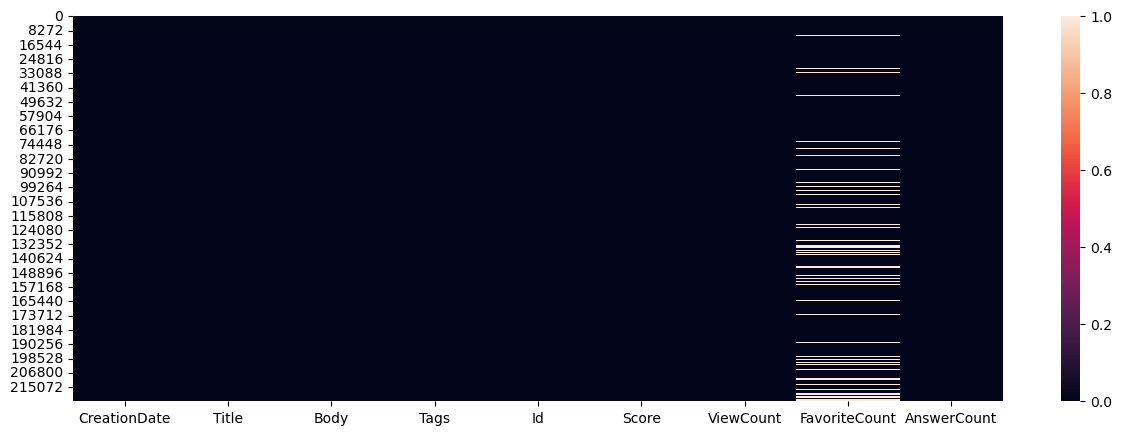

In [162]:
# représentation graphique des valeurs manquantes
fig, ax = plt.subplots(1, 1, figsize = (15, 5))
sns.heatmap(df.isna())

# noir <=> il y a une valeur.
# blanc <=> il n'y a pas de valeur.

In [221]:
# traces
# FavoriteCount
print('@' * 30, 'FavoriteCount', '@' * 30)
print(df['FavoriteCount'].nunique(), 'valeurs uniques :', 
      df['FavoriteCount'].unique())

print('nombre et fréquence de valeurs :')
print(df['FavoriteCount'].value_counts())

print('[min, max] : [', df['FavoriteCount'].min(), ',', df['FavoriteCount'].max(), ']')

# ViewCount
print('\n', '@' * 32, 'ViewCount', '@' * 31)
print('[min, max] : [', df['ViewCount'].min(), ',', df['ViewCount'].max(), ']')

# Score
print('\n', '@' * 33, 'Score', '@' * 34)
print('[min, max] : [', df['Score'].min(), ',', df['Score'].max(), ']')

# AnswerCount
print('\n', '@' * 30, 'AnswerCount', '@' * 31)
print('[min, max] : [', df['AnswerCount'].min(), ',', df['AnswerCount'].max(), ']')

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ FavoriteCount @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
4 valeurs uniques : [ 0. nan  1. 32.  2.]
nombre et fréquence de valeurs :
FavoriteCount
0.0     190652
1.0         10
32.0         1
2.0          1
Name: count, dtype: int64
[min, max] : [ 0.0 , 32.0 ]

 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ ViewCount @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
[min, max] : [ 50 , 12807534 ]

 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ Score @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
[min, max] : [ 6 , 27009 ]

 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ AnswerCount @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
[min, max] : [ 1 , 134 ]


In [222]:
# Suppression colonne 'FavoriteCount', car :
#  - peu de valeurs > 0
#  - nous avons d'autres critères de filtrage utilisés dans la commande SQL : ViewCount > 10, Score > 5, AnswerCount > 0.
df.drop(['FavoriteCount'], axis = 1, inplace = True)

In [223]:
# Vérification nombre de valeurs manquantes
nb_na = df.isnull().sum()
nb_na[nb_na > 0]

Series([], dtype: int64)

# 2.4. VALEURS DUPLIQUEES

In [166]:
df.columns

Index(['CreationDate', 'Title', 'Body', 'Tags', 'Id', 'Score', 'ViewCount',
       'AnswerCount'],
      dtype='object')

In [167]:
########################################
# Doublons entre toutes les lignes     #
########################################
# il n'y a aucune ligne dupliquée <=> il n'existe aucune ligne au niveau du dataframe qui soit la même.
df.duplicated().sum()

0

In [168]:
########################################
# Doublons colonne Body                #
########################################
# Recherche si il y a des valeurs dupliquées pour la colonne Body (corps du message)
df.duplicated(subset = 'Body').sum()

0

In [169]:
# Affichage des duplicated pour un même Body.
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.duplicated.html
idx = df.duplicated(subset = 'Body', keep = False) # Mark all duplicates as True.
df_duplicated = df.loc[idx, :].sort_values('Body')
df_duplicated

# pas de valeurs dupliquées pour un même Body.

Empty DataFrame
Columns: [CreationDate, Title, Body, Tags, Id, Score, ViewCount, AnswerCount]
Index: []

In [170]:
########################################
# Doublons entre toutes les colonnes   #
########################################
# Recherche si il y a des valeurs dupliquées pour chaque colonne
for col in df.columns:
    n = df.duplicated(subset = col).sum()
    print(f"col : {col} -> duplicated : {n}")

col : CreationDate -> duplicated : 82
col : Title -> duplicated : 8
col : Body -> duplicated : 0
col : Tags -> duplicated : 9935
col : Id -> duplicated : 0
col : Score -> duplicated : 222203
col : ViewCount -> duplicated : 162677
col : AnswerCount -> duplicated : 223260


In [224]:
########################################
# Doublons colonne Title               #
########################################
# Affichage des duplicated pour un même Title.
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.duplicated.html
idx = df.duplicated(subset = 'Title', keep = False) # Mark all duplicates as True.
df_duplicated = df.loc[idx, :].sort_values('Title')
df_duplicated

CreationDate  \
1545    2008-09-17 10:58:14   
54662   2012-02-03 14:28:36   
22051   2010-02-22 21:50:22   
43318   2011-02-09 21:38:22   
11625   2009-12-10 21:18:38   
19068   2010-03-11 05:32:04   
74523   2012-08-01 12:18:04   
169021  2017-03-16 11:09:21   
31924   2011-08-31 15:38:30   
43156   2011-01-22 11:40:06   
14398   2010-08-25 12:20:19   
19745   2010-05-04 15:53:23   
38808   2011-03-19 05:39:36   
52519   2012-10-04 16:57:03   
64771   2012-11-10 03:31:31   
64887   2012-11-12 06:54:32   

                                                    Title  \
1545    A potentially dangerous Request.Form value was...   
54662   A potentially dangerous Request.Form value was...   
22051                   Git post-receive hook not working   
43318                   Git post-receive hook not working   
11625                                   HTML Agility Pack   
19068                                   HTML Agility Pack   
74523   Injection of autowired dependencies failed; ne...   
169021  Injection of autowired dependencies failed; ne...   
31924      LINQ to Entities does not recognize the method   
43156      LINQ to Entities does not recognize the method   
14398   Pointcut matching methods with annotated param...   
19745   Pointcut matching methods with annotated param...   
38808   The ObjectContext instance has been disposed a...   
52519   The ObjectContext instance has been disposed a...   
64771           error LNK2019: unresolved external symbol   
64887           error LNK2019: unresolved external symbol   

                                                     Body  \
1545    <p>Every time a user posts something containin...   
54662   <p>I have this issue. I have tried everything....   
22051   <p>We're using git with a central repo (using ...   
43318   <p>My setup is a windows XAMPP server, with cU...   
11625   <p>I'm trying to use HTML Agility Pack to get ...   
19068   <p>I want to parse the html table using html a...   
74523   <p>I am creating web application using Spring,...   
169021  <p>I am new here and I am trying to create an ...   
31924   <p>I'm getting the following error when trying...   
43156   <p>I am following <a href="http://msdn.microso...   
14398   <p>I need to create an aspect with a pointcut ...   
19745   <p>I need to create an aspect with a pointcut ...   
38808   <p>I have this view:</p>\n\n<pre><code>@model ...   
52519   <p>I'm having trouble with one of my queries b...   
64771   <p>I've recently started to program in C++ aga...   
64887   <p>while i want to compile my opengl code i ge...   

                                                     Tags        Id  Score  \
1545    <asp.net><asp.net-mvc><validation><html-encode...     81991   1581   
54662       <c#><jquery><asp.net><architecture><postback>   9130186     25   
22051    <git><bash><gitosis><githooks><git-post-receive>   2314500     12   
43318     <git><curl><hudson><githooks><git-post-receive>   4950800      8   
11625    <c#><html><winforms><parsing><html-agility-pack>   1884094     11   
19068   <c#><.net><winforms><html-parsing><html-agilit...   2422762      6   
74523       <java><spring><hibernate><spring-mvc><struts>  11759040     21   
169021       <java><spring><hibernate><maven><spring-mvc>  42832387      6   
31924   <.net><linq><entity-framework><linq-to-entitie...   7259567    138   
43156   <entity-framework><entity-framework-4><code-fi...   4767596      6   
14398       <java><parameters><annotations><aop><aspectj>   3565718      9   
19745           <java><spring><aop><aspectj><annotations>   2766844     17   
38808   <c#><.net><asp.net-mvc-3><entity-framework><ex...   5360372     41   
52519   <entity-framework><lazy-loading><entity-framew...  12732102      6   
64771   <c++><visual-studio><linker><visual-studio-201...  13318965     11   
64887            <c++><opengl><linker-errors><glut><glew>  13339444     13   

        ViewCount  AnswerCount  
1545      1133070           48  
54662      113706 

In [225]:
for index, row in df_duplicated.iterrows():
    if ((index == 14398) | (index == 19745)):
        print('\n', '@' * 30, 'index =', index, '@' * 30)
        print(row['Title'], row['Body'][1:250], '\n')


 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ index = 14398 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Pointcut matching methods with annotated parameters p>I need to create an aspect with a pointcut matching a method if:</p>

<ol>
<li>it is annoted with MyAnnotationForMethod</li>
<li>One of its parameters (can have many) is annotated with @MyAnnotationForParam (but can have other annotations as well) 


 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ index = 19745 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Pointcut matching methods with annotated parameters p>I need to create an aspect with a pointcut matching a method if:</p>

<ul>
<li>Is public</li>
<li>Its class is annotated with @Controller  <strong><em>(Finally does not)</em></strong></li>
<li>One of its parameters (can have many) is annotated wit 



In [ ]:
########################################
# Doublons colonnes Title & Body       #
########################################

In [173]:
 # Affichage des duplicated pour un même Title et Body.
idx = df.duplicated(subset = ['Title', 'Body'], keep = False) # Mark all duplicates as True.
df.loc[idx, :].sort_values('Title')

Empty DataFrame
Columns: [CreationDate, Title, Body, Tags, Id, Score, ViewCount, AnswerCount]
Index: []

In [ ]:
###############################################################
#   FUSION DES 2 COLONNES      DE TYPE TEXTE : TITLE & BODY   #
#           EN 1 SEULE COLONNE DE TYPE TEXTE : TEXT           #
###############################################################

In [226]:
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @ COLONNES TEXTE : Text + Body --> _Text                        @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# https://apprendrepython.com/concatenation-de-chaines-de-caracteres-en-python-operateur-jointure-etc/
for index, row in df.iterrows():
    
    # Stockage du résultat pour chaque ligne   
    df.loc[index, '_Text'] = df.loc[index, 'Title'] + ' ' + df.loc[index, 'Body'] # Google colab : 54 s

In [227]:
index = 10

print('index =', index, '\n')
print('@' * 30, 'Title =', '@' * 30, '\n',
      df.loc[index, 'Title'], '\n')

print('@' * 30, 'Body =', '@' * 30, '\n',
      df.loc[index, 'Body'], '\n')

print('@' * 30, '_Text =', '@' * 30, '\n',
      df.loc[index, '_Text'], '\n')

index = 10 

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ Title = @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 
 LinqDataSource - Can you limit the amount of records returned? 

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ Body = @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 
 <p>I'd like to use a <code>LinqDataSource</code> control on a page and limit the amount of records returned.  I know if I use code behind I could do something like this:</p>

<pre><code>IEnumerable&lt;int&gt; values = Enumerable.Range(0, 10);
IEnumerable&lt;int&gt; take3 = values.Take(3);
</code></pre>

<p>Does anyone know if something like this is possible with a <code>LinqDataSource</code> control?</p>

<p><strong>[Update]</strong></p>

<p>I'm going to use the <code>LinqDataSource</code> with the <code>ListView</code> control, <em>not</em> a GridView or Repeater.  The <code>LinqDataSource</code> wizard does not provide the ability to limit the number of records return.  The Advanced options only allow you to enabled deletes, inserts, and updates.</p>
 

@@@@@@@@@@@@@

In [228]:
# Suppression des colonnes Title et Body (fusionnées dans la colonne _Text)
df.drop(['Title', 'Body'], axis = 1, inplace = True)

In [229]:
########################################
# Doublons colonne _Text               #
########################################
# Vérification qu'il n'y a pas de valeurs dupliquées pour la colonne _Text
df.duplicated(subset = '_Text').sum()

0

# 2.5. DATA INSPECTION

In [178]:
# summary statistics sur les colonnes de type numérique
# (transpose met les attributs en ligne pour + de lisibilité)
df.describe(include = np.number).transpose()

count          mean           std   min        25%  \
Id           223339.0  2.666292e+07  1.925549e+07   4.0  9469555.0   
Score        223339.0  2.598959e+01  1.446805e+02   6.0        7.0   
ViewCount    223339.0  2.711956e+04  1.067922e+05  50.0     3087.0   
AnswerCount  223339.0  3.394405e+00  3.495859e+00   1.0        1.0   

                    50%         75%         max  
Id           23685630.0  41588480.5  76403109.0  
Score              10.0        18.0     27009.0  
ViewCount        8234.0     21179.5  12807534.0  
AnswerCount         2.0         4.0       134.0

In [179]:
# summary statistics sur les colonnes de type object
# (transpose met les attributs en ligne pour + de lisibilité)
df.describe(include = object).transpose()

count  unique  \
CreationDate  223339  223257   
Tags          223339  213404   
_Text         223339  223339   

                                                            top freq  
CreationDate                                2014-06-23 06:12:33    2  
Tags          <javascript><jquery><html><css><twitter-bootst...  111  
_Text         Registry vs. INI file for storing user configu...    1

# 3. PRETRAITEMENT DU TEXTE / TEXT PROCESSING

# 3.1. BALISES DE TAGS = TARGET Y

In [230]:
# Trace colonne Tags
for i in [0, 10, 100]:
    print('@' * 40, 'index =', i, '@' * 40, '\n',
          df.loc[i, 'Tags'], '\n')

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ index = 0 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 
 <windows><registry><settings><configuration-files><ini> 

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ index = 10 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 
 <c#><asp.net><database><linq><linq-to-sql> 

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ index = 100 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 
 <c#><asp.net><compilation><startup><aspnet-compiler> 



In [231]:
############################################################
# Suppression des balises de tags                          #
############################################################
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @ COLONNES TAGS : Tags --> _Tags                         @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
def tags_process_dataset():
    
    # Traitement pour chaque ligne
    for index, row in df.iterrows():
    
        tags = df.loc[index, 'Tags']
        
        # Suppression des balises <>
        tags = re.sub(r"<", "", tags)
        tags = re.sub(r">", " ", tags)

        # Nombre de tags
        # https://fr.moonbooks.org/Articles/Comment-obtenir-le-nombre-de-mots-dans-un-texte-manuscript-en-python-/        
        list_of_words = tags.split()
        nb_tags = len(list_of_words)
        
        # Stockage du résultat pour chaque ligne   
        df.loc[index, '_Tags']    = tags     # liste de tags sans les balises
        df.loc[index, '_Nb_tags'] = nb_tags  # nombre de tags

In [232]:
tags_process_dataset() # Google colab : 1 min

In [233]:
# traces pour vérifier
for i in [0, 10, 100]:
    print('@' * 40, 'index =', i, '@' * 40, '\n',
          'AVANT :', df.loc[i, 'Tags'], '\n',
          'APRES :', df.loc[i, '_Tags'], '\n',
          '_Nb_tags :', df.loc[i, '_Nb_tags'], '\n')

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ index = 0 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 
 AVANT : <windows><registry><settings><configuration-files><ini> 
 APRES : windows registry settings configuration-files ini  
 _Nb_tags : 5.0 

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ index = 10 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 
 AVANT : <c#><asp.net><database><linq><linq-to-sql> 
 APRES : c# asp.net database linq linq-to-sql  
 _Nb_tags : 5.0 

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ index = 100 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 
 AVANT : <c#><asp.net><compilation><startup><aspnet-compiler> 
 APRES : c# asp.net compilation startup aspnet-compiler  
 _Nb_tags : 5.0 



In [234]:
df['_Nb_tags'].describe().transpose()
# Il y a entre 5 et 6 tags par ligne.

count    223339.000000
mean          5.000031
std           0.005598
min           5.000000
25%           5.000000
50%           5.000000
75%           5.000000
max           6.000000
Name: _Nb_tags, dtype: float64

In [235]:
# Suppression des colonnes Tags et _Nb_tags
df.drop(['Tags', '_Nb_tags'], axis = 1, inplace = True)

# 3.1.1. TAGS : CORPUS & TOKENS

In [236]:
###########################
# Corpus au format texte  #
###########################
# on reconstitue le corpus en joignant l'ensemble des lignes / documents entre eux.
# On fait join avec '' et non ' ', car > a été remplacé par un blanc, la liste de tags se termine par blanc
# (cela évite d'avoir 2 blancs).
corpus_tags = ''.join(df['_Tags']) 
corpus_tags[:1_000]

'windows registry settings configuration-files ini java exception null nullpointerexception illegalargumentexception c++ oop data-structures hash maps c++ multithreading singleton construction lazy-initialization .net wcf web-services visual-studio asmx .net visual-studio tdd mbunit testdriven.net jakarta-ee deployment ant websphere ear sql sql-server database sql-server-2008 intellisense c# .net performance configuration properties language-agnostic http webserver header etag c# asp.net database linq linq-to-sql c# vb.net performance stringbuilder string.format c# c++ windows 64-bit memcached c# .net .net-3.5 wia image-scanner java xml json cross-platform configuration-files c# .net winforms visual-studio-2008 visual-studio-2005 c++ oop class syntax static asp.net performance .net-3.5 content-management-system n2 c++ winapi macos porting fopen http iis iis-7 cookies windows-vista c function pointers syntax parameters html mobile responsive-design wap wml c++ linux eclipse gdb valgrind

In [237]:
###########################
# Corpus au format token  #
###########################
token_tags = corpus_tags.split()
len(token_tags)

1116702

In [ ]:
# Enregistrement dans un fichier
tmp = pd.DataFrame({'words ' : token_tags})
tmp.to_csv(C_DATASET_CLEANED + 'QueryResults_2008_to_2023_token_tags.csv', index = False)

In [238]:
print(token_tags[0:10])

['windows', 'registry', 'settings', 'configuration-files', 'ini', 'java', 'exception', 'null', 'nullpointerexception', 'illegalargumentexception']


In [239]:
# Nombre de fois où sont présents les tokens dans le corpus
# (certains tokens ne sont présents qu'une seule fois).
count_tags = pd.Series(token_tags).value_counts()
count_tags

java                  26280
c#                    25236
javascript            23558
python                23109
c++                   16697
                      ...  
delphi.net                1
ng-hide                   1
mpmoviewcontroller        1
bitsets                   1
visx                      1
Name: count, Length: 31402, dtype: int64

In [240]:
# Nombre de valeurs uniques
print('count_tags :', len(count_tags), 'valeurs uniques')

count_tags : 31402 valeurs uniques


In [241]:
count_tags.describe()

count    31402.000000
mean        35.561493
std        381.644076
min          1.000000
25%          1.000000
50%          3.000000
75%         11.000000
max      26280.000000
Name: count, dtype: float64

In [242]:
# 15 tokens les plus importants
count_tags.head(15)

java           26280
c#             25236
javascript     23558
python         23109
c++            16697
android        15952
ios            15631
.net           11731
html            9781
php             8871
jquery          7764
objective-c     7398
c               6818
node.js         6555
iphone          6437
Name: count, dtype: int64

In [193]:
# 15 tokens les moins importants
count_tags.tail(15)

kie-wb                 1
ibplugin               1
homomorphism           1
lighttable             1
jaxbelement            1
sigma.js               1
pdftoppm               1
pgrouting              1
screenshotexception    1
hclust                 1
delphi.net             1
ng-hide                1
mpmoviewcontroller     1
bitsets                1
visx                   1
Name: count, dtype: int64

# 3.1.2. REDUCTION DU NOMBRE DE TAGS

In [ ]:
# Réduction du nombre de tags pour en avoir moins de 30.

In [246]:
count_tag_max = count_tags.max()
count_tag_plage_min = 14 / 100 * count_tag_max

print('count_tag_max\t\t=', count_tag_max)
print('count_tag_plage_min\t=', round(count_tag_plage_min), '(14% count_tag_max)')

count_tag_max		= 26280
count_tag_plage_min	= 3679 (14% count_tag_max)


In [247]:
####################################################################
#  Recherche des tags présents plus de 14% de fois dans le dataset #
####################################################################
# https://fr.moonbooks.org/Articles/Comment-extraire-les-noms-et-valeurs-de-valuecounts-avec-pandas-en-python-/
new_liste_tags = []

count_tags_reduced = count_tags[count_tags >= count_tag_plage_min]

for idx, name in enumerate(count_tags_reduced.index.tolist()):
    if (count_tags_reduced[idx] >= count_tag_plage_min):
        # Ajout dans la liste si pas déjà présent
        if (name not in new_liste_tags):
            new_liste_tags.append(name)
            print(count_tags_reduced[idx], "\t:", name)

26280 	: java
25236 	: c#
23558 	: javascript
23109 	: python
16697 	: c++
15952 	: android
15631 	: ios
11731 	: .net
9781 	: html
8871 	: php
7764 	: jquery
7398 	: objective-c
6818 	: c
6555 	: node.js
6437 	: iphone
6344 	: css
5408 	: linux
5290 	: asp.net
5174 	: swift
5114 	: spring
5019 	: sql
4510 	: xcode
4304 	: performance
4285 	: ruby-on-rails
4025 	: json
3932 	: reactjs
3854 	: windows
3799 	: mysql


In [248]:
# Nombre de valeurs uniques
print('new_liste_tags :', len(new_liste_tags), 'valeurs uniques :\n')

# liste triée
# https://www.cours-gratuit.com/tutoriel-python/tutoriel-python-list-comment-ordonnertrier-une-liste
print(sorted(new_liste_tags))

# ==> on garde 28 valeurs de tags sur 31402 présents initialement.

new_liste_tags : 28 valeurs uniques :

['.net', 'android', 'asp.net', 'c', 'c#', 'c++', 'css', 'html', 'ios', 'iphone', 'java', 'javascript', 'jquery', 'json', 'linux', 'mysql', 'node.js', 'objective-c', 'performance', 'php', 'python', 'reactjs', 'ruby-on-rails', 'spring', 'sql', 'swift', 'windows', 'xcode']


In [249]:
#####################################################################
# Recherche des 2 tags les plus représentés pour chaque ligne       #
#####################################################################
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @ COLONNES TAGS : Tags --> _Tags  --> _Tag_1, _Tag_2     @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

def reduction_tags_dataset():
    
    # initialisation
    count              = 0 
    lignes_a_supprimer = []

    for index, row in df.iterrows():
        # initialisation
        tags       = row['_Tags']
        token_tags = tags.split()
        dict_tags  = {}
    
        # Sélection des tags qui sont dans la liste
        for i in np.arange(0, len(token_tags)):
            if token_tags[i] in new_liste_tags:
                # On stocke les tags et leur fréquence dans un dictionnaire
                # Exemple : count_tags['java']   = 26280
                #           count_tags['python'] = 23109
                # => dict_tags['java'] = 26280
                dict_tags[token_tags[i]] = count_tags[token_tags[i]]
        
        len_dict_tags = len(dict_tags)
        
        if (count < 10):
            print('index =', index, ':', '\n',
                  '\t- _Tags\t\t=', row['_Tags'], '\n', 
                  '\t- dict_tags\t= ', dict_tags, '\n',
                  '\t- len_dict_tags\t=', len_dict_tags)
    
        # 0 tags : on supprime la ligne si il n'y a plus de tags
        if (len_dict_tags == 0):
            lignes_a_supprimer.append(index)
            if (count < 10):
                print('\t - AUCUN TAG => SUPPRESSION LIGNE\n')
        
        else:
            # Recherche des 2 plus grandes valeurs
            # https://www.delftstack.com/fr/howto/python/find-max-value-in-dictionary-python/
            # https://fr.code-paper.com/python/examples-max-value-from-a-dictionary-in-python
            max_key_1 = max(dict_tags, key = dict_tags.get)
            df.loc[index, '_Tag_1'] = max_key_1
            # suppression du dictionnaire 
            del(dict_tags[max_key_1])
            
            # Plus de 2 tags
            if (len_dict_tags >= 2):
                max_key_2 = max(dict_tags, key = dict_tags.get)
                df.loc[index, '_Tag_2'] = max_key_2
            
            # 1 seul tag
            else: 
                df.loc[index, '_Tag_2'] = 'None' # Valeur vide pour _Tag_2
            
            # Affichage de 10 valeurs
            if (count < 10):
                print('\t - _Tag_1 =', df.loc[index, '_Tag_1'], ', _Tag_2 =', df.loc[index, '_Tag_2'], '\n')             

        count = count + 1
    

    # Suppression des tags vides (en donnant index)
    df.drop(lignes_a_supprimer, axis = 0, inplace = True)
    print("\n==>", len(lignes_a_supprimer), "lignes supprimées\n")

In [250]:
reduction_tags_dataset() # Google colab : 59 s

index = 0 : 
 	- _Tags		= windows registry settings configuration-files ini  
 	- dict_tags	=  {'windows': 3854} 
 	- len_dict_tags	= 1
	 - _Tag_1 = windows 

index = 1 : 
 	- _Tags		= java exception null nullpointerexception illegalargumentexception  
 	- dict_tags	=  {'java': 26280} 
 	- len_dict_tags	= 1
	 - _Tag_1 = java 

index = 2 : 
 	- _Tags		= c++ oop data-structures hash maps  
 	- dict_tags	=  {'c++': 16697} 
 	- len_dict_tags	= 1
	 - _Tag_1 = c++ 

index = 3 : 
 	- _Tags		= c++ multithreading singleton construction lazy-initialization  
 	- dict_tags	=  {'c++': 16697} 
 	- len_dict_tags	= 1
	 - _Tag_1 = c++ 

index = 4 : 
 	- _Tags		= .net wcf web-services visual-studio asmx  
 	- dict_tags	=  {'.net': 11731} 
 	- len_dict_tags	= 1
	 - _Tag_1 = .net 

index = 5 : 
 	- _Tags		= .net visual-studio tdd mbunit testdriven.net  
 	- dict_tags	=  {'.net': 11731} 
 	- len_dict_tags	= 1
	 - _Tag_1 = .net 

index = 6 : 
 	- _Tags		= jakarta-ee deployment ant websphere ear  
 	- dict_

In [257]:
# trace pour vérifier maj _Tag_1 et _Tag_2
count = 0

for index, row in df.iterrows():
    if (count < 20):
        print('index = ', index, ', _Tag_1 =', row['_Tag_1'], '\t, _Tag_2 =', row['_Tag_2'])
    else:
        break
    count = count + 1

index =  0 , _Tag_1 = windows 	, _Tag_2 = nan
index =  1 , _Tag_1 = java 	, _Tag_2 = nan
index =  2 , _Tag_1 = c++ 	, _Tag_2 = nan
index =  3 , _Tag_1 = c++ 	, _Tag_2 = nan
index =  4 , _Tag_1 = .net 	, _Tag_2 = nan
index =  5 , _Tag_1 = .net 	, _Tag_2 = nan
index =  7 , _Tag_1 = sql 	, _Tag_2 = nan
index =  8 , _Tag_1 = c# 	, _Tag_2 = .net
index =  10 , _Tag_1 = c# 	, _Tag_2 = asp.net
index =  11 , _Tag_1 = c# 	, _Tag_2 = performance
index =  12 , _Tag_1 = c# 	, _Tag_2 = c++
index =  13 , _Tag_1 = c# 	, _Tag_2 = .net
index =  14 , _Tag_1 = java 	, _Tag_2 = json
index =  15 , _Tag_1 = c# 	, _Tag_2 = .net
index =  16 , _Tag_1 = c++ 	, _Tag_2 = nan
index =  17 , _Tag_1 = asp.net 	, _Tag_2 = performance
index =  18 , _Tag_1 = c++ 	, _Tag_2 = nan
index =  20 , _Tag_1 = c 	, _Tag_2 = nan
index =  21 , _Tag_1 = html 	, _Tag_2 = nan
index =  22 , _Tag_1 = c++ 	, _Tag_2 = linux


In [251]:
# Suppression de la colonne _Tags
df.drop(['_Tags'], axis = 1, inplace = True)

In [252]:
df.shape

(182919, 8)

# 3.2. BALISES HTML

In [260]:
# Trace colonne _Text
for i in [1, 10, 100]:
    print('@' * 40, 'index =', i, '@' * 40, '\n',
          df.loc[i, '_Text'], '\n')

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ index = 1 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 
 IllegalArgumentException or NullPointerException for a null parameter? <p>I have a simple setter method for a property and <code>null</code> is not appropriate for this particular property. I have always been torn in this situation: should I throw an <a href="http://docs.oracle.com/javase/7/docs/api/java/lang/IllegalArgumentException.html" rel="noreferrer"><code>IllegalArgumentException</code></a>, or a <a href="http://docs.oracle.com/javase/7/docs/api/java/lang/NullPointerException.html" rel="noreferrer"><code>NullPointerException</code></a>? From the javadocs, both seem appropriate. Is there some kind of an understood standard?  Or is this just one of those things that you should do whatever you prefer and both are really correct?</p>
 

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ index = 10 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 
 LinqDataSource - Can you limit the amount of records returned

In [261]:
########################################################################
# Pour une ligne :                                                     #
#   - Suppression des balises HTML                                     #
#   - Passage en minuscules                                            #
########################################################################
def html_process(index_in, is_affichage_in):

    # https://stackoverflow.com/questions/37018475/python-remove-all-html-tags-from-string
    if (is_affichage_in):
        print('index_in =', index_in, '\n')
    
    markup = df.loc[index_in, '_Text']
    
    if (is_affichage_in):
        print('@' * 40, 'html_process - début', '@' * 40)
        print(markup, '\n')
    
    
    # Supression des balises HTML
    soup = BeautifulSoup(markup)
    soup_text = soup.get_text()
    
    
    # On met tout le texte en minuscule  
    soup_text = soup_text.lower()
        
    if (is_affichage_in):    
        print('@' * 40, 'html_process - fin', '@' * 40)
        print(soup_text)
    
    return soup_text

In [262]:
text = html_process(index_in        = 10, 
                    is_affichage_in = True)

index_in = 10 

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ html_process - début @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
LinqDataSource - Can you limit the amount of records returned? <p>I'd like to use a <code>LinqDataSource</code> control on a page and limit the amount of records returned.  I know if I use code behind I could do something like this:</p>

<pre><code>IEnumerable&lt;int&gt; values = Enumerable.Range(0, 10);
IEnumerable&lt;int&gt; take3 = values.Take(3);
</code></pre>

<p>Does anyone know if something like this is possible with a <code>LinqDataSource</code> control?</p>

<p><strong>[Update]</strong></p>

<p>I'm going to use the <code>LinqDataSource</code> with the <code>ListView</code> control, <em>not</em> a GridView or Repeater.  The <code>LinqDataSource</code> wizard does not provide the ability to limit the number of records return.  The Advanced options only allow you to enabled deletes, inserts, and updates.</p>
 

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ html_proces

In [263]:
########################################################################
# Pour tout le dataset :                                               #
#   - Suppression des balises HTML                                     #
#   - Passage en minuscules                                            #
########################################################################
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @ COLONNES TEXTE : Text + Body --> _Text --> _Text_sans_html    @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

def html_process_dataset():
    
    lignes_a_supprimer = [] # initialisation
    
    # Traitement pour chaque ligne
    for index, row in df.iterrows():
    
        text = html_process(index_in        = index, 
                            is_affichage_in = False)
   
      
        # Suppression ligne si text vide (valeur NaN)
        # https://www.delftstack.com/fr/howto/python/check-for-nan-values-python/        
        if (pd.isna(text)):
            lignes_a_supprimer.append(index)

        # Sinon : mise à jour dans le dataset : stockage du résultat pour chaque ligne
        # https://www.delftstack.com/fr/howto/python/how-to-convert-a-list-to-string/
        # Convertir une liste qui a des éléments de type de données str en une chaîne de caractères.            
        else:  
            df.loc[index, '_Text_sans_html'] = text
        
    # Suppression des lignes sans tokens
    df.drop(lignes_a_supprimer, axis = 0, inplace = True)
    print("==>", len(lignes_a_supprimer), "ligne(s) supprimée(s)\n")

In [264]:
html_process_dataset() # Google colab : 3 min 39 s

==> 0 ligne(s) supprimée(s)



In [265]:
# Trace (pour vérifier)
index = 10

print('@' * 40, '_Text / index =', index, '@' * 40, '\n',
      df.loc[i, '_Text'], '\n\n',
      '@' * 35, '_Text_sans_html / index =', index, '@' * 35, '\n',
      df.loc[i, '_Text_sans_html'], '\n')

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ _Text / index = 10 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 
 Precompilation and startup times on ASP.Net <p>I am developping a (relatively small) website in ASP.Net 2.0. I am also using nAnt to perform some easy tweaking on my project before delivering executables. In its current state, the website is "precompiled" using </p>

<blockquote>
  <p><code>aspnet_compiler.exe -nologo -v ${Appname} -u ${target}</code></p>
</blockquote>

<p>I have noticed that after the IIS pool is restarted (after a idle shutdown or a recycle), the application takes up to 20 seconds before it is back online (and Application_start is reached).</p>

<p>I don't have the same issue when I am debugging directly within Visual Studio (it takes 2 seconds to start) so I am wondering if the aspnet_compiler is really such a good idea.</p>

<p>I couldn't find much on MSDN. How do you compile your websites for production?</p>
 

 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ _Text_sans_html

In [ ]:
#############################################
#         Nombre de mots par ligne          #
#############################################

In [ ]:
for index, row in df.iterrows():
    if (pd.isna(row['_Text_sans_html'])):
        print('ligne_a_supprimer :', index, '(vide)')  
        df.drop(index, axis = 0, inplace = True)
    else:
        df.loc[index, '_nb_words_Text_sans_html'] = len(row['_Text_sans_html'].split())  

In [ ]:
# output de sortie pour contrôler que l'opération s'est bien effectuée.
df.describe(include = np.number)
# la grande majorité des messages (50 %) a 147 mots.
# Certains ont une taille très élevée (10.740).
# 25 % a 92 mots => choix de supprimer les lignes qui ont moins de 100 mots pour alléger les processus.

In [7]:
# Suppression des données avec moins de 100 mots pour diminuer le nombre de données et augmenter le temps de processus.
df_words_inf_100 = df.loc[df['_nb_words_Text_sans_html'] < 100,:]

# Nombre de lignes avant correction
print('nb lignes avec _nb_words_Text_sans_html < 100 =', len(df_words_inf_100.index))
    
lignes_a_supprimer = []
     
for index in df_words_inf_100.index:
    lignes_a_supprimer.append(index)
        
df.drop(lignes_a_supprimer, axis = 0, inplace = True)
print("==>", len(lignes_a_supprimer), "lignes supprimées\n")

In [ ]:
# suppression de la colonne PostTypeId car il n'y a qu'une valeur unique
df.drop(['_nb_words_Text_sans_html'], axis = 1, inplace = True)

In [ ]:
print(df.shape)

In [ ]:
# Réinitialisation de l’index du dataFrame :
#   --> Après la suppression des lignes ci-dessus.
#   --> Avant §3.3. Nettoyage : tokenization, suppressions (stop words, nombres...).
# https://www.delftstack.com/fr/howto/python-pandas/pandas-reset-index-python/
df.reset_index(inplace = True, drop = True)

In [ ]:
print(df.shape)

# 3.3. NETTOYAGE : TOKENISATION, SUPPRESSIONS (STOP WORDS, NOMBRES...)

In [266]:
##########################################################
#              Affichage taille des tokens               #
##########################################################
def affichage_token_size(tokens_in):
    
    print(tokens_in)
    
    # nombre de tokens
    print('\nnombre de tokens\t\t=', len(tokens_in))

    # nombre de tokens uniques
    print('nombre de tokens uniques\t=', len(set(tokens_in)))

In [ ]:
if (C_EXECUTION_SUR_GOOGLE_COLAB):
    import nltk
    nltk.download('stopwords')
    nltk.download('words')

In [267]:
########################################################################
#   Stop words = liste de mots trop génériques pour être informatif.   #
########################################################################
stop_words = set(stopwords.words('english'))  # langage = anglais
print(stop_words)

{'my', 'below', 'mustn', 'these', 'now', 's', 'under', "should've", 'don', 've', 'themselves', 'its', 'any', 'those', 'was', 'as', 'will', 'out', 'an', 'which', 'doing', "isn't", 'only', 'and', 'up', 'just', 'he', "won't", 'above', 'again', 'no', 'had', "wouldn't", 'we', 'yours', 'me', 'herself', 'through', 'should', 'there', 'on', 'for', 'hasn', 'then', 'do', 'a', 'weren', "shan't", 'by', 'it', 'has', 'if', 'off', 'how', 'than', 'both', 'until', 'with', 'but', "haven't", "she's", "you'd", 'him', 'where', 'd', 'more', 'once', 'the', 'isn', 'needn', "mustn't", 'shan', "you're", 'o', 'all', "aren't", 'before', 'itself', 'very', "it's", 'his', 're', "doesn't", 'is', 'doesn', 'further', 'wouldn', 'when', 'too', 'y', "needn't", 'won', 't', 'mightn', 'hadn', "mightn't", "hadn't", 'yourself', 'same', 'our', "you'll", 'into', "you've", 'own', 'hers', 'can', 'ain', 'wasn', 'or', 'this', 'shouldn', 'you', 'were', 'theirs', 'aren', 'some', 'm', 'most', 'they', "couldn't", 'them', 'ours', 'i', 'be

In [ ]:
#################################################
#        Dictionnaire des mots anglais          #
#################################################

In [268]:
# on uniformise en ne prenant que les mots en minuscules
english_words = [i.lower() for i in words.words()]
pd.Series(english_words).sample(15)

205121           towerlet
152873         precession
182675          skunkweed
148647    pleuropterygian
182712         skywriting
180              abeltree
203869        titillating
69465              fibril
221920         unreturned
147943        plasmodesma
121764       myriological
162971           rambooze
126097         nonevasion
45512          cricetidae
40565           computist
dtype: object

In [269]:
len(english_words)

236736

In [272]:
###########################################################################################
# Pour une ligne :                                                                        #
#  - Tokenization                                                                         #
#  - Suppressions : ponctuation, stop_word, nombres, mots alphanumeriques, short tokens,  #
#                   mots qui ne sont pas dans le dictionnaire anglais                     #
#  - Transform emojis to characters                                                       #
###########################################################################################
def cleaning_process(index_in, is_affichage_in, min_len_word_in = 3):
    
    if (is_affichage_in):
        print('index_in =', index_in, '\n')
    
    doc = df.loc[index_in, '_Text_sans_html']
    
    if (is_affichage_in):
        print('@' * 40, 'cleaning_process - début', '@' * 40)
        print(doc)
    
    
    
    # Suppression ponctuation (remplacement par un caractère blanc)
    # Ponctuation =  !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 
    doc_sans_ponctuation = re.sub(f"[{re.escape(punctuation)}]", " ", doc)
    
    if (is_affichage_in):    
        print('\n')
        print('@' * 38, 'cleaning_process - après suppression ponctuation', '@' * 37)
        print(doc_sans_ponctuation)
    
    
    
    # Tokenization : liste de tokens bruts
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(doc_sans_ponctuation)
        
    if (is_affichage_in):    
        print('\n')
        print('@' * 40, 'cleaning_process - après tokenization', '@' * 40)
        affichage_token_size(tokens_in = tokens)
        
        
        
    # Suppression stop_words
    tokens_sans_stop_words = [w for w in tokens if w not in stop_words]
    
    if (is_affichage_in):
        print('\n')
        print('@' * 38, 'cleaning_process - après suppression stop_words', '@' * 37)
        affichage_token_size(tokens_in = tokens_sans_stop_words)

        
        
    # Suppression des nombres
    tokens_sans_nombre = [w for w in tokens_sans_stop_words if not (w.isdigit())]
    if (is_affichage_in):
        print('\n')
        print('@' * 39, 'cleaning_process - après suppression nombres', '@' * 39)
        affichage_token_size(tokens_in = tokens_sans_nombre)

        
        
    # Suppression des mots alphanumeriques (exemple : 4cb9df79467b3eb5d6787a98dcf8665)
    # https://www.delftstack.com/fr/howto/python/how-to-check-a-string-contains-a-number-or-not-in-python/
    # <=> on regarde si la chaîne de caractère contient un nombre.
    # Suppression de tous les caractères numériques (\d) i.e. équivalent à la classe [0-9].
    # https://docs.python.org/fr/3/howto/regex.html :
    tokens_sans_alphanum = [w for w in tokens_sans_nombre if not (bool(re.search(r'\d', w)))]
    if (is_affichage_in):
        print('\n')
        print('@' * 32, 'cleaning_process - après suppression mots alphanumériques', '@' * 33)
        affichage_token_size(tokens_in = tokens_sans_alphanum)
    
 

    # Suppression short tokens (taille >= min_len_word_in) s'il n'est pas dans les token_tags 
    # (les termes techniques sont indispensables à garder pour les algos).
    # Autrement dit, les tokens longs prennnent en compte les tags.
    tokens_long = [w for w in tokens_sans_alphanum if ((len(w) >= min_len_word_in) | 
                                                       (w in token_tags))]
    
    if (is_affichage_in):
        print('\n')
        print('@' * 32, 'cleaning_process - après suppression tokens de taille >=', min_len_word_in, '@' * 33)
        affichage_token_size(tokens_in = tokens_long)

        
    
    # Suppression des mots qui ne sont pas dans le dictionnaire anglais
    tokens_english = [w for w in tokens_long if w in english_words]
    
    if (is_affichage_in):
        print('\n')
        print('@' * 23, 'cleaning_process - après suppression tokens absents du dictionnaire anglais', '@' * 24)
        affichage_token_size(tokens_in = tokens_english)


        
    # Suppression de tous les caractères "blanc" (\s) i.e. équivalent à la classe [ \t\n\r\f\v].
    # https://docs.python.org/fr/3/howto/regex.html
    tokens_no_blanc = [w for w in tokens_english if not (bool(re.search(r'\s', w)))]
    if (is_affichage_in):
        print('\n')
        print('@' * 32, 'cleaning_process - après suppression caractères "blanc"', '@' * 33)
        affichage_token_size(tokens_in = tokens_no_blanc)
        
        
        
    # Conversion liste d'éléments de type str --> une chaîne de caractères.        
    # https://www.delftstack.com/fr/howto/python/how-to-convert-a-list-to-string/
    text_clean = ' '.join(tokens_no_blanc)

    

    # Transform emojis to characters
    text_no_emojis = emoji.demojize(text_clean)    

    if (is_affichage_in):
        print('\n')
        print('@' * 38, 'cleaning_process - après transformations emojis', '@' * 37)
        print(text_no_emojis)
        
    return text_no_emojis

In [271]:
tokens = cleaning_process(index_in        = 10,  
                          is_affichage_in = True)

index_in = 10 

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ cleaning_process - début @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
linqdatasource - can you limit the amount of records returned? i'd like to use a linqdatasource control on a page and limit the amount of records returned.  i know if i use code behind i could do something like this:
ienumerable<int> values = enumerable.range(0, 10);
ienumerable<int> take3 = values.take(3);

does anyone know if something like this is possible with a linqdatasource control?
[update]
i'm going to use the linqdatasource with the listview control, not a gridview or repeater.  the linqdatasource wizard does not provide the ability to limit the number of records return.  the advanced options only allow you to enabled deletes, inserts, and updates.



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ cleaning_process - après suppression ponctuation @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
linqdatasource   can you limit the amount of records returned  i d like to use a 

In [287]:
##########################################################################################################
# Pour tout le dataset (fonction longue => on l'appelle par plage d'index [index_min_in, index_max_in]): #
#  - Tokenization                                                                                        #
#  - Suppressions : ponctuation, stop_word, nombres, mots alphanumeriques, short tokens                  #     
#  - Transform emojis to characters                                                                      #
##########################################################################################################
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @ COLONNES TEXTE : Text + Body --> _Text --> _Text_sans_html --> _Text_tokens @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

def cleaning_process_dataset(index_min_in, index_max_in):
    lignes_a_supprimer = []  # initialisation
    count_nan          = 0 # compteur de valeurs NaN
    
    print('index_min_in =', index_min_in, ', index_max_in =', index_max_in,
          '=>', index_max_in - index_min_in + 1, 'lignes')
        
    # https://moncoachdata.com/blog/filtrer-un-dataframe-pandas/
    df_filtered = df.loc[index_min_in:index_max_in + 1, :] # lignes index_min_in à index_max_in, toutes les colonnes
    
    # Traitement pour chaque ligne
    for index in df_filtered.index:

        print('index =', index)
        text = cleaning_process(index_in        = index, 
                                is_affichage_in = False)
    
        # Suppression ligne si text vide (valeur NaN)
        # https://www.delftstack.com/fr/howto/python/check-for-nan-values-python/        
        if (pd.isna(text) | (text == '')):
            lignes_a_supprimer.append(index)
            print('ligne_a_supprimer :', index, '(vide)')
            
        # Suppression ligne si moins de 75 mots
        elif (len(text.split()) <= 75):
            lignes_a_supprimer.append(index)
            print('ligne_a_supprimer :', index, '(', len(text.split()), '<= 75 mots)')
            
        # Sinon : mise à jour dans le dataset : stockage du résultat pour chaque ligne
        # https://www.delftstack.com/fr/howto/python/how-to-convert-a-list-to-string/
        # Convertir une liste qui a des éléments de type de données str en une chaîne de caractères.            
        else:
            df.loc[index, '_Text_tokens'] = text
        
    # Suppression des lignes sans tokens
    print('\nSuppression des lignes sans tokens :')
    df.drop(lignes_a_supprimer, axis = 0, inplace = True)
    print("==>", len(lignes_a_supprimer), "ligne(s) supprimée(s).")
    
    
    # Vérification que tous les _Text_tokens' de la plage [index_min_in, index_max_in] sont remplis i.e. 
    # qu'il n'y pas de NaN
    df_filtered_new = df.loc[index_min_in:index_max_in, :]
    
    print('\nVérification que tous les _Text_tokens de la plage [', index_min_in, ',', index_max_in, '] sont remplis :')
    for index, row in df_filtered_new.iterrows():
        if (pd.isna(row['_Text_tokens']) | (row['_Text_tokens'] == '')):
            print('index =', index, ', _Text_tokens =', row['_Text_tokens'])
            count_nan = count_nan + 1
    
    if (count_nan == 0):
        print('==> Aucune valeur NaN.')
    else:
        print('==>', count_nan, 'valeurs NaN dans l\'intervalle.')

In [174]:
#################################################################################
# Boucle sur une plage avec un pas et une sauvegarde toutes les 500 lignes      #
#################################################################################
# https://www.dad3zero.net/202008/python-chiffres-lisibles-souligne/
def cleaning_process_dataset_boucle_plage(ind_min_in, ind_max_in):
    
    print('ind_min_in =', ind_min_in, ', ind_max_in =', ind_max_in,
          '=>', ind_max_in - ind_min_in + 1, 'lignes dans la plage')

    # Initialisation indices boucle for
    i_min = ind_min_in
    i_max = i_min + 499 # pas de 500

    for i in np.arange(i_min, i_max):
        print('@' * 60)
        cleaning_process_dataset(index_min_in = i_min, 
                                 index_max_in = i_max)
    
        # Enregistrement (provisoire), toutes les 500 lignes
        df.to_csv(C_DATASET_CLEANED + 'QueryResults_2008_to_2023_clean.csv',
                  sep = '\t', header = True, index = False)
    
        # sortie de la boucle si plage_max
        if (i_max == ind_max_in):
            break # sortie de la boucle for
        # Sinon : maj indices boucle        
        else:
            i_min = i_max
            i_max = i_min + 499 # pas de 500

In [288]:
##########################################################
#      Affichage après fonction cleaning_process         #
##########################################################
def affichage_apres_cleaning_process(index_in):
    
    print('tokens_in =', index_in)
    
    # Avant fonction cleaning_process
    print('\n', '@' * 38, '_Text_sans_html (AVANT fonction cleaning_process)', '@' * 37)
    print(df.loc[index_in, '_Text_sans_html'])

    # Après fonction cleaning_process    
    print('\n', '@' * 39, '_Text_tokens (APRES fonction cleaning_process)', '@' * 39)
    print(df.loc[index_in, '_Text_tokens'])    
    
    # Enregistrement (provisoire)
    df.to_csv(C_DATASET_CLEANED + 'QueryResults_2008_to_2023_clean.csv', 
              sep = '\t', header = True, index = False)

In [ ]:
################################################################
# Vérification absence valeurs NaN dans la colonne colonne_in. #
################################################################
def verification_NaN(index_min_in, index_max_in, colonne_in):
    df_filtered = df.loc[0:19_000,:]
    liste_index = []
    for index, row in df_filtered.iterrows():
        if (pd.isna(row['_Text_tokens']) | (row['_Text_tokens'] == '')):
#            print(index, row['_Text_tokens']) 
            liste_index.append(index)

    print('liste_index avec', colonne_in, 'vide =', liste_index)

In [ ]:
###################################################
# index 0 --> 5.999 : 6.000 lignes                #
###################################################
cleaning_process_dataset_boucle_plage(ind_min_in = 0, 
                                      ind_max_in = 5_999) # Google colab :

In [ ]:
# Trace de la première ligne (pour vérifier)
affichage_apres_cleaning_process(index_in = 0)

In [ ]:
###################################################
# index 6.000 --> 11.999 : 6.000 lignes           #
###################################################
cleaning_process_dataset_boucle_plage(ind_min_in = 6_000, 
                                      ind_max_in = 11_999) # Google colab :

In [ ]:
# Trace de la première ligne (pour vérifier)
affichage_apres_cleaning_process(index_in = 6_000)

In [ ]:
# Vérification (toutes les 12.000 lignes) absence valeurs NaN dans la colonne _Text_tokens.
verification_NaN(index_min_in = 0, 
                 index_max_in = 11_999,
                 colonne_in   = '_Text_tokens')

In [ ]:
###################################################
# index 12.000 --> 17.999 : 6.000 lignes          #
###################################################
cleaning_process_dataset_boucle_plage(ind_min_in = 12_000, 
                                      ind_max_in = 17_999) # Google colab :

In [ ]:
# Trace de la première ligne (pour vérifier)
affichage_apres_cleaning_process(index_in = 12_000)

In [ ]:
###################################################
# index 18.000 --> 23.999 : 6.000 lignes          #
###################################################
cleaning_process_dataset_boucle_plage(ind_min_in = 18_000, 
                                      ind_max_in = 23_999) # Google colab :

In [ ]:
# Trace de la première ligne (pour vérifier)
affichage_apres_cleaning_process(index_in = 18_000)

In [ ]:
# Vérification (toutes les 12.000 lignes) absence valeurs NaN dans la colonne _Text_tokens.
verification_NaN(index_min_in = 0, 
                 index_max_in = 23_999,
                 colonne_in   = '_Text_tokens')

In [ ]:
###################################################
# index 24.000 --> 29.999 : 6.000 lignes          #
###################################################
cleaning_process_dataset_boucle_plage(ind_min_in = 24_000, 
                                      ind_max_in = 29_999) # Google colab :

In [ ]:
# Trace de la première ligne (pour vérifier)
affichage_apres_cleaning_process(index_in = 24_000)

In [ ]:
###################################################
# index 30.000 --> 35.999 : 6.000 lignes          #
###################################################
cleaning_process_dataset_boucle_plage(ind_min_in = 30_000, 
                                      ind_max_in = 35_999) # Google colab :

In [ ]:
# Trace de la première ligne (pour vérifier)
affichage_apres_cleaning_process(index_in = 30_000)

In [ ]:
# Vérification (toutes les 12.000 lignes) absence valeurs NaN dans la colonne _Text_tokens.
verification_NaN(index_min_in = 0, 
                 index_max_in = 35_999,
                 colonne_in   = '_Text_tokens')

In [ ]:
###################################################
# index 36.000 --> 41.999 : 6.000 lignes          #
###################################################
cleaning_process_dataset_boucle_plage(ind_min_in = 36_000, 
                                      ind_max_in = 41_999) # Google colab :

In [ ]:
# Trace de la première ligne (pour vérifier)
affichage_apres_cleaning_process(index_in = 36_000)

In [ ]:
###################################################
# index 42.000 --> 47.999 : 6.000 lignes          #
###################################################
cleaning_process_dataset_boucle_plage(ind_min_in = 42_000, 
                                      ind_max_in = 47_999) # Google colab :

In [ ]:
# Trace de la première ligne (pour vérifier)
affichage_apres_cleaning_process(index_in = 42_000)

In [ ]:
# Vérification (toutes les 12.000 lignes) absence valeurs NaN dans la colonne _Text_tokens.
verification_NaN(index_min_in = 0, 
                 index_max_in = 35_999,
                 colonne_in   = '_Text_tokens')

In [ ]:
###################################################
# index 48.000 --> 53.999 : 6.000 lignes          #
###################################################
cleaning_process_dataset_boucle_plage(ind_min_in = 48_000, 
                                      ind_max_in = 53_999) # Google colab :

In [ ]:
# Trace de la première ligne (pour vérifier)
affichage_apres_cleaning_process(index_in = 48_000)

In [ ]:
###################################################
# index 54.000 --> 59.999 : 6.000 lignes          #
###################################################
cleaning_process_dataset_boucle_plage(ind_min_in = 54_000, 
                                      ind_max_in = 59_999) # Google colab :

In [ ]:
# Trace de la première ligne (pour vérifier)
affichage_apres_cleaning_process(index_in = 54_000)

In [ ]:
# Vérification (toutes les 12.000 lignes) absence valeurs NaN dans la colonne _Text_tokens.
verification_NaN(index_min_in = 0, 
                 index_max_in = 59_999,
                 colonne_in   = '_Text_tokens')

In [ ]:
###################################################
# index 60.000 --> 65.999 : 6.000 lignes          #
###################################################
cleaning_process_dataset_boucle_plage(ind_min_in = 60_000, 
                                      ind_max_in = 65_999) # Google colab :

In [ ]:
# Trace de la première ligne (pour vérifier)
affichage_apres_cleaning_process(index_in = 60_000)

In [ ]:
###################################################
# index 66.000 --> 71.999 : 6.000 lignes          #
###################################################
cleaning_process_dataset_boucle_plage(ind_min_in = 66_000, 
                                      ind_max_in = 71_999) # Google colab :

In [ ]:
# Trace de la première ligne (pour vérifier)
affichage_apres_cleaning_process(index_in = 66_000)

In [ ]:
# Vérification (toutes les 12.000 lignes) absence valeurs NaN dans la colonne _Text_tokens.
verification_NaN(index_min_in = 0, 
                 index_max_in = 71_999,
                 colonne_in   = '_Text_tokens')

In [ ]:
###################################################
# index 72.000 --> 75.999 : 6.000 lignes          #
###################################################
cleaning_process_dataset_boucle_plage(ind_min_in = 72_000, 
                                      ind_max_in = 75_999) # Google colab :

In [ ]:
# Trace de la première ligne (pour vérifier)
affichage_apres_cleaning_process(index_in = 72_000)

In [ ]:
###################################################
# index 76.000 --> 81.999 : 6.000 lignes          #
###################################################
cleaning_process_dataset_boucle_plage(ind_min_in = 76_000, 
                                      ind_max_in = 81_999) # Google colab :

In [ ]:
# Trace de la première ligne (pour vérifier)
affichage_apres_cleaning_process(index_in = 76_000)

In [ ]:
# Vérification (toutes les 10.000 lignes) absence valeurs NaN dans la colonne _Text_tokens.
verification_NaN(index_min_in = 0, 
                 index_max_in = 81_999,
                 colonne_in   = '_Text_tokens')

In [ ]:
###################################################
# index 82.000 --> 87.999 : 6.000 lignes          #
###################################################
cleaning_process_dataset_boucle_plage(ind_min_in = 82_000, 
                                      ind_max_in = 87_999) # Google colab :

In [ ]:
# Trace de la première ligne (pour vérifier)
affichage_apres_cleaning_process(index_in = 82_000)

In [ ]:
###################################################
# index 88.000 --> 93.999 : 6.000 lignes          #
###################################################
cleaning_process_dataset_boucle_plage(ind_min_in = 88_000, 
                                      ind_max_in = 93_999) # Google colab :

In [ ]:
# Trace de la première ligne (pour vérifier)
affichage_apres_cleaning_process(index_in = 88_000)

In [ ]:
df.shape

In [ ]:
###################################################
#   index 94.000 --> xxx.xxx : xx.xxx lignes      #
###################################################
cleaning_process_dataset(index_min_in = 94_000, 
                         index_max_in = len(df.index)) # nombre de lignes # Google colab : 58 min

In [ ]:
# Vérification (toutes les 10.000 lignes) absence valeurs NaN dans la colonne _Text_tokens.
verification_NaN(index_min_in = 0, 
                 index_max_in = len(df.index),
                 colonne_in   = '_Text_tokens')

In [78]:
# Dans tout le dataset --> vérification que tous les _Text_tokens' sont remplis i.e. qu'il n'y pas de NaN
# ni de double blanc dans le texte.
lignes_a_supprimer = []

for index, row in df.iterrows():
    if (pd.isna(row['_Text_tokens']) | (row['_Text_tokens'] == '')):
        print(index, row['_Text_tokens'])  
        lignes_a_supprimer.append(index)
        
df.drop(lignes_a_supprimer, axis = 0, inplace = True)
print("==>", len(lignes_a_supprimer), "ligne(s) supprimée(s).")

In [ ]:
# Réinitialisation de l’index du dataFrame :
#   --> Après la suppression des lignes ci-dessus.
#   --> Avant §4. Compléments prétraitement du texte / text processing.
# https://www.delftstack.com/fr/howto/python-pandas/pandas-reset-index-python/
df.reset_index(inplace = True, drop = True)

In [ ]:
# Enregistrement (provisoire)
df.to_csv(C_DATASET_CLEANED + 'QueryResults_2008_to_2023_apres_premier_clean.csv', 
          sep = '\t', header = True, index = False) # fichier de secours
df.to_csv(C_DATASET_CLEANED + 'QueryResults_2008_to_2023_clean.csv', 
              sep = '\t', header = True, index = False)

# 4. COMPLEMENT PRETRAITEMENT DU TEXTE / TEXT PROCESSING

In [ ]:
# Calculs sur tout le corpus après un premier nettoyage. 

# 4.1. CALCUL RARE TOKENS

In [5]:
##############################################################
#   Rare tokens : tokens faiblement présents sur le corpus   #
#   (nb_min_in fois : 1, 2, 5, 10...)                        #
##############################################################
def rare_tokens(nb_min_in = 1):

    print('nb_min_in\t\t=', nb_min_in)
    
    
    ###########################
    # Corpus au format texte  #
    ###########################
    corpus_text = ' '.join(df['_Text_tokens'])


    ###########################
    # Corpus au format token  #
    ###########################
    token_text = corpus_text.split()
    print('taille token_text\t=', f"{len(token_text):,}") # avec séparateur de milliers


    # Nombre de fois où sont présents les tokens dans le corpus
    # (certains tokens ne sont présents qu'une seule fois).
    count_text = pd.Series(token_text).value_counts()
#    print('\ncount_text =')
#    print(count_text, '\n')
    
    
    ##########################################################
    # Tokens présents 1 seule fois sur le corpus             #
    ##########################################################
    if (nb_min_in == 1):
        liste_rare_words = count_text[count_text == 1]

        
    ##########################################################
    # Tokens présents plus de 2 fois ou moins sur le corpus  #
    ##########################################################
    else:    
        liste_rare_words = count_text[count_text <= nb_min_in]

    
    print('nb rare_words\t\t=', f"{len(liste_rare_words):,}", '\n') # avec séparateur de milliers
    

    # Calcul % rare_words % token_text
    print('==> rare_words =', round(len(liste_rare_words) / len(token_text) * 100, 3), '% token_text\n')
    
    liste_rare_words_list_ = liste_rare_words.index.tolist()
    

    # Mise à jour corpus % tags : on conserve un token s'il n'est pas dans les token_tags 
    # (les termes techniques sont indispensables à garder pour les algos).
    # Autrement dit, les rare words ne prennnent pas en compte les tags.
    liste_rare_words_list = [w for w in liste_rare_words_list_ if w not in token_tags]
    
    print('liste_rare_words_list (', len(liste_rare_words_list), 'éléments) =')
    print(liste_rare_words_list[0:10], '...')

    return liste_rare_words_list

In [6]:
# "Rare words" présents 1 fois sur le corpus
liste_rare_words_1 = rare_tokens(nb_min_in = 1)

nb_min_in		= 1
taille token_text	= 17,750,796
nb rare_words		= 5,035 

==> rare_words = 0.028 % token_text

liste_rare_words_list =
['adequacy', 'doff', 'alpaca', 'demonstrator', 'yonder', 'portail', 'wellington', 'arches', 'examinable', 'uninformed'] ...


In [7]:
# "Rare words" présents moins de 5 fois sur le corpus
liste_rare_words_5 = rare_tokens(nb_min_in = 5)

nb_min_in		= 5
taille token_text	= 17,750,796
nb rare_words		= 11,026 

==> rare_words = 0.062 % token_text

liste_rare_words_list =
['dieter', 'convergent', 'practiced', 'amused', 'interpretable', 'coercible', 'trest', 'tema', 'demote', 'tron'] ...


In [18]:
# "Rare words" présents moins de 10 fois sur le corpus
liste_rare_words_10 = rare_tokens(nb_min_in = 10)

nb_min_in		= 10
taille token_text	= 17,808,767
nb rare_words		= 13,533 

==> rare_words = 0.076 % token_text

liste_rare_words_list =
['belgian', 'toilet', 'reasoner', 'peculiarity', 'inflect', 'unreleased', 'unacknowledged', 'corpse', 'throwaway', 'spotting'] ...


In [233]:
# "Rare words" présents moins de 50 fois sur le corpus
liste_rare_words_50 = rare_tokens(nb_min_in = 50)

nb_min_in		= 50
taille token_text	= 17,751,057
nb rare_words		= 18,169 

==> rare_words = 0.102 % token_text

liste_rare_words_list =
['grass', 'explosion', 'invocable', 'sand', 'bass', 'exportable', 'chi', 'severely', 'twenty', 'reassign'] ...


In [20]:
# "Rare words" présents moins de 100 fois sur le corpus
liste_rare_words_100 = rare_tokens(nb_min_in = 100)

nb_min_in		= 100
taille token_text	= 17,808,767
nb rare_words		= 19,700 

==> rare_words = 0.111 % token_text

liste_rare_words_list =
['painted', 'ghost', 'tomato', 'negotiation', 'interfering', 'andy', 'fading', 'complicate', 'tan', 'teste'] ...


In [407]:
# "Rare words" présents moins de 200 fois sur le corpus
liste_rare_words_200 = rare_tokens(nb_min_in = 200)

nb_min_in		= 200
taille token_text	= 17,751,000
nb rare_words		= 20,928 

==> rare_words = 0.118 % token_text

liste_rare_words_list =
['scraper', 'thrift', 'spinning', 'vulnerability', 'practically', 'gate', 'pusher', 'understandable', 'valuable', 'sentry'] ...


In [8]:
# "Rare words" présents moins de 500 fois sur le corpus
liste_rare_words_500 = rare_tokens(nb_min_in = 500)

nb_min_in		= 500
taille token_text	= 17,750,796
nb rare_words		= 22,157 

==> rare_words = 0.125 % token_text

liste_rare_words_list =
['millions', 'simulation', 'unicorn', 'sigmoid', 'supply', 'tricky', 'scrolled', 'food', 'satisfy', 'scaled'] ...


In [22]:
# "Rare words" présents moins de 1000 fois sur le corpus
liste_rare_words_1000 = rare_tokens(nb_min_in = 1000)

nb_min_in		= 1000
taille token_text	= 17,808,767
nb rare_words		= 22,988 

==> rare_words = 0.129 % token_text

liste_rare_words_list =
['man', 'jump', 'caller', 'advanced', 'diagnostics', 'significant', 'produced', 'music', 'subset', 'portable'] ...


In [214]:
# "Rare words" présents moins de 2000 fois sur le corpus
liste_rare_words_2000 = rare_tokens(nb_min_in = 2000)

nb_min_in		= 2000
taille token_text	= 17,808,767
nb rare_words		= 23,601 

==> rare_words = 0.133 % token_text


In [215]:
# "Rare words" présents moins de 5000 fois sur le corpus
liste_rare_words_5000 = rare_tokens(nb_min_in = 5000)

nb_min_in		= 5000
taille token_text	= 17,808,767
nb rare_words		= 24,210 

==> rare_words = 0.136 % token_text


In [9]:
# Maj nombre rare words = 500
liste_rare_words = liste_rare_words_500

# Conversion liste_rare_words en liste :
print(len(liste_rare_words), 'rare words :')
print(liste_rare_words[1:50], '...')

22157 rare words :
['simulation', 'unicorn', 'sigmoid', 'supply', 'tricky', 'scrolled', 'food', 'satisfy', 'scaled', 'shed', 'instrument', 'restriction', 'eliminate', 'reinterpret', 'median', 'backward', 'chose', 'vista', 'bypass', 'presumably', 'adam', 'spot', 'tornado', 'peripheral', 'mounted', 'localization', 'scalable', 'qualifier', 'flexible', 'outlet', 'fancy', 'pay', 'cam', 'blas', 'lo', 'smoothly', 'authenticator', 'restricted', 'isolate', 'interpolation', 'dolor', 'transpose', 'slave', 'combining', 'banner', 'workbench', 'difficulty', 'illustrate', 'tip'] ...


In [ ]:
# Enregistrement dans un fichier
tmp = pd.DataFrame({'words ' : liste_rare_words})
tmp.to_csv(C_DATASET_CLEANED + 'QueryResults_2008_to_2023_liste_rare_words.csv', index = False)

# 4.2. CALCUL DOUBLONS

In [ ]:
#####################################################
# Tags les plus représentés par ordre décroissant : #
#   26280 : java --------> n°1                      #
#   25236 : c# ----------> n°2                      #
#   23558 : javascript --> n°3                      #
#   23109 : python ------> n°4                      #
#   16697 : c++ ---------> n°5                      #
#####################################################

In [10]:
# Création de sous-dataframes en filtrant sur les tags
df_java        = df[(df['_Tag_1'] == 'java')       | (df['_Tag_2'] == 'java')]       # java
df_c_sharp     = df[(df['_Tag_1'] == 'c#')         | (df['_Tag_2'] == 'c#')]         # c#
df_javascript  = df[(df['_Tag_1'] == 'javascript') | (df['_Tag_2'] == 'javascript')] # javascript
df_python      = df[(df['_Tag_1'] == 'python')     | (df['_Tag_2'] == 'python')]     # python
df_c_plus_plus = df[(df['_Tag_1'] == 'c++')        | (df['_Tag_2'] == 'c++')]        # c++

In [11]:
print('df_java shape\t\t=',      df_java.shape)
print('df_c_sharp shape\t=',     df_c_sharp.shape)
print('df_javascript shape\t=',  df_javascript.shape)
print('df_python shape\t\t=',    df_python.shape)
print('df_c_plus_plus shape\t=', df_c_plus_plus.shape)

df_java shape		= (23731, 17)
df_c_sharp shape	= (21628, 17)
df_javascript shape	= (21062, 17)
df_python shape		= (20695, 17)
df_c_plus_plus shape	= (14390, 17)


In [12]:
# Cherchons les doublons les nb_in plus fréquents i.e. les mots présents dans les 2 corpus.
# On pourra les exclure car ils sont présents dans les 2 catégories.
# Remarque : 5% * 16.615 = 830 => on prendra 850.
def recherche_doublons(nb_in, df_1_in, df_2_in):
    
    ###########################
    # Corpus au format texte  #
    ###########################    
    corpus_1 = ' '.join(df_1_in['_Text_tokens'])
    corpus_2 = ' '.join(df_2_in['_Text_tokens'])
    
    
    ###########################
    # Corpus au format token  #
    ###########################
    tokens_1 = corpus_1.split()
    tokens_2 = corpus_2.split()
    
    
    # Nombre de fois où sont présents les tokens dans le corpus   
    count_tokens_1 = pd.Series(tokens_1).value_counts()
    count_tokens_2 = pd.Series(tokens_2).value_counts()    
    
#    print(count_tokens_1.head(nb_in).index)
#    print(count_tokens_2.head(nb_in).index)
    
    
    # Mise à jour corpus % tags : on conserve un token s'il n'est pas dans les token_tags 
    # (les termes techniques sont indispensables à garder pour les algos).
    # Autrement dit, les doublons ne prennnent pas en compte les tags.
    tokens_1 = [w for w in count_tokens_1.head(nb_in).index if w not in token_tags]
    tokens_2 = [w for w in count_tokens_2.head(nb_in).index if w not in token_tags]
    
    
    doublons = [i for i in tokens_2
                if i in tokens_1]
#    doublons = [i for i in count_tokens_2.head(nb_in).index
#                if i not in token_tags
#                if i in count_tokens_1.head(nb_in).index]
    
    return doublons

In [30]:
###########################################################
#   Doublons entre df_java (n°1) et df_c_sharp (n°2)      #
###########################################################
for nb in [10, 100, 500, 1000, 1500, 2000, 2500, 3000]:
    doublons_java_c_sharp = recherche_doublons(nb_in = nb, df_1_in = df_java, df_2_in = df_c_sharp)
#    print('nb =', nb, ', doublons_java_c_sharp =', doublons_java_c_sharp, '\n')
    print('nb =', nb, '\t:', len(doublons_java_c_sharp), '\tdoublons_java_c_sharp')

nb = 10 	: 1 	doublons_java_c_sharp
nb = 100 	: 37 	doublons_java_c_sharp
nb = 500 	: 238 	doublons_java_c_sharp
nb = 1000 	: 500 	doublons_java_c_sharp
nb = 1500 	: 766 	doublons_java_c_sharp
nb = 2000 	: 1030 	doublons_java_c_sharp
nb = 2500 	: 1314 	doublons_java_c_sharp
nb = 3000 	: 1597 	doublons_java_c_sharp


In [31]:
###########################################################
#   Doublons entre df_java (n°1) et df_javascript (n°3)   #
###########################################################
for nb in [10, 100, 500, 1000, 1500, 2000, 2500, 3000]:
    doublons_java_javascript = recherche_doublons(nb_in = nb, df_1_in = df_java, df_2_in = df_javascript)
#    print('nb =', nb, ', doublons_java_javascript =', doublons_java_javascript, '\n')
    print('nb =', nb, '\t:', len(doublons_java_javascript), '\tdoublons_java_javascript')

nb = 3000 	: 1546 	doublons_java_javascript


In [32]:
###########################################################
#   Doublons entre df_java (n°1) et df_python (n°4)       #
###########################################################
for nb in [10, 100, 500, 1000, 1500, 2000, 2500, 3000]:
    doublons_java_python = recherche_doublons(nb_in = nb, df_1_in = df_java, df_2_in = df_python)
#    print('nb =', nb, ', doublons_java_python =', doublons_java_python, '\n')
    print('nb =', nb, '\t:', len(doublons_java_python), '\tdoublons_java_python') 

nb = 3000 	: 1494 	doublons_java_python


In [33]:
###########################################################
#   Doublons entre df_java (n°1) et df_c_plus_plus (n°5)  #
###########################################################
for nb in [10, 100, 500, 1000, 1500, 2000, 2500, 3000]:
    doublons_java_c_plus_plus = recherche_doublons(nb_in = nb, df_1_in = df_java, df_2_in = df_c_plus_plus)
#    print('nb =', nb, ', df_java_c_plus_plus =', df_java_c_plus_plus, '\n') 
    print('nb =', nb, '\t:', len(doublons_java_c_plus_plus), '\tdoublons_java_c_plus_plus')

nb = 3000 	: 1501 	doublons_java_c_plus_plus


In [34]:
# Recherches des doublons commons au 5 dataframes les plus présents
# <=> stop words "techniques".
# https://www.techiedelight.com/fr/find-common-elements-lists-python/
doublons = set(doublons_java_c_sharp) & set(doublons_java_javascript) & set(doublons_java_python) \
           & set(doublons_java_c_plus_plus)
print(len(doublons), 'doublons :\n', doublons)

1287 doublons :
 {'yes', 'generate', 'wrote', 'form', 'part', 'map', 'bob', 'corresponding', 'unnecessary', 'highly', 'pending', 'leaving', 'accordingly', 'concern', 'splitting', 'vertical', 'onto', 'various', 'increase', 'acceptable', 'example', 'incorrect', 'filling', 'inside', 'whereas', 'snippet', 'apart', 'structured', 'complexity', 'concerned', 'eventually', 'log', 'world', 'somebody', 'team', 'care', 'lot', 'prior', 'nature', 'fashion', 'look', 'pretty', 'programmer', 'run', 'code', 'popular', 'simpler', 'generation', 'unsure', 'recursive', 'reduced', 'inconsistent', 'blocked', 'normally', 'library', 'linked', 'without', 'related', 'minor', 'listing', 'resolved', 'could', 'define', 'ok', 'gray', 'home', 'recognize', 'fine', 'la', 'lock', 'analyze', 'se', 'operator', 'bool', 'come', 'earth', 'force', 'origin', 'index', 'socket', 'beginning', 'works', 'implement', 'place', 'invalid', 'check', 'two', 'basis', 'additionally', 'board', 'poll', 'normal', 'portion', 'container', 'round

In [ ]:
# Enregistrement dans un fichier
tmp = pd.DataFrame({'words ' : doublons})
tmp.to_csv(C_DATASET_CLEANED + 'QueryResults_2008_to_2023_doublons.csv', index = False)

# 4.3. COMPLEMENT NETTOYAGE : RARE WORDS, DOUBLONS, NORMALISATION (LEMMATISATION & STEMMING)

In [35]:
###########################################################################################
# Pour une ligne :                                                                        #
#  - Suppressions : rare words, doublons.                                                 #
#  - Normalisation (lemmatisation & stemming).                                            #
###########################################################################################
def cleaning_process_complement(index_in, is_affichage_in, liste_rare_words_in, doublons_in):   
    
    if (is_affichage_in):
        print('index_in =', index_in, '\n')
    
    doc = df.loc[index_in, '_Text_tokens']
    
    if (is_affichage_in):
        print('@' * 45, 'cleaning_process_complement - début', '@' * 45)
        print(doc)
    
    
    # Découpage en tokens
    tokens = doc.split()
    

    
    # Suppression rare tokens présents peu de fois
    # Les tokens rares sur l'ensemble du corpus ne sont pas très utiles.
    # Nous les supprimons pour diminuer la liste de tokens du corpus (la taille du vocabulaire) et accélérer nos calculs.
    tokens_non_rare = [w for w in tokens if w not in liste_rare_words_in]
    
    if (is_affichage_in):
        print('\n')
        print('@' * 32, 'cleaning_process_complement - après suppression rare tokens', '@' * 32)
        affichage_token_size(tokens_in = tokens_non_rare)
    
        
        
    # Suppression doublons
    tokens_sans_doublons = [w for w in tokens_non_rare if w not in doublons_in]
    
    if (is_affichage_in):
        print('\n')
        print('@' * 34, 'cleaning_process_complement - après suppression doublons', '@' * 35)
        affichage_token_size(tokens_in = tokens_sans_doublons)

        
        
    # Normalisation : lemmatisation et stemming
    # >>>>>>> stemming   
    stemmer = PorterStemmer()
    tokens_stemmer = [stemmer.stem(i) for i in tokens_sans_doublons]   
    
    # >>>>>>> lemmatisation
    lemma = WordNetLemmatizer()
    tokens_lemma = [lemma.lemmatize(i) for i in tokens_sans_doublons]
    
    if (is_affichage_in):
        print('\n')
        print('@' * 34, 'cleaning_process_complement - après normalisation stemming', '@' * 33)
        affichage_token_size(tokens_in = tokens_stemmer)
        print('\n')
        print('@' * 31, 'cleaning_process_complement - après normalisation lemmatisation', '@' * 31)
        affichage_token_size(tokens_in = tokens_lemma)
        
        
        
    # Suppression short tokens (taille >= 3)
    tokens_stemmer_long = [w for w in tokens_stemmer if len(w) >= 3]
    tokens_lemma_long   = [w for w in tokens_lemma if len(w) >= 3]
    
    if (is_affichage_in):
        print('\n')
        print('@' * 23, 'cleaning_process_complement - après suppression tokens stemming de taille >= 3', '@' * 23)
        affichage_token_size(tokens_in = tokens_stemmer_long)
        print('\n')
        print('@' * 21, 'cleaning_process_complement - après suppression tokens lemmatisation de taille >= 3', '@' * 20)
        affichage_token_size(tokens_in = tokens_lemma_long)        

        
    
    # Conversion liste d'éléments de type str --> une chaîne de caractères.        
    # https://www.delftstack.com/fr/howto/python/how-to-convert-a-list-to-string/
    text_clean    = ' '.join(tokens_sans_doublons)
    stemmer_clean = ' '.join(tokens_stemmer_long)
    lemma_clean   = ' '.join(tokens_lemma_long)
         
    # liste de tokens       
    # tokens séparés par un espace        
    return tokens, tokens_stemmer, tokens_lemma, \
           text_clean, stemmer_clean, lemma_clean

In [36]:
##########################################################################################################
# Pour tout le dataset (fonction longue => on l'appelle par plage d'index [index_min_in, index_max_in]): #
#  - Tokenization                                                                                        #
#  - Suppressions : ponctuation, stop_word, nombres, mots alphanumeriques, short tokens                  #     
#  - Transform emojis to characters                                                                      #
##########################################################################################################
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @ COLONNES TEXTE : Text + Body --> _Text --> _Text_sans_html --> _Text_tokens @
# @                  _Text_clean, _Stemmer_clean, _Lemma_clean                  @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

def cleaning_process_complement_dataset(index_min_in, index_max_in, liste_rare_words_in, doublons_in):
    
    lignes_a_supprimer = []  # initialisation
    count_nan          = 0
    
    print('index_min_in =', index_min_in, ', index_max_in =', index_max_in,
          '=>', index_max_in - index_min_in + 1, 'lignes')
    
    # https://moncoachdata.com/blog/filtrer-un-dataframe-pandas/
    df_filtered = df.loc[index_min_in:index_max_in, :] # lignes index_min_in à index_max_in, toutes les colonnes
    
    # Traitement pour chaque ligne
    for index in df_filtered.index:

        print('index =', index)
        tokens, tokens_stemmer, tokens_lemma, \
        text_clean, stemmer_clean, lemma_clean = cleaning_process_complement(index_in            = index, 
                                                                             is_affichage_in     = False,
                                                                             liste_rare_words_in = liste_rare_words_in,
                                                                             doublons_in         = doublons_in)
   
        # Suppression ligne si une des colonnes xxx_clean est vide (valeur NaN)
        # https://www.delftstack.com/fr/howto/python/check-for-nan-values-python/        
        if (pd.isna(text_clean)    | (text_clean == '') |
            pd.isna(stemmer_clean) | (stemmer_clean == '') |
            pd.isna(lemma_clean)   | (lemma_clean == '')):
            lignes_a_supprimer.append(index)
            print('ligne_a_supprimer :', index, '(vide)')            

        # Suppression ligne si moins de 75 mots
        elif ((len(text_clean.split()) <= 75) |
              (len(stemmer_clean.split()) <= 75) |
              (len(lemma_clean.split()) <= 75)):
            lignes_a_supprimer.append(index)
            print('ligne_a_supprimer :', index, '(', len(text_clean.split()), 'ou', len(stemmer_clean.split()),
                  'ou', len(lemma_clean.split()), '<= 75 mots)') 

        # Sinon : mise à jour dans le dataset : stockage du résultat pour chaque ligne
        # https://www.delftstack.com/fr/howto/python/how-to-convert-a-list-to-string/
        # Convertir une liste qui a des éléments de type de données str en une chaîne de caractères.
        else:
            # >>>>>>> liste de tokens
            df.loc[index, '_Tokens_text_clean']    = str(tokens)
            df.loc[index, '_Tokens_stemmer_clean'] = str(tokens_stemmer)
            df.loc[index, '_Tokens_lemma_clean']   = str(tokens_lemma)
            # >>>>>>> tokens séparés par un espace
            df.loc[index, '_Text_clean']           = text_clean
            df.loc[index, '_Stemmer_clean']        = stemmer_clean
            df.loc[index, '_Lemma_clean']          = lemma_clean
        
        
    # Suppression des lignes sans tokens
    print('\nSuppression des lignes sans tokens :')
    df.drop(lignes_a_supprimer, axis = 0, inplace = True)
    print("==>", len(lignes_a_supprimer), "ligne(s) supprimée(s).")
    
     
    # Vérification que tous les '_xxx_clean' de la plage [index_min_in, index_max_in] sont remplis i.e. 
    # qu'il n'y pas de NaN
    df_filtered_new = df.loc[index_min_in:index_max_in, :]
    
    print('\nVérification que tous les _xxx_clean de la plage [', index_min_in, ',', index_max_in, '] sont remplis :')
    for index, row in df_filtered_new.iterrows():
        if (pd.isna(row['_Text_clean'])    | (row['_Text_clean'] == '') |
            pd.isna(row['_Stemmer_clean']) | (row['_Stemmer_clean'] == '') |
            pd.isna(row['_Lemma_clean'])   | (row['_Lemma_clean'] == '')):
            print('index =', index, '=', row['_Text_clean'], row['_Stemmer_clean'], row['_Lemma_clean'])
            count_nan = count_nan + 1
            
    if (count_nan == 0):
        print('==> Aucune valeur NaN.')

In [37]:
##########################################################
#  Affichage après fonction cleaning_process_complement  #
##########################################################
def affichage_apres_cleaning_process_complement(index_in):
    
    print('tokens_in =', index_in)
    
    # Avant fonction cleaning_process_complement
    print('\n')
    print('@' * 34, '_Text_tokens (AVANT fonction cleaning_process_complement)', '@' * 33)
    print(df.loc[index_in, '_Text_tokens'])
        

        
    # Après fonction cleaning_process_complement (liste de tokens)
    print('\n\n')
    print('@' * 31, '_Tokens_xxx_clean (APRES fonction cleaning_process_complement)', '@' * 31)
    print('-' * 53, '_Tokens_text_clean', '-' * 54)    
    print(df.loc[index_in, '_Tokens_text_clean'])
    
    print('\n')
    print('-' * 52, '_Tokens_stemmer_clean', '-' * 52)
    print(df.loc[index_in, '_Tokens_stemmer_clean'])    
    
    print('\n')
    print('-' * 53, '_Tokens_lemma_clean', '-' * 53)
    print(df.loc[index_in, '_Tokens_lemma_clean'])    
    
    
    
    # Après fonction cleaning_process_complement (tokens séparés par un espace)   
    print('\n\n')
    print('@' * 34, '_xxx_clean (APRES fonction cleaning_process_complement)', '@' * 34)    
    print('-' * 57, '_Text_clean', '-' * 57)
    print(df.loc[index_in, '_Text_clean'])
    
    print('\n')
    print('-' * 55, '_Stemmer_clean', '-' * 56)
    print(df.loc[index_in, '_Stemmer_clean'])    
    
    print('\n')
    print('-' * 56, '_Lemma_clean', '-' * 56)
    print(df.loc[index_in, '_Lemma_clean'])    
    
    # Enregistrement (provisoire)
    df.to_csv(C_DATASET_CLEANED + 'QueryResults_2008_to_2023_clean.csv', 
              sep = '\t', header = True, index = False)

In [ ]:
print(df.shape)

In [ ]:
###################################################
#    index 0 --> 19.999 : 20.000 lignes           #
###################################################
cleaning_process_complement_dataset(index_min_in        = 0, 
                                    index_max_in        = 19_999,
                                    liste_rare_words_in = liste_rare_words,
                                    doublons_in         = doublons) # Google colab : 24 min

In [ ]:
# Trace de la première ligne (pour vérifier)
affichage_apres_cleaning_process_complement(index_in = 0)

In [ ]:
###################################################
#    index 20.000 --> 49.999 : 30.000 lignes      #
###################################################
cleaning_process_complement_dataset(index_min_in        = 20_000, 
                                    index_max_in        = 49_999,
                                    liste_rare_words_in = liste_rare_words,
                                    doublons_in         = doublons) # Google colab : 30 min

In [535]:
# Trace de la première ligne (pour vérifier)
affichage_apres_cleaning_process_complement(index_in = 20_000)

tokens_in = 0


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ _Text_tokens (AVANT fonction cleaning_process_complement) @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
null parameter simple setter method property null appropriate particular property always torn situation throw seem appropriate kind understood standard one whatever prefer really correct



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ _Tokens_xxx_clean (APRES fonction cleaning_process_complement) @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
----------------------------------------------------- _Tokens_text_clean ------------------------------------------------------
['null', 'parameter', 'simple', 'setter', 'method', 'property', 'null', 'appropriate', 'particular', 'property', 'always', 'torn', 'situation', 'throw', 'seem', 'appropriate', 'kind', 'understood', 'standard', 'one', 'whatever', 'prefer', 'really', 'correct']


---------------------------------------------------- _Tokens_stemmer_clean ----------------------------------------------------
['null', 'setter', 'nu

In [ ]:
###################################################
#    index 50.000 --> 79.999 : 30.000 lignes      #
###################################################
cleaning_process_complement_dataset(index_min_in        = 50_000, 
                                    index_max_in        = 79_999,
                                    liste_rare_words_in = liste_rare_words,
                                    doublons_in         = doublons) # Google colab : 25 min

In [ ]:
# Trace de la première ligne (pour vérifier)
affichage_apres_cleaning_process_complement(index_in = 50_000)

In [283]:
###################################################
#    index 80.000 --> 109.999 : 30.000 lignes     #
###################################################
cleaning_process_complement_dataset(index_min_in        = 80_000, 
                                    index_max_in        = 109_999,
                                    liste_rare_words_in = liste_rare_words,
                                    doublons_in         = doublons) # Google colab : 1 h

In [39]:
# Trace de la première ligne (pour vérifier)
affichage_apres_cleaning_process_complement(index_in = 80_000)

tokens_in = 50001


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ _Text_tokens (AVANT fonction cleaning_process_complement) @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
measure branch prediction modern core question answer recently tagged epic answer wonder measure performance running application branch prediction know static analysis exist might help code good performance branch prediction manual could help simply making testing looking automatic mechanism report total number branch prediction period time application profiler tool visual could help sake question application question either built native compiler visual native compiler executable may information want know detect count branch prediction perhaps reading internal information service like perhaps running entirely inside environment running running completely environment test application inside analysis virtual technique know thus question yes thing promising page something close like written working without operating system raw evaluation hardwa

In [ ]:
###################################################
#    index 110.000 --> 139.999 : 30.000 lignes    #
###################################################
cleaning_process_complement_dataset(index_min_in        = 110_000, 
                                    index_max_in        = 139_999,
                                    liste_rare_words_in = liste_rare_words,
                                    doublons_in         = doublons) # Google colab : 1 h 28 min

In [ ]:
# Trace de la première ligne (pour vérifier)
affichage_apres_cleaning_process_complement(index_in = 110_000)

In [42]:
print('shape\t\t=', df.shape)

# https://apprendrepython.com/pandas-obtenir-le-nombre-de-lignes-de-colonnes-tous-les-elements-taille-dun-dataframe/
print('nb lignes\t=', len(df.index))

shape		= (185209, 17)
nb lignes	= 185209


In [285]:
###########################################################
#   index 140.000 --> 182.683 : 42.683 lignes environ     #
###########################################################
cleaning_process_complement_dataset(index_min_in        = 140_000, 
                                    index_max_in        = len(df.index), # nombre de lignes
                                    liste_rare_words_in = liste_rare_words,
                                    doublons_in         = doublons) # Google colab : 2 h 2 min

In [44]:
# Trace de la première ligne (pour vérifier)
affichage_apres_cleaning_process_complement(index_in = 140_000)

tokens_in = 150001


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ _Text_tokens (AVANT fonction cleaning_process_complement) @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
module java entire example works without module java module java finding class confused cannot find working example project example project like pom main java eu example text java module java pom main java eu example application demob java module java pom main java eu example application java module java pom main java eu example text java module java meta eu example text interface package eu example text public interface string interface package eu example text import eu example text public class public string return text implementation implementation code similar package eu example application import eu example text import eu example text import java public class public static string load class provider string provider return provider throw new provider found fun part class without main java module java main java module java implementation

In [ ]:
# Réinitialisation de l’index du dataFrame :
#   --> Après la suppression des lignes ci-dessus.
#   --> Avant §5. Complément prétraitement du texte / text processing - Données normalisées.
# https://www.delftstack.com/fr/howto/python-pandas/pandas-reset-index-python/
df.reset_index(inplace = True, drop = True)

# 5. COMPLEMENT PRETRAITEMENT DU TEXTE / TEXT PROCESSING – DONNEES NORMALISEES

In [ ]:
# Vérification et suppression des valeur NaN pour colonnes '_Stemmer_clean' et '_Lemma_clean' si besoin.
def colonne_valeurs_nan(colonne_in):
    
    # Données avec colonne_in vide
    df_colonne_na = df.loc[df[colonne_in].isnull(),:]

    # Nombre de valeurs manquantes avant correction
    nb_colonne_na = df[colonne_in].isnull().sum()
    
    lignes_a_supprimer = []
        
        
    for index in df_colonne_na.index:
        
#        print(data_colonne_na[colonne_in])
        lignes_a_supprimer.append(index)
        
    df.drop(lignes_a_supprimer, axis = 0, inplace = True)
        
    print("==>", len(lignes_a_supprimer), "lignes supprimées\n")    

    print('Valeurs manquantes', colonne_in, ':', nb_colonne_na, '-->', df[colonne_in].isnull().sum())

In [ ]:
colonne_valeurs_nan(colonne_in = '_Stemmer_clean')

In [ ]:
colonne_valeurs_nan(colonne_in = '_Lemma_clean')

In [ ]:
# Calculs sur tout le corpus après un deuxième nettoyage.

# 5.1. CALCUL RARE TOKENS - DONNEES NORMALISEES

In [104]:
##############################################################
#   Rare tokens : tokens faiblement présents sur le corpus   #
#   (nb_min_in fois : 1, 2, 5, 10...)                        #
##############################################################
def rare_tokens_normalisation(normalization_type_in, nb_min_in = 1):

    print('normalization_type_in\t=', normalization_type_in,
          '\nnb_min_in\t\t=', nb_min_in)
    
    
    ###########################
    # Corpus au format texte  #
    ###########################
    # Lemma
    if (normalization_type_in == 'lemma'):
        corpus_text = ' '.join(df['_Lemma_clean'])
    # Stemmer
    elif(normalization_type_in == 'stemmer'):
        corpus_text = ' '.join(df['_Stemmer_clean'])
    else:
        print('Erreur normalization_type_in')
        return []

    
    ###########################
    # Corpus au format token  #
    ###########################
    token_text = corpus_text.split()
    print('taille token_text\t=', f"{len(token_text):,}") # avec séparateur de milliers


    # Nombre de fois où sont présents les tokens dans le corpus
    # (certains tokens ne sont présents qu'une seule fois).
    count_text = pd.Series(token_text).value_counts()
#    print('\ncount_text =')
#    print(count_text, '\n')
    
    
    ##########################################################
    # Tokens présents 1 seule fois sur le corpus             #
    ##########################################################
    if (nb_min_in == 1):
        liste_rare_words = count_text[count_text == 1]

        
    ##########################################################
    # Tokens présents plus de 2 fois ou moins sur le corpus  #
    ##########################################################
    else:    
        liste_rare_words = count_text[count_text <= nb_min_in]

    
    print('nb rare_words\t\t=', f"{len(liste_rare_words):,}", '\n') # avec séparateur de milliers
    

    # Calcul % rare_words % token_text
    print('==> rare_words =', round(len(liste_rare_words) / len(token_text) * 100, 3), '% token_text\n')
    
    liste_rare_words_list_ = liste_rare_words.index.tolist()
    

    # Mise à jour corpus % tags : on conserve un token s'il n'est pas dans les token_tags 
    # (les termes techniques sont indispensables à garder pour les algos).
    # Autrement dit, les rare words ne prennnent pas en compte les tags.
    liste_rare_words_list = [w for w in liste_rare_words_list_ if w not in token_tags]
    
    print('liste_rare_words_list (', len(liste_rare_words_list), 'éléments) =')
    print(liste_rare_words_list[0:10], '...')

    return liste_rare_words_list

In [ ]:
###################################
#        LEMMATISATION            #
###################################

In [105]:
# LEMMATISATION ---> "Rare words" présents 1 fois sur le corpus
liste_rare_words_lemma_1 = rare_tokens_normalisation(normalization_type_in = 'lemma',
                                                     nb_min_in             = 1)

normalization_type_in	= lemma 
nb_min_in		= 1
taille token_text	= 7,974,181
nb rare_words		= 28 

==> rare_words = 0.0 % token_text

liste_rare_words_list =
['horizontal', 'unbounded', 'magically', 'demonstrate', 'nil', 'morning', 'interestingly', 'unsure', 'internally', 'explanatory'] ...


In [106]:
# LEMMATISATION ---> "Rare words" présents moins de 5 fois sur le corpus
liste_rare_words_lemma_5 = rare_tokens_normalisation(normalization_type_in = 'lemma',
                                                     nb_min_in             = 5)

normalization_type_in	= lemma 
nb_min_in		= 5
taille token_text	= 7,974,181
nb rare_words		= 35 

==> rare_words = 0.0 % token_text

liste_rare_words_list =
['truth', 'glide', 'material', 'timber', 'band', 'nid', 'efficiently', 'horizontal', 'unbounded', 'magically'] ...


In [107]:
# LEMMATISATION ---> "Rare words" présents moins de 10 fois sur le corpus
liste_rare_words_lemma_10 = rare_tokens_normalisation(normalization_type_in = 'lemma',
                                                      nb_min_in             = 10)

normalization_type_in	= lemma 
nb_min_in		= 10
taille token_text	= 7,974,181
nb rare_words		= 37 

==> rare_words = 0.0 % token_text

liste_rare_words_list =
['poetry', 'fire', 'truth', 'glide', 'material', 'timber', 'band', 'nid', 'efficiently', 'horizontal'] ...


In [50]:
# LEMMATISATION ---> "Rare words" présents moins de 20 fois sur le corpus
liste_rare_words_lemma_20 = rare_tokens_normalisation(normalization_type_in = 'lemma',
                                                      nb_min_in             = 20)

normalization_type_in	= lemma 
nb_min_in		= 20
taille token_text	= 8,063,293
nb rare_words		= 76 

==> rare_words = 0.001 % token_text

liste_rare_words_list =
['assignable', 'inset', 'epsilon', 'repair', 'sigmoid', 'greeting', 'emitter', 'tor', 'rejection', 'momentum'] ...


In [51]:
# LEMMATISATION ---> "Rare words" présents moins de 30 fois sur le corpus
liste_rare_words_lemma_30 = rare_tokens_normalisation(normalization_type_in = 'lemma',
                                                      nb_min_in             = 30)

normalization_type_in	= lemma 
nb_min_in		= 30
taille token_text	= 8,063,293
nb rare_words		= 119 

==> rare_words = 0.001 % token_text

liste_rare_words_list =
['bye', 'positional', 'sim', 'elb', 'outbound', 'beat', 'cumulative', 'silence', 'convertible', 'invoker'] ...


In [52]:
# LEMMATISATION ---> "Rare words" présents moins de 55 fois sur le corpus
liste_rare_words_lemma_55 = rare_tokens_normalisation(normalization_type_in = 'lemma',
                                                      nb_min_in             = 55)

normalization_type_in	= lemma 
nb_min_in		= 55
taille token_text	= 8,063,293
nb rare_words		= 352 

==> rare_words = 0.004 % token_text

liste_rare_words_list =
['deprecation', 'inform', 'twig', 'rev', 'amazing', 'masked', 'privacy', 'nose', 'optionally', 'dash'] ...


In [53]:
# LEMMATISATION ---> "Rare words" présents moins de 100 fois sur le corpus
liste_rare_words_lemma_100 = rare_tokens_normalisation(normalization_type_in = 'lemma',
                                                       nb_min_in             = 100)

normalization_type_in	= lemma 
nb_min_in		= 100
taille token_text	= 8,063,293
nb rare_words		= 899 

==> rare_words = 0.011 % token_text

liste_rare_words_list =
['unicorn', 'facet', 'subsystem', 'approximately', 'jade', 'bother', 'numerical', 'truncate', 'animating', 'propagation'] ...


In [ ]:
# LEMMATISATION ---> "Rare words" présents moins de 150 fois sur le corpus
liste_rare_words_lemma_150 = rare_tokens_normalisation(normalization_type_in = 'lemma',
                                                       nb_min_in             = 150)

In [54]:
# LEMMATISATION ---> "Rare words" présents moins de 200 fois sur le corpus
liste_rare_words_lemma_200 = rare_tokens_normalisation(normalization_type_in = 'lemma',
                                                       nb_min_in             = 200)

normalization_type_in	= lemma 
nb_min_in		= 200
taille token_text	= 8,063,293
nb rare_words		= 1,176 

==> rare_words = 0.015 % token_text

liste_rare_words_list =
['lightweight', 'worried', 'lion', 'multithreaded', 'occasionally', 'needing', 'twisted', 'anti', 'quad', 'dock'] ...


In [55]:
# Maj nombre rare words = 150
liste_rare_words_lemma = liste_rare_words_lemma_150

# Conversion liste_rare_words en liste :
print(len(liste_rare_words_lemma), 'rare words lemma :')
print(liste_rare_words_lemma[1:50], '...')

1176 rare words lemma :
['worried', 'lion', 'multithreaded', 'occasionally', 'needing', 'twisted', 'anti', 'quad', 'dock', 'intensive', 'transparency', 'lisp', 'scalable', 'commercial', 'quantity', 'fluent', 'restriction', 'robust', 'castle', 'synthesize', 'joe', 'excellent', 'serious', 'wanting', 'worst', 'massive', 'yahoo', 'forth', 'transitional', 'eliminate', 'ni', 'tip', 'transient', 'fair', 'fancy', 'pear', 'primarily', 'intensity', 'opaque', 'semi', 'undo', 'phi', 'simulation', 'spend', 'heavily', 'compass', 'supply', 'operate', 'stand'] ...


In [ ]:
###################################
#           STEMMER               #
###################################

In [56]:
# STEMMER ---> "Rare words" présents 1 fois sur le corpus
liste_rare_words_stemmer_1 = rare_tokens_normalisation(normalization_type_in = 'stemmer',
                                                       nb_min_in             = 1)

normalization_type_in	= stemmer 
nb_min_in		= 1
taille token_text	= 8,063,295
nb rare_words		= 13 

==> rare_words = 0.0 % token_text

liste_rare_words_list =
['permiss', 'masonri', 'wheel', 'man', 'rand', 'unbound', 'magic', 'nil', 'unsur', 'tobe'] ...


In [57]:
# STEMMER ---> "Rare words" présents moins de 5 fois sur le corpus
liste_rare_words_stemmer_5 = rare_tokens_normalisation(normalization_type_in = 'stemmer',
                                                       nb_min_in             = 5)

normalization_type_in	= stemmer 
nb_min_in		= 5
taille token_text	= 8,063,295
nb rare_words		= 29 

==> rare_words = 0.0 % token_text

liste_rare_words_list =
['glide', 'uglifi', 'flux', 'swarm', 'rippl', 'amplifi', 'stomp', 'characterist', 'materi', 'trainabl'] ...


In [58]:
# STEMMER ---> "Rare words" présents moins de 10 fois sur le corpus
liste_rare_words_stemmer_10 = rare_tokens_normalisation(normalization_type_in = 'stemmer',
                                                        nb_min_in             = 10)

normalization_type_in	= stemmer 
nb_min_in		= 10
taille token_text	= 8,063,295
nb rare_words		= 42 

==> rare_words = 0.001 % token_text

liste_rare_words_list =
['rabbit', 'continuum', 'faker', 'cran', 'beam', 'peripher', 'replica', 'playground', 'elm', 'mule'] ...


In [59]:
# STEMMER ---> "Rare words" présents moins de 20 fois sur le corpus
liste_rare_words_stemmer_20 = rare_tokens_normalisation(normalization_type_in = 'stemmer',
                                                        nb_min_in             = 20)

normalization_type_in	= stemmer 
nb_min_in		= 20
taille token_text	= 8,063,295
nb rare_words		= 63 

==> rare_words = 0.001 % token_text

liste_rare_words_list =
['inset', 'epsilon', 'repair', 'sigmoid', 'greet', 'tor', 'emitt', 'momentum', 'quiz', 'relax'] ...


In [60]:
# STEMMER ---> "Rare words" présents moins de 30 fois sur le corpus
liste_rare_words_stemmer_30 = rare_tokens_normalisation(normalization_type_in = 'stemmer',
                                                        nb_min_in             = 30)

normalization_type_in	= stemmer 
nb_min_in		= 30
taille token_text	= 8,063,295
nb rare_words		= 99 

==> rare_words = 0.001 % token_text

liste_rare_words_list =
['bye', 'elb', 'sim', 'outbound', 'silenc', 'cumul', 'beat', 'hist', 'pressur', 'nat'] ...


In [61]:
# STEMMER ---> "Rare words" présents moins de 55 fois sur le corpus
liste_rare_words_stemmer_55 = rare_tokens_normalisation(normalization_type_in = 'stemmer',
                                                        nb_min_in             = 55)

normalization_type_in	= stemmer 
nb_min_in		= 55
taille token_text	= 8,063,295
nb rare_words		= 282 

==> rare_words = 0.003 % token_text

liste_rare_words_list =
['privaci', 'inform', 'dash', 'deprec', 'nose', 'tim', 'scott', 'harmoni', 'counti', 'rev'] ...


In [62]:
# STEMMER ---> "Rare words" présents moins de 100 fois sur le corpus
liste_rare_words_stemmer_100 = rare_tokens_normalisation(normalization_type_in = 'stemmer',
                                                         nb_min_in             = 100)

normalization_type_in	= stemmer 
nb_min_in		= 100
taille token_text	= 8,063,295
nb rare_words		= 686 

==> rare_words = 0.009 % token_text

liste_rare_words_list =
['bother', 'facet', 'subsystem', 'infin', 'motion', 'unicorn', 'jade', 'clariti', 'spin', 'air'] ...


In [102]:
# STEMMER ---> "Rare words" présents moins de 150 fois sur le corpus
liste_rare_words_stemmer_150 = rare_tokens_normalisation(normalization_type_in = 'stemmer',
                                                         nb_min_in             = 150)

normalization_type_in	= stemmer 
nb_min_in		= 150
taille token_text	= 7,992,875
nb rare_words		= 30 

==> rare_words = 0.0 % token_text

liste_rare_words_list =
['hilt', 'poetri', 'truth', 'glide', 'materi', 'timber', 'nid', 'band', 'es', 'interestingli'] ...


In [63]:
# STEMMER ---> "Rare words" présents moins de 200 fois sur le corpus
liste_rare_words_stemmer_200 = rare_tokens_normalisation(normalization_type_in = 'stemmer',
                                                         nb_min_in             = 200)

normalization_type_in	= stemmer 
nb_min_in		= 200
taille token_text	= 8,063,295
nb rare_words		= 914 

==> rare_words = 0.011 % token_text

liste_rare_words_list =
['dig', 'lightweight', 'worri', 'assist', 'lion', 'multithread', 'occasion', 'theoret', 'tie', 'need'] ...


In [64]:
# Maj nombre rare words = 150
liste_rare_words_stemmer = liste_rare_words_stemmer_150

# Conversion liste_rare_words en liste :
print(len(liste_rare_words_stemmer), 'rare words stemmer :')
print(liste_rare_words_stemmer[1:50], '...')

914 rare words stemmer :
['lightweight', 'worri', 'assist', 'lion', 'multithread', 'occasion', 'theoret', 'tie', 'need', 'collat', 'twist', 'demonstr', 'danger', 'surpris', 'anti', 'quad', 'dock', 'acceler', 'improv', 'lisp', 'scalabl', 'approxim', 'quantiti', 'commerci', 'propag', 'fluent', 'shut', 'robust', 'rare', 'castl', 'synthes', 'seriou', 'joe', 'want', 'desir', 'massiv', 'worst', 'yahoo', 'forth', 'elimin', 'interpol', 'ni', 'fair', 'fanci', 'tip', 'transient', 'exist', 'primarili', 'pear'] ...


# 5.2. COMPLEMENT NETTOYAGE : RARE WORDS DONNEES NORMALISEES (LEMMATISATION & STEMMING)

In [67]:
###########################################################################################
# Pour une ligne :                                                                        #
#  - Suppressions : rare words données normalisées.                                       #
###########################################################################################
def cleaning_process_complement_normalisation(index_in, 
                                              is_affichage_in, 
                                              liste_rare_words_stemmer_in, 
                                              liste_rare_words_lemma_in):   
    
    if (is_affichage_in):
        print('index_in =', index_in, '\n')
    
    
    doc_stemmer = df.loc[index_in, '_Stemmer_clean']
    doc_lemma   = df.loc[index_in, '_Lemma_clean']
            
    if (is_affichage_in):
        print('@' * 45, 'cleaning_process_complement_normalisation - début', '@' * 45)
        print(doc)
    
    
    # Découpage en tokens
    tokens_stemmer = doc_stemmer.split()
    tokens_lemma   = doc_lemma.split()

    
    # Suppression rare tokens présents peu de fois
    # Les tokens rares sur l'ensemble du corpus ne sont pas très utiles.
    # Nous les supprimons pour diminuer la liste de tokens du corpus (la taille du vocabulaire) et accélérer nos calculs.
    tokens_non_rare_stemmer = [w for w in tokens_stemmer if w not in liste_rare_words_stemmer_in]
    tokens_non_rare_lemma   = [w for w in tokens_lemma   if w not in liste_rare_words_lemma_in]
    
    if (is_affichage_in):
        print('\n')
        print('@' * 32, 'cleaning_process_complement_normalisation - après suppression rare tokens stemmer', '@' * 27)
        affichage_token_size(tokens_in = tokens_non_rare_stemmer)
        print('\n')
        print('@' * 32, 'cleaning_process_complement_normalisation - après suppression rare tokens lemma', '@' * 27)
        affichage_token_size(tokens_in = tokens_non_rare_lemma)    
    
    
    # Conversion liste d'éléments de type str --> une chaîne de caractères.        
    # https://www.delftstack.com/fr/howto/python/how-to-convert-a-list-to-string/
    stemmer_clean = ' '.join(tokens_non_rare_stemmer)
    lemma_clean   = ' '.join(tokens_non_rare_lemma)
         
    # liste de tokens       
    # tokens séparés par un espace        
    return tokens_stemmer, tokens_lemma, \
           stemmer_clean, lemma_clean

In [68]:
##########################################################################################################
# Pour tout le dataset (fonction longue => on l'appelle par plage d'index [index_min_in, index_max_in]): #
#  - Tokenization                                                                                        #
#  - Suppressions : ponctuation, stop_word, nombres, mots alphanumeriques, short tokens                  #     
#  - Transform emojis to characters                                                                      #
##########################################################################################################
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @ COLONNES TEXTE : Text + Body --> _Text --> _Text_sans_html --> _Text_tokens @
# @                  _Text_clean, _Stemmer_clean, _Lemma_clean -->              @
# @                  _Stemmer_clean_final, _Lemma_clean_final                   @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

def cleaning_process_complement_normalisation_dataset(index_min_in, 
                                                      index_max_in,
                                                      liste_rare_words_stemmer_in, 
                                                      liste_rare_words_lemma_in):
    
    lignes_a_supprimer = []  # initialisation
    count_nan          = 0
    
    print('index_min_in =', index_min_in, ', index_max_in =', index_max_in,
          '=>', index_max_in - index_min_in + 1, 'lignes')
    
    # https://moncoachdata.com/blog/filtrer-un-dataframe-pandas/
    df_filtered = df.loc[index_min_in:index_max_in, :] # lignes index_min_in à index_max_in, toutes les colonnes
    
    # Traitement pour chaque ligne
    for index in df_filtered.index:

        print('index =', index)
        tokens_stemmer, tokens_lemma, stemmer_clean, lemma_clean = \
        cleaning_process_complement_normalisation(index_in                    = index, 
                                                  is_affichage_in             = False,
                                                  liste_rare_words_stemmer_in = liste_rare_words_stemmer_in, 
                                                  liste_rare_words_lemma_in   = liste_rare_words_lemma_in)
   
        # Suppression ligne si une des colonnes xxx_clean est vide (valeur NaN)
        # https://www.delftstack.com/fr/howto/python/check-for-nan-values-python/        
        if (pd.isna(stemmer_clean) | (stemmer_clean == '') |
            pd.isna(lemma_clean)   | (lemma_clean == '')):
            lignes_a_supprimer.append(index)
            print('ligne_a_supprimer :', index, '(vide)')
            
        # Suppression ligne si moins de 75 mots
        elif ((len(stemmer_clean.split()) <= 75) |
              (len(lemma_clean.split()) <= 75)):            
            lignes_a_supprimer.append(index)
            print('ligne_a_supprimer :', index, '(', len(stemmer_clean.split()),
                  'ou', len(lemma_clean.split()), '<= 75 mots)') 
            
        # Sinon : mise à jour dans le dataset : stockage du résultat pour chaque ligne
        # https://www.delftstack.com/fr/howto/python/how-to-convert-a-list-to-string/
        # Convertir une liste qui a des éléments de type de données str en une chaîne de caractères.
        else:
            # >>>>>>> liste de tokens
            df.loc[index, '_Tokens_stemmer_clean_final'] = str(tokens_stemmer)
            df.loc[index, '_Tokens_lemma_clean_final']   = str(tokens_lemma)
            # >>>>>>> tokens séparés par un espace
            df.loc[index, '_Stemmer_clean_final']        = stemmer_clean
            df.loc[index, '_Lemma_clean_final']          = lemma_clean
        
        
    # Suppression des lignes sans tokens
    print('\nSuppression des lignes sans tokens :')
    df.drop(lignes_a_supprimer, axis = 0, inplace = True)
    print("==>", len(lignes_a_supprimer), "ligne(s) supprimée(s).")
    
     
    # Vérification que tous les '_xxx_clean' de la plage [index_min_in, index_max_in] sont remplis i.e. 
    # qu'il n'y pas de NaN
    df_filtered_new = df.loc[index_min_in:index_max_in, :]
    
    print('\nVérification que tous les _xxx_clean de la plage [', index_min_in, ',', index_max_in, '] sont remplis :')
    for index, row in df_filtered_new.iterrows():
        if (pd.isna(row['_Stemmer_clean_final']) | (row['_Stemmer_clean_final'] == '') |
            pd.isna(row['_Lemma_clean_final'])   | (row['_Lemma_clean_final'] == '')):
            print('index =', index, '=', row['_Stemmer_clean_final'], row['_Lemma_clean_final'])
            count_nan = count_nan + 1
            
    if (count_nan == 0):
        print('==> Aucune valeur NaN.')

In [103]:
##########################################################
#  Affichage après fonction cleaning_process_complement  #
##########################################################
def affichage_apres_cleaning_process_complement_normalisation(index_in):
    
    print('tokens_in =', index_in)
    
    # Avant fonction cleaning_process_complement
    print('\n')
    print('@' * 28, '_xxx_clean (AVANT fonction cleaning_process_complement_normalisation)', '@' * 28)    
    print('-' * 55, '_Stemmer_clean', '-' * 56)
    print(df.loc[index_in, '_Stemmer_clean'])    
    
    print('\n')
    print('-' * 56, '_Lemma_clean', '-' * 56)
    print(df.loc[index_in, '_Lemma_clean'])    
    
    
    
    # Après fonction cleaning_process_complement (tokens séparés par un espace)   
    print('\n\n')
    print('@' * 25, '_xxx_clean_final (APRES fonction cleaning_process_complement_normalisation)', '@' * 25)    
    print('-' * 52, '_Stemmer_clean_final', '-' * 53)
    print(df.loc[index_in, '_Stemmer_clean_final'])    
    
    print('\n')
    print('-' * 53, '_Lemma_clean_final', '-' * 53)
    print(df.loc[index_in, '_Lemma_clean_final'])    
    
    
    
    # Après fonction cleaning_process_complement (liste de tokens)
    print('\n\n')
    print('@' * 21, '_Tokens_xxx_clean_final (APRES fonction cleaning_process_complement_normalisation)', '@' * 22)
    print('-' * 52, '_Tokens_stemmer_clean_final', '-' * 52)
    print(df.loc[index_in, '_Tokens_stemmer_clean_final'])    
    
    print('\n')
    print('-' * 53, '_Tokens_lemma_clean_final', '-' * 53)
    print(df.loc[index_in, '_Tokens_lemma_clean_final'])    
    
    
    
    # Enregistrement (provisoire)
    df.to_csv(C_DATASET_CLEANED + 'QueryResults_2008_to_2023_clean.csv', 
              sep = '\t', header = True, index = False)

In [70]:
###################################################
#    index 0 --> 49.999 : 50.000 lignes           #
###################################################
cleaning_process_complement_normalisation_dataset(index_min_in                = 0, 
                                                  index_max_in                = 49_999,
                                                  liste_rare_words_stemmer_in = liste_rare_words_stemmer, 
                                                  liste_rare_words_lemma_in   = liste_rare_words_lemma) 
# Google colab : 2 min

index_min_in = 0 , index_max_in = 49999 => 50000 lignes
index = 0
index = 1
index = 2
index = 3
index = 4
index = 5
index = 6
index = 7
index = 8
index = 9
index = 10
index = 11
index = 12
index = 13
index = 14
index = 15
index = 16
index = 17
index = 18
index = 19
index = 20
index = 21
index = 22
index = 23
index = 24
index = 25
index = 26
index = 27
index = 28
index = 29
index = 30
index = 31
index = 32
index = 33
index = 34
index = 35
index = 36
index = 37
index = 38
index = 39
index = 40
index = 41
index = 42
index = 43
index = 44
index = 45
index = 46
index = 47
index = 48
index = 49
index = 50
index = 51
index = 52
index = 53
index = 54
index = 55
index = 56
index = 57
index = 58
index = 59
index = 60
index = 61
index = 62
index = 63
index = 64
index = 65
index = 66
index = 67
index = 68
index = 69
index = 70
index = 71
index = 72
index = 73
index = 74
index = 75
index = 76
index = 77
index = 78
index = 79
index = 80
index = 81
index = 82
index = 83
index = 84
index = 85
index = 

index = 697
index = 698
index = 699
index = 700
index = 701
index = 702
index = 703
index = 704
index = 705
index = 706
index = 707
index = 708
index = 709
index = 710
index = 711
index = 712
index = 713
index = 714
index = 715
index = 716
index = 717
index = 718
index = 719
index = 720
index = 721
index = 722
index = 723
index = 724
index = 725
index = 726
index = 727
index = 728
index = 729
index = 730
index = 731
index = 732
index = 733
index = 734
index = 735
index = 736
index = 737
index = 738
index = 739
index = 740
index = 741
index = 742
index = 743
index = 744
index = 745
index = 746
index = 747
index = 748
index = 749
index = 750
index = 751
index = 752
index = 753
index = 754
index = 755
index = 756
index = 757
index = 758
index = 759
index = 760
index = 761
index = 762
index = 763
index = 764
index = 765
index = 766
index = 767
index = 768
index = 769
index = 770
index = 771
index = 772
index = 773
index = 774
index = 775
index = 776
index = 777
index = 778
index = 779
inde

index = 1366
index = 1367
index = 1368
index = 1369
index = 1370
index = 1371
index = 1372
index = 1373
index = 1374
index = 1375
index = 1376
index = 1377
index = 1378
index = 1379
index = 1380
index = 1381
index = 1382
index = 1383
index = 1384
index = 1385
index = 1386
index = 1387
index = 1388
index = 1389
index = 1390
index = 1391
index = 1392
index = 1393
index = 1394
index = 1395
index = 1396
index = 1397
index = 1398
index = 1399
index = 1400
index = 1401
index = 1402
index = 1403
index = 1404
index = 1405
index = 1406
index = 1407
index = 1408
index = 1409
index = 1410
index = 1411
index = 1412
index = 1413
index = 1414
index = 1415
index = 1416
index = 1417
index = 1418
index = 1419
index = 1420
index = 1421
index = 1422
index = 1423
index = 1424
index = 1425
index = 1426
index = 1427
index = 1428
index = 1429
index = 1430
index = 1431
index = 1432
index = 1433
index = 1434
index = 1435
index = 1436
index = 1437
index = 1438
index = 1439
index = 1440
index = 1441
index = 1442

index = 2016
index = 2017
index = 2018
index = 2019
index = 2020
index = 2021
index = 2022
index = 2023
index = 2024
index = 2025
index = 2026
index = 2027
index = 2028
index = 2029
index = 2030
index = 2031
index = 2032
index = 2033
index = 2034
index = 2035
index = 2036
index = 2037
index = 2038
index = 2039
index = 2040
index = 2041
index = 2042
index = 2043
index = 2044
index = 2045
index = 2046
index = 2047
index = 2048
index = 2049
index = 2050
index = 2051
index = 2052
index = 2053
index = 2054
index = 2055
index = 2056
index = 2057
index = 2058
index = 2059
index = 2060
index = 2061
index = 2062
index = 2063
index = 2064
index = 2065
index = 2066
index = 2067
index = 2068
index = 2069
index = 2070
index = 2071
index = 2072
index = 2073
index = 2074
index = 2075
index = 2076
index = 2077
index = 2078
index = 2079
index = 2080
index = 2081
index = 2082
index = 2083
index = 2084
index = 2085
index = 2086
index = 2087
index = 2088
index = 2089
index = 2090
index = 2091
index = 2092

index = 2658
index = 2659
index = 2660
index = 2661
index = 2662
index = 2663
index = 2664
index = 2665
index = 2666
index = 2667
index = 2668
index = 2669
index = 2670
index = 2671
index = 2672
index = 2673
index = 2674
index = 2675
index = 2676
index = 2677
index = 2678
index = 2679
index = 2680
index = 2681
index = 2682
index = 2683
index = 2684
index = 2685
index = 2686
index = 2687
index = 2688
index = 2689
index = 2690
index = 2691
index = 2692
index = 2693
index = 2694
index = 2695
index = 2696
index = 2697
index = 2698
index = 2699
index = 2700
index = 2701
index = 2702
index = 2703
index = 2704
index = 2705
index = 2706
index = 2707
index = 2708
index = 2709
index = 2710
index = 2711
index = 2712
index = 2713
index = 2714
index = 2715
index = 2716
index = 2717
index = 2718
index = 2719
index = 2720
index = 2721
index = 2722
index = 2723
index = 2724
index = 2725
index = 2726
index = 2727
index = 2728
index = 2729
index = 2730
index = 2731
index = 2732
index = 2733
index = 2734

index = 3299
index = 3300
index = 3301
index = 3302
index = 3303
index = 3304
index = 3305
index = 3306
index = 3307
index = 3308
index = 3309
index = 3310
index = 3311
index = 3312
index = 3313
index = 3314
index = 3315
index = 3316
index = 3317
index = 3318
index = 3319
index = 3320
index = 3321
index = 3322
index = 3323
index = 3324
index = 3325
index = 3326
index = 3327
index = 3328
index = 3329
index = 3330
index = 3331
index = 3332
index = 3333
index = 3334
index = 3335
index = 3336
index = 3337
index = 3338
index = 3339
index = 3340
index = 3341
index = 3342
index = 3343
index = 3344
index = 3345
index = 3346
index = 3347
index = 3348
index = 3349
index = 3350
index = 3351
index = 3352
index = 3353
index = 3354
index = 3355
index = 3356
index = 3357
index = 3358
index = 3359
index = 3360
index = 3361
index = 3362
index = 3363
index = 3364
index = 3365
index = 3366
index = 3367
index = 3368
index = 3369
index = 3370
index = 3371
index = 3372
index = 3373
index = 3374
index = 3375

index = 3936
index = 3937
index = 3938
index = 3939
index = 3940
index = 3941
index = 3942
index = 3943
index = 3944
index = 3945
index = 3946
index = 3947
index = 3948
index = 3949
index = 3950
index = 3951
index = 3952
index = 3953
index = 3954
index = 3955
index = 3956
index = 3957
index = 3958
index = 3959
index = 3960
index = 3961
index = 3962
index = 3963
index = 3964
index = 3965
index = 3966
index = 3967
index = 3968
index = 3969
index = 3970
index = 3971
index = 3972
index = 3973
index = 3974
index = 3975
index = 3976
index = 3977
index = 3978
index = 3979
index = 3980
index = 3981
index = 3982
index = 3983
index = 3984
index = 3985
index = 3986
index = 3987
index = 3988
index = 3989
index = 3990
index = 3991
index = 3992
index = 3993
index = 3994
index = 3995
index = 3996
index = 3997
index = 3998
index = 3999
index = 4000
index = 4001
index = 4002
index = 4003
index = 4004
index = 4005
index = 4006
index = 4007
index = 4008
index = 4009
index = 4010
index = 4011
index = 4012

index = 4571
index = 4572
index = 4573
index = 4574
index = 4575
index = 4576
index = 4577
index = 4578
index = 4579
index = 4580
index = 4581
index = 4582
index = 4583
index = 4584
index = 4585
index = 4586
index = 4587
index = 4588
index = 4589
index = 4590
index = 4591
index = 4592
index = 4593
index = 4594
index = 4595
index = 4596
index = 4597
index = 4598
index = 4599
index = 4600
index = 4601
index = 4602
index = 4603
index = 4604
index = 4605
index = 4606
index = 4607
index = 4608
index = 4609
index = 4610
index = 4611
index = 4612
index = 4613
index = 4614
index = 4615
index = 4616
index = 4617
index = 4618
index = 4619
index = 4620
index = 4621
index = 4622
index = 4623
index = 4624
index = 4625
index = 4626
index = 4627
index = 4628
index = 4629
index = 4630
index = 4631
index = 4632
index = 4633
index = 4634
index = 4635
index = 4636
index = 4637
index = 4638
index = 4639
index = 4640
index = 4641
index = 4642
index = 4643
index = 4644
index = 4645
index = 4646
index = 4647

index = 5209
index = 5210
index = 5211
index = 5212
index = 5213
index = 5214
index = 5215
index = 5216
index = 5217
index = 5218
index = 5219
index = 5220
index = 5221
index = 5222
index = 5223
index = 5224
index = 5225
index = 5226
index = 5227
index = 5228
index = 5229
index = 5230
index = 5231
index = 5232
index = 5233
index = 5234
index = 5235
index = 5236
index = 5237
index = 5238
index = 5239
index = 5240
index = 5241
index = 5242
index = 5243
index = 5244
index = 5245
index = 5246
index = 5247
index = 5248
index = 5249
index = 5250
index = 5251
index = 5252
index = 5253
index = 5254
index = 5255
index = 5256
index = 5257
index = 5258
index = 5259
index = 5260
index = 5261
index = 5262
index = 5263
index = 5264
index = 5265
index = 5266
index = 5267
index = 5268
index = 5269
index = 5270
index = 5271
index = 5272
index = 5273
index = 5274
index = 5275
index = 5276
index = 5277
index = 5278
index = 5279
index = 5280
index = 5281
index = 5282
index = 5283
index = 5284
index = 5285

index = 5841
index = 5842
index = 5843
index = 5844
index = 5845
index = 5846
index = 5847
index = 5848
index = 5849
index = 5850
index = 5851
index = 5852
index = 5853
index = 5854
index = 5855
index = 5856
index = 5857
index = 5858
index = 5859
index = 5860
index = 5861
index = 5862
index = 5863
index = 5864
index = 5865
index = 5866
index = 5867
index = 5868
index = 5869
index = 5870
index = 5871
index = 5872
index = 5873
index = 5874
index = 5875
index = 5876
index = 5877
index = 5878
index = 5879
index = 5880
index = 5881
index = 5882
index = 5883
index = 5884
index = 5885
index = 5886
index = 5887
index = 5888
index = 5889
index = 5890
index = 5891
index = 5892
index = 5893
index = 5894
index = 5895
index = 5896
index = 5897
index = 5898
index = 5899
index = 5900
index = 5901
index = 5902
index = 5903
index = 5904
index = 5905
index = 5906
index = 5907
index = 5908
index = 5909
index = 5910
index = 5911
index = 5912
index = 5913
index = 5914
index = 5915
index = 5916
index = 5917

index = 6482
index = 6483
index = 6484
index = 6485
index = 6486
index = 6487
index = 6488
index = 6489
index = 6490
index = 6491
index = 6492
index = 6493
index = 6494
index = 6495
index = 6496
index = 6497
index = 6498
index = 6499
index = 6500
index = 6501
index = 6502
index = 6503
index = 6504
index = 6505
index = 6506
index = 6507
index = 6508
index = 6509
index = 6510
index = 6511
index = 6512
index = 6513
index = 6514
index = 6515
index = 6516
index = 6517
index = 6518
index = 6519
index = 6520
index = 6521
index = 6522
index = 6523
index = 6524
index = 6525
index = 6526
index = 6527
index = 6528
index = 6529
index = 6530
index = 6531
index = 6532
index = 6533
index = 6534
index = 6535
index = 6536
index = 6537
index = 6538
index = 6539
index = 6540
index = 6541
index = 6542
index = 6543
index = 6544
index = 6545
index = 6546
index = 6547
index = 6548
index = 6549
index = 6550
index = 6551
index = 6552
index = 6553
index = 6554
index = 6555
index = 6556
index = 6557
index = 6558

index = 7126
index = 7127
index = 7128
index = 7129
index = 7130
index = 7131
index = 7132
index = 7133
index = 7134
index = 7135
index = 7136
index = 7137
index = 7138
index = 7139
index = 7140
index = 7141
index = 7142
index = 7143
index = 7144
index = 7145
index = 7146
index = 7147
index = 7148
index = 7149
index = 7150
index = 7151
index = 7152
index = 7153
index = 7154
index = 7155
index = 7156
index = 7157
index = 7158
index = 7159
index = 7160
index = 7161
index = 7162
index = 7163
index = 7164
index = 7165
index = 7166
index = 7167
index = 7168
index = 7169
index = 7170
index = 7171
index = 7172
index = 7173
index = 7174
index = 7175
index = 7176
index = 7177
index = 7178
index = 7179
index = 7180
index = 7181
index = 7182
index = 7183
index = 7184
index = 7185
index = 7186
index = 7187
index = 7188
index = 7189
index = 7190
index = 7191
index = 7192
index = 7193
index = 7194
index = 7195
index = 7196
index = 7197
index = 7198
index = 7199
index = 7200
index = 7201
index = 7202

index = 7759
index = 7760
index = 7761
index = 7762
index = 7763
index = 7764
index = 7765
index = 7766
index = 7767
index = 7768
index = 7769
index = 7770
index = 7771
index = 7772
index = 7773
index = 7774
index = 7775
index = 7776
index = 7777
index = 7778
index = 7779
index = 7780
index = 7781
index = 7782
index = 7783
index = 7784
index = 7785
index = 7786
index = 7787
index = 7788
index = 7789
index = 7790
index = 7791
index = 7792
index = 7793
index = 7794
index = 7795
index = 7796
index = 7797
index = 7798
index = 7799
index = 7800
index = 7801
index = 7802
index = 7803
index = 7804
index = 7805
index = 7806
index = 7807
index = 7808
index = 7809
index = 7810
index = 7811
index = 7812
index = 7813
index = 7814
index = 7815
index = 7816
index = 7817
index = 7818
index = 7819
index = 7820
index = 7821
index = 7822
index = 7823
index = 7824
index = 7825
index = 7826
index = 7827
index = 7828
index = 7829
index = 7830
index = 7831
index = 7832
index = 7833
index = 7834
index = 7835

index = 8400
index = 8401
index = 8402
index = 8403
index = 8404
index = 8405
index = 8406
index = 8407
index = 8408
index = 8409
index = 8410
index = 8411
index = 8412
index = 8413
index = 8414
index = 8415
index = 8416
index = 8417
index = 8418
index = 8419
index = 8420
index = 8421
index = 8422
index = 8423
index = 8424
index = 8425
index = 8426
index = 8427
index = 8428
index = 8429
index = 8430
index = 8431
index = 8432
index = 8433
index = 8434
index = 8435
index = 8436
index = 8437
index = 8438
index = 8439
index = 8440
index = 8441
index = 8442
index = 8443
index = 8444
index = 8445
index = 8446
index = 8447
index = 8448
index = 8449
index = 8450
index = 8451
index = 8452
index = 8453
index = 8454
index = 8455
index = 8456
index = 8457
index = 8458
index = 8459
index = 8460
index = 8461
index = 8462
index = 8463
index = 8464
index = 8465
index = 8466
index = 8467
index = 8468
index = 8469
index = 8470
index = 8471
index = 8472
index = 8473
index = 8474
index = 8475
index = 8476

index = 9037
index = 9038
index = 9039
index = 9040
index = 9041
index = 9042
index = 9043
index = 9044
index = 9045
index = 9046
index = 9047
index = 9048
index = 9049
index = 9050
index = 9051
index = 9052
index = 9053
index = 9054
index = 9055
index = 9056
index = 9057
index = 9058
index = 9059
index = 9060
index = 9061
index = 9062
index = 9063
index = 9064
index = 9065
index = 9066
index = 9067
index = 9068
index = 9069
index = 9070
index = 9071
index = 9072
index = 9073
index = 9074
index = 9075
index = 9076
index = 9077
index = 9078
index = 9079
index = 9080
index = 9081
index = 9082
index = 9083
index = 9084
index = 9085
index = 9086
index = 9087
index = 9088
index = 9089
index = 9090
index = 9091
index = 9092
index = 9093
index = 9094
index = 9095
index = 9096
index = 9097
index = 9098
index = 9099
index = 9100
index = 9101
index = 9102
index = 9103
index = 9104
index = 9105
index = 9106
index = 9107
index = 9108
index = 9109
index = 9110
index = 9111
index = 9112
index = 9113

index = 9689
index = 9690
index = 9691
index = 9692
index = 9693
index = 9694
index = 9695
index = 9696
index = 9697
index = 9698
index = 9699
index = 9700
index = 9701
index = 9702
index = 9703
index = 9704
index = 9705
index = 9706
index = 9707
index = 9708
index = 9709
index = 9710
index = 9711
index = 9712
index = 9713
index = 9714
index = 9715
index = 9716
index = 9717
index = 9718
index = 9719
index = 9720
index = 9721
index = 9722
index = 9723
index = 9724
index = 9725
index = 9726
index = 9727
index = 9728
index = 9729
index = 9730
index = 9731
index = 9732
index = 9733
index = 9734
index = 9735
index = 9736
index = 9737
index = 9738
index = 9739
index = 9740
index = 9741
index = 9742
index = 9743
index = 9744
index = 9745
index = 9746
index = 9747
index = 9748
index = 9749
index = 9750
index = 9751
index = 9752
index = 9753
index = 9754
index = 9755
index = 9756
index = 9757
index = 9758
index = 9759
index = 9760
index = 9761
index = 9762
index = 9763
index = 9764
index = 9765

index = 10302
index = 10303
index = 10304
index = 10305
index = 10306
index = 10307
index = 10308
index = 10309
index = 10310
index = 10311
index = 10312
index = 10313
index = 10314
index = 10315
index = 10316
index = 10317
index = 10318
index = 10319
index = 10320
index = 10321
index = 10322
index = 10323
index = 10324
index = 10325
index = 10326
index = 10327
index = 10328
index = 10329
index = 10330
index = 10331
index = 10332
index = 10333
index = 10334
index = 10335
index = 10336
index = 10337
index = 10338
index = 10339
index = 10340
index = 10341
index = 10342
index = 10343
index = 10344
index = 10345
index = 10346
index = 10347
index = 10348
index = 10349
index = 10350
index = 10351
index = 10352
index = 10353
index = 10354
index = 10355
index = 10356
index = 10357
index = 10358
index = 10359
index = 10360
index = 10361
index = 10362
index = 10363
index = 10364
index = 10365
index = 10366
index = 10367
index = 10368
index = 10369
index = 10370
index = 10371
index = 10372
index 

index = 10901
index = 10902
index = 10903
index = 10904
index = 10905
index = 10906
index = 10907
index = 10908
index = 10909
index = 10910
index = 10911
index = 10912
index = 10913
index = 10914
index = 10915
index = 10916
index = 10917
index = 10918
index = 10919
index = 10920
index = 10921
index = 10922
index = 10923
index = 10924
index = 10925
index = 10926
index = 10927
index = 10928
index = 10929
index = 10930
index = 10931
index = 10932
index = 10933
index = 10934
index = 10935
index = 10936
index = 10937
index = 10938
index = 10939
index = 10940
index = 10941
index = 10942
index = 10943
index = 10944
index = 10945
index = 10946
index = 10947
index = 10948
index = 10949
index = 10950
index = 10951
index = 10952
index = 10953
index = 10954
index = 10955
index = 10956
index = 10957
index = 10958
index = 10959
index = 10960
index = 10961
index = 10962
index = 10963
index = 10964
index = 10965
index = 10966
index = 10967
index = 10968
index = 10969
index = 10970
index = 10971
index 

index = 11493
index = 11494
index = 11495
index = 11496
index = 11497
index = 11498
index = 11499
index = 11500
index = 11501
index = 11502
index = 11503
index = 11504
index = 11505
index = 11506
index = 11507
index = 11508
index = 11509
index = 11510
index = 11511
index = 11512
index = 11513
index = 11514
index = 11515
index = 11516
index = 11517
index = 11518
index = 11519
index = 11520
index = 11521
index = 11522
index = 11523
index = 11524
index = 11525
index = 11526
index = 11527
index = 11528
index = 11529
index = 11530
index = 11531
index = 11532
index = 11533
index = 11534
index = 11535
index = 11536
index = 11537
index = 11538
index = 11539
index = 11540
index = 11541
index = 11542
index = 11543
index = 11544
index = 11545
index = 11546
index = 11547
index = 11548
index = 11549
index = 11550
index = 11551
index = 11552
index = 11553
index = 11554
index = 11555
index = 11556
index = 11557
index = 11558
index = 11559
index = 11560
index = 11561
index = 11562
index = 11563
index 

index = 12084
index = 12085
index = 12086
index = 12087
index = 12088
index = 12089
index = 12090
index = 12091
index = 12092
index = 12093
index = 12094
index = 12095
index = 12096
index = 12097
index = 12098
index = 12099
index = 12100
index = 12101
index = 12102
index = 12103
index = 12104
index = 12105
index = 12106
index = 12107
index = 12108
index = 12109
index = 12110
index = 12111
index = 12112
index = 12113
index = 12114
index = 12115
index = 12116
index = 12117
index = 12118
index = 12119
index = 12120
index = 12121
index = 12122
index = 12123
index = 12124
index = 12125
index = 12126
index = 12127
index = 12128
index = 12129
index = 12130
index = 12131
index = 12132
index = 12133
index = 12134
index = 12135
index = 12136
index = 12137
index = 12138
index = 12139
index = 12140
index = 12141
index = 12142
index = 12143
index = 12144
index = 12145
index = 12146
index = 12147
index = 12148
index = 12149
index = 12150
index = 12151
index = 12152
index = 12153
index = 12154
index 

index = 12671
index = 12672
index = 12673
index = 12674
index = 12675
index = 12676
index = 12677
index = 12678
index = 12679
index = 12680
index = 12681
index = 12682
index = 12683
index = 12684
index = 12685
index = 12686
index = 12687
index = 12688
index = 12689
index = 12690
index = 12691
index = 12692
index = 12693
index = 12694
index = 12695
index = 12696
index = 12697
index = 12698
index = 12699
index = 12700
index = 12701
index = 12702
index = 12703
index = 12704
index = 12705
index = 12706
index = 12707
index = 12708
index = 12709
index = 12710
index = 12711
index = 12712
index = 12713
index = 12714
index = 12715
index = 12716
index = 12717
index = 12718
index = 12719
index = 12720
index = 12721
index = 12722
index = 12723
index = 12724
index = 12725
index = 12726
index = 12727
index = 12728
index = 12729
index = 12730
index = 12731
index = 12732
index = 12733
index = 12734
index = 12735
index = 12736
index = 12737
index = 12738
index = 12739
index = 12740
index = 12741
index 

index = 13263
index = 13264
index = 13265
index = 13266
index = 13267
index = 13268
index = 13269
index = 13270
index = 13271
index = 13272
index = 13273
index = 13274
index = 13275
index = 13276
index = 13277
index = 13278
index = 13279
index = 13280
index = 13281
index = 13282
index = 13283
index = 13284
index = 13285
index = 13286
index = 13287
index = 13288
index = 13289
index = 13290
index = 13291
index = 13292
index = 13293
index = 13294
index = 13295
index = 13296
index = 13297
index = 13298
index = 13299
index = 13300
index = 13301
index = 13302
index = 13303
index = 13304
index = 13305
index = 13306
index = 13307
index = 13308
index = 13309
index = 13310
index = 13311
index = 13312
index = 13313
index = 13314
index = 13315
index = 13316
index = 13317
index = 13318
index = 13319
index = 13320
index = 13321
index = 13322
index = 13323
index = 13324
index = 13325
index = 13326
index = 13327
index = 13328
index = 13329
index = 13330
index = 13331
index = 13332
index = 13333
index 

index = 13861
index = 13862
index = 13863
index = 13864
index = 13865
index = 13866
index = 13867
index = 13868
index = 13869
index = 13870
index = 13871
index = 13872
index = 13873
index = 13874
index = 13875
index = 13876
index = 13877
index = 13878
index = 13879
index = 13880
index = 13881
index = 13882
index = 13883
index = 13884
index = 13885
index = 13886
index = 13887
index = 13888
index = 13889
index = 13890
index = 13891
index = 13892
index = 13893
index = 13894
index = 13895
index = 13896
index = 13897
index = 13898
index = 13899
index = 13900
index = 13901
index = 13902
index = 13903
index = 13904
index = 13905
index = 13906
index = 13907
index = 13908
index = 13909
index = 13910
index = 13911
index = 13912
index = 13913
index = 13914
index = 13915
index = 13916
index = 13917
index = 13918
index = 13919
index = 13920
index = 13921
index = 13922
index = 13923
index = 13924
index = 13925
index = 13926
index = 13927
index = 13928
index = 13929
index = 13930
index = 13931
index 

index = 14463
index = 14464
index = 14465
index = 14466
index = 14467
index = 14468
index = 14469
index = 14470
index = 14471
index = 14472
index = 14473
index = 14474
index = 14475
index = 14476
index = 14477
index = 14478
index = 14479
index = 14480
index = 14481
index = 14482
index = 14483
index = 14484
index = 14485
index = 14486
index = 14487
index = 14488
index = 14489
index = 14490
index = 14491
index = 14492
index = 14493
index = 14494
index = 14495
index = 14496
index = 14497
index = 14498
index = 14499
index = 14500
index = 14501
index = 14502
index = 14503
index = 14504
index = 14505
index = 14506
index = 14507
index = 14508
index = 14509
index = 14510
index = 14511
index = 14512
index = 14513
index = 14514
index = 14515
index = 14516
index = 14517
index = 14518
index = 14519
index = 14520
index = 14521
index = 14522
index = 14523
index = 14524
index = 14525
index = 14526
index = 14527
index = 14528
index = 14529
index = 14530
index = 14531
index = 14532
index = 14533
index 

index = 15052
index = 15053
index = 15054
index = 15055
index = 15056
index = 15057
index = 15058
index = 15059
index = 15060
index = 15061
index = 15062
index = 15063
index = 15064
index = 15065
index = 15066
index = 15067
index = 15068
index = 15069
index = 15070
index = 15071
index = 15072
index = 15073
index = 15074
index = 15075
index = 15076
index = 15077
index = 15078
index = 15079
index = 15080
index = 15081
index = 15082
index = 15083
index = 15084
index = 15085
index = 15086
index = 15087
index = 15088
index = 15089
index = 15090
index = 15091
index = 15092
index = 15093
index = 15094
index = 15095
index = 15096
index = 15097
index = 15098
index = 15099
index = 15100
index = 15101
index = 15102
index = 15103
index = 15104
index = 15105
index = 15106
index = 15107
index = 15108
index = 15109
index = 15110
index = 15111
index = 15112
index = 15113
index = 15114
index = 15115
index = 15116
index = 15117
index = 15118
index = 15119
index = 15120
index = 15121
index = 15122
index 

index = 15650
index = 15651
index = 15652
index = 15653
index = 15654
index = 15655
index = 15656
index = 15657
index = 15658
index = 15659
index = 15660
index = 15661
index = 15662
index = 15663
index = 15664
index = 15665
index = 15666
index = 15667
index = 15668
index = 15669
index = 15670
index = 15671
index = 15672
index = 15673
index = 15674
index = 15675
index = 15676
index = 15677
index = 15678
index = 15679
index = 15680
index = 15681
index = 15682
index = 15683
index = 15684
index = 15685
index = 15686
index = 15687
index = 15688
index = 15689
index = 15690
index = 15691
index = 15692
index = 15693
index = 15694
index = 15695
index = 15696
index = 15697
index = 15698
index = 15699
index = 15700
index = 15701
index = 15702
index = 15703
index = 15704
index = 15705
index = 15706
index = 15707
index = 15708
index = 15709
index = 15710
index = 15711
index = 15712
index = 15713
index = 15714
index = 15715
index = 15716
index = 15717
index = 15718
index = 15719
index = 15720
index 

index = 16253
index = 16254
index = 16255
index = 16256
index = 16257
index = 16258
index = 16259
index = 16260
index = 16261
index = 16262
index = 16263
index = 16264
index = 16265
index = 16266
index = 16267
index = 16268
index = 16269
index = 16270
index = 16271
index = 16272
index = 16273
index = 16274
index = 16275
index = 16276
index = 16277
index = 16278
index = 16279
index = 16280
index = 16281
index = 16282
index = 16283
index = 16284
index = 16285
index = 16286
index = 16287
index = 16288
index = 16289
index = 16290
index = 16291
index = 16292
index = 16293
index = 16294
index = 16295
index = 16296
index = 16297
index = 16298
index = 16299
index = 16300
index = 16301
index = 16302
index = 16303
index = 16304
index = 16305
index = 16306
index = 16307
index = 16308
index = 16309
index = 16310
index = 16311
index = 16312
index = 16313
index = 16314
index = 16315
index = 16316
index = 16317
index = 16318
index = 16319
index = 16320
index = 16321
index = 16322
index = 16323
index 

index = 16853
index = 16854
index = 16855
index = 16856
index = 16857
index = 16858
index = 16859
index = 16860
index = 16861
index = 16862
index = 16863
index = 16864
index = 16865
index = 16866
index = 16867
index = 16868
index = 16869
index = 16870
index = 16871
index = 16872
index = 16873
index = 16874
index = 16875
index = 16876
index = 16877
index = 16878
index = 16879
index = 16880
index = 16881
index = 16882
index = 16883
index = 16884
index = 16885
index = 16886
index = 16887
index = 16888
index = 16889
index = 16890
index = 16891
index = 16892
index = 16893
index = 16894
index = 16895
index = 16896
index = 16897
index = 16898
index = 16899
index = 16900
index = 16901
index = 16902
index = 16903
index = 16904
index = 16905
index = 16906
index = 16907
index = 16908
index = 16909
index = 16910
index = 16911
index = 16912
index = 16913
index = 16914
index = 16915
index = 16916
index = 16917
index = 16918
index = 16919
index = 16920
index = 16921
index = 16922
index = 16923
index 

index = 17451
index = 17452
index = 17453
index = 17454
index = 17455
index = 17456
index = 17457
index = 17458
index = 17459
index = 17460
index = 17461
index = 17462
index = 17463
index = 17464
index = 17465
index = 17466
index = 17467
index = 17468
index = 17469
index = 17470
index = 17471
index = 17472
index = 17473
index = 17474
index = 17475
index = 17476
index = 17477
index = 17478
index = 17479
index = 17480
index = 17481
index = 17482
index = 17483
index = 17484
index = 17485
index = 17486
index = 17487
index = 17488
index = 17489
index = 17490
index = 17491
index = 17492
index = 17493
index = 17494
index = 17495
index = 17496
index = 17497
index = 17498
index = 17499
index = 17500
index = 17501
index = 17502
index = 17503
index = 17504
index = 17505
index = 17506
index = 17507
index = 17508
index = 17509
index = 17510
index = 17511
index = 17512
index = 17513
index = 17514
index = 17515
index = 17516
index = 17517
index = 17518
index = 17519
index = 17520
index = 17521
index 

index = 18042
index = 18043
index = 18044
index = 18045
index = 18046
index = 18047
index = 18048
index = 18049
index = 18050
index = 18051
index = 18052
index = 18053
index = 18054
index = 18055
index = 18056
index = 18057
index = 18058
index = 18059
index = 18060
index = 18061
index = 18062
index = 18063
index = 18064
index = 18065
index = 18066
index = 18067
index = 18068
index = 18069
index = 18070
index = 18071
index = 18072
index = 18073
index = 18074
index = 18075
index = 18076
index = 18077
index = 18078
index = 18079
index = 18080
index = 18081
index = 18082
index = 18083
index = 18084
index = 18085
index = 18086
index = 18087
index = 18088
index = 18089
index = 18090
index = 18091
index = 18092
index = 18093
index = 18094
index = 18095
index = 18096
index = 18097
index = 18098
index = 18099
index = 18100
index = 18101
index = 18102
index = 18103
index = 18104
index = 18105
index = 18106
index = 18107
index = 18108
index = 18109
index = 18110
index = 18111
index = 18112
index 

index = 18641
index = 18642
index = 18643
index = 18644
index = 18645
index = 18646
index = 18647
index = 18648
index = 18649
index = 18650
index = 18651
index = 18652
index = 18653
index = 18654
index = 18655
index = 18656
index = 18657
index = 18658
index = 18659
index = 18660
index = 18661
index = 18662
index = 18663
index = 18664
index = 18665
index = 18666
index = 18667
index = 18668
index = 18669
index = 18670
index = 18671
index = 18672
index = 18673
index = 18674
index = 18675
index = 18676
index = 18677
index = 18678
index = 18679
index = 18680
index = 18681
index = 18682
index = 18683
index = 18684
index = 18685
index = 18686
index = 18687
index = 18688
index = 18689
index = 18690
index = 18691
index = 18692
index = 18693
index = 18694
index = 18695
index = 18696
index = 18697
index = 18698
index = 18699
index = 18700
index = 18701
index = 18702
index = 18703
index = 18704
index = 18705
index = 18706
index = 18707
index = 18708
index = 18709
index = 18710
index = 18711
index 

index = 19237
index = 19238
index = 19239
index = 19240
index = 19241
index = 19242
index = 19243
index = 19244
index = 19245
index = 19246
index = 19247
index = 19248
index = 19249
index = 19250
index = 19251
index = 19252
index = 19253
index = 19254
index = 19255
index = 19256
index = 19257
index = 19258
index = 19259
index = 19260
index = 19261
index = 19262
index = 19263
index = 19264
index = 19265
index = 19266
index = 19267
index = 19268
index = 19269
index = 19270
index = 19271
index = 19272
index = 19273
index = 19274
index = 19275
index = 19276
index = 19277
index = 19278
index = 19279
index = 19280
index = 19281
index = 19282
index = 19283
index = 19284
index = 19285
index = 19286
index = 19287
index = 19288
index = 19289
index = 19290
index = 19291
index = 19292
index = 19293
index = 19294
index = 19295
index = 19296
index = 19297
index = 19298
index = 19299
index = 19300
index = 19301
index = 19302
index = 19303
index = 19304
index = 19305
index = 19306
index = 19307
index 

index = 19829
index = 19830
index = 19831
index = 19832
index = 19833
index = 19834
index = 19835
index = 19836
index = 19837
index = 19838
index = 19839
index = 19840
index = 19841
index = 19842
index = 19843
index = 19844
index = 19845
index = 19846
index = 19847
index = 19848
index = 19849
index = 19850
index = 19851
index = 19852
index = 19853
index = 19854
index = 19855
index = 19856
index = 19857
index = 19858
index = 19859
index = 19860
index = 19861
index = 19862
index = 19863
index = 19864
index = 19865
index = 19866
index = 19867
index = 19868
index = 19869
index = 19870
index = 19871
index = 19872
index = 19873
index = 19874
index = 19875
index = 19876
index = 19877
index = 19878
index = 19879
index = 19880
index = 19881
index = 19882
index = 19883
index = 19884
index = 19885
index = 19886
index = 19887
index = 19888
index = 19889
index = 19890
index = 19891
index = 19892
index = 19893
index = 19894
index = 19895
index = 19896
index = 19897
index = 19898
index = 19899
index 

index = 20419
index = 20420
index = 20421
index = 20422
index = 20423
index = 20424
index = 20425
index = 20426
index = 20427
index = 20428
index = 20429
index = 20430
index = 20431
index = 20432
index = 20433
index = 20434
index = 20435
index = 20436
index = 20437
index = 20438
index = 20439
index = 20440
index = 20441
index = 20442
index = 20443
index = 20444
index = 20445
index = 20446
index = 20447
index = 20448
index = 20449
index = 20450
index = 20451
index = 20452
index = 20453
index = 20454
index = 20455
index = 20456
index = 20457
index = 20458
index = 20459
index = 20460
index = 20461
index = 20462
index = 20463
index = 20464
index = 20465
index = 20466
index = 20467
index = 20468
index = 20469
index = 20470
index = 20471
index = 20472
index = 20473
index = 20474
index = 20475
index = 20476
index = 20477
index = 20478
index = 20479
index = 20480
index = 20481
index = 20482
index = 20483
index = 20484
index = 20485
index = 20486
index = 20487
index = 20488
index = 20489
index 

index = 21018
index = 21019
index = 21020
index = 21021
index = 21022
index = 21023
index = 21024
index = 21025
index = 21026
index = 21027
index = 21028
index = 21029
index = 21030
index = 21031
index = 21032
index = 21033
index = 21034
index = 21035
index = 21036
index = 21037
index = 21038
index = 21039
index = 21040
index = 21041
index = 21042
index = 21043
index = 21044
index = 21045
index = 21046
index = 21047
index = 21048
index = 21049
index = 21050
index = 21051
index = 21052
index = 21053
index = 21054
index = 21055
index = 21056
index = 21057
index = 21058
index = 21059
index = 21060
index = 21061
index = 21062
index = 21063
index = 21064
index = 21065
index = 21066
index = 21067
index = 21068
index = 21069
index = 21070
index = 21071
index = 21072
index = 21073
index = 21074
index = 21075
index = 21076
index = 21077
index = 21078
index = 21079
index = 21080
index = 21081
index = 21082
index = 21083
index = 21084
index = 21085
index = 21086
index = 21087
index = 21088
index 

index = 21622
index = 21623
index = 21624
index = 21625
index = 21626
index = 21627
index = 21628
index = 21629
index = 21630
index = 21631
index = 21632
index = 21633
index = 21634
index = 21635
index = 21636
index = 21637
index = 21638
index = 21639
index = 21640
index = 21641
index = 21642
index = 21643
index = 21644
index = 21645
index = 21646
index = 21647
index = 21648
index = 21649
index = 21650
index = 21651
index = 21652
index = 21653
index = 21654
index = 21655
index = 21656
index = 21657
index = 21658
index = 21659
index = 21660
index = 21661
index = 21662
index = 21663
index = 21664
index = 21665
index = 21666
index = 21667
index = 21668
index = 21669
index = 21670
index = 21671
index = 21672
index = 21673
index = 21674
index = 21675
index = 21676
index = 21677
index = 21678
index = 21679
index = 21680
index = 21681
index = 21682
index = 21683
index = 21684
index = 21685
index = 21686
index = 21687
index = 21688
index = 21689
index = 21690
index = 21691
index = 21692
index 

index = 22209
index = 22210
index = 22211
index = 22212
index = 22213
index = 22214
index = 22215
index = 22216
index = 22217
index = 22218
index = 22219
index = 22220
index = 22221
index = 22222
index = 22223
index = 22224
index = 22225
index = 22226
index = 22227
index = 22228
index = 22229
index = 22230
index = 22231
index = 22232
index = 22233
index = 22234
index = 22235
index = 22236
index = 22237
index = 22238
index = 22239
index = 22240
index = 22241
index = 22242
index = 22243
index = 22244
index = 22245
index = 22246
index = 22247
index = 22248
index = 22249
index = 22250
index = 22251
index = 22252
index = 22253
index = 22254
index = 22255
index = 22256
index = 22257
index = 22258
index = 22259
index = 22260
index = 22261
index = 22262
index = 22263
index = 22264
index = 22265
index = 22266
index = 22267
index = 22268
index = 22269
index = 22270
index = 22271
index = 22272
index = 22273
index = 22274
index = 22275
index = 22276
index = 22277
index = 22278
index = 22279
index 

index = 22800
index = 22801
index = 22802
index = 22803
index = 22804
index = 22805
index = 22806
index = 22807
index = 22808
index = 22809
index = 22810
index = 22811
index = 22812
index = 22813
index = 22814
index = 22815
index = 22816
index = 22817
index = 22818
index = 22819
index = 22820
index = 22821
index = 22822
index = 22823
index = 22824
index = 22825
index = 22826
index = 22827
index = 22828
index = 22829
index = 22830
index = 22831
index = 22832
index = 22833
index = 22834
index = 22835
index = 22836
index = 22837
index = 22838
index = 22839
index = 22840
index = 22841
index = 22842
index = 22843
index = 22844
index = 22845
index = 22846
index = 22847
index = 22848
index = 22849
index = 22850
index = 22851
index = 22852
index = 22853
index = 22854
index = 22855
index = 22856
index = 22857
index = 22858
index = 22859
index = 22860
index = 22861
index = 22862
index = 22863
index = 22864
index = 22865
index = 22866
index = 22867
index = 22868
index = 22869
index = 22870
index 

index = 23403
index = 23404
index = 23405
index = 23406
index = 23407
index = 23408
index = 23409
index = 23410
index = 23411
index = 23412
index = 23413
index = 23414
index = 23415
index = 23416
index = 23417
index = 23418
index = 23419
index = 23420
index = 23421
index = 23422
index = 23423
index = 23424
index = 23425
index = 23426
index = 23427
index = 23428
index = 23429
index = 23430
index = 23431
index = 23432
index = 23433
index = 23434
index = 23435
index = 23436
index = 23437
index = 23438
index = 23439
index = 23440
index = 23441
index = 23442
index = 23443
index = 23444
index = 23445
index = 23446
index = 23447
index = 23448
index = 23449
index = 23450
index = 23451
index = 23452
index = 23453
index = 23454
index = 23455
index = 23456
index = 23457
index = 23458
index = 23459
index = 23460
index = 23461
index = 23462
index = 23463
index = 23464
index = 23465
index = 23466
index = 23467
index = 23468
index = 23469
index = 23470
index = 23471
index = 23472
index = 23473
index 

index = 23997
index = 23998
index = 23999
index = 24000
index = 24001
index = 24002
index = 24003
index = 24004
index = 24005
index = 24006
index = 24007
index = 24008
index = 24009
index = 24010
index = 24011
index = 24012
index = 24013
index = 24014
index = 24015
index = 24016
index = 24017
index = 24018
index = 24019
index = 24020
index = 24021
index = 24022
index = 24023
index = 24024
index = 24025
index = 24026
index = 24027
index = 24028
index = 24029
index = 24030
index = 24031
index = 24032
index = 24033
index = 24034
index = 24035
index = 24036
index = 24037
index = 24038
index = 24039
index = 24040
index = 24041
index = 24042
index = 24043
index = 24044
index = 24045
index = 24046
index = 24047
index = 24048
index = 24049
index = 24050
index = 24051
index = 24052
index = 24053
index = 24054
index = 24055
index = 24056
index = 24057
index = 24058
index = 24059
index = 24060
index = 24061
index = 24062
index = 24063
index = 24064
index = 24065
index = 24066
index = 24067
index 

index = 24591
index = 24592
index = 24593
index = 24594
index = 24595
index = 24596
index = 24597
index = 24598
index = 24599
index = 24600
index = 24601
index = 24602
index = 24603
index = 24604
index = 24605
index = 24606
index = 24607
index = 24608
index = 24609
index = 24610
index = 24611
index = 24612
index = 24613
index = 24614
index = 24615
index = 24616
index = 24617
index = 24618
index = 24619
index = 24620
index = 24621
index = 24622
index = 24623
index = 24624
index = 24625
index = 24626
index = 24627
index = 24628
index = 24629
index = 24630
index = 24631
index = 24632
index = 24633
index = 24634
index = 24635
index = 24636
index = 24637
index = 24638
index = 24639
index = 24640
index = 24641
index = 24642
index = 24643
index = 24644
index = 24645
index = 24646
index = 24647
index = 24648
index = 24649
index = 24650
index = 24651
index = 24652
index = 24653
index = 24654
index = 24655
index = 24656
index = 24657
index = 24658
index = 24659
index = 24660
index = 24661
index 

index = 25183
index = 25184
index = 25185
index = 25186
index = 25187
index = 25188
index = 25189
index = 25190
index = 25191
index = 25192
index = 25193
index = 25194
index = 25195
index = 25196
index = 25197
index = 25198
index = 25199
index = 25200
index = 25201
index = 25202
index = 25203
index = 25204
index = 25205
index = 25206
index = 25207
index = 25208
index = 25209
index = 25210
index = 25211
index = 25212
index = 25213
index = 25214
index = 25215
index = 25216
index = 25217
index = 25218
index = 25219
index = 25220
index = 25221
index = 25222
index = 25223
index = 25224
index = 25225
index = 25226
index = 25227
index = 25228
index = 25229
index = 25230
index = 25231
index = 25232
index = 25233
index = 25234
index = 25235
index = 25236
index = 25237
index = 25238
index = 25239
index = 25240
index = 25241
index = 25242
index = 25243
index = 25244
index = 25245
index = 25246
index = 25247
index = 25248
index = 25249
index = 25250
index = 25251
index = 25252
index = 25253
index 

index = 25774
index = 25775
index = 25776
index = 25777
index = 25778
index = 25779
index = 25780
index = 25781
index = 25782
index = 25783
index = 25784
index = 25785
index = 25786
index = 25787
index = 25788
index = 25789
index = 25790
index = 25791
index = 25792
index = 25793
index = 25794
index = 25795
index = 25796
index = 25797
index = 25798
index = 25799
index = 25800
index = 25801
index = 25802
index = 25803
index = 25804
index = 25805
index = 25806
index = 25807
index = 25808
index = 25809
index = 25810
index = 25811
index = 25812
index = 25813
index = 25814
index = 25815
index = 25816
index = 25817
index = 25818
index = 25819
index = 25820
index = 25821
index = 25822
index = 25823
index = 25824
index = 25825
index = 25826
index = 25827
index = 25828
index = 25829
index = 25830
index = 25831
index = 25832
index = 25833
index = 25834
index = 25835
index = 25836
index = 25837
index = 25838
index = 25839
index = 25840
index = 25841
index = 25842
index = 25843
index = 25844
index 

index = 26360
index = 26361
index = 26362
index = 26363
index = 26364
index = 26365
index = 26366
index = 26367
index = 26368
index = 26369
index = 26370
index = 26371
index = 26372
index = 26373
index = 26374
index = 26375
index = 26376
index = 26377
index = 26378
index = 26379
index = 26380
index = 26381
index = 26382
index = 26383
index = 26384
index = 26385
index = 26386
index = 26387
index = 26388
index = 26389
index = 26390
index = 26391
index = 26392
index = 26393
index = 26394
index = 26395
index = 26396
index = 26397
index = 26398
index = 26399
index = 26400
index = 26401
index = 26402
index = 26403
index = 26404
index = 26405
index = 26406
index = 26407
index = 26408
index = 26409
index = 26410
index = 26411
index = 26412
index = 26413
index = 26414
index = 26415
index = 26416
index = 26417
index = 26418
index = 26419
index = 26420
index = 26421
index = 26422
index = 26423
index = 26424
index = 26425
index = 26426
index = 26427
index = 26428
index = 26429
index = 26430
index 

index = 26963
index = 26964
index = 26965
index = 26966
index = 26967
index = 26968
index = 26969
index = 26970
index = 26971
index = 26972
index = 26973
index = 26974
index = 26975
index = 26976
index = 26977
index = 26978
index = 26979
index = 26980
index = 26981
index = 26982
index = 26983
index = 26984
index = 26985
index = 26986
index = 26987
index = 26988
index = 26989
index = 26990
index = 26991
index = 26992
index = 26993
index = 26994
index = 26995
index = 26996
index = 26997
index = 26998
index = 26999
index = 27000
index = 27001
index = 27002
index = 27003
index = 27004
index = 27005
index = 27006
index = 27007
index = 27008
index = 27009
index = 27010
index = 27011
index = 27012
index = 27013
index = 27014
index = 27015
index = 27016
index = 27017
index = 27018
index = 27019
index = 27020
index = 27021
index = 27022
index = 27023
index = 27024
index = 27025
index = 27026
index = 27027
index = 27028
index = 27029
index = 27030
index = 27031
index = 27032
index = 27033
index 

index = 27552
index = 27553
index = 27554
index = 27555
index = 27556
index = 27557
index = 27558
index = 27559
index = 27560
index = 27561
index = 27562
index = 27563
index = 27564
index = 27565
index = 27566
index = 27567
index = 27568
index = 27569
index = 27570
index = 27571
index = 27572
index = 27573
index = 27574
index = 27575
index = 27576
index = 27577
index = 27578
index = 27579
index = 27580
index = 27581
index = 27582
index = 27583
index = 27584
index = 27585
index = 27586
index = 27587
index = 27588
index = 27589
index = 27590
index = 27591
index = 27592
index = 27593
index = 27594
index = 27595
index = 27596
index = 27597
index = 27598
index = 27599
index = 27600
index = 27601
index = 27602
index = 27603
index = 27604
index = 27605
index = 27606
index = 27607
index = 27608
index = 27609
index = 27610
index = 27611
index = 27612
index = 27613
index = 27614
index = 27615
index = 27616
index = 27617
index = 27618
index = 27619
index = 27620
index = 27621
index = 27622
index 

index = 28155
index = 28156
index = 28157
index = 28158
index = 28159
index = 28160
index = 28161
index = 28162
index = 28163
index = 28164
index = 28165
index = 28166
index = 28167
index = 28168
index = 28169
index = 28170
index = 28171
index = 28172
index = 28173
index = 28174
index = 28175
index = 28176
index = 28177
index = 28178
index = 28179
index = 28180
index = 28181
index = 28182
index = 28183
index = 28184
index = 28185
index = 28186
index = 28187
index = 28188
index = 28189
index = 28190
index = 28191
index = 28192
index = 28193
index = 28194
index = 28195
index = 28196
index = 28197
index = 28198
index = 28199
index = 28200
index = 28201
index = 28202
index = 28203
index = 28204
index = 28205
index = 28206
index = 28207
index = 28208
index = 28209
index = 28210
index = 28211
index = 28212
index = 28213
index = 28214
index = 28215
index = 28216
index = 28217
index = 28218
index = 28219
index = 28220
index = 28221
index = 28222
index = 28223
index = 28224
index = 28225
index 

index = 28746
index = 28747
index = 28748
index = 28749
index = 28750
index = 28751
index = 28752
index = 28753
index = 28754
index = 28755
index = 28756
index = 28757
index = 28758
index = 28759
index = 28760
index = 28761
index = 28762
index = 28763
index = 28764
index = 28765
index = 28766
index = 28767
index = 28768
index = 28769
index = 28770
index = 28771
index = 28772
index = 28773
index = 28774
index = 28775
index = 28776
index = 28777
index = 28778
index = 28779
index = 28780
index = 28781
index = 28782
index = 28783
index = 28784
index = 28785
index = 28786
index = 28787
index = 28788
index = 28789
index = 28790
index = 28791
index = 28792
index = 28793
index = 28794
index = 28795
index = 28796
index = 28797
index = 28798
index = 28799
index = 28800
index = 28801
index = 28802
index = 28803
index = 28804
index = 28805
index = 28806
index = 28807
index = 28808
index = 28809
index = 28810
index = 28811
index = 28812
index = 28813
index = 28814
index = 28815
index = 28816
index 

index = 29344
index = 29345
index = 29346
index = 29347
index = 29348
index = 29349
index = 29350
index = 29351
index = 29352
index = 29353
index = 29354
index = 29355
index = 29356
index = 29357
index = 29358
index = 29359
index = 29360
index = 29361
index = 29362
index = 29363
index = 29364
index = 29365
index = 29366
index = 29367
index = 29368
index = 29369
index = 29370
index = 29371
index = 29372
index = 29373
index = 29374
index = 29375
index = 29376
index = 29377
index = 29378
index = 29379
index = 29380
index = 29381
index = 29382
index = 29383
index = 29384
index = 29385
index = 29386
index = 29387
index = 29388
index = 29389
index = 29390
index = 29391
index = 29392
index = 29393
index = 29394
index = 29395
index = 29396
index = 29397
index = 29398
index = 29399
index = 29400
index = 29401
index = 29402
index = 29403
index = 29404
index = 29405
index = 29406
index = 29407
index = 29408
index = 29409
index = 29410
index = 29411
index = 29412
index = 29413
index = 29414
index 

index = 29938
index = 29939
index = 29940
index = 29941
index = 29942
index = 29943
index = 29944
index = 29945
index = 29946
index = 29947
index = 29948
index = 29949
index = 29950
index = 29951
index = 29952
index = 29953
index = 29954
index = 29955
index = 29956
index = 29957
index = 29958
index = 29959
index = 29960
index = 29961
index = 29962
index = 29963
index = 29964
index = 29965
index = 29966
index = 29967
index = 29968
index = 29969
index = 29970
index = 29971
index = 29972
index = 29973
index = 29974
index = 29975
index = 29976
index = 29977
index = 29978
index = 29979
index = 29980
index = 29981
index = 29982
index = 29983
index = 29984
index = 29985
index = 29986
index = 29987
index = 29988
index = 29989
index = 29990
index = 29991
index = 29992
index = 29993
index = 29994
index = 29995
index = 29996
index = 29997
index = 29998
index = 29999
index = 30000
index = 30001
index = 30002
index = 30003
index = 30004
index = 30005
index = 30006
index = 30007
index = 30008
index 

index = 30524
index = 30525
index = 30526
index = 30527
index = 30528
index = 30529
index = 30530
index = 30531
index = 30532
index = 30533
index = 30534
index = 30535
index = 30536
index = 30537
index = 30538
index = 30539
index = 30540
index = 30541
index = 30542
index = 30543
index = 30544
index = 30545
index = 30546
index = 30547
index = 30548
index = 30549
index = 30550
index = 30551
index = 30552
index = 30553
index = 30554
index = 30555
index = 30556
index = 30557
index = 30558
index = 30559
index = 30560
index = 30561
index = 30562
index = 30563
index = 30564
index = 30565
index = 30566
index = 30567
index = 30568
index = 30569
index = 30570
index = 30571
index = 30572
index = 30573
index = 30574
index = 30575
index = 30576
index = 30577
index = 30578
index = 30579
index = 30580
index = 30581
index = 30582
index = 30583
index = 30584
index = 30585
index = 30586
index = 30587
index = 30588
index = 30589
index = 30590
index = 30591
index = 30592
index = 30593
index = 30594
index 

index = 31123
index = 31124
index = 31125
index = 31126
index = 31127
index = 31128
index = 31129
index = 31130
index = 31131
index = 31132
index = 31133
index = 31134
index = 31135
index = 31136
index = 31137
index = 31138
index = 31139
index = 31140
index = 31141
index = 31142
index = 31143
index = 31144
index = 31145
index = 31146
index = 31147
index = 31148
index = 31149
index = 31150
index = 31151
index = 31152
index = 31153
index = 31154
index = 31155
index = 31156
index = 31157
index = 31158
index = 31159
index = 31160
index = 31161
index = 31162
index = 31163
index = 31164
index = 31165
index = 31166
index = 31167
index = 31168
index = 31169
index = 31170
index = 31171
index = 31172
index = 31173
index = 31174
index = 31175
index = 31176
index = 31177
index = 31178
index = 31179
index = 31180
index = 31181
index = 31182
index = 31183
index = 31184
index = 31185
index = 31186
index = 31187
index = 31188
index = 31189
index = 31190
index = 31191
index = 31192
index = 31193
index 

index = 31721
index = 31722
index = 31723
index = 31724
index = 31725
index = 31726
index = 31727
index = 31728
index = 31729
index = 31730
index = 31731
index = 31732
index = 31733
index = 31734
index = 31735
index = 31736
index = 31737
index = 31738
index = 31739
index = 31740
index = 31741
index = 31742
index = 31743
index = 31744
index = 31745
index = 31746
index = 31747
index = 31748
index = 31749
index = 31750
index = 31751
index = 31752
index = 31753
index = 31754
index = 31755
index = 31756
index = 31757
index = 31758
index = 31759
index = 31760
index = 31761
index = 31762
index = 31763
index = 31764
index = 31765
index = 31766
index = 31767
index = 31768
index = 31769
index = 31770
index = 31771
index = 31772
index = 31773
index = 31774
index = 31775
index = 31776
index = 31777
index = 31778
index = 31779
index = 31780
index = 31781
index = 31782
index = 31783
index = 31784
index = 31785
index = 31786
index = 31787
index = 31788
index = 31789
index = 31790
index = 31791
index 

index = 32323
index = 32324
index = 32325
index = 32326
index = 32327
index = 32328
index = 32329
index = 32330
index = 32331
index = 32332
index = 32333
index = 32334
index = 32335
index = 32336
index = 32337
index = 32338
index = 32339
index = 32340
index = 32341
index = 32342
index = 32343
index = 32344
index = 32345
index = 32346
index = 32347
index = 32348
index = 32349
index = 32350
index = 32351
index = 32352
index = 32353
index = 32354
index = 32355
index = 32356
index = 32357
index = 32358
index = 32359
index = 32360
index = 32361
index = 32362
index = 32363
index = 32364
index = 32365
index = 32366
index = 32367
index = 32368
index = 32369
index = 32370
index = 32371
index = 32372
index = 32373
index = 32374
index = 32375
index = 32376
index = 32377
index = 32378
index = 32379
index = 32380
index = 32381
index = 32382
index = 32383
index = 32384
index = 32385
index = 32386
index = 32387
index = 32388
index = 32389
index = 32390
index = 32391
index = 32392
index = 32393
index 

index = 32918
index = 32919
index = 32920
index = 32921
index = 32922
index = 32923
index = 32924
index = 32925
index = 32926
index = 32927
index = 32928
index = 32929
index = 32930
index = 32931
index = 32932
index = 32933
index = 32934
index = 32935
index = 32936
index = 32937
index = 32938
index = 32939
index = 32940
index = 32941
index = 32942
index = 32943
index = 32944
index = 32945
index = 32946
index = 32947
index = 32948
index = 32949
index = 32950
index = 32951
index = 32952
index = 32953
index = 32954
index = 32955
index = 32956
index = 32957
index = 32958
index = 32959
index = 32960
index = 32961
index = 32962
index = 32963
index = 32964
index = 32965
index = 32966
index = 32967
index = 32968
index = 32969
index = 32970
index = 32971
index = 32972
index = 32973
index = 32974
index = 32975
index = 32976
index = 32977
index = 32978
index = 32979
index = 32980
index = 32981
index = 32982
index = 32983
index = 32984
index = 32985
index = 32986
index = 32987
index = 32988
index 

index = 33518
index = 33519
index = 33520
index = 33521
index = 33522
index = 33523
index = 33524
index = 33525
index = 33526
index = 33527
index = 33528
index = 33529
index = 33530
index = 33531
index = 33532
index = 33533
index = 33534
index = 33535
index = 33536
index = 33537
index = 33538
index = 33539
index = 33540
index = 33541
index = 33542
index = 33543
index = 33544
index = 33545
index = 33546
index = 33547
index = 33548
index = 33549
index = 33550
index = 33551
index = 33552
index = 33553
index = 33554
index = 33555
index = 33556
index = 33557
index = 33558
index = 33559
index = 33560
index = 33561
index = 33562
index = 33563
index = 33564
index = 33565
index = 33566
index = 33567
index = 33568
index = 33569
index = 33570
index = 33571
index = 33572
index = 33573
index = 33574
index = 33575
index = 33576
index = 33577
index = 33578
index = 33579
index = 33580
index = 33581
index = 33582
index = 33583
index = 33584
index = 33585
index = 33586
index = 33587
index = 33588
index 

index = 34114
index = 34115
index = 34116
index = 34117
index = 34118
index = 34119
index = 34120
index = 34121
index = 34122
index = 34123
index = 34124
index = 34125
index = 34126
index = 34127
index = 34128
index = 34129
index = 34130
index = 34131
index = 34132
index = 34133
index = 34134
index = 34135
index = 34136
index = 34137
index = 34138
index = 34139
index = 34140
index = 34141
index = 34142
index = 34143
index = 34144
index = 34145
index = 34146
index = 34147
index = 34148
index = 34149
index = 34150
index = 34151
index = 34152
index = 34153
index = 34154
index = 34155
index = 34156
index = 34157
index = 34158
index = 34159
index = 34160
index = 34161
index = 34162
index = 34163
index = 34164
index = 34165
index = 34166
index = 34167
index = 34168
index = 34169
index = 34170
index = 34171
index = 34172
index = 34173
index = 34174
index = 34175
index = 34176
index = 34177
index = 34178
index = 34179
index = 34180
index = 34181
index = 34182
index = 34183
index = 34184
index 

index = 34712
index = 34713
index = 34714
index = 34715
index = 34716
index = 34717
index = 34718
index = 34719
index = 34720
index = 34721
index = 34722
index = 34723
index = 34724
index = 34725
index = 34726
index = 34727
index = 34728
index = 34729
index = 34730
index = 34731
index = 34732
index = 34733
index = 34734
index = 34735
index = 34736
index = 34737
index = 34738
index = 34739
index = 34740
index = 34741
index = 34742
index = 34743
index = 34744
index = 34745
index = 34746
index = 34747
index = 34748
index = 34749
index = 34750
index = 34751
index = 34752
index = 34753
index = 34754
index = 34755
index = 34756
index = 34757
index = 34758
index = 34759
index = 34760
index = 34761
index = 34762
index = 34763
index = 34764
index = 34765
index = 34766
index = 34767
index = 34768
index = 34769
index = 34770
index = 34771
index = 34772
index = 34773
index = 34774
index = 34775
index = 34776
index = 34777
index = 34778
index = 34779
index = 34780
index = 34781
index = 34782
index 

index = 35310
index = 35311
index = 35312
index = 35313
index = 35314
index = 35315
index = 35316
index = 35317
index = 35318
index = 35319
index = 35320
index = 35321
index = 35322
index = 35323
index = 35324
index = 35325
index = 35326
index = 35327
index = 35328
index = 35329
index = 35330
index = 35331
index = 35332
index = 35333
index = 35334
index = 35335
index = 35336
index = 35337
index = 35338
index = 35339
index = 35340
index = 35341
index = 35342
index = 35343
index = 35344
index = 35345
index = 35346
index = 35347
index = 35348
index = 35349
index = 35350
index = 35351
index = 35352
index = 35353
index = 35354
index = 35355
index = 35356
index = 35357
index = 35358
index = 35359
index = 35360
index = 35361
index = 35362
index = 35363
index = 35364
index = 35365
index = 35366
index = 35367
index = 35368
index = 35369
index = 35370
index = 35371
index = 35372
index = 35373
index = 35374
index = 35375
index = 35376
index = 35377
index = 35378
index = 35379
index = 35380
index 

index = 35916
index = 35917
index = 35918
index = 35919
index = 35920
index = 35921
index = 35922
index = 35923
index = 35924
index = 35925
index = 35926
index = 35927
index = 35928
index = 35929
index = 35930
index = 35931
index = 35932
index = 35933
index = 35934
index = 35935
index = 35936
index = 35937
index = 35938
index = 35939
index = 35940
index = 35941
index = 35942
index = 35943
index = 35944
index = 35945
index = 35946
index = 35947
index = 35948
index = 35949
index = 35950
index = 35951
index = 35952
index = 35953
index = 35954
index = 35955
index = 35956
index = 35957
index = 35958
index = 35959
index = 35960
index = 35961
index = 35962
index = 35963
index = 35964
index = 35965
index = 35966
index = 35967
index = 35968
index = 35969
index = 35970
index = 35971
index = 35972
index = 35973
index = 35974
index = 35975
index = 35976
index = 35977
index = 35978
index = 35979
index = 35980
index = 35981
index = 35982
index = 35983
index = 35984
index = 35985
index = 35986
index 

index = 36513
index = 36514
index = 36515
index = 36516
index = 36517
index = 36518
index = 36519
index = 36520
index = 36521
index = 36522
index = 36523
index = 36524
index = 36525
index = 36526
index = 36527
index = 36528
index = 36529
index = 36530
index = 36531
index = 36532
index = 36533
index = 36534
index = 36535
index = 36536
index = 36537
index = 36538
index = 36539
index = 36540
index = 36541
index = 36542
index = 36543
index = 36544
index = 36545
index = 36546
index = 36547
index = 36548
index = 36549
index = 36550
index = 36551
index = 36552
index = 36553
index = 36554
index = 36555
index = 36556
index = 36557
index = 36558
index = 36559
index = 36560
index = 36561
index = 36562
index = 36563
index = 36564
index = 36565
index = 36566
index = 36567
index = 36568
index = 36569
index = 36570
index = 36571
index = 36572
index = 36573
index = 36574
index = 36575
index = 36576
index = 36577
index = 36578
index = 36579
index = 36580
index = 36581
index = 36582
index = 36583
index 

index = 37106
index = 37107
index = 37108
index = 37109
index = 37110
index = 37111
index = 37112
index = 37113
index = 37114
index = 37115
index = 37116
index = 37117
index = 37118
index = 37119
index = 37120
index = 37121
index = 37122
index = 37123
index = 37124
index = 37125
index = 37126
index = 37127
index = 37128
index = 37129
index = 37130
index = 37131
index = 37132
index = 37133
index = 37134
index = 37135
index = 37136
index = 37137
index = 37138
index = 37139
index = 37140
index = 37141
index = 37142
index = 37143
index = 37144
index = 37145
index = 37146
index = 37147
index = 37148
index = 37149
index = 37150
index = 37151
index = 37152
index = 37153
index = 37154
index = 37155
index = 37156
index = 37157
index = 37158
index = 37159
index = 37160
index = 37161
index = 37162
index = 37163
index = 37164
index = 37165
index = 37166
index = 37167
index = 37168
index = 37169
index = 37170
index = 37171
index = 37172
index = 37173
index = 37174
index = 37175
index = 37176
index 

index = 37708
index = 37709
index = 37710
index = 37711
index = 37712
index = 37713
index = 37714
index = 37715
index = 37716
index = 37717
index = 37718
index = 37719
index = 37720
index = 37721
index = 37722
index = 37723
index = 37724
index = 37725
index = 37726
index = 37727
index = 37728
index = 37729
index = 37730
index = 37731
index = 37732
index = 37733
index = 37734
index = 37735
index = 37736
index = 37737
index = 37738
index = 37739
index = 37740
index = 37741
index = 37742
index = 37743
index = 37744
index = 37745
index = 37746
index = 37747
index = 37748
index = 37749
index = 37750
index = 37751
index = 37752
index = 37753
index = 37754
index = 37755
index = 37756
index = 37757
index = 37758
index = 37759
index = 37760
index = 37761
index = 37762
index = 37763
index = 37764
index = 37765
index = 37766
index = 37767
index = 37768
index = 37769
index = 37770
index = 37771
index = 37772
index = 37773
index = 37774
index = 37775
index = 37776
index = 37777
index = 37778
index 

index = 38308
index = 38309
index = 38310
index = 38311
index = 38312
index = 38313
index = 38314
index = 38315
index = 38316
index = 38317
index = 38318
index = 38319
index = 38320
index = 38321
index = 38322
index = 38323
index = 38324
index = 38325
index = 38326
index = 38327
index = 38328
index = 38329
index = 38330
index = 38331
index = 38332
index = 38333
index = 38334
index = 38335
index = 38336
index = 38337
index = 38338
index = 38339
index = 38340
index = 38341
index = 38342
index = 38343
index = 38344
index = 38345
index = 38346
index = 38347
index = 38348
index = 38349
index = 38350
index = 38351
index = 38352
index = 38353
index = 38354
index = 38355
index = 38356
index = 38357
index = 38358
index = 38359
index = 38360
index = 38361
index = 38362
index = 38363
index = 38364
index = 38365
index = 38366
index = 38367
index = 38368
index = 38369
index = 38370
index = 38371
index = 38372
index = 38373
index = 38374
index = 38375
index = 38376
index = 38377
index = 38378
index 

index = 38895
index = 38896
index = 38897
index = 38898
index = 38899
index = 38900
index = 38901
index = 38902
index = 38903
index = 38904
index = 38905
index = 38906
index = 38907
index = 38908
index = 38909
index = 38910
index = 38911
index = 38912
index = 38913
index = 38914
index = 38915
index = 38916
index = 38917
index = 38918
index = 38919
index = 38920
index = 38921
index = 38922
index = 38923
index = 38924
index = 38925
index = 38926
index = 38927
index = 38928
index = 38929
index = 38930
index = 38931
index = 38932
index = 38933
index = 38934
index = 38935
index = 38936
index = 38937
index = 38938
index = 38939
index = 38940
index = 38941
index = 38942
index = 38943
index = 38944
index = 38945
index = 38946
index = 38947
index = 38948
index = 38949
index = 38950
index = 38951
index = 38952
index = 38953
index = 38954
index = 38955
index = 38956
index = 38957
index = 38958
index = 38959
index = 38960
index = 38961
index = 38962
index = 38963
index = 38964
index = 38965
index 

index = 39485
index = 39486
index = 39487
index = 39488
index = 39489
index = 39490
index = 39491
index = 39492
index = 39493
index = 39494
index = 39495
index = 39496
index = 39497
index = 39498
index = 39499
index = 39500
index = 39501
index = 39502
index = 39503
index = 39504
index = 39505
index = 39506
index = 39507
index = 39508
index = 39509
index = 39510
index = 39511
index = 39512
index = 39513
index = 39514
index = 39515
index = 39516
index = 39517
index = 39518
index = 39519
index = 39520
index = 39521
index = 39522
index = 39523
index = 39524
index = 39525
index = 39526
index = 39527
index = 39528
index = 39529
index = 39530
index = 39531
index = 39532
index = 39533
index = 39534
index = 39535
index = 39536
index = 39537
index = 39538
index = 39539
index = 39540
index = 39541
index = 39542
index = 39543
index = 39544
index = 39545
index = 39546
index = 39547
index = 39548
index = 39549
index = 39550
index = 39551
index = 39552
index = 39553
index = 39554
index = 39555
index 

index = 40087
index = 40088
index = 40089
index = 40090
index = 40091
index = 40092
index = 40093
index = 40094
index = 40095
index = 40096
index = 40097
index = 40098
index = 40099
index = 40100
index = 40101
index = 40102
index = 40103
index = 40104
index = 40105
index = 40106
index = 40107
index = 40108
index = 40109
index = 40110
index = 40111
index = 40112
index = 40113
index = 40114
index = 40115
index = 40116
index = 40117
index = 40118
index = 40119
index = 40120
index = 40121
index = 40122
index = 40123
index = 40124
index = 40125
index = 40126
index = 40127
index = 40128
index = 40129
index = 40130
index = 40131
index = 40132
index = 40133
index = 40134
index = 40135
index = 40136
index = 40137
index = 40138
index = 40139
index = 40140
index = 40141
index = 40142
index = 40143
index = 40144
index = 40145
index = 40146
index = 40147
index = 40148
index = 40149
index = 40150
index = 40151
index = 40152
index = 40153
index = 40154
index = 40155
index = 40156
index = 40157
index 

index = 40674
index = 40675
index = 40676
index = 40677
index = 40678
index = 40679
index = 40680
index = 40681
index = 40682
index = 40683
index = 40684
index = 40685
index = 40686
index = 40687
index = 40688
index = 40689
index = 40690
index = 40691
index = 40692
index = 40693
index = 40694
index = 40695
index = 40696
index = 40697
index = 40698
index = 40699
index = 40700
index = 40701
index = 40702
index = 40703
index = 40704
index = 40705
index = 40706
index = 40707
index = 40708
index = 40709
index = 40710
index = 40711
index = 40712
index = 40713
index = 40714
index = 40715
index = 40716
index = 40717
index = 40718
index = 40719
index = 40720
index = 40721
index = 40722
index = 40723
index = 40724
index = 40725
index = 40726
index = 40727
index = 40728
index = 40729
index = 40730
index = 40731
index = 40732
index = 40733
index = 40734
index = 40735
index = 40736
index = 40737
index = 40738
index = 40739
index = 40740
index = 40741
index = 40742
index = 40743
index = 40744
index 

index = 41263
index = 41264
index = 41265
index = 41266
index = 41267
index = 41268
index = 41269
index = 41270
index = 41271
index = 41272
index = 41273
index = 41274
index = 41275
index = 41276
index = 41277
index = 41278
index = 41279
index = 41280
index = 41281
index = 41282
index = 41283
index = 41284
index = 41285
index = 41286
index = 41287
index = 41288
index = 41289
index = 41290
index = 41291
index = 41292
index = 41293
index = 41294
index = 41295
index = 41296
index = 41297
index = 41298
index = 41299
index = 41300
index = 41301
index = 41302
index = 41303
index = 41304
index = 41305
index = 41306
index = 41307
index = 41308
index = 41309
index = 41310
index = 41311
index = 41312
index = 41313
index = 41314
index = 41315
index = 41316
index = 41317
index = 41318
index = 41319
index = 41320
index = 41321
index = 41322
index = 41323
index = 41324
index = 41325
index = 41326
index = 41327
index = 41328
index = 41329
index = 41330
index = 41331
index = 41332
index = 41333
index 

index = 41852
index = 41853
index = 41854
index = 41855
index = 41856
index = 41857
index = 41858
index = 41859
index = 41860
index = 41861
index = 41862
index = 41863
index = 41864
index = 41865
index = 41866
index = 41867
index = 41868
index = 41869
index = 41870
index = 41871
index = 41872
index = 41873
index = 41874
index = 41875
index = 41876
index = 41877
index = 41878
index = 41879
index = 41880
index = 41881
index = 41882
index = 41883
index = 41884
index = 41885
index = 41886
index = 41887
index = 41888
index = 41889
index = 41890
index = 41891
index = 41892
index = 41893
index = 41894
index = 41895
index = 41896
index = 41897
index = 41898
index = 41899
index = 41900
index = 41901
index = 41902
index = 41903
index = 41904
index = 41905
index = 41906
index = 41907
index = 41908
index = 41909
index = 41910
index = 41911
index = 41912
index = 41913
index = 41914
index = 41915
index = 41916
index = 41917
index = 41918
index = 41919
index = 41920
index = 41921
index = 41922
index 

index = 42446
index = 42447
index = 42448
index = 42449
index = 42450
index = 42451
index = 42452
index = 42453
index = 42454
index = 42455
index = 42456
index = 42457
index = 42458
index = 42459
index = 42460
index = 42461
index = 42462
index = 42463
index = 42464
index = 42465
index = 42466
index = 42467
index = 42468
index = 42469
index = 42470
index = 42471
index = 42472
index = 42473
index = 42474
index = 42475
index = 42476
index = 42477
index = 42478
index = 42479
index = 42480
index = 42481
index = 42482
index = 42483
index = 42484
index = 42485
index = 42486
index = 42487
index = 42488
index = 42489
index = 42490
index = 42491
index = 42492
index = 42493
index = 42494
index = 42495
index = 42496
index = 42497
index = 42498
index = 42499
index = 42500
index = 42501
index = 42502
index = 42503
index = 42504
index = 42505
index = 42506
index = 42507
index = 42508
index = 42509
index = 42510
index = 42511
index = 42512
index = 42513
index = 42514
index = 42515
index = 42516
index 

index = 43032
index = 43033
index = 43034
index = 43035
index = 43036
index = 43037
index = 43038
index = 43039
index = 43040
index = 43041
index = 43042
index = 43043
index = 43044
index = 43045
index = 43046
index = 43047
index = 43048
index = 43049
index = 43050
index = 43051
index = 43052
index = 43053
index = 43054
index = 43055
index = 43056
index = 43057
index = 43058
index = 43059
index = 43060
index = 43061
index = 43062
index = 43063
index = 43064
index = 43065
index = 43066
index = 43067
index = 43068
index = 43069
index = 43070
index = 43071
index = 43072
index = 43073
index = 43074
index = 43075
index = 43076
index = 43077
index = 43078
index = 43079
index = 43080
index = 43081
index = 43082
index = 43083
index = 43084
index = 43085
index = 43086
index = 43087
index = 43088
index = 43089
index = 43090
index = 43091
index = 43092
index = 43093
index = 43094
index = 43095
index = 43096
index = 43097
index = 43098
index = 43099
index = 43100
index = 43101
index = 43102
index 

index = 43638
index = 43639
index = 43640
index = 43641
index = 43642
index = 43643
index = 43644
index = 43645
index = 43646
index = 43647
index = 43648
index = 43649
index = 43650
index = 43651
index = 43652
index = 43653
index = 43654
index = 43655
index = 43656
index = 43657
index = 43658
index = 43659
index = 43660
index = 43661
index = 43662
index = 43663
index = 43664
index = 43665
index = 43666
index = 43667
index = 43668
index = 43669
index = 43670
index = 43671
index = 43672
index = 43673
index = 43674
index = 43675
index = 43676
index = 43677
index = 43678
index = 43679
index = 43680
index = 43681
index = 43682
index = 43683
index = 43684
index = 43685
index = 43686
index = 43687
index = 43688
index = 43689
index = 43690
index = 43691
index = 43692
index = 43693
index = 43694
index = 43695
index = 43696
index = 43697
index = 43698
index = 43699
index = 43700
index = 43701
index = 43702
index = 43703
index = 43704
index = 43705
index = 43706
index = 43707
index = 43708
index 

index = 44233
index = 44234
index = 44235
index = 44236
index = 44237
index = 44238
index = 44239
index = 44240
index = 44241
index = 44242
index = 44243
index = 44244
index = 44245
index = 44246
index = 44247
index = 44248
index = 44249
index = 44250
index = 44251
index = 44252
index = 44253
index = 44254
index = 44255
index = 44256
index = 44257
index = 44258
index = 44259
index = 44260
index = 44261
index = 44262
index = 44263
index = 44264
index = 44265
index = 44266
index = 44267
index = 44268
index = 44269
index = 44270
index = 44271
index = 44272
index = 44273
index = 44274
index = 44275
index = 44276
index = 44277
index = 44278
index = 44279
index = 44280
index = 44281
index = 44282
index = 44283
index = 44284
index = 44285
index = 44286
index = 44287
index = 44288
index = 44289
index = 44290
index = 44291
index = 44292
index = 44293
index = 44294
index = 44295
index = 44296
index = 44297
index = 44298
index = 44299
index = 44300
index = 44301
index = 44302
index = 44303
index 

index = 44820
index = 44821
index = 44822
index = 44823
index = 44824
index = 44825
index = 44826
index = 44827
index = 44828
index = 44829
index = 44830
index = 44831
index = 44832
index = 44833
index = 44834
index = 44835
index = 44836
index = 44837
index = 44838
index = 44839
index = 44840
index = 44841
index = 44842
index = 44843
index = 44844
index = 44845
index = 44846
index = 44847
index = 44848
index = 44849
index = 44850
index = 44851
index = 44852
index = 44853
index = 44854
index = 44855
index = 44856
index = 44857
index = 44858
index = 44859
index = 44860
index = 44861
index = 44862
index = 44863
index = 44864
index = 44865
index = 44866
index = 44867
index = 44868
index = 44869
index = 44870
index = 44871
index = 44872
index = 44873
index = 44874
index = 44875
index = 44876
index = 44877
index = 44878
index = 44879
index = 44880
index = 44881
index = 44882
index = 44883
index = 44884
index = 44885
index = 44886
index = 44887
index = 44888
index = 44889
index = 44890
index 

index = 45408
index = 45409
index = 45410
index = 45411
index = 45412
index = 45413
index = 45414
index = 45415
index = 45416
index = 45417
index = 45418
index = 45419
index = 45420
index = 45421
index = 45422
index = 45423
index = 45424
index = 45425
index = 45426
index = 45427
index = 45428
index = 45429
index = 45430
index = 45431
index = 45432
index = 45433
index = 45434
index = 45435
index = 45436
index = 45437
index = 45438
index = 45439
index = 45440
index = 45441
index = 45442
index = 45443
index = 45444
index = 45445
index = 45446
index = 45447
index = 45448
index = 45449
index = 45450
index = 45451
index = 45452
index = 45453
index = 45454
index = 45455
index = 45456
index = 45457
index = 45458
index = 45459
index = 45460
index = 45461
index = 45462
index = 45463
index = 45464
index = 45465
index = 45466
index = 45467
index = 45468
index = 45469
index = 45470
index = 45471
index = 45472
index = 45473
index = 45474
index = 45475
index = 45476
index = 45477
index = 45478
index 

index = 45999
index = 46000
index = 46001
index = 46002
index = 46003
index = 46004
index = 46005
index = 46006
index = 46007
index = 46008
index = 46009
index = 46010
index = 46011
index = 46012
index = 46013
index = 46014
index = 46015
index = 46016
index = 46017
index = 46018
index = 46019
index = 46020
index = 46021
index = 46022
index = 46023
index = 46024
index = 46025
index = 46026
index = 46027
index = 46028
index = 46029
index = 46030
index = 46031
index = 46032
index = 46033
index = 46034
index = 46035
index = 46036
index = 46037
index = 46038
index = 46039
index = 46040
index = 46041
index = 46042
index = 46043
index = 46044
index = 46045
index = 46046
index = 46047
index = 46048
index = 46049
index = 46050
index = 46051
index = 46052
index = 46053
index = 46054
index = 46055
index = 46056
index = 46057
index = 46058
index = 46059
index = 46060
index = 46061
index = 46062
index = 46063
index = 46064
index = 46065
index = 46066
index = 46067
index = 46068
index = 46069
index 

index = 46593
index = 46594
index = 46595
index = 46596
index = 46597
index = 46598
index = 46599
index = 46600
index = 46601
index = 46602
index = 46603
index = 46604
index = 46605
index = 46606
index = 46607
index = 46608
index = 46609
index = 46610
index = 46611
index = 46612
index = 46613
index = 46614
index = 46615
index = 46616
index = 46617
index = 46618
index = 46619
index = 46620
index = 46621
index = 46622
index = 46623
index = 46624
index = 46625
index = 46626
index = 46627
index = 46628
index = 46629
index = 46630
index = 46631
index = 46632
index = 46633
index = 46634
index = 46635
index = 46636
index = 46637
index = 46638
index = 46639
index = 46640
index = 46641
index = 46642
index = 46643
index = 46644
index = 46645
index = 46646
index = 46647
index = 46648
index = 46649
index = 46650
index = 46651
index = 46652
index = 46653
index = 46654
index = 46655
index = 46656
index = 46657
index = 46658
index = 46659
index = 46660
index = 46661
index = 46662
index = 46663
index 

index = 47181
index = 47182
index = 47183
index = 47184
index = 47185
index = 47186
index = 47187
index = 47188
index = 47189
index = 47190
index = 47191
index = 47192
index = 47193
index = 47194
index = 47195
index = 47196
index = 47197
index = 47198
index = 47199
index = 47200
index = 47201
index = 47202
index = 47203
index = 47204
index = 47205
index = 47206
index = 47207
index = 47208
index = 47209
index = 47210
index = 47211
index = 47212
index = 47213
index = 47214
index = 47215
index = 47216
index = 47217
index = 47218
index = 47219
index = 47220
index = 47221
index = 47222
index = 47223
index = 47224
index = 47225
index = 47226
index = 47227
index = 47228
index = 47229
index = 47230
index = 47231
index = 47232
index = 47233
index = 47234
index = 47235
index = 47236
index = 47237
index = 47238
index = 47239
index = 47240
index = 47241
index = 47242
index = 47243
index = 47244
index = 47245
index = 47246
index = 47247
index = 47248
index = 47249
index = 47250
index = 47251
index 

index = 47774
index = 47775
index = 47776
index = 47777
index = 47778
index = 47779
index = 47780
index = 47781
index = 47782
index = 47783
index = 47784
index = 47785
index = 47786
index = 47787
index = 47788
index = 47789
index = 47790
index = 47791
index = 47792
index = 47793
index = 47794
index = 47795
index = 47796
index = 47797
index = 47798
index = 47799
index = 47800
index = 47801
index = 47802
index = 47803
index = 47804
index = 47805
index = 47806
index = 47807
index = 47808
index = 47809
index = 47810
index = 47811
index = 47812
index = 47813
index = 47814
index = 47815
index = 47816
index = 47817
index = 47818
index = 47819
index = 47820
index = 47821
index = 47822
index = 47823
index = 47824
index = 47825
index = 47826
index = 47827
index = 47828
index = 47829
index = 47830
index = 47831
index = 47832
index = 47833
index = 47834
index = 47835
index = 47836
index = 47837
index = 47838
index = 47839
index = 47840
index = 47841
index = 47842
index = 47843
index = 47844
index 

index = 48370
index = 48371
index = 48372
index = 48373
index = 48374
index = 48375
index = 48376
index = 48377
index = 48378
index = 48379
index = 48380
index = 48381
index = 48382
index = 48383
index = 48384
index = 48385
index = 48386
index = 48387
index = 48388
index = 48389
index = 48390
index = 48391
index = 48392
index = 48393
index = 48394
index = 48395
index = 48396
index = 48397
index = 48398
index = 48399
index = 48400
index = 48401
index = 48402
index = 48403
index = 48404
index = 48405
index = 48406
index = 48407
index = 48408
index = 48409
index = 48410
index = 48411
index = 48412
index = 48413
index = 48414
index = 48415
index = 48416
index = 48417
index = 48418
index = 48419
index = 48420
index = 48421
index = 48422
index = 48423
index = 48424
index = 48425
index = 48426
index = 48427
index = 48428
index = 48429
index = 48430
index = 48431
index = 48432
index = 48433
index = 48434
index = 48435
index = 48436
index = 48437
index = 48438
index = 48439
index = 48440
index 

index = 48956
index = 48957
index = 48958
index = 48959
index = 48960
index = 48961
index = 48962
index = 48963
index = 48964
index = 48965
index = 48966
index = 48967
index = 48968
index = 48969
index = 48970
index = 48971
index = 48972
index = 48973
index = 48974
index = 48975
index = 48976
index = 48977
index = 48978
index = 48979
index = 48980
index = 48981
index = 48982
index = 48983
index = 48984
index = 48985
index = 48986
index = 48987
index = 48988
index = 48989
index = 48990
index = 48991
index = 48992
index = 48993
index = 48994
index = 48995
index = 48996
index = 48997
index = 48998
index = 48999
index = 49000
index = 49001
index = 49002
index = 49003
index = 49004
index = 49005
index = 49006
index = 49007
index = 49008
index = 49009
index = 49010
index = 49011
index = 49012
index = 49013
index = 49014
index = 49015
index = 49016
index = 49017
index = 49018
index = 49019
index = 49020
index = 49021
index = 49022
index = 49023
index = 49024
index = 49025
index = 49026
index 

index = 49555
index = 49556
index = 49557
index = 49558
index = 49559
index = 49560
index = 49561
index = 49562
index = 49563
index = 49564
index = 49565
index = 49566
index = 49567
index = 49568
index = 49569
index = 49570
index = 49571
index = 49572
index = 49573
index = 49574
index = 49575
index = 49576
index = 49577
index = 49578
index = 49579
index = 49580
index = 49581
index = 49582
index = 49583
index = 49584
index = 49585
index = 49586
index = 49587
index = 49588
index = 49589
index = 49590
index = 49591
index = 49592
index = 49593
index = 49594
index = 49595
index = 49596
index = 49597
index = 49598
index = 49599
index = 49600
index = 49601
index = 49602
index = 49603
index = 49604
index = 49605
index = 49606
index = 49607
index = 49608
index = 49609
index = 49610
index = 49611
index = 49612
index = 49613
index = 49614
index = 49615
index = 49616
index = 49617
index = 49618
index = 49619
index = 49620
index = 49621
index = 49622
index = 49623
index = 49624
index = 49625
index 

In [71]:
# Trace de la première ligne (pour vérifier)
affichage_apres_cleaning_process_complement_normalisation(index_in = 0)

tokens_in = 0


@@@@@@@@@@@@@@@@@@@@@@@@@@@ _Text_tokens (AVANT fonction cleaning_process_complement_normalisation) @@@@@@@@@@@@@@@@@@@@@@@@@@@
null parameter simple setter method property null appropriate particular property always torn situation throw seem appropriate kind understood standard one whatever prefer really correct



@@@@@@@@@@@@@@@@@@@@@@@@ _Tokens_xxx_clean (APRES fonction cleaning_process_complement_normalisation) @@@@@@@@@@@@@@@@@@@@@@@@@
---------------------------------------------------- _Tokens_stemmer_clean ----------------------------------------------------
['null', 'setter', 'null', 'throw']


----------------------------------------------------- _Tokens_lemma_clean -----------------------------------------------------
['null', 'setter', 'null', 'throw']



@@@@@@@@@@@@@@@@@@@@@@@@@@@@ _xxx_clean (APRES fonction cleaning_process_complement_normalisation) @@@@@@@@@@@@@@@@@@@@@@@@@@@@
------------------------------------------------------- _Stemmer_clean ------

In [72]:
###################################################
#    index 50.000 --> 99.999 : 50.000 lignes      #
###################################################
cleaning_process_complement_normalisation_dataset(index_min_in                = 50_000, 
                                                  index_max_in                = 99_999,
                                                  liste_rare_words_stemmer_in = liste_rare_words_stemmer, 
                                                  liste_rare_words_lemma_in   = liste_rare_words_lemma)
# Google colab : 29 min

index_min_in = 50000 , index_max_in = 99999 => 50000 lignes
index = 50000
index = 50001
index = 50002
index = 50003
index = 50004
index = 50005
index = 50006
index = 50007
index = 50008
index = 50009
index = 50010
index = 50011
index = 50012
index = 50013
index = 50014
index = 50015
index = 50016
index = 50017
index = 50018
index = 50019
index = 50020
index = 50021
index = 50022
index = 50023
index = 50024
index = 50025
index = 50026
index = 50027
index = 50028
index = 50029
index = 50030
index = 50031
index = 50032
index = 50033
index = 50034
index = 50035
index = 50036
index = 50037
index = 50038
index = 50039
index = 50040
index = 50041
index = 50042
index = 50043
index = 50044
index = 50045
index = 50046
index = 50047
index = 50048
index = 50049
index = 50050
index = 50051
index = 50052
index = 50053
index = 50054
index = 50055
index = 50056
index = 50057
index = 50058
index = 50059
index = 50060
index = 50061
index = 50062
index = 50063
index = 50064
index = 50065
index = 50066
in

index = 50592
index = 50593
index = 50594
index = 50595
index = 50596
index = 50597
index = 50598
index = 50599
index = 50600
index = 50601
index = 50602
index = 50603
index = 50604
index = 50605
index = 50606
index = 50607
index = 50608
index = 50609
index = 50610
index = 50611
index = 50612
index = 50613
index = 50614
index = 50615
index = 50616
index = 50617
index = 50618
index = 50619
index = 50620
index = 50621
index = 50622
index = 50623
index = 50624
index = 50625
index = 50626
index = 50627
index = 50628
index = 50629
index = 50630
index = 50631
index = 50632
index = 50633
index = 50634
index = 50635
index = 50636
index = 50637
index = 50638
index = 50639
index = 50640
index = 50641
index = 50642
index = 50643
index = 50644
index = 50645
index = 50646
index = 50647
index = 50648
index = 50649
index = 50650
index = 50651
index = 50652
index = 50653
index = 50654
index = 50655
index = 50656
index = 50657
index = 50658
index = 50659
index = 50660
index = 50661
index = 50662
index 

index = 51191
index = 51192
index = 51193
index = 51194
index = 51195
index = 51196
index = 51197
index = 51198
index = 51199
index = 51200
index = 51201
index = 51202
index = 51203
index = 51204
index = 51205
index = 51206
index = 51207
index = 51208
index = 51209
index = 51210
index = 51211
index = 51212
index = 51213
index = 51214
index = 51215
index = 51216
index = 51217
index = 51218
index = 51219
index = 51220
index = 51221
index = 51222
index = 51223
index = 51224
index = 51225
index = 51226
index = 51227
index = 51228
index = 51229
index = 51230
index = 51231
index = 51232
index = 51233
index = 51234
index = 51235
index = 51236
index = 51237
index = 51238
index = 51239
index = 51240
index = 51241
index = 51242
index = 51243
index = 51244
index = 51245
index = 51246
index = 51247
index = 51248
index = 51249
index = 51250
index = 51251
index = 51252
index = 51253
index = 51254
index = 51255
index = 51256
index = 51257
index = 51258
index = 51259
index = 51260
index = 51261
index 

index = 51778
index = 51779
index = 51780
index = 51781
index = 51782
index = 51783
index = 51784
index = 51785
index = 51786
index = 51787
index = 51788
index = 51789
index = 51790
index = 51791
index = 51792
index = 51793
index = 51794
index = 51795
index = 51796
index = 51797
index = 51798
index = 51799
index = 51800
index = 51801
index = 51802
index = 51803
index = 51804
index = 51805
index = 51806
index = 51807
index = 51808
index = 51809
index = 51810
index = 51811
index = 51812
index = 51813
index = 51814
index = 51815
index = 51816
index = 51817
index = 51818
index = 51819
index = 51820
index = 51821
index = 51822
index = 51823
index = 51824
index = 51825
index = 51826
index = 51827
index = 51828
index = 51829
index = 51830
index = 51831
index = 51832
index = 51833
index = 51834
index = 51835
index = 51836
index = 51837
index = 51838
index = 51839
index = 51840
index = 51841
index = 51842
index = 51843
index = 51844
index = 51845
index = 51846
index = 51847
index = 51848
index 

index = 52364
index = 52365
index = 52366
index = 52367
index = 52368
index = 52369
index = 52370
index = 52371
index = 52372
index = 52373
index = 52374
index = 52375
index = 52376
index = 52377
index = 52378
index = 52379
index = 52380
index = 52381
index = 52382
index = 52383
index = 52384
index = 52385
index = 52386
index = 52387
index = 52388
index = 52389
index = 52390
index = 52391
index = 52392
index = 52393
index = 52394
index = 52395
index = 52396
index = 52397
index = 52398
index = 52399
index = 52400
index = 52401
index = 52402
index = 52403
index = 52404
index = 52405
index = 52406
index = 52407
index = 52408
index = 52409
index = 52410
index = 52411
index = 52412
index = 52413
index = 52414
index = 52415
index = 52416
index = 52417
index = 52418
index = 52419
index = 52420
index = 52421
index = 52422
index = 52423
index = 52424
index = 52425
index = 52426
index = 52427
index = 52428
index = 52429
index = 52430
index = 52431
index = 52432
index = 52433
index = 52434
index 

index = 52959
index = 52960
index = 52961
index = 52962
index = 52963
index = 52964
index = 52965
index = 52966
index = 52967
index = 52968
index = 52969
index = 52970
index = 52971
index = 52972
index = 52973
index = 52974
index = 52975
index = 52976
index = 52977
index = 52978
index = 52979
index = 52980
index = 52981
index = 52982
index = 52983
index = 52984
index = 52985
index = 52986
index = 52987
index = 52988
index = 52989
index = 52990
index = 52991
index = 52992
index = 52993
index = 52994
index = 52995
index = 52996
index = 52997
index = 52998
index = 52999
index = 53000
index = 53001
index = 53002
index = 53003
index = 53004
index = 53005
index = 53006
index = 53007
index = 53008
index = 53009
index = 53010
index = 53011
index = 53012
index = 53013
index = 53014
index = 53015
index = 53016
index = 53017
index = 53018
index = 53019
index = 53020
index = 53021
index = 53022
index = 53023
index = 53024
index = 53025
index = 53026
index = 53027
index = 53028
index = 53029
index 

index = 53554
index = 53555
index = 53556
index = 53557
index = 53558
index = 53559
index = 53560
index = 53561
index = 53562
index = 53563
index = 53564
index = 53565
index = 53566
index = 53567
index = 53568
index = 53569
index = 53570
index = 53571
index = 53572
index = 53573
index = 53574
index = 53575
index = 53576
index = 53577
index = 53578
index = 53579
index = 53580
index = 53581
index = 53582
index = 53583
index = 53584
index = 53585
index = 53586
index = 53587
index = 53588
index = 53589
index = 53590
index = 53591
index = 53592
index = 53593
index = 53594
index = 53595
index = 53596
index = 53597
index = 53598
index = 53599
index = 53600
index = 53601
index = 53602
index = 53603
index = 53604
index = 53605
index = 53606
index = 53607
index = 53608
index = 53609
index = 53610
index = 53611
index = 53612
index = 53613
index = 53614
index = 53615
index = 53616
index = 53617
index = 53618
index = 53619
index = 53620
index = 53621
index = 53622
index = 53623
index = 53624
index 

index = 54150
index = 54151
index = 54152
index = 54153
index = 54154
index = 54155
index = 54156
index = 54157
index = 54158
index = 54159
index = 54160
index = 54161
index = 54162
index = 54163
index = 54164
index = 54165
index = 54166
index = 54167
index = 54168
index = 54169
index = 54170
index = 54171
index = 54172
index = 54173
index = 54174
index = 54175
index = 54176
index = 54178
index = 54179
index = 54180
index = 54181
index = 54182
index = 54183
index = 54184
index = 54185
index = 54186
index = 54187
index = 54188
index = 54189
index = 54190
index = 54191
index = 54192
index = 54193
index = 54194
index = 54195
index = 54196
index = 54197
index = 54198
index = 54199
index = 54200
index = 54201
index = 54202
index = 54203
index = 54204
index = 54205
index = 54206
index = 54207
index = 54208
index = 54209
index = 54210
index = 54211
index = 54212
index = 54213
index = 54214
index = 54215
index = 54216
index = 54217
index = 54218
index = 54219
index = 54220
index = 54221
index 

index = 54739
index = 54740
index = 54741
index = 54742
index = 54743
index = 54744
index = 54745
index = 54746
index = 54747
index = 54748
index = 54749
index = 54750
index = 54751
index = 54752
index = 54753
index = 54754
index = 54755
index = 54756
index = 54757
index = 54758
index = 54759
index = 54760
index = 54761
index = 54762
index = 54763
index = 54764
index = 54765
index = 54766
index = 54767
index = 54768
index = 54769
index = 54770
index = 54771
index = 54772
index = 54773
index = 54774
index = 54775
index = 54776
index = 54777
index = 54778
index = 54779
index = 54780
index = 54781
index = 54782
index = 54783
index = 54784
index = 54785
index = 54786
index = 54787
index = 54788
index = 54789
index = 54790
index = 54791
index = 54792
index = 54793
index = 54794
index = 54795
index = 54796
index = 54797
index = 54798
index = 54799
index = 54800
index = 54801
index = 54802
index = 54803
index = 54804
index = 54805
index = 54806
index = 54807
index = 54808
index = 54809
index 

index = 55363
index = 55364
index = 55365
index = 55366
index = 55367
index = 55368
index = 55369
index = 55370
index = 55371
index = 55372
index = 55373
index = 55374
index = 55375
index = 55376
index = 55377
index = 55378
index = 55379
index = 55380
index = 55381
index = 55382
index = 55383
index = 55384
index = 55385
index = 55386
index = 55387
index = 55388
index = 55389
index = 55390
index = 55391
index = 55392
index = 55393
index = 55394
index = 55395
index = 55396
index = 55397
index = 55398
index = 55399
index = 55400
index = 55401
index = 55402
index = 55403
index = 55404
index = 55405
index = 55406
index = 55407
index = 55408
index = 55409
index = 55410
index = 55411
index = 55412
index = 55413
index = 55414
index = 55415
index = 55416
index = 55417
index = 55418
index = 55419
index = 55420
index = 55421
index = 55422
index = 55423
index = 55424
index = 55425
index = 55426
index = 55427
index = 55428
index = 55429
index = 55430
index = 55431
index = 55432
index = 55433
index 

index = 55952
index = 55953
index = 55954
index = 55955
index = 55956
index = 55957
index = 55958
index = 55959
index = 55960
index = 55961
index = 55962
index = 55963
index = 55964
index = 55965
index = 55966
index = 55967
index = 55968
index = 55969
index = 55970
index = 55971
index = 55972
index = 55973
index = 55974
index = 55975
index = 55976
index = 55977
index = 55978
index = 55979
index = 55980
index = 55981
index = 55982
index = 55983
index = 55984
index = 55985
index = 55986
index = 55987
index = 55988
index = 55989
index = 55990
index = 55991
index = 55992
index = 55993
index = 55994
index = 55995
index = 55996
index = 55997
index = 55998
index = 55999
index = 56000
index = 56001
index = 56002
index = 56003
index = 56004
index = 56005
index = 56006
index = 56007
index = 56008
index = 56009
index = 56010
index = 56011
index = 56012
index = 56013
index = 56014
index = 56015
index = 56016
index = 56017
index = 56018
index = 56019
index = 56020
index = 56021
index = 56022
index 

index = 56542
index = 56543
index = 56544
index = 56545
index = 56546
index = 56547
index = 56548
index = 56549
index = 56550
index = 56551
index = 56552
index = 56553
index = 56554
index = 56555
index = 56556
index = 56557
index = 56558
index = 56559
index = 56560
index = 56561
index = 56562
index = 56563
index = 56564
index = 56565
index = 56566
index = 56567
index = 56568
index = 56569
index = 56570
index = 56571
index = 56572
index = 56573
index = 56574
index = 56575
index = 56576
index = 56577
index = 56578
index = 56579
index = 56580
index = 56581
index = 56582
index = 56583
index = 56584
index = 56585
index = 56586
index = 56587
index = 56588
index = 56589
index = 56590
index = 56591
index = 56592
index = 56593
index = 56594
index = 56595
index = 56596
index = 56597
index = 56598
index = 56599
index = 56600
index = 56601
index = 56602
index = 56603
index = 56604
index = 56605
index = 56606
index = 56607
index = 56608
index = 56609
index = 56610
index = 56611
index = 56612
index 

index = 57137
index = 57138
index = 57139
index = 57140
index = 57141
index = 57142
index = 57143
index = 57144
index = 57145
index = 57146
index = 57147
index = 57148
index = 57149
index = 57150
index = 57151
index = 57152
index = 57153
index = 57154
index = 57155
index = 57156
index = 57157
index = 57158
index = 57159
index = 57160
index = 57161
index = 57162
index = 57163
index = 57164
index = 57165
index = 57166
index = 57167
index = 57168
index = 57169
index = 57170
index = 57171
index = 57172
index = 57173
index = 57174
index = 57175
index = 57176
index = 57177
index = 57178
index = 57179
index = 57180
index = 57181
index = 57182
index = 57183
index = 57184
index = 57185
index = 57186
index = 57187
index = 57188
index = 57189
index = 57190
index = 57191
index = 57192
index = 57193
index = 57194
index = 57195
index = 57196
index = 57197
index = 57198
index = 57199
index = 57200
index = 57201
index = 57202
index = 57203
index = 57204
index = 57205
index = 57206
index = 57207
index 

index = 57724
index = 57725
index = 57726
index = 57727
index = 57728
index = 57729
index = 57730
index = 57731
index = 57732
index = 57733
index = 57734
index = 57735
index = 57736
index = 57737
index = 57738
index = 57739
index = 57740
index = 57741
index = 57742
index = 57743
index = 57744
index = 57745
index = 57746
index = 57747
index = 57748
index = 57749
index = 57750
index = 57751
index = 57752
index = 57753
index = 57754
index = 57755
index = 57756
index = 57757
index = 57758
index = 57759
index = 57760
index = 57761
index = 57762
index = 57763
index = 57764
index = 57765
index = 57766
index = 57767
index = 57768
index = 57769
index = 57770
index = 57771
index = 57772
index = 57773
index = 57774
index = 57775
index = 57776
index = 57777
index = 57778
index = 57779
index = 57780
index = 57781
index = 57782
index = 57783
index = 57784
index = 57785
index = 57786
index = 57787
index = 57788
index = 57789
index = 57790
index = 57791
index = 57792
index = 57793
index = 57794
index 

index = 58315
index = 58316
index = 58317
index = 58318
index = 58319
index = 58320
index = 58321
index = 58322
index = 58323
index = 58324
index = 58325
index = 58326
index = 58327
index = 58328
index = 58329
index = 58330
index = 58331
index = 58332
index = 58333
index = 58334
index = 58335
index = 58336
index = 58337
index = 58338
index = 58339
index = 58340
index = 58341
index = 58342
index = 58343
index = 58344
index = 58345
index = 58346
index = 58347
index = 58348
index = 58349
index = 58350
index = 58351
index = 58352
index = 58353
index = 58354
index = 58355
index = 58356
index = 58357
index = 58358
index = 58359
index = 58360
index = 58361
index = 58362
index = 58363
index = 58364
index = 58365
index = 58366
index = 58367
index = 58368
index = 58369
index = 58370
index = 58371
index = 58372
index = 58373
index = 58374
index = 58375
index = 58376
index = 58377
index = 58378
index = 58379
index = 58380
index = 58381
index = 58382
index = 58383
index = 58384
index = 58385
index 

index = 58901
index = 58902
index = 58903
index = 58904
index = 58905
index = 58906
index = 58907
index = 58908
index = 58909
index = 58910
index = 58911
index = 58912
index = 58913
index = 58914
index = 58915
index = 58916
index = 58917
index = 58918
index = 58919
index = 58920
index = 58921
index = 58922
index = 58923
index = 58924
index = 58925
index = 58926
index = 58927
index = 58928
index = 58929
index = 58930
index = 58931
index = 58932
index = 58933
index = 58934
index = 58935
index = 58936
index = 58937
index = 58938
index = 58939
index = 58940
index = 58941
index = 58942
index = 58943
index = 58944
index = 58945
index = 58946
index = 58947
index = 58948
index = 58949
index = 58950
index = 58951
index = 58952
index = 58953
index = 58954
index = 58955
index = 58956
index = 58957
index = 58958
index = 58959
index = 58960
index = 58961
index = 58962
index = 58963
index = 58964
index = 58965
index = 58966
index = 58967
index = 58968
index = 58969
index = 58970
index = 58971
index 

index = 59489
index = 59490
index = 59491
index = 59492
index = 59493
index = 59494
index = 59495
index = 59496
index = 59497
index = 59498
index = 59499
index = 59500
index = 59501
index = 59502
index = 59503
index = 59504
index = 59505
index = 59506
index = 59507
index = 59508
index = 59509
index = 59510
index = 59511
index = 59512
index = 59513
index = 59514
index = 59515
index = 59516
index = 59517
index = 59518
index = 59519
index = 59520
index = 59521
index = 59522
index = 59523
index = 59524
index = 59525
index = 59526
index = 59527
index = 59528
index = 59529
index = 59530
index = 59531
index = 59532
index = 59533
index = 59534
index = 59535
index = 59536
index = 59537
index = 59538
index = 59539
index = 59540
index = 59541
index = 59542
index = 59543
index = 59544
index = 59545
index = 59546
index = 59547
index = 59548
index = 59549
index = 59550
index = 59551
index = 59552
index = 59553
index = 59554
index = 59555
index = 59556
index = 59557
index = 59558
index = 59559
index 

index = 60077
index = 60078
index = 60079
index = 60080
index = 60081
index = 60082
index = 60083
index = 60084
index = 60085
index = 60086
index = 60087
index = 60088
index = 60089
index = 60090
index = 60091
index = 60092
index = 60093
index = 60094
index = 60095
index = 60096
index = 60097
index = 60098
index = 60099
index = 60100
index = 60101
index = 60102
index = 60103
index = 60104
index = 60105
index = 60106
index = 60107
index = 60108
index = 60109
index = 60110
index = 60111
index = 60112
index = 60113
index = 60114
index = 60115
index = 60116
index = 60117
index = 60118
index = 60119
index = 60120
index = 60121
index = 60122
index = 60123
index = 60124
index = 60125
index = 60126
index = 60127
index = 60128
index = 60129
index = 60130
index = 60131
index = 60132
index = 60133
index = 60134
index = 60135
index = 60136
index = 60137
index = 60138
index = 60139
index = 60140
index = 60141
index = 60142
index = 60143
index = 60144
index = 60145
index = 60146
index = 60147
index 

index = 60668
index = 60669
index = 60670
index = 60671
index = 60672
index = 60673
index = 60674
index = 60675
index = 60676
index = 60677
index = 60678
index = 60679
index = 60680
index = 60681
index = 60682
index = 60683
index = 60684
index = 60685
index = 60686
index = 60687
index = 60688
index = 60689
index = 60690
index = 60691
index = 60692
index = 60693
index = 60694
index = 60695
index = 60696
index = 60697
index = 60698
index = 60699
index = 60700
index = 60701
index = 60702
index = 60703
index = 60704
index = 60705
index = 60706
index = 60707
index = 60708
index = 60709
index = 60710
index = 60711
index = 60712
index = 60713
index = 60714
index = 60715
index = 60716
index = 60717
index = 60718
index = 60719
index = 60720
index = 60721
index = 60722
index = 60723
index = 60724
index = 60725
index = 60726
index = 60727
index = 60728
index = 60729
index = 60730
index = 60731
index = 60732
index = 60733
index = 60734
index = 60735
index = 60736
index = 60737
index = 60738
index 

index = 61264
index = 61265
index = 61266
index = 61267
index = 61268
index = 61269
index = 61270
index = 61271
index = 61272
index = 61273
index = 61274
index = 61275
index = 61276
index = 61277
index = 61278
index = 61279
index = 61280
index = 61281
index = 61282
index = 61283
index = 61284
index = 61285
index = 61286
index = 61287
index = 61288
index = 61289
index = 61290
index = 61291
index = 61292
index = 61293
index = 61294
index = 61295
index = 61296
index = 61297
index = 61298
index = 61299
index = 61300
index = 61301
index = 61302
index = 61303
index = 61304
index = 61305
index = 61306
index = 61307
index = 61308
index = 61309
index = 61310
index = 61311
index = 61312
index = 61313
index = 61314
index = 61315
index = 61316
index = 61317
index = 61318
index = 61319
index = 61320
index = 61321
index = 61322
index = 61323
index = 61324
index = 61325
index = 61326
index = 61327
index = 61328
index = 61329
index = 61330
index = 61331
index = 61332
index = 61333
index = 61334
index 

index = 61851
index = 61852
index = 61853
index = 61854
index = 61855
index = 61856
index = 61857
index = 61858
index = 61859
index = 61860
index = 61861
index = 61862
index = 61863
index = 61864
index = 61865
index = 61866
index = 61867
index = 61868
index = 61869
index = 61870
index = 61871
index = 61872
index = 61873
index = 61874
index = 61875
index = 61876
index = 61877
index = 61878
index = 61879
index = 61880
index = 61881
index = 61882
index = 61883
index = 61884
index = 61885
index = 61886
index = 61887
index = 61888
index = 61889
index = 61890
index = 61891
index = 61892
index = 61893
index = 61894
index = 61895
index = 61896
index = 61897
index = 61898
index = 61899
index = 61900
index = 61901
index = 61902
index = 61903
index = 61904
index = 61905
index = 61906
index = 61907
index = 61908
index = 61909
index = 61910
index = 61911
index = 61912
index = 61913
index = 61914
index = 61915
index = 61916
index = 61917
index = 61918
index = 61919
index = 61920
index = 61921
index 

index = 62450
index = 62451
index = 62452
index = 62453
index = 62454
index = 62455
index = 62456
index = 62457
index = 62458
index = 62459
index = 62460
index = 62461
index = 62462
index = 62463
index = 62464
index = 62465
index = 62466
index = 62467
index = 62468
index = 62469
index = 62470
index = 62471
index = 62472
index = 62473
index = 62474
index = 62475
index = 62476
index = 62477
index = 62478
index = 62479
index = 62480
index = 62481
index = 62482
index = 62483
index = 62484
index = 62485
index = 62486
index = 62487
index = 62488
index = 62489
index = 62490
index = 62491
index = 62492
index = 62493
index = 62494
index = 62495
index = 62496
index = 62497
index = 62498
index = 62499
index = 62500
index = 62501
index = 62502
index = 62503
index = 62504
index = 62505
index = 62506
index = 62507
index = 62508
index = 62509
index = 62510
index = 62511
index = 62512
index = 62513
index = 62514
index = 62515
index = 62516
index = 62517
index = 62518
index = 62519
index = 62520
index 

index = 63040
index = 63041
index = 63042
index = 63043
index = 63044
index = 63045
index = 63046
index = 63047
index = 63048
index = 63049
index = 63050
index = 63051
index = 63052
index = 63053
index = 63054
index = 63055
index = 63056
index = 63057
index = 63058
index = 63059
index = 63060
index = 63061
index = 63062
index = 63063
index = 63064
index = 63065
index = 63066
index = 63067
index = 63068
index = 63069
index = 63070
index = 63071
index = 63072
index = 63073
index = 63074
index = 63075
index = 63076
index = 63077
index = 63078
index = 63079
index = 63080
index = 63081
index = 63082
index = 63083
index = 63084
index = 63085
index = 63086
index = 63087
index = 63088
index = 63089
index = 63090
index = 63091
index = 63092
index = 63093
index = 63094
index = 63095
index = 63096
index = 63097
index = 63098
index = 63099
index = 63100
index = 63101
index = 63102
index = 63103
index = 63104
index = 63105
index = 63106
index = 63107
index = 63108
index = 63109
index = 63110
index 

index = 63635
index = 63636
index = 63637
index = 63638
index = 63639
index = 63640
index = 63641
index = 63642
index = 63643
index = 63644
index = 63645
index = 63646
index = 63647
index = 63648
index = 63649
index = 63650
index = 63651
index = 63652
index = 63653
index = 63654
index = 63655
index = 63656
index = 63657
index = 63658
index = 63659
index = 63660
index = 63661
index = 63662
index = 63663
index = 63664
index = 63665
index = 63666
index = 63667
index = 63668
index = 63669
index = 63670
index = 63671
index = 63672
index = 63673
index = 63674
index = 63675
index = 63676
index = 63677
index = 63678
index = 63679
index = 63680
index = 63681
index = 63682
index = 63683
index = 63684
index = 63685
index = 63686
index = 63687
index = 63688
index = 63689
index = 63690
index = 63691
index = 63692
index = 63693
index = 63694
index = 63695
index = 63696
index = 63697
index = 63698
index = 63699
index = 63700
index = 63701
index = 63702
index = 63703
index = 63704
index = 63705
index 

index = 64227
index = 64228
index = 64229
index = 64230
index = 64231
index = 64232
index = 64233
index = 64234
index = 64235
index = 64236
index = 64237
index = 64238
index = 64239
index = 64240
index = 64241
index = 64242
index = 64243
index = 64244
index = 64245
index = 64246
index = 64247
index = 64248
index = 64249
index = 64250
index = 64251
index = 64252
index = 64253
index = 64254
index = 64255
index = 64256
index = 64257
index = 64258
index = 64259
index = 64260
index = 64261
index = 64262
index = 64263
index = 64264
index = 64265
index = 64266
index = 64267
index = 64268
index = 64269
index = 64270
index = 64271
index = 64272
index = 64273
index = 64274
index = 64275
index = 64276
index = 64277
index = 64278
index = 64279
index = 64280
index = 64281
index = 64282
index = 64283
index = 64284
index = 64285
index = 64286
index = 64287
index = 64288
index = 64289
index = 64290
index = 64291
index = 64292
index = 64293
index = 64294
index = 64295
index = 64296
index = 64297
index 

index = 64815
index = 64816
index = 64817
index = 64818
index = 64819
index = 64820
index = 64821
index = 64822
index = 64823
index = 64824
index = 64825
index = 64826
index = 64827
index = 64828
index = 64829
index = 64830
index = 64831
index = 64832
index = 64833
index = 64834
index = 64835
index = 64836
index = 64837
index = 64838
index = 64839
index = 64840
index = 64841
index = 64842
index = 64843
index = 64844
index = 64845
index = 64846
index = 64847
index = 64848
index = 64849
index = 64850
index = 64851
index = 64852
index = 64853
index = 64854
index = 64855
index = 64856
index = 64857
index = 64858
index = 64859
index = 64860
index = 64861
index = 64862
index = 64863
index = 64864
index = 64865
index = 64866
index = 64867
index = 64868
index = 64869
index = 64870
index = 64871
index = 64872
index = 64873
index = 64874
index = 64875
index = 64876
index = 64877
index = 64878
index = 64879
index = 64880
index = 64881
index = 64882
index = 64883
index = 64884
index = 64885
index 

index = 65406
index = 65407
index = 65408
index = 65409
index = 65410
index = 65411
index = 65412
index = 65413
index = 65414
index = 65415
index = 65416
index = 65417
index = 65418
index = 65419
index = 65420
index = 65421
index = 65422
index = 65423
index = 65424
index = 65425
index = 65426
index = 65427
index = 65428
index = 65429
index = 65430
index = 65431
index = 65432
index = 65433
index = 65434
index = 65435
index = 65436
index = 65437
index = 65438
index = 65439
index = 65440
index = 65441
index = 65442
index = 65443
index = 65444
index = 65445
index = 65446
index = 65447
index = 65448
index = 65449
index = 65450
index = 65451
index = 65452
index = 65453
index = 65454
index = 65455
index = 65456
index = 65457
index = 65458
index = 65459
index = 65460
index = 65461
index = 65462
index = 65463
index = 65464
index = 65465
index = 65466
index = 65467
index = 65468
index = 65469
index = 65470
index = 65471
index = 65472
index = 65473
index = 65474
index = 65475
index = 65476
index 

index = 66005
index = 66006
index = 66007
index = 66008
index = 66009
index = 66010
index = 66011
index = 66012
index = 66013
index = 66014
index = 66015
index = 66016
index = 66017
index = 66018
index = 66019
index = 66020
index = 66021
index = 66022
index = 66023
index = 66024
index = 66025
index = 66026
index = 66027
index = 66028
index = 66029
index = 66030
index = 66031
index = 66032
index = 66033
index = 66034
index = 66035
index = 66036
index = 66037
index = 66038
index = 66039
index = 66040
index = 66041
index = 66042
index = 66043
index = 66044
index = 66045
index = 66046
index = 66047
index = 66048
index = 66049
index = 66050
index = 66051
index = 66052
index = 66053
index = 66054
index = 66055
index = 66056
index = 66057
index = 66058
index = 66059
index = 66060
index = 66061
index = 66062
index = 66063
index = 66064
index = 66065
index = 66066
index = 66067
index = 66068
index = 66069
index = 66070
index = 66071
index = 66072
index = 66073
index = 66074
index = 66075
index 

index = 66594
index = 66595
index = 66596
index = 66597
index = 66598
index = 66599
index = 66600
index = 66601
index = 66602
index = 66603
index = 66604
index = 66605
index = 66606
index = 66607
index = 66608
index = 66609
index = 66610
index = 66611
index = 66612
index = 66613
index = 66614
index = 66615
index = 66616
index = 66617
index = 66618
index = 66619
index = 66620
index = 66621
index = 66622
index = 66623
index = 66624
index = 66625
index = 66626
index = 66627
index = 66628
index = 66629
index = 66630
index = 66631
index = 66632
index = 66633
index = 66634
index = 66635
index = 66636
index = 66637
index = 66638
index = 66639
index = 66640
index = 66641
index = 66642
index = 66643
index = 66644
index = 66645
index = 66646
index = 66647
index = 66648
index = 66649
index = 66650
index = 66651
index = 66652
index = 66653
index = 66654
index = 66655
index = 66656
index = 66657
index = 66658
index = 66659
index = 66660
index = 66661
index = 66662
index = 66663
index = 66664
index 

index = 67193
index = 67194
index = 67195
index = 67196
index = 67197
index = 67198
index = 67199
index = 67200
index = 67201
index = 67202
index = 67203
index = 67204
index = 67205
index = 67206
index = 67207
index = 67208
index = 67209
index = 67210
index = 67211
index = 67212
index = 67213
index = 67214
index = 67215
index = 67216
index = 67217
index = 67218
index = 67219
index = 67220
index = 67221
index = 67222
index = 67223
index = 67224
index = 67225
index = 67226
index = 67227
index = 67228
index = 67229
index = 67230
index = 67231
index = 67232
index = 67233
index = 67234
index = 67235
index = 67236
index = 67237
index = 67238
index = 67239
index = 67240
index = 67241
index = 67242
index = 67243
index = 67244
index = 67245
index = 67246
index = 67247
index = 67248
index = 67249
index = 67250
index = 67251
index = 67252
index = 67253
index = 67254
index = 67255
index = 67256
index = 67257
index = 67258
index = 67259
index = 67260
index = 67261
index = 67262
index = 67263
index 

index = 67782
index = 67783
index = 67784
index = 67785
index = 67786
index = 67787
index = 67788
index = 67789
index = 67790
index = 67791
index = 67792
index = 67793
index = 67794
index = 67795
index = 67796
index = 67797
index = 67798
index = 67799
index = 67800
index = 67801
index = 67802
index = 67803
index = 67804
index = 67805
index = 67806
index = 67807
index = 67808
index = 67809
index = 67810
index = 67811
index = 67812
index = 67813
index = 67814
index = 67815
index = 67816
index = 67817
index = 67818
index = 67819
index = 67820
index = 67821
index = 67822
index = 67823
index = 67824
index = 67825
index = 67826
index = 67827
index = 67828
index = 67829
index = 67830
index = 67831
index = 67832
index = 67833
index = 67834
index = 67835
index = 67836
index = 67837
index = 67838
index = 67839
index = 67840
index = 67841
index = 67842
index = 67843
index = 67844
index = 67845
index = 67846
index = 67847
index = 67848
index = 67849
index = 67850
index = 67851
index = 67852
index 

index = 68372
index = 68373
index = 68374
index = 68375
index = 68376
index = 68377
index = 68378
index = 68379
index = 68380
index = 68381
index = 68382
index = 68383
index = 68384
index = 68385
index = 68386
index = 68387
index = 68388
index = 68389
index = 68390
index = 68391
index = 68392
index = 68393
index = 68394
index = 68395
index = 68396
index = 68397
index = 68398
index = 68399
index = 68400
index = 68401
index = 68402
index = 68403
index = 68404
index = 68405
index = 68406
index = 68407
index = 68408
index = 68409
index = 68410
index = 68411
index = 68412
index = 68413
index = 68414
index = 68415
index = 68416
index = 68417
index = 68418
index = 68419
index = 68420
index = 68421
index = 68422
index = 68423
index = 68424
index = 68425
index = 68426
index = 68427
index = 68428
index = 68429
index = 68430
index = 68431
index = 68432
index = 68433
index = 68434
index = 68435
index = 68436
index = 68437
index = 68438
index = 68439
index = 68440
index = 68441
index = 68442
index 

index = 68967
index = 68968
index = 68969
index = 68970
index = 68971
index = 68972
index = 68973
index = 68974
index = 68975
index = 68976
index = 68977
index = 68978
index = 68979
index = 68980
index = 68981
index = 68982
index = 68983
index = 68984
index = 68985
index = 68986
index = 68987
index = 68988
index = 68989
index = 68990
index = 68991
index = 68992
index = 68993
index = 68994
index = 68995
index = 68996
index = 68997
index = 68998
index = 68999
index = 69000
index = 69001
index = 69002
index = 69003
index = 69004
index = 69005
index = 69006
index = 69007
index = 69008
index = 69009
index = 69010
index = 69011
index = 69012
index = 69013
index = 69014
index = 69015
index = 69016
index = 69017
index = 69018
index = 69019
index = 69020
index = 69021
index = 69022
index = 69023
index = 69024
index = 69025
index = 69026
index = 69027
index = 69028
index = 69029
index = 69030
index = 69031
index = 69032
index = 69033
index = 69034
index = 69035
index = 69036
index = 69037
index 

index = 69554
index = 69555
index = 69556
index = 69557
index = 69558
index = 69559
index = 69560
index = 69561
index = 69562
index = 69563
index = 69564
index = 69565
index = 69566
index = 69567
index = 69568
index = 69569
index = 69570
index = 69571
index = 69572
index = 69573
index = 69574
index = 69575
index = 69576
index = 69577
index = 69578
index = 69579
index = 69580
index = 69581
index = 69582
index = 69583
index = 69584
index = 69585
index = 69586
index = 69587
index = 69588
index = 69589
index = 69590
index = 69591
index = 69592
index = 69593
index = 69594
index = 69595
index = 69596
index = 69597
index = 69598
index = 69599
index = 69600
index = 69601
index = 69602
index = 69603
index = 69604
index = 69605
index = 69606
index = 69607
index = 69608
index = 69609
index = 69610
index = 69611
index = 69612
index = 69613
index = 69614
index = 69615
index = 69616
index = 69617
index = 69618
index = 69619
index = 69620
index = 69621
index = 69622
index = 69623
index = 69624
index 

index = 70149
index = 70150
index = 70151
index = 70152
index = 70153
index = 70154
index = 70155
index = 70156
index = 70157
index = 70158
index = 70159
index = 70160
index = 70161
index = 70162
index = 70163
index = 70164
index = 70165
index = 70166
index = 70167
index = 70168
index = 70169
index = 70170
index = 70171
index = 70172
index = 70173
index = 70174
index = 70175
index = 70176
index = 70177
index = 70178
index = 70179
index = 70180
index = 70181
index = 70182
index = 70183
index = 70184
index = 70185
index = 70186
index = 70187
index = 70188
index = 70189
index = 70190
index = 70191
index = 70192
index = 70193
index = 70194
index = 70195
index = 70196
index = 70197
index = 70198
index = 70199
index = 70200
index = 70201
index = 70202
index = 70203
index = 70204
index = 70205
index = 70206
index = 70207
index = 70208
index = 70209
index = 70210
index = 70211
index = 70212
index = 70213
index = 70214
index = 70215
index = 70216
index = 70217
index = 70218
index = 70219
index 

index = 70740
index = 70741
index = 70742
index = 70743
index = 70744
index = 70745
index = 70746
index = 70747
index = 70748
index = 70749
index = 70750
index = 70751
index = 70752
index = 70753
index = 70754
index = 70755
index = 70756
index = 70757
index = 70758
index = 70759
index = 70760
index = 70761
index = 70762
index = 70763
index = 70764
index = 70765
index = 70766
index = 70767
index = 70768
index = 70769
index = 70770
index = 70771
index = 70772
index = 70773
index = 70774
index = 70775
index = 70776
index = 70777
index = 70778
index = 70779
index = 70780
index = 70781
index = 70782
index = 70783
index = 70784
index = 70785
index = 70786
index = 70787
index = 70788
index = 70789
index = 70790
index = 70791
index = 70792
index = 70793
index = 70794
index = 70795
index = 70796
index = 70797
index = 70798
index = 70799
index = 70800
index = 70801
index = 70802
index = 70803
index = 70804
index = 70805
index = 70806
index = 70807
index = 70808
index = 70809
index = 70810
index 

index = 71336
index = 71337
index = 71338
index = 71339
index = 71340
index = 71341
index = 71342
index = 71343
index = 71344
index = 71345
index = 71346
index = 71347
index = 71348
index = 71349
index = 71350
index = 71351
index = 71352
index = 71353
index = 71354
index = 71355
index = 71356
index = 71357
index = 71358
index = 71359
index = 71360
index = 71361
index = 71362
index = 71363
index = 71364
index = 71365
index = 71366
index = 71367
index = 71368
index = 71369
index = 71370
index = 71371
index = 71372
index = 71373
index = 71374
index = 71375
index = 71376
index = 71377
index = 71378
index = 71379
index = 71380
index = 71381
index = 71382
index = 71383
index = 71384
index = 71385
index = 71386
index = 71387
index = 71388
index = 71389
index = 71390
index = 71391
index = 71392
index = 71393
index = 71394
index = 71395
index = 71396
index = 71397
index = 71398
index = 71399
index = 71400
index = 71401
index = 71402
index = 71403
index = 71404
index = 71405
index = 71406
index 

index = 71926
index = 71927
index = 71928
index = 71929
index = 71930
index = 71931
index = 71932
index = 71933
index = 71934
index = 71935
index = 71936
index = 71937
index = 71938
index = 71939
index = 71940
index = 71941
index = 71942
index = 71943
index = 71944
index = 71945
index = 71946
index = 71947
index = 71948
index = 71949
index = 71950
index = 71951
index = 71952
index = 71953
index = 71954
index = 71955
index = 71956
index = 71957
index = 71958
index = 71959
index = 71960
index = 71961
index = 71962
index = 71963
index = 71964
index = 71965
index = 71966
index = 71967
index = 71968
index = 71969
index = 71970
index = 71971
index = 71972
index = 71973
index = 71974
index = 71975
index = 71976
index = 71977
index = 71978
index = 71979
index = 71980
index = 71981
index = 71982
index = 71983
index = 71984
index = 71985
index = 71986
index = 71987
index = 71988
index = 71989
index = 71990
index = 71991
index = 71992
index = 71993
index = 71994
index = 71995
index = 71996
index 

index = 72523
index = 72524
index = 72525
index = 72526
index = 72527
index = 72528
index = 72529
index = 72530
index = 72531
index = 72532
index = 72533
index = 72534
index = 72535
index = 72536
index = 72537
index = 72538
index = 72539
index = 72540
index = 72541
index = 72542
index = 72543
index = 72544
index = 72545
index = 72546
index = 72547
index = 72548
index = 72549
index = 72550
index = 72551
index = 72552
index = 72553
index = 72554
index = 72555
index = 72556
index = 72557
index = 72558
index = 72559
index = 72560
index = 72561
index = 72562
index = 72563
index = 72564
index = 72565
index = 72566
index = 72567
index = 72568
index = 72569
index = 72570
index = 72571
index = 72572
index = 72573
index = 72574
index = 72575
index = 72576
index = 72577
index = 72578
index = 72579
index = 72580
index = 72581
index = 72582
index = 72583
index = 72584
index = 72585
index = 72586
index = 72587
index = 72588
index = 72589
index = 72590
index = 72591
index = 72592
index = 72593
index 

index = 73112
index = 73113
index = 73114
index = 73115
index = 73116
index = 73117
index = 73118
index = 73119
index = 73120
index = 73121
index = 73122
index = 73123
index = 73124
index = 73125
index = 73126
index = 73127
index = 73128
index = 73129
index = 73130
index = 73131
index = 73132
index = 73133
index = 73134
index = 73135
index = 73136
index = 73137
index = 73138
index = 73139
index = 73140
index = 73141
index = 73142
index = 73143
index = 73144
index = 73145
index = 73146
index = 73147
index = 73148
index = 73149
index = 73150
index = 73151
index = 73152
index = 73153
index = 73154
index = 73155
index = 73156
index = 73157
index = 73158
index = 73159
index = 73160
index = 73161
index = 73162
index = 73163
index = 73164
index = 73165
index = 73166
index = 73167
index = 73168
index = 73169
index = 73170
index = 73171
index = 73172
index = 73173
index = 73174
index = 73175
index = 73176
index = 73177
index = 73178
index = 73179
index = 73180
index = 73181
index = 73182
index 

index = 73702
index = 73703
index = 73704
index = 73705
index = 73706
index = 73707
index = 73708
index = 73709
index = 73710
index = 73711
index = 73712
index = 73713
index = 73714
index = 73715
index = 73716
index = 73717
index = 73718
index = 73719
index = 73720
index = 73721
index = 73722
index = 73723
index = 73724
index = 73725
index = 73726
index = 73727
index = 73728
index = 73729
index = 73730
index = 73731
index = 73732
index = 73733
index = 73734
index = 73735
index = 73736
index = 73737
index = 73738
index = 73739
index = 73740
index = 73741
index = 73742
index = 73743
index = 73744
index = 73745
index = 73746
index = 73747
index = 73748
index = 73749
index = 73750
index = 73751
index = 73752
index = 73753
index = 73754
index = 73755
index = 73756
index = 73757
index = 73758
index = 73759
index = 73760
index = 73761
index = 73762
index = 73763
index = 73764
index = 73765
index = 73766
index = 73767
index = 73768
index = 73769
index = 73770
index = 73771
index = 73772
index 

index = 74304
index = 74305
index = 74306
index = 74307
index = 74308
index = 74309
index = 74310
index = 74311
index = 74312
index = 74313
index = 74314
index = 74315
index = 74316
index = 74317
index = 74318
index = 74319
index = 74320
index = 74321
index = 74322
index = 74323
index = 74324
index = 74325
index = 74326
index = 74327
index = 74328
index = 74329
index = 74330
index = 74331
index = 74332
index = 74333
index = 74334
index = 74335
index = 74336
index = 74337
index = 74338
index = 74339
index = 74340
index = 74341
index = 74342
index = 74343
index = 74344
index = 74345
index = 74346
index = 74347
index = 74348
index = 74349
index = 74350
index = 74351
index = 74352
index = 74353
index = 74354
index = 74355
index = 74356
index = 74357
index = 74358
index = 74359
index = 74360
index = 74361
index = 74362
index = 74363
index = 74364
index = 74365
index = 74366
index = 74367
index = 74368
index = 74369
index = 74370
index = 74371
index = 74372
index = 74373
index = 74374
index 

index = 74896
index = 74897
index = 74898
index = 74899
index = 74900
index = 74901
index = 74902
index = 74903
index = 74904
index = 74905
index = 74906
index = 74907
index = 74908
index = 74909
index = 74910
index = 74911
index = 74912
index = 74913
index = 74914
index = 74915
index = 74916
index = 74917
index = 74918
index = 74919
index = 74920
index = 74921
index = 74922
index = 74923
index = 74924
index = 74925
index = 74926
index = 74927
index = 74928
index = 74929
index = 74930
index = 74931
index = 74932
index = 74933
index = 74934
index = 74935
index = 74936
index = 74937
index = 74938
index = 74939
index = 74940
index = 74941
index = 74942
index = 74943
index = 74944
index = 74945
index = 74946
index = 74947
index = 74948
index = 74949
index = 74950
index = 74951
index = 74952
index = 74953
index = 74954
index = 74955
index = 74956
index = 74957
index = 74958
index = 74959
index = 74960
index = 74961
index = 74962
index = 74963
index = 74964
index = 74965
index = 74966
index 

index = 75493
index = 75494
index = 75495
index = 75496
index = 75497
index = 75498
index = 75499
index = 75500
index = 75501
index = 75502
index = 75503
index = 75504
index = 75505
index = 75506
index = 75507
index = 75508
index = 75509
index = 75510
index = 75511
index = 75512
index = 75513
index = 75514
index = 75515
index = 75516
index = 75517
index = 75518
index = 75519
index = 75520
index = 75521
index = 75522
index = 75523
index = 75524
index = 75525
index = 75526
index = 75527
index = 75528
index = 75529
index = 75530
index = 75531
index = 75532
index = 75533
index = 75534
index = 75535
index = 75536
index = 75537
index = 75538
index = 75539
index = 75540
index = 75541
index = 75542
index = 75543
index = 75544
index = 75545
index = 75546
index = 75547
index = 75548
index = 75549
index = 75550
index = 75551
index = 75552
index = 75553
index = 75554
index = 75555
index = 75556
index = 75557
index = 75558
index = 75559
index = 75560
index = 75561
index = 75562
index = 75563
index 

index = 76089
index = 76090
index = 76091
index = 76092
index = 76093
index = 76094
index = 76095
index = 76096
index = 76097
index = 76098
index = 76099
index = 76100
index = 76101
index = 76102
index = 76103
index = 76104
index = 76105
index = 76106
index = 76107
index = 76108
index = 76109
index = 76110
index = 76111
index = 76112
index = 76113
index = 76114
index = 76115
index = 76116
index = 76117
index = 76118
index = 76119
index = 76120
index = 76121
index = 76122
index = 76123
index = 76124
index = 76125
index = 76126
index = 76127
index = 76128
index = 76129
index = 76130
index = 76131
index = 76132
index = 76133
index = 76134
index = 76135
index = 76136
index = 76137
index = 76138
index = 76139
index = 76140
index = 76141
index = 76142
index = 76143
index = 76144
index = 76145
index = 76146
index = 76147
index = 76148
index = 76149
index = 76150
index = 76151
index = 76152
index = 76153
index = 76154
index = 76155
index = 76156
index = 76157
index = 76158
index = 76159
index 

index = 76677
index = 76678
index = 76679
index = 76680
index = 76681
index = 76682
index = 76683
index = 76684
index = 76685
index = 76686
index = 76687
index = 76688
index = 76689
index = 76690
index = 76691
index = 76692
index = 76693
index = 76694
index = 76695
index = 76696
index = 76697
index = 76698
index = 76699
index = 76700
index = 76701
index = 76702
index = 76703
index = 76704
index = 76705
index = 76706
index = 76707
index = 76708
index = 76709
index = 76710
index = 76711
index = 76712
index = 76713
index = 76714
index = 76715
index = 76716
index = 76717
index = 76718
index = 76719
index = 76720
index = 76721
index = 76722
index = 76723
index = 76724
index = 76725
index = 76726
index = 76727
index = 76728
index = 76729
index = 76730
index = 76731
index = 76732
index = 76733
index = 76734
index = 76735
index = 76736
index = 76737
index = 76738
index = 76739
index = 76740
index = 76741
index = 76742
index = 76743
index = 76744
index = 76745
index = 76746
index = 76747
index 

index = 77266
index = 77267
index = 77268
index = 77269
index = 77270
index = 77271
index = 77272
index = 77273
index = 77274
index = 77275
index = 77276
index = 77277
index = 77278
index = 77279
index = 77280
index = 77281
index = 77282
index = 77283
index = 77284
index = 77285
index = 77286
index = 77287
index = 77288
index = 77289
index = 77290
index = 77291
index = 77292
index = 77293
index = 77294
index = 77295
index = 77296
index = 77297
index = 77298
index = 77299
index = 77300
index = 77301
index = 77302
index = 77303
index = 77304
index = 77305
index = 77306
index = 77307
index = 77308
index = 77309
index = 77310
index = 77311
index = 77312
index = 77313
index = 77314
index = 77315
index = 77316
index = 77317
index = 77318
index = 77319
index = 77320
index = 77321
index = 77322
index = 77323
index = 77324
index = 77325
index = 77326
index = 77327
index = 77328
index = 77329
index = 77330
index = 77331
index = 77332
index = 77333
index = 77334
index = 77335
index = 77336
index 

index = 77854
index = 77855
index = 77856
index = 77857
index = 77858
index = 77859
index = 77860
index = 77861
index = 77862
index = 77863
index = 77864
index = 77865
index = 77866
index = 77867
index = 77868
index = 77869
index = 77870
index = 77871
index = 77872
index = 77873
index = 77874
index = 77875
index = 77876
index = 77877
index = 77878
index = 77879
index = 77880
index = 77881
index = 77882
index = 77883
index = 77884
index = 77885
index = 77886
index = 77887
index = 77888
index = 77889
index = 77890
index = 77891
index = 77892
index = 77893
index = 77894
index = 77895
index = 77896
index = 77897
index = 77898
index = 77899
index = 77900
index = 77901
index = 77902
index = 77903
index = 77904
index = 77905
index = 77906
index = 77907
index = 77908
index = 77909
index = 77910
index = 77911
index = 77912
index = 77913
index = 77914
index = 77915
index = 77916
index = 77917
index = 77918
index = 77919
index = 77920
index = 77921
index = 77922
index = 77923
index = 77924
index 

index = 78447
index = 78448
index = 78449
index = 78450
index = 78451
index = 78452
index = 78453
index = 78454
index = 78455
index = 78456
index = 78457
index = 78458
index = 78459
index = 78460
index = 78461
index = 78462
index = 78463
index = 78464
index = 78465
index = 78466
index = 78467
index = 78468
index = 78469
index = 78470
index = 78471
index = 78472
index = 78473
index = 78474
index = 78475
index = 78476
index = 78477
index = 78478
index = 78479
index = 78480
index = 78481
index = 78482
index = 78483
index = 78484
index = 78485
index = 78486
index = 78487
index = 78488
index = 78489
index = 78490
index = 78491
index = 78492
index = 78493
index = 78494
index = 78495
index = 78496
index = 78497
index = 78498
index = 78499
index = 78500
index = 78501
index = 78502
index = 78503
index = 78504
index = 78505
index = 78506
index = 78507
index = 78508
index = 78509
index = 78510
index = 78511
index = 78512
index = 78513
index = 78514
index = 78515
index = 78516
index = 78517
index 

index = 79039
index = 79040
index = 79041
index = 79042
index = 79043
index = 79044
index = 79045
index = 79046
index = 79047
index = 79048
index = 79049
index = 79050
index = 79051
index = 79052
index = 79053
index = 79054
index = 79055
index = 79056
index = 79057
index = 79058
index = 79059
index = 79060
index = 79061
index = 79062
index = 79063
index = 79064
index = 79065
index = 79066
index = 79067
index = 79068
index = 79069
index = 79070
index = 79071
index = 79072
index = 79073
index = 79074
index = 79075
index = 79076
index = 79077
index = 79078
index = 79079
index = 79080
index = 79081
index = 79082
index = 79083
index = 79084
index = 79085
index = 79086
index = 79087
index = 79088
index = 79089
index = 79090
index = 79091
index = 79092
index = 79093
index = 79094
index = 79095
index = 79096
index = 79097
index = 79098
index = 79099
index = 79100
index = 79101
index = 79102
index = 79103
index = 79104
index = 79105
index = 79106
index = 79107
index = 79108
index = 79109
index 

index = 79634
index = 79635
index = 79636
index = 79637
index = 79638
index = 79639
index = 79640
index = 79641
index = 79642
index = 79643
index = 79644
index = 79645
index = 79646
index = 79647
index = 79648
index = 79649
index = 79650
index = 79651
index = 79652
index = 79653
index = 79654
index = 79655
index = 79656
index = 79657
index = 79658
index = 79659
index = 79660
index = 79661
index = 79662
index = 79663
index = 79664
index = 79665
index = 79666
index = 79667
index = 79668
index = 79669
index = 79670
index = 79671
index = 79672
index = 79673
index = 79674
index = 79675
index = 79676
index = 79677
index = 79678
index = 79679
index = 79680
index = 79681
index = 79682
index = 79683
index = 79684
index = 79685
index = 79686
index = 79687
index = 79688
index = 79689
index = 79690
index = 79691
index = 79692
index = 79693
index = 79694
index = 79695
index = 79696
index = 79697
index = 79698
index = 79699
index = 79700
index = 79701
index = 79702
index = 79703
index = 79704
index 

index = 80230
index = 80231
index = 80232
index = 80233
index = 80234
index = 80235
index = 80236
index = 80237
index = 80238
index = 80239
index = 80240
index = 80241
index = 80242
index = 80243
index = 80244
index = 80245
index = 80246
index = 80247
index = 80248
index = 80249
index = 80250
index = 80251
index = 80252
index = 80253
index = 80254
index = 80255
index = 80256
index = 80257
index = 80258
index = 80259
index = 80260
index = 80261
index = 80262
index = 80263
index = 80264
index = 80265
index = 80266
index = 80267
index = 80268
index = 80269
index = 80270
index = 80271
index = 80272
index = 80273
index = 80274
index = 80275
index = 80276
index = 80277
index = 80278
index = 80279
index = 80280
index = 80281
index = 80282
index = 80283
index = 80284
index = 80285
index = 80286
index = 80287
index = 80288
index = 80289
index = 80290
index = 80291
index = 80292
index = 80293
index = 80294
index = 80295
index = 80296
index = 80297
index = 80298
index = 80299
index = 80300
index 

index = 80822
index = 80823
index = 80824
index = 80825
index = 80826
index = 80827
index = 80828
index = 80829
index = 80830
index = 80831
index = 80832
index = 80833
index = 80834
index = 80835
index = 80836
index = 80837
index = 80838
index = 80839
index = 80840
index = 80841
index = 80842
index = 80843
index = 80844
index = 80845
index = 80846
index = 80847
index = 80848
index = 80849
index = 80850
index = 80851
index = 80852
index = 80853
index = 80854
index = 80855
index = 80856
index = 80857
index = 80858
index = 80859
index = 80860
index = 80861
index = 80862
index = 80863
index = 80864
index = 80865
index = 80866
index = 80867
index = 80868
index = 80869
index = 80870
index = 80871
index = 80872
index = 80873
index = 80874
index = 80875
index = 80876
index = 80877
index = 80878
index = 80879
index = 80880
index = 80881
index = 80882
index = 80883
index = 80884
index = 80885
index = 80886
index = 80887
index = 80888
index = 80889
index = 80890
index = 80891
index = 80892
index 

index = 81424
index = 81425
index = 81426
index = 81427
index = 81428
index = 81429
index = 81430
index = 81431
index = 81432
index = 81433
index = 81434
index = 81435
index = 81436
index = 81437
index = 81438
index = 81439
index = 81440
index = 81441
index = 81442
index = 81443
index = 81444
index = 81445
index = 81446
index = 81447
index = 81448
index = 81449
index = 81450
index = 81451
index = 81452
index = 81453
index = 81454
index = 81455
index = 81456
index = 81457
index = 81458
index = 81459
index = 81460
index = 81461
index = 81462
index = 81463
index = 81464
index = 81465
index = 81466
index = 81467
index = 81468
index = 81469
index = 81470
index = 81471
index = 81472
index = 81473
index = 81474
index = 81475
index = 81476
index = 81477
index = 81478
index = 81479
index = 81480
index = 81481
index = 81482
index = 81483
index = 81484
index = 81485
index = 81486
index = 81487
index = 81488
index = 81489
index = 81490
index = 81491
index = 81492
index = 81493
index = 81494
index 

index = 82022
index = 82023
index = 82024
index = 82025
index = 82026
index = 82027
index = 82028
index = 82029
index = 82030
index = 82031
index = 82032
index = 82033
index = 82034
index = 82035
index = 82036
index = 82037
index = 82038
index = 82039
index = 82040
index = 82041
index = 82042
index = 82043
index = 82044
index = 82045
index = 82046
index = 82047
index = 82048
index = 82049
index = 82050
index = 82051
index = 82052
index = 82053
index = 82054
index = 82055
index = 82056
index = 82057
index = 82058
index = 82059
index = 82060
index = 82061
index = 82062
index = 82063
index = 82064
index = 82065
index = 82066
index = 82067
index = 82068
index = 82069
index = 82070
index = 82071
index = 82072
index = 82073
index = 82074
index = 82075
index = 82076
index = 82077
index = 82078
index = 82079
index = 82080
index = 82081
index = 82082
index = 82083
index = 82084
index = 82085
index = 82086
index = 82087
index = 82088
index = 82089
index = 82090
index = 82091
index = 82092
index 

index = 82619
index = 82620
index = 82621
index = 82622
index = 82623
index = 82624
index = 82625
index = 82626
index = 82627
index = 82628
index = 82629
index = 82630
index = 82631
index = 82632
index = 82633
index = 82634
index = 82635
index = 82636
index = 82637
index = 82638
index = 82639
index = 82640
index = 82641
index = 82642
index = 82643
index = 82644
index = 82645
index = 82646
index = 82647
index = 82648
index = 82649
index = 82650
index = 82651
index = 82652
index = 82653
index = 82654
index = 82655
index = 82656
index = 82657
index = 82658
index = 82659
index = 82660
index = 82661
index = 82662
index = 82663
index = 82664
index = 82665
index = 82666
index = 82667
index = 82668
index = 82669
index = 82670
index = 82671
index = 82672
index = 82673
index = 82674
index = 82675
index = 82676
index = 82677
index = 82678
index = 82679
index = 82680
index = 82681
index = 82682
index = 82683
index = 82684
index = 82685
index = 82686
index = 82687
index = 82688
index = 82689
index 

index = 83211
index = 83212
index = 83213
index = 83214
index = 83215
index = 83216
index = 83217
index = 83218
index = 83219
index = 83220
index = 83221
index = 83222
index = 83223
index = 83224
index = 83225
index = 83226
index = 83227
index = 83228
index = 83229
index = 83230
index = 83231
index = 83232
index = 83233
index = 83234
index = 83235
index = 83236
index = 83237
index = 83238
index = 83239
index = 83240
index = 83241
index = 83242
index = 83243
index = 83244
index = 83245
index = 83246
index = 83247
index = 83248
index = 83249
index = 83250
index = 83251
index = 83252
index = 83253
index = 83254
index = 83255
index = 83256
index = 83257
index = 83258
index = 83259
index = 83260
index = 83261
index = 83262
index = 83263
index = 83264
index = 83265
index = 83266
index = 83267
index = 83268
index = 83269
index = 83270
index = 83271
index = 83272
index = 83273
index = 83274
index = 83275
index = 83276
index = 83277
index = 83278
index = 83279
index = 83280
index = 83281
index 

index = 83813
index = 83814
index = 83815
index = 83816
index = 83817
index = 83818
index = 83819
index = 83820
index = 83821
index = 83822
index = 83823
index = 83824
index = 83825
index = 83826
index = 83827
index = 83828
index = 83829
index = 83830
index = 83831
index = 83832
index = 83833
index = 83834
index = 83835
index = 83836
index = 83837
index = 83838
index = 83839
index = 83840
index = 83841
index = 83842
index = 83843
index = 83844
index = 83845
index = 83846
index = 83847
index = 83848
index = 83849
index = 83850
index = 83851
index = 83852
index = 83853
index = 83854
index = 83855
index = 83856
index = 83857
index = 83858
index = 83859
index = 83860
index = 83861
index = 83862
index = 83863
index = 83864
index = 83865
index = 83866
index = 83867
index = 83868
index = 83869
index = 83870
index = 83871
index = 83872
index = 83873
index = 83874
index = 83875
index = 83876
index = 83877
index = 83878
index = 83879
index = 83880
index = 83881
index = 83882
index = 83883
index 

index = 84404
index = 84405
index = 84406
index = 84407
index = 84408
index = 84409
index = 84410
index = 84411
index = 84412
index = 84413
index = 84414
index = 84415
index = 84416
index = 84417
index = 84418
index = 84419
index = 84420
index = 84421
index = 84422
index = 84423
index = 84424
index = 84425
index = 84426
index = 84427
index = 84428
index = 84429
index = 84430
index = 84431
index = 84432
index = 84433
index = 84434
index = 84435
index = 84436
index = 84437
index = 84438
index = 84439
index = 84440
index = 84441
index = 84442
index = 84443
index = 84444
index = 84445
index = 84446
index = 84447
index = 84448
index = 84449
index = 84450
index = 84451
index = 84452
index = 84453
index = 84454
index = 84455
index = 84456
index = 84457
index = 84458
index = 84459
index = 84460
index = 84461
index = 84462
index = 84463
index = 84464
index = 84465
index = 84466
index = 84467
index = 84468
index = 84469
index = 84470
index = 84471
index = 84472
index = 84473
index = 84474
index 

index = 85007
index = 85008
index = 85009
index = 85010
index = 85011
index = 85012
index = 85013
index = 85014
index = 85015
index = 85016
index = 85017
index = 85018
index = 85019
index = 85020
index = 85021
index = 85022
index = 85023
index = 85024
index = 85025
index = 85026
index = 85027
index = 85028
index = 85029
index = 85030
index = 85031
index = 85032
index = 85033
index = 85034
index = 85035
index = 85036
index = 85037
index = 85038
index = 85039
index = 85040
index = 85041
index = 85042
index = 85043
index = 85044
index = 85045
index = 85046
index = 85047
index = 85048
index = 85049
index = 85050
index = 85051
index = 85052
index = 85053
index = 85054
index = 85055
index = 85056
index = 85057
index = 85058
index = 85059
index = 85060
index = 85061
index = 85062
index = 85063
index = 85064
index = 85065
index = 85066
index = 85067
index = 85068
index = 85069
index = 85070
index = 85071
index = 85072
index = 85073
index = 85074
index = 85075
index = 85076
index = 85077
index 

index = 85608
index = 85609
index = 85610
index = 85611
index = 85612
index = 85613
index = 85614
index = 85615
index = 85616
index = 85617
index = 85618
index = 85619
index = 85620
index = 85621
index = 85622
index = 85623
index = 85624
index = 85625
index = 85626
index = 85627
index = 85628
index = 85629
index = 85630
index = 85631
index = 85632
index = 85633
index = 85634
index = 85635
index = 85636
index = 85637
index = 85638
index = 85639
index = 85640
index = 85641
index = 85642
index = 85643
index = 85644
index = 85645
index = 85646
index = 85647
index = 85648
index = 85649
index = 85650
index = 85651
index = 85652
index = 85653
index = 85654
index = 85655
index = 85656
index = 85657
index = 85658
index = 85659
index = 85660
index = 85661
index = 85662
index = 85663
index = 85664
index = 85665
index = 85666
index = 85667
index = 85668
index = 85669
index = 85670
index = 85671
index = 85672
index = 85673
index = 85674
index = 85675
index = 85676
index = 85677
index = 85678
index 

index = 86199
index = 86200
index = 86201
index = 86202
index = 86203
index = 86204
index = 86205
index = 86206
index = 86207
index = 86208
index = 86209
index = 86210
index = 86211
index = 86212
index = 86213
index = 86214
index = 86215
index = 86216
index = 86217
index = 86218
index = 86219
index = 86220
index = 86221
index = 86222
index = 86223
index = 86224
index = 86225
index = 86226
index = 86227
index = 86228
index = 86229
index = 86230
index = 86231
index = 86232
index = 86233
index = 86234
index = 86235
index = 86236
index = 86237
index = 86238
index = 86239
index = 86240
index = 86241
index = 86242
index = 86243
index = 86244
index = 86245
index = 86246
index = 86247
index = 86248
index = 86249
index = 86250
index = 86251
index = 86252
index = 86253
index = 86254
index = 86255
index = 86256
index = 86257
index = 86258
index = 86259
index = 86260
index = 86261
index = 86262
index = 86263
index = 86264
index = 86265
index = 86266
index = 86267
index = 86268
index = 86269
index 

index = 86800
index = 86801
index = 86802
index = 86803
index = 86804
index = 86805
index = 86806
index = 86807
index = 86808
index = 86809
index = 86810
index = 86811
index = 86812
index = 86813
index = 86814
index = 86815
index = 86816
index = 86817
index = 86818
index = 86819
index = 86820
index = 86821
index = 86822
index = 86823
index = 86824
index = 86825
index = 86826
index = 86827
index = 86828
index = 86829
index = 86830
index = 86831
index = 86832
index = 86833
index = 86834
index = 86835
index = 86836
index = 86837
index = 86838
index = 86839
index = 86840
index = 86841
index = 86842
index = 86843
index = 86844
index = 86845
index = 86846
index = 86847
index = 86848
index = 86849
index = 86850
index = 86851
index = 86852
index = 86853
index = 86854
index = 86855
index = 86856
index = 86857
index = 86858
index = 86859
index = 86860
index = 86861
index = 86862
index = 86863
index = 86864
index = 86865
index = 86866
index = 86867
index = 86868
index = 86869
index = 86870
index 

index = 87403
index = 87404
index = 87405
index = 87406
index = 87407
index = 87408
index = 87409
index = 87410
index = 87411
index = 87412
index = 87413
index = 87414
index = 87415
index = 87416
index = 87417
index = 87418
index = 87419
index = 87420
index = 87421
index = 87422
index = 87423
index = 87424
index = 87425
index = 87426
index = 87427
index = 87428
index = 87429
index = 87430
index = 87431
index = 87432
index = 87433
index = 87434
index = 87435
index = 87436
index = 87437
index = 87438
index = 87439
index = 87440
index = 87441
index = 87442
index = 87443
index = 87444
index = 87445
index = 87446
index = 87447
index = 87448
index = 87449
index = 87450
index = 87451
index = 87452
index = 87453
index = 87454
index = 87455
index = 87456
index = 87457
index = 87458
index = 87459
index = 87460
index = 87461
index = 87462
index = 87463
index = 87464
index = 87465
index = 87466
index = 87467
index = 87468
index = 87469
index = 87470
index = 87471
index = 87472
index = 87473
index 

index = 87990
index = 87991
index = 87992
index = 87993
index = 87994
index = 87995
index = 87996
index = 87997
index = 87998
index = 87999
index = 88000
index = 88001
index = 88002
index = 88003
index = 88004
index = 88005
index = 88006
index = 88007
index = 88008
index = 88009
index = 88010
index = 88011
index = 88012
index = 88013
index = 88014
index = 88015
index = 88016
index = 88017
index = 88018
index = 88019
index = 88020
index = 88021
index = 88022
index = 88023
index = 88024
index = 88025
index = 88026
index = 88027
index = 88028
index = 88029
index = 88030
index = 88031
index = 88032
index = 88033
index = 88034
index = 88035
index = 88036
index = 88037
index = 88038
index = 88039
index = 88040
index = 88041
index = 88042
index = 88043
index = 88044
index = 88045
index = 88046
index = 88047
index = 88048
index = 88049
index = 88050
index = 88051
index = 88052
index = 88053
index = 88054
index = 88055
index = 88056
index = 88057
index = 88058
index = 88059
index = 88060
index 

index = 88586
index = 88587
index = 88588
index = 88589
index = 88590
index = 88591
index = 88592
index = 88593
index = 88594
index = 88595
index = 88596
index = 88597
index = 88598
index = 88599
index = 88600
index = 88601
index = 88602
index = 88603
index = 88604
index = 88605
index = 88606
index = 88607
index = 88608
index = 88609
index = 88610
index = 88611
index = 88612
index = 88613
index = 88614
index = 88615
index = 88616
index = 88617
index = 88618
index = 88619
index = 88620
index = 88621
index = 88622
index = 88623
index = 88624
index = 88625
index = 88626
index = 88627
index = 88628
index = 88629
index = 88630
index = 88631
index = 88632
index = 88633
index = 88634
index = 88635
index = 88636
index = 88637
index = 88638
index = 88639
index = 88640
index = 88641
index = 88642
index = 88643
index = 88644
index = 88645
index = 88646
index = 88647
index = 88648
index = 88649
index = 88650
index = 88651
index = 88652
index = 88653
index = 88654
index = 88655
index = 88656
index 

index = 89175
index = 89176
index = 89177
index = 89178
index = 89179
index = 89180
index = 89181
index = 89182
index = 89183
index = 89184
index = 89185
index = 89186
index = 89187
index = 89188
index = 89189
index = 89190
index = 89191
index = 89192
index = 89193
index = 89194
index = 89195
index = 89196
index = 89197
index = 89198
index = 89199
index = 89200
index = 89201
index = 89202
index = 89203
index = 89204
index = 89205
index = 89206
index = 89207
index = 89208
index = 89209
index = 89210
index = 89211
index = 89212
index = 89213
index = 89214
index = 89215
index = 89216
index = 89217
index = 89218
index = 89219
index = 89220
index = 89221
index = 89222
index = 89223
index = 89224
index = 89225
index = 89226
index = 89227
index = 89228
index = 89229
index = 89230
index = 89231
index = 89232
index = 89233
index = 89234
index = 89235
index = 89236
index = 89237
index = 89238
index = 89239
index = 89240
index = 89241
index = 89242
index = 89243
index = 89244
index = 89245
index 

index = 89764
index = 89765
index = 89766
index = 89767
index = 89768
index = 89769
index = 89770
index = 89771
index = 89772
index = 89773
index = 89774
index = 89775
index = 89776
index = 89777
index = 89778
index = 89779
index = 89780
index = 89781
index = 89782
index = 89783
index = 89784
index = 89785
index = 89786
index = 89787
index = 89788
index = 89789
index = 89790
index = 89791
index = 89792
index = 89793
index = 89794
index = 89795
index = 89796
index = 89797
index = 89798
index = 89799
index = 89800
index = 89801
index = 89802
index = 89803
index = 89804
index = 89805
index = 89806
index = 89807
index = 89808
index = 89809
index = 89810
index = 89811
index = 89812
index = 89813
index = 89814
index = 89815
index = 89816
index = 89817
index = 89818
index = 89819
index = 89820
index = 89821
index = 89822
index = 89823
index = 89824
index = 89825
index = 89826
index = 89827
index = 89828
index = 89829
index = 89830
index = 89831
index = 89832
index = 89833
index = 89834
index 

index = 90359
index = 90360
index = 90361
index = 90362
index = 90363
index = 90364
index = 90365
index = 90366
index = 90367
index = 90368
index = 90369
index = 90370
index = 90371
index = 90372
index = 90373
index = 90374
index = 90375
index = 90376
index = 90377
index = 90378
index = 90379
index = 90380
index = 90381
index = 90382
index = 90383
index = 90384
index = 90385
index = 90386
index = 90387
index = 90388
index = 90389
index = 90390
index = 90391
index = 90392
index = 90393
index = 90394
index = 90395
index = 90396
index = 90397
index = 90398
index = 90399
index = 90400
index = 90401
index = 90402
index = 90403
index = 90404
index = 90405
index = 90406
index = 90407
index = 90408
index = 90409
index = 90410
index = 90411
index = 90412
index = 90413
index = 90414
index = 90415
index = 90416
index = 90417
index = 90418
index = 90419
index = 90420
index = 90421
index = 90422
index = 90423
index = 90424
index = 90425
index = 90426
index = 90427
index = 90428
index = 90429
index 

index = 90956
index = 90957
index = 90958
index = 90959
index = 90960
index = 90961
index = 90962
index = 90963
index = 90964
index = 90965
index = 90966
index = 90967
index = 90968
index = 90969
index = 90970
index = 90971
index = 90972
index = 90973
index = 90974
index = 90975
index = 90976
index = 90977
index = 90978
index = 90979
index = 90980
index = 90981
index = 90982
index = 90983
index = 90984
index = 90985
index = 90986
index = 90987
index = 90988
index = 90989
index = 90990
index = 90991
index = 90992
index = 90993
index = 90994
index = 90995
index = 90996
index = 90997
index = 90998
index = 90999
index = 91000
index = 91001
index = 91002
index = 91003
index = 91004
index = 91005
index = 91006
index = 91007
index = 91008
index = 91009
index = 91010
index = 91011
index = 91012
index = 91013
index = 91014
index = 91015
index = 91016
index = 91017
index = 91018
index = 91019
index = 91020
index = 91021
index = 91022
index = 91023
index = 91024
index = 91025
index = 91026
index 

index = 91548
index = 91549
index = 91550
index = 91551
index = 91552
index = 91553
index = 91554
index = 91555
index = 91556
index = 91557
index = 91558
index = 91559
index = 91560
index = 91561
index = 91562
index = 91563
index = 91564
index = 91565
index = 91566
index = 91567
index = 91568
index = 91569
index = 91570
index = 91571
index = 91572
index = 91573
index = 91574
index = 91575
index = 91576
index = 91577
index = 91578
index = 91579
index = 91580
index = 91581
index = 91582
index = 91583
index = 91584
index = 91585
index = 91586
index = 91587
index = 91588
index = 91589
index = 91590
index = 91591
index = 91592
index = 91593
index = 91594
index = 91595
index = 91596
index = 91597
index = 91598
index = 91599
index = 91600
index = 91601
index = 91602
index = 91603
index = 91604
index = 91605
index = 91606
index = 91607
index = 91608
index = 91609
index = 91610
index = 91611
index = 91612
index = 91613
index = 91614
index = 91615
index = 91616
index = 91617
index = 91618
index 

index = 92141
index = 92142
index = 92143
index = 92144
index = 92145
index = 92146
index = 92147
index = 92148
index = 92149
index = 92150
index = 92151
index = 92152
index = 92153
index = 92154
index = 92155
index = 92156
index = 92157
index = 92158
index = 92159
index = 92160
index = 92161
index = 92162
index = 92163
index = 92164
index = 92165
index = 92166
index = 92167
index = 92168
index = 92169
index = 92170
index = 92171
index = 92172
index = 92173
index = 92174
index = 92175
index = 92176
index = 92177
index = 92178
index = 92179
index = 92180
index = 92181
index = 92182
index = 92183
index = 92184
index = 92185
index = 92186
index = 92187
index = 92188
index = 92189
index = 92190
index = 92191
index = 92192
index = 92193
index = 92194
index = 92195
index = 92196
index = 92197
index = 92198
index = 92199
index = 92200
index = 92201
index = 92202
index = 92203
index = 92204
index = 92205
index = 92206
index = 92207
index = 92208
index = 92209
index = 92210
index = 92211
index 

index = 92742
index = 92743
index = 92744
index = 92745
index = 92746
index = 92747
index = 92748
index = 92749
index = 92750
index = 92751
index = 92752
index = 92753
index = 92754
index = 92755
index = 92756
index = 92757
index = 92758
index = 92759
index = 92760
index = 92761
index = 92762
index = 92763
index = 92764
index = 92765
index = 92766
index = 92767
index = 92768
index = 92769
index = 92770
index = 92771
index = 92772
index = 92773
index = 92774
index = 92775
index = 92776
index = 92777
index = 92778
index = 92779
index = 92780
index = 92781
index = 92782
index = 92783
index = 92784
index = 92785
index = 92786
index = 92787
index = 92788
index = 92789
index = 92790
index = 92791
index = 92792
index = 92793
index = 92794
index = 92795
index = 92796
index = 92797
index = 92798
index = 92799
index = 92800
index = 92801
index = 92802
index = 92803
index = 92804
index = 92805
index = 92806
index = 92807
index = 92808
index = 92809
index = 92810
index = 92811
index = 92812
index 

index = 93341
index = 93342
index = 93343
index = 93344
index = 93345
index = 93346
index = 93347
index = 93348
index = 93349
index = 93350
index = 93351
index = 93352
index = 93353
index = 93354
index = 93355
index = 93356
index = 93357
index = 93358
index = 93359
index = 93360
index = 93361
index = 93362
index = 93363
index = 93364
index = 93365
index = 93366
index = 93367
index = 93368
index = 93369
index = 93370
index = 93371
index = 93372
index = 93373
index = 93374
index = 93375
index = 93376
index = 93377
index = 93378
index = 93379
index = 93380
index = 93381
index = 93382
index = 93383
index = 93384
index = 93385
index = 93386
index = 93387
index = 93388
index = 93389
index = 93390
index = 93391
index = 93392
index = 93393
index = 93394
index = 93395
index = 93396
index = 93397
index = 93398
index = 93399
index = 93400
index = 93401
index = 93402
index = 93403
index = 93404
index = 93405
index = 93406
index = 93407
index = 93408
index = 93409
index = 93410
index = 93411
index 

index = 93933
index = 93934
index = 93935
index = 93936
index = 93937
index = 93938
index = 93939
index = 93940
index = 93941
index = 93942
index = 93943
index = 93944
index = 93945
index = 93946
index = 93947
index = 93948
index = 93949
index = 93950
index = 93951
index = 93952
index = 93953
index = 93954
index = 93955
index = 93956
index = 93957
index = 93958
index = 93959
index = 93960
index = 93961
index = 93962
index = 93963
index = 93964
index = 93965
index = 93966
index = 93967
index = 93968
index = 93969
index = 93970
index = 93971
index = 93972
index = 93973
index = 93974
index = 93975
index = 93976
index = 93977
index = 93978
index = 93979
index = 93980
index = 93981
index = 93982
index = 93983
index = 93984
index = 93985
index = 93986
index = 93987
index = 93988
index = 93989
index = 93990
index = 93991
index = 93992
index = 93993
index = 93994
index = 93995
index = 93996
index = 93997
index = 93998
index = 93999
index = 94000
index = 94001
index = 94002
index = 94003
index 

index = 94531
index = 94532
index = 94533
index = 94534
index = 94535
index = 94536
index = 94537
index = 94538
index = 94539
index = 94540
index = 94541
index = 94542
index = 94543
index = 94544
index = 94545
index = 94546
index = 94547
index = 94548
index = 94549
index = 94550
index = 94551
index = 94552
index = 94553
index = 94554
index = 94555
index = 94556
index = 94557
index = 94558
index = 94559
index = 94560
index = 94561
index = 94562
index = 94563
index = 94564
index = 94565
index = 94566
index = 94567
index = 94568
index = 94569
index = 94570
index = 94571
index = 94572
index = 94573
index = 94574
index = 94575
index = 94576
index = 94577
index = 94578
index = 94579
index = 94580
index = 94581
index = 94582
index = 94583
index = 94584
index = 94585
index = 94586
index = 94587
index = 94588
index = 94589
index = 94590
index = 94591
index = 94592
index = 94593
index = 94594
index = 94595
index = 94596
index = 94597
index = 94598
index = 94599
index = 94600
index = 94601
index 

index = 95119
index = 95120
index = 95121
index = 95122
index = 95123
index = 95124
index = 95125
index = 95126
index = 95127
index = 95128
index = 95129
index = 95130
index = 95131
index = 95132
index = 95133
index = 95134
index = 95135
index = 95136
index = 95137
index = 95138
index = 95139
index = 95140
index = 95141
index = 95142
index = 95143
index = 95144
index = 95145
index = 95146
index = 95147
index = 95148
index = 95149
index = 95150
index = 95151
index = 95152
index = 95153
index = 95154
index = 95155
index = 95156
index = 95157
index = 95158
index = 95159
index = 95160
index = 95161
index = 95162
index = 95163
index = 95164
index = 95165
index = 95166
index = 95167
index = 95168
index = 95169
index = 95170
index = 95171
index = 95172
index = 95173
index = 95174
index = 95175
index = 95176
index = 95177
index = 95178
index = 95179
index = 95180
index = 95181
index = 95182
index = 95183
index = 95184
index = 95185
index = 95186
index = 95187
index = 95188
index = 95189
index 

index = 95705
index = 95706
index = 95707
index = 95708
index = 95709
index = 95710
index = 95711
index = 95712
index = 95713
index = 95714
index = 95715
index = 95716
index = 95717
index = 95718
index = 95719
index = 95720
index = 95721
index = 95722
index = 95723
index = 95724
index = 95725
index = 95726
index = 95727
index = 95728
index = 95729
index = 95730
index = 95731
index = 95732
index = 95733
index = 95734
index = 95735
index = 95736
index = 95737
index = 95738
index = 95739
index = 95740
index = 95741
index = 95742
index = 95743
index = 95744
index = 95745
index = 95746
index = 95747
index = 95748
index = 95749
index = 95750
index = 95751
index = 95752
index = 95753
index = 95754
index = 95755
index = 95756
index = 95757
index = 95758
index = 95759
index = 95760
index = 95761
index = 95762
index = 95763
index = 95764
index = 95765
index = 95766
index = 95767
index = 95768
index = 95769
index = 95770
index = 95771
index = 95772
index = 95773
index = 95774
index = 95775
index 

index = 96304
index = 96305
index = 96306
index = 96307
index = 96308
index = 96309
index = 96310
index = 96311
index = 96312
index = 96313
index = 96314
index = 96315
index = 96316
index = 96317
index = 96318
index = 96319
index = 96320
index = 96321
index = 96322
index = 96323
index = 96324
index = 96325
index = 96326
index = 96327
index = 96328
index = 96329
index = 96330
index = 96331
index = 96332
index = 96333
index = 96334
index = 96335
index = 96336
index = 96337
index = 96338
index = 96339
index = 96340
index = 96341
index = 96342
index = 96343
index = 96344
index = 96345
index = 96346
index = 96347
index = 96348
index = 96349
index = 96350
index = 96351
index = 96352
index = 96353
index = 96354
index = 96355
index = 96356
index = 96357
index = 96358
index = 96359
index = 96360
index = 96361
index = 96362
index = 96363
index = 96364
index = 96365
index = 96366
index = 96367
index = 96368
index = 96369
index = 96370
index = 96371
index = 96372
index = 96373
index = 96374
index 

index = 96899
index = 96900
index = 96901
index = 96902
index = 96903
index = 96904
index = 96905
index = 96906
index = 96907
index = 96908
index = 96909
index = 96910
index = 96911
index = 96912
index = 96913
index = 96914
index = 96915
index = 96916
index = 96917
index = 96918
index = 96919
index = 96920
index = 96921
index = 96922
index = 96923
index = 96924
index = 96925
index = 96926
index = 96927
index = 96928
index = 96929
index = 96930
index = 96931
index = 96932
index = 96933
index = 96934
index = 96935
index = 96936
index = 96937
index = 96938
index = 96939
index = 96940
index = 96941
index = 96942
index = 96943
index = 96944
index = 96945
index = 96946
index = 96947
index = 96948
index = 96949
index = 96950
index = 96951
index = 96952
index = 96953
index = 96954
index = 96955
index = 96956
index = 96957
index = 96958
index = 96959
index = 96960
index = 96961
index = 96962
index = 96963
index = 96964
index = 96965
index = 96966
index = 96967
index = 96968
index = 96969
index 

index = 97496
index = 97497
index = 97498
index = 97499
index = 97500
index = 97501
index = 97502
index = 97503
index = 97504
index = 97505
index = 97506
index = 97507
index = 97508
index = 97509
index = 97510
index = 97511
index = 97512
index = 97513
index = 97514
index = 97515
index = 97516
index = 97517
index = 97518
index = 97519
index = 97520
index = 97521
index = 97522
index = 97523
index = 97524
index = 97525
index = 97526
index = 97527
index = 97528
index = 97529
index = 97530
index = 97531
index = 97532
index = 97533
index = 97534
index = 97535
index = 97536
index = 97537
index = 97538
index = 97539
index = 97540
index = 97541
index = 97542
index = 97543
index = 97544
index = 97545
index = 97546
index = 97547
index = 97548
index = 97549
index = 97550
index = 97551
index = 97552
index = 97553
index = 97554
index = 97555
index = 97556
index = 97557
index = 97558
index = 97559
index = 97560
index = 97561
index = 97562
index = 97563
index = 97564
index = 97565
index = 97566
index 

index = 98085
index = 98086
index = 98087
index = 98088
index = 98089
index = 98090
index = 98091
index = 98092
index = 98093
index = 98094
index = 98095
index = 98096
index = 98097
index = 98098
index = 98099
index = 98100
index = 98101
index = 98102
index = 98103
index = 98104
index = 98105
index = 98106
index = 98107
index = 98108
index = 98109
index = 98110
index = 98111
index = 98112
index = 98113
index = 98114
index = 98115
index = 98116
index = 98117
index = 98118
index = 98119
index = 98120
index = 98121
index = 98122
index = 98123
index = 98124
index = 98125
index = 98126
index = 98127
index = 98128
index = 98129
index = 98130
index = 98131
index = 98132
index = 98133
index = 98134
index = 98135
index = 98136
index = 98137
index = 98138
index = 98139
index = 98140
index = 98141
index = 98142
index = 98143
index = 98144
index = 98145
index = 98146
index = 98147
index = 98148
index = 98149
index = 98150
index = 98151
index = 98152
index = 98153
index = 98154
index = 98155
index 

index = 98676
index = 98677
index = 98678
index = 98679
index = 98680
index = 98681
index = 98682
index = 98683
index = 98684
index = 98685
index = 98686
index = 98687
index = 98688
index = 98689
index = 98690
index = 98691
index = 98692
index = 98693
index = 98694
index = 98695
index = 98696
index = 98697
index = 98698
index = 98699
index = 98700
index = 98701
index = 98702
index = 98703
index = 98704
index = 98705
index = 98706
index = 98707
index = 98708
index = 98709
index = 98710
index = 98711
index = 98712
index = 98713
index = 98714
index = 98715
index = 98716
index = 98717
index = 98718
index = 98719
index = 98720
index = 98721
index = 98722
index = 98723
index = 98724
index = 98725
index = 98726
index = 98727
index = 98728
index = 98729
index = 98730
index = 98731
index = 98732
index = 98733
index = 98734
index = 98735
index = 98736
index = 98737
index = 98738
index = 98739
index = 98740
index = 98741
index = 98742
index = 98743
index = 98744
index = 98745
index = 98746
index 

index = 99275
index = 99276
index = 99277
index = 99278
index = 99279
index = 99280
index = 99281
index = 99282
index = 99283
index = 99284
index = 99285
index = 99286
index = 99287
index = 99288
index = 99289
index = 99290
index = 99291
index = 99292
index = 99293
index = 99294
index = 99295
index = 99296
index = 99297
index = 99298
index = 99299
index = 99300
index = 99301
index = 99302
index = 99303
index = 99304
index = 99305
index = 99306
index = 99307
index = 99308
index = 99309
index = 99310
index = 99311
index = 99312
index = 99313
index = 99314
index = 99315
index = 99316
index = 99317
index = 99318
index = 99319
index = 99320
index = 99321
index = 99322
index = 99323
index = 99324
index = 99325
index = 99326
index = 99327
index = 99328
index = 99329
index = 99330
index = 99331
index = 99332
index = 99333
index = 99334
index = 99335
index = 99336
index = 99337
index = 99338
index = 99339
index = 99340
index = 99341
index = 99342
index = 99343
index = 99344
index = 99345
index 

index = 99865
index = 99866
index = 99867
index = 99868
index = 99869
index = 99870
index = 99871
index = 99872
index = 99873
index = 99874
index = 99875
index = 99876
index = 99877
index = 99878
index = 99879
index = 99880
index = 99881
index = 99882
index = 99883
index = 99884
index = 99885
index = 99886
index = 99887
index = 99888
index = 99889
index = 99890
index = 99891
index = 99892
index = 99893
index = 99894
index = 99895
index = 99896
index = 99897
index = 99898
index = 99899
index = 99900
index = 99901
index = 99902
index = 99903
index = 99904
index = 99905
index = 99906
index = 99907
index = 99908
index = 99909
index = 99910
index = 99911
index = 99912
index = 99913
index = 99914
index = 99915
index = 99916
index = 99917
index = 99918
index = 99919
index = 99920
index = 99921
index = 99922
index = 99923
index = 99924
index = 99925
index = 99926
index = 99927
index = 99928
index = 99929
index = 99930
index = 99931
index = 99932
index = 99933
index = 99934
index = 99935
index 

In [73]:
# Trace de la première ligne (pour vérifier)
affichage_apres_cleaning_process_complement_normalisation(index_in = 50_000)

tokens_in = 50001


@@@@@@@@@@@@@@@@@@@@@@@@@@@ _Text_tokens (AVANT fonction cleaning_process_complement_normalisation) @@@@@@@@@@@@@@@@@@@@@@@@@@@
measure branch prediction modern core question answer recently tagged epic answer wonder measure performance running application branch prediction know static analysis exist might help code good performance branch prediction manual could help simply making testing looking automatic mechanism report total number branch prediction period time application profiler tool visual could help sake question application question either built native compiler visual native compiler executable may information want know detect count branch prediction perhaps reading internal information service like perhaps running entirely inside environment running running completely environment test application inside analysis virtual technique know thus question yes thing promising page something close like written working without operating system raw evaluation hardw

In [ ]:
print('shape\t\t=', df.shape)

# https://apprendrepython.com/pandas-obtenir-le-nombre-de-lignes-de-colonnes-tous-les-elements-taille-dun-dataframe/
print('nb lignes\t=', len(df.index))

In [74]:
###################################################
#   index 100.000 --> 182.424  : 82.425 lignes    #
###################################################
cleaning_process_complement_normalisation_dataset(index_min_in                = 100_000, 
                                                  index_max_in                = len(df.index), # nombre de lignes,
                                                  liste_rare_words_stemmer_in = liste_rare_words_stemmer, 
                                                  liste_rare_words_lemma_in   = liste_rare_words_lemma)
# Google colab : 23 min

index_min_in = 100000 , index_max_in = 149999 => 50000 lignes
index = 100000
index = 100001
index = 100002
index = 100003
index = 100004
index = 100005
index = 100006
index = 100007
index = 100008
index = 100009
index = 100010
index = 100011
index = 100012
index = 100013
index = 100014
index = 100015
index = 100016
index = 100017
index = 100018
index = 100019
index = 100020
index = 100021
index = 100022
index = 100023
index = 100024
index = 100025
index = 100026
index = 100027
index = 100028
index = 100029
index = 100030
index = 100031
index = 100032
index = 100033
index = 100034
index = 100035
index = 100036
index = 100037
index = 100038
index = 100039
index = 100040
index = 100041
index = 100042
index = 100043
index = 100044
index = 100045
index = 100046
index = 100047
index = 100048
index = 100049
index = 100050
index = 100051
index = 100052
index = 100053
index = 100054
index = 100055
index = 100056
index = 100057
index = 100058
index = 100059
index = 100060
index = 100061
index = 

index = 100553
index = 100554
index = 100555
index = 100556
index = 100557
index = 100558
index = 100559
index = 100560
index = 100561
index = 100562
index = 100563
index = 100564
index = 100565
index = 100566
index = 100567
index = 100568
index = 100569
index = 100570
index = 100571
index = 100572
index = 100573
index = 100574
index = 100575
index = 100576
index = 100577
index = 100578
index = 100579
index = 100580
index = 100581
index = 100582
index = 100583
index = 100584
index = 100585
index = 100586
index = 100587
index = 100588
index = 100589
index = 100590
index = 100591
index = 100592
index = 100593
index = 100594
index = 100595
index = 100596
index = 100597
index = 100598
index = 100599
index = 100600
index = 100601
index = 100602
index = 100603
index = 100604
index = 100605
index = 100606
index = 100607
index = 100608
index = 100609
index = 100610
index = 100611
index = 100612
index = 100613
index = 100614
index = 100615
index = 100616
index = 100617
index = 100618
index = 10

index = 101103
index = 101104
index = 101105
index = 101106
index = 101107
index = 101108
index = 101109
index = 101110
index = 101111
index = 101112
index = 101113
index = 101114
index = 101115
index = 101116
index = 101117
index = 101118
index = 101119
index = 101120
index = 101121
index = 101122
index = 101123
index = 101124
index = 101125
index = 101126
index = 101127
index = 101128
index = 101129
index = 101130
index = 101131
index = 101132
index = 101133
index = 101134
index = 101135
index = 101136
index = 101137
index = 101138
index = 101139
index = 101140
index = 101141
index = 101142
index = 101143
index = 101144
index = 101145
index = 101146
index = 101147
index = 101148
index = 101149
index = 101150
index = 101151
index = 101152
index = 101153
index = 101154
index = 101155
index = 101156
index = 101157
index = 101158
index = 101159
index = 101160
index = 101161
index = 101162
index = 101163
index = 101164
index = 101165
index = 101166
index = 101167
index = 101168
index = 10

index = 101650
index = 101651
index = 101652
index = 101653
index = 101654
index = 101655
index = 101656
index = 101657
index = 101658
index = 101659
index = 101660
index = 101661
index = 101662
index = 101663
index = 101664
index = 101665
index = 101666
index = 101667
index = 101668
index = 101669
index = 101670
index = 101671
index = 101672
index = 101673
index = 101674
index = 101675
index = 101676
index = 101677
index = 101678
index = 101679
index = 101680
index = 101681
index = 101682
index = 101683
index = 101684
index = 101685
index = 101686
index = 101687
index = 101688
index = 101689
index = 101690
index = 101691
index = 101692
index = 101693
index = 101694
index = 101695
index = 101696
index = 101697
index = 101698
index = 101699
index = 101700
index = 101701
index = 101702
index = 101703
index = 101704
index = 101705
index = 101706
index = 101707
index = 101708
index = 101709
index = 101710
index = 101711
index = 101712
index = 101713
index = 101714
index = 101715
index = 10

index = 102198
index = 102199
index = 102200
index = 102201
index = 102202
index = 102203
index = 102204
index = 102205
index = 102206
index = 102207
index = 102208
index = 102209
index = 102210
index = 102211
index = 102212
index = 102213
index = 102214
index = 102215
index = 102216
index = 102217
index = 102218
index = 102219
index = 102220
index = 102221
index = 102222
index = 102223
index = 102224
index = 102225
index = 102226
index = 102227
index = 102228
index = 102229
index = 102230
index = 102231
index = 102232
index = 102233
index = 102234
index = 102235
index = 102236
index = 102237
index = 102238
index = 102239
index = 102240
index = 102241
index = 102242
index = 102243
index = 102244
index = 102245
index = 102246
index = 102247
index = 102248
index = 102249
index = 102250
index = 102251
index = 102252
index = 102253
index = 102254
index = 102255
index = 102256
index = 102257
index = 102258
index = 102259
index = 102260
index = 102261
index = 102262
index = 102263
index = 10

index = 102756
index = 102757
index = 102758
index = 102759
index = 102760
index = 102761
index = 102762
index = 102763
index = 102764
index = 102765
index = 102766
index = 102767
index = 102768
index = 102769
index = 102770
index = 102771
index = 102772
index = 102773
index = 102774
index = 102775
index = 102776
index = 102777
index = 102778
index = 102779
index = 102780
index = 102781
index = 102782
index = 102783
index = 102784
index = 102785
index = 102786
index = 102787
index = 102788
index = 102789
index = 102790
index = 102791
index = 102792
index = 102793
index = 102794
index = 102795
index = 102796
index = 102797
index = 102798
index = 102799
index = 102800
index = 102801
index = 102802
index = 102803
index = 102804
index = 102805
index = 102806
index = 102807
index = 102808
index = 102809
index = 102810
index = 102811
index = 102812
index = 102813
index = 102814
index = 102815
index = 102816
index = 102817
index = 102818
index = 102819
index = 102820
index = 102821
index = 10

index = 103305
index = 103306
index = 103307
index = 103308
index = 103309
index = 103310
index = 103311
index = 103312
index = 103313
index = 103314
index = 103315
index = 103316
index = 103317
index = 103318
index = 103319
index = 103320
index = 103321
index = 103322
index = 103323
index = 103324
index = 103325
index = 103326
index = 103327
index = 103328
index = 103329
index = 103330
index = 103331
index = 103332
index = 103333
index = 103334
index = 103335
index = 103336
index = 103337
index = 103338
index = 103339
index = 103340
index = 103341
index = 103342
index = 103343
index = 103344
index = 103345
index = 103346
index = 103347
index = 103348
index = 103349
index = 103350
index = 103351
index = 103352
index = 103353
index = 103354
index = 103355
index = 103356
index = 103357
index = 103358
index = 103359
index = 103360
index = 103361
index = 103362
index = 103363
index = 103364
index = 103365
index = 103366
index = 103367
index = 103368
index = 103369
index = 103370
index = 10

index = 103855
index = 103856
index = 103857
index = 103858
index = 103859
index = 103860
index = 103861
index = 103862
index = 103863
index = 103864
index = 103865
index = 103866
index = 103867
index = 103868
index = 103869
index = 103870
index = 103871
index = 103872
index = 103873
index = 103874
index = 103875
index = 103876
index = 103877
index = 103878
index = 103879
index = 103880
index = 103881
index = 103882
index = 103883
index = 103884
index = 103885
index = 103886
index = 103887
index = 103888
index = 103889
index = 103890
index = 103891
index = 103892
index = 103893
index = 103894
index = 103895
index = 103896
index = 103897
index = 103898
index = 103899
index = 103900
index = 103901
index = 103902
index = 103903
index = 103904
index = 103905
index = 103906
index = 103907
index = 103908
index = 103909
index = 103910
index = 103911
index = 103912
index = 103913
index = 103914
index = 103915
index = 103916
index = 103917
index = 103918
index = 103919
index = 103920
index = 10

index = 104404
index = 104405
index = 104406
index = 104407
index = 104408
index = 104409
index = 104410
index = 104411
index = 104412
index = 104413
index = 104414
index = 104415
index = 104416
index = 104417
index = 104418
index = 104419
index = 104420
index = 104421
index = 104422
index = 104423
index = 104424
index = 104425
index = 104426
index = 104427
index = 104428
index = 104429
index = 104430
index = 104431
index = 104432
index = 104433
index = 104434
index = 104435
index = 104436
index = 104437
index = 104438
index = 104439
index = 104440
index = 104441
index = 104442
index = 104443
index = 104444
index = 104445
index = 104446
index = 104447
index = 104448
index = 104449
index = 104450
index = 104451
index = 104452
index = 104453
index = 104454
index = 104455
index = 104456
index = 104457
index = 104458
index = 104459
index = 104460
index = 104461
index = 104462
index = 104463
index = 104464
index = 104465
index = 104466
index = 104467
index = 104468
index = 104469
index = 10

index = 104951
index = 104952
index = 104953
index = 104954
index = 104955
index = 104956
index = 104957
index = 104958
index = 104959
index = 104960
index = 104961
index = 104962
index = 104963
index = 104964
index = 104965
index = 104966
index = 104967
index = 104968
index = 104969
index = 104970
index = 104971
index = 104972
index = 104973
index = 104974
index = 104975
index = 104976
index = 104977
index = 104978
index = 104979
index = 104980
index = 104981
index = 104982
index = 104983
index = 104984
index = 104985
index = 104986
index = 104987
index = 104988
index = 104989
index = 104990
index = 104991
index = 104992
index = 104993
index = 104994
index = 104995
index = 104996
index = 104997
index = 104998
index = 104999
index = 105000
index = 105001
index = 105002
index = 105003
index = 105004
index = 105005
index = 105006
index = 105007
index = 105008
index = 105009
index = 105010
index = 105011
index = 105012
index = 105013
index = 105014
index = 105015
index = 105016
index = 10

index = 105507
index = 105508
index = 105509
index = 105510
index = 105511
index = 105512
index = 105513
index = 105514
index = 105515
index = 105516
index = 105517
index = 105518
index = 105519
index = 105520
index = 105521
index = 105522
index = 105523
index = 105524
index = 105525
index = 105526
index = 105527
index = 105528
index = 105529
index = 105530
index = 105531
index = 105532
index = 105533
index = 105534
index = 105535
index = 105536
index = 105537
index = 105538
index = 105539
index = 105540
index = 105541
index = 105542
index = 105543
index = 105544
index = 105545
index = 105546
index = 105547
index = 105548
index = 105549
index = 105550
index = 105551
index = 105552
index = 105553
index = 105554
index = 105555
index = 105556
index = 105557
index = 105558
index = 105559
index = 105560
index = 105561
index = 105562
index = 105563
index = 105564
index = 105565
index = 105566
index = 105567
index = 105568
index = 105569
index = 105570
index = 105571
index = 105572
index = 10

index = 106060
index = 106061
index = 106062
index = 106063
index = 106064
index = 106065
index = 106066
index = 106067
index = 106068
index = 106069
index = 106070
index = 106071
index = 106072
index = 106073
index = 106074
index = 106075
index = 106076
index = 106077
index = 106078
index = 106079
index = 106080
index = 106081
index = 106082
index = 106083
index = 106084
index = 106085
index = 106086
index = 106087
index = 106088
index = 106089
index = 106090
index = 106091
index = 106092
index = 106093
index = 106094
index = 106095
index = 106096
index = 106097
index = 106098
index = 106099
index = 106100
index = 106101
index = 106102
index = 106103
index = 106104
index = 106105
index = 106106
index = 106107
index = 106108
index = 106109
index = 106110
index = 106111
index = 106112
index = 106113
index = 106114
index = 106115
index = 106116
index = 106117
index = 106118
index = 106119
index = 106120
index = 106121
index = 106122
index = 106123
index = 106124
index = 106125
index = 10

index = 106617
index = 106618
index = 106619
index = 106620
index = 106621
index = 106622
index = 106623
index = 106624
index = 106625
index = 106626
index = 106627
index = 106628
index = 106629
index = 106630
index = 106631
index = 106632
index = 106633
index = 106634
index = 106635
index = 106636
index = 106637
index = 106638
index = 106639
index = 106640
index = 106641
index = 106642
index = 106643
index = 106644
index = 106645
index = 106646
index = 106647
index = 106648
index = 106649
index = 106650
index = 106651
index = 106652
index = 106653
index = 106654
index = 106655
index = 106656
index = 106657
index = 106658
index = 106659
index = 106660
index = 106661
index = 106662
index = 106663
index = 106664
index = 106665
index = 106666
index = 106667
index = 106668
index = 106669
index = 106670
index = 106671
index = 106672
index = 106673
index = 106674
index = 106675
index = 106676
index = 106677
index = 106678
index = 106679
index = 106680
index = 106681
index = 106682
index = 10

index = 107168
index = 107169
index = 107170
index = 107171
index = 107172
index = 107173
index = 107174
index = 107175
index = 107176
index = 107177
index = 107178
index = 107179
index = 107180
index = 107181
index = 107182
index = 107183
index = 107184
index = 107185
index = 107186
index = 107187
index = 107188
index = 107189
index = 107190
index = 107191
index = 107192
index = 107193
index = 107194
index = 107195
index = 107196
index = 107197
index = 107198
index = 107199
index = 107200
index = 107201
index = 107202
index = 107203
index = 107204
index = 107205
index = 107206
index = 107207
index = 107208
index = 107209
index = 107210
index = 107211
index = 107212
index = 107213
index = 107214
index = 107215
index = 107216
index = 107217
index = 107218
index = 107219
index = 107220
index = 107221
index = 107222
index = 107223
index = 107224
index = 107225
index = 107226
index = 107227
index = 107228
index = 107229
index = 107230
index = 107231
index = 107232
index = 107233
index = 10

index = 107724
index = 107725
index = 107726
index = 107727
index = 107728
index = 107729
index = 107730
index = 107731
index = 107732
index = 107733
index = 107734
index = 107735
index = 107736
index = 107737
index = 107738
index = 107739
index = 107740
index = 107741
index = 107742
index = 107743
index = 107744
index = 107745
index = 107746
index = 107747
index = 107748
index = 107749
index = 107750
index = 107751
index = 107752
index = 107753
index = 107754
index = 107755
index = 107756
index = 107757
index = 107758
index = 107759
index = 107760
index = 107761
index = 107762
index = 107763
index = 107764
index = 107765
index = 107766
index = 107767
index = 107768
index = 107769
index = 107770
index = 107771
index = 107772
index = 107773
index = 107774
index = 107775
index = 107776
index = 107777
index = 107778
index = 107779
index = 107780
index = 107781
index = 107782
index = 107783
index = 107784
index = 107785
index = 107786
index = 107787
index = 107788
index = 107789
index = 10

index = 108281
index = 108282
index = 108283
index = 108284
index = 108285
index = 108286
index = 108287
index = 108288
index = 108289
index = 108290
index = 108291
index = 108292
index = 108293
index = 108294
index = 108295
index = 108296
index = 108297
index = 108298
index = 108299
index = 108300
index = 108301
index = 108302
index = 108303
index = 108304
index = 108305
index = 108306
index = 108307
index = 108308
index = 108309
index = 108310
index = 108311
index = 108312
index = 108313
index = 108314
index = 108315
index = 108316
index = 108317
index = 108318
index = 108319
index = 108320
index = 108321
index = 108322
index = 108323
index = 108324
index = 108325
index = 108326
index = 108327
index = 108328
index = 108329
index = 108330
index = 108331
index = 108332
index = 108333
index = 108334
index = 108335
index = 108336
index = 108337
index = 108338
index = 108339
index = 108340
index = 108341
index = 108342
index = 108343
index = 108344
index = 108345
index = 108346
index = 10

index = 108829
index = 108830
index = 108831
index = 108832
index = 108833
index = 108834
index = 108835
index = 108836
index = 108837
index = 108838
index = 108839
index = 108840
index = 108841
index = 108842
index = 108843
index = 108844
index = 108845
index = 108846
index = 108847
index = 108848
index = 108849
index = 108850
index = 108851
index = 108852
index = 108853
index = 108854
index = 108855
index = 108856
index = 108857
index = 108858
index = 108859
index = 108860
index = 108861
index = 108862
index = 108863
index = 108864
index = 108865
index = 108866
index = 108867
index = 108868
index = 108869
index = 108870
index = 108871
index = 108872
index = 108873
index = 108874
index = 108875
index = 108876
index = 108877
index = 108878
index = 108879
index = 108880
index = 108881
index = 108882
index = 108883
index = 108884
index = 108885
index = 108886
index = 108887
index = 108888
index = 108889
index = 108890
index = 108891
index = 108892
index = 108893
index = 108894
index = 10

index = 109389
index = 109390
index = 109391
index = 109392
index = 109393
index = 109394
index = 109395
index = 109396
index = 109397
index = 109398
index = 109399
index = 109400
index = 109401
index = 109402
index = 109403
index = 109404
index = 109405
index = 109406
index = 109407
index = 109408
index = 109409
index = 109410
index = 109411
index = 109412
index = 109413
index = 109414
index = 109415
index = 109416
index = 109417
index = 109418
index = 109419
index = 109420
index = 109421
index = 109422
index = 109423
index = 109424
index = 109425
index = 109426
index = 109427
index = 109428
index = 109429
index = 109430
index = 109431
index = 109432
index = 109433
index = 109434
index = 109435
index = 109436
index = 109437
index = 109438
index = 109439
index = 109440
index = 109441
index = 109442
index = 109443
index = 109444
index = 109445
index = 109446
index = 109447
index = 109448
index = 109449
index = 109450
index = 109451
index = 109452
index = 109453
index = 109454
index = 10

index = 109946
index = 109947
index = 109948
index = 109949
index = 109950
index = 109951
index = 109952
index = 109953
index = 109954
index = 109955
index = 109956
index = 109957
index = 109958
index = 109959
index = 109960
index = 109961
index = 109962
index = 109963
index = 109964
index = 109965
index = 109966
index = 109967
index = 109968
index = 109969
index = 109970
index = 109971
index = 109972
index = 109973
index = 109974
index = 109975
index = 109976
index = 109977
index = 109978
index = 109979
index = 109980
index = 109981
index = 109982
index = 109983
index = 109984
index = 109985
index = 109986
index = 109987
index = 109988
index = 109989
index = 109990
index = 109991
index = 109992
index = 109993
index = 109994
index = 109995
index = 109996
index = 109997
index = 109998
index = 109999
index = 110000
index = 110001
index = 110002
index = 110003
index = 110004
index = 110005
index = 110006
index = 110007
index = 110008
index = 110009
index = 110010
index = 110011
index = 11

index = 110496
index = 110497
index = 110498
index = 110499
index = 110500
index = 110501
index = 110502
index = 110503
index = 110504
index = 110505
index = 110506
index = 110507
index = 110508
index = 110509
index = 110510
index = 110511
index = 110512
index = 110513
index = 110514
index = 110515
index = 110516
index = 110517
index = 110518
index = 110519
index = 110520
index = 110521
index = 110522
index = 110523
index = 110524
index = 110525
index = 110526
index = 110527
index = 110528
index = 110529
index = 110530
index = 110531
index = 110532
index = 110533
index = 110534
index = 110535
index = 110536
index = 110537
index = 110538
index = 110539
index = 110540
index = 110541
index = 110542
index = 110543
index = 110544
index = 110545
index = 110546
index = 110547
index = 110548
index = 110549
index = 110550
index = 110551
index = 110552
index = 110553
index = 110554
index = 110555
index = 110556
index = 110557
index = 110558
index = 110559
index = 110560
index = 110561
index = 11

index = 111048
index = 111049
index = 111050
index = 111051
index = 111052
index = 111053
index = 111054
index = 111055
index = 111056
index = 111057
index = 111058
index = 111059
index = 111060
index = 111061
index = 111062
index = 111063
index = 111064
index = 111065
index = 111066
index = 111067
index = 111068
index = 111069
index = 111070
index = 111071
index = 111072
index = 111073
index = 111074
index = 111075
index = 111076
index = 111077
index = 111078
index = 111079
index = 111080
index = 111081
index = 111082
index = 111083
index = 111084
index = 111085
index = 111086
index = 111087
index = 111088
index = 111089
index = 111090
index = 111091
index = 111092
index = 111093
index = 111094
index = 111095
index = 111096
index = 111097
index = 111098
index = 111099
index = 111100
index = 111101
index = 111102
index = 111103
index = 111104
index = 111105
index = 111106
index = 111107
index = 111108
index = 111109
index = 111110
index = 111111
index = 111112
index = 111113
index = 11

index = 111599
index = 111600
index = 111601
index = 111602
index = 111603
index = 111604
index = 111605
index = 111606
index = 111607
index = 111608
index = 111609
index = 111610
index = 111611
index = 111612
index = 111613
index = 111614
index = 111615
index = 111616
index = 111617
index = 111618
index = 111619
index = 111620
index = 111621
index = 111622
index = 111623
index = 111624
index = 111625
index = 111626
index = 111627
index = 111628
index = 111629
index = 111630
index = 111631
index = 111632
index = 111633
index = 111634
index = 111635
index = 111636
index = 111637
index = 111638
index = 111639
index = 111640
index = 111641
index = 111642
index = 111643
index = 111644
index = 111645
index = 111646
index = 111647
index = 111648
index = 111649
index = 111650
index = 111651
index = 111652
index = 111653
index = 111654
index = 111655
index = 111656
index = 111657
index = 111658
index = 111659
index = 111660
index = 111661
index = 111662
index = 111663
index = 111664
index = 11

index = 112147
index = 112148
index = 112149
index = 112150
index = 112151
index = 112152
index = 112153
index = 112154
index = 112155
index = 112156
index = 112157
index = 112158
index = 112159
index = 112160
index = 112161
index = 112162
index = 112163
index = 112164
index = 112165
index = 112166
index = 112167
index = 112168
index = 112169
index = 112170
index = 112171
index = 112172
index = 112173
index = 112174
index = 112175
index = 112176
index = 112177
index = 112178
index = 112179
index = 112180
index = 112181
index = 112182
index = 112183
index = 112184
index = 112185
index = 112186
index = 112187
index = 112188
index = 112189
index = 112190
index = 112191
index = 112192
index = 112193
index = 112194
index = 112195
index = 112196
index = 112197
index = 112198
index = 112199
index = 112200
index = 112201
index = 112202
index = 112203
index = 112204
index = 112205
index = 112206
index = 112207
index = 112208
index = 112209
index = 112210
index = 112211
index = 112212
index = 11

index = 112694
index = 112695
index = 112696
index = 112697
index = 112698
index = 112699
index = 112700
index = 112701
index = 112702
index = 112703
index = 112704
index = 112705
index = 112706
index = 112707
index = 112708
index = 112709
index = 112710
index = 112711
index = 112712
index = 112713
index = 112714
index = 112715
index = 112716
index = 112717
index = 112718
index = 112719
index = 112720
index = 112721
index = 112722
index = 112723
index = 112724
index = 112725
index = 112726
index = 112727
index = 112728
index = 112729
index = 112730
index = 112731
index = 112732
index = 112733
index = 112734
index = 112735
index = 112736
index = 112737
index = 112738
index = 112739
index = 112740
index = 112741
index = 112742
index = 112743
index = 112744
index = 112745
index = 112746
index = 112747
index = 112748
index = 112749
index = 112750
index = 112751
index = 112752
index = 112753
index = 112754
index = 112755
index = 112756
index = 112757
index = 112758
index = 112759
index = 11

index = 113242
index = 113243
index = 113244
index = 113245
index = 113246
index = 113247
index = 113248
index = 113249
index = 113250
index = 113251
index = 113252
index = 113253
index = 113254
index = 113255
index = 113256
index = 113257
index = 113258
index = 113259
index = 113260
index = 113261
index = 113262
index = 113263
index = 113264
index = 113265
index = 113266
index = 113267
index = 113268
index = 113269
index = 113270
index = 113271
index = 113272
index = 113273
index = 113274
index = 113275
index = 113276
index = 113277
index = 113278
index = 113279
index = 113280
index = 113281
index = 113282
index = 113283
index = 113284
index = 113285
index = 113286
index = 113287
index = 113288
index = 113289
index = 113290
index = 113291
index = 113292
index = 113293
index = 113294
index = 113295
index = 113296
index = 113297
index = 113298
index = 113299
index = 113300
index = 113301
index = 113302
index = 113303
index = 113304
index = 113305
index = 113306
index = 113307
index = 11

index = 113799
index = 113800
index = 113801
index = 113802
index = 113803
index = 113804
index = 113805
index = 113806
index = 113807
index = 113808
index = 113809
index = 113810
index = 113811
index = 113812
index = 113813
index = 113814
index = 113815
index = 113816
index = 113817
index = 113818
index = 113819
index = 113820
index = 113821
index = 113822
index = 113823
index = 113824
index = 113825
index = 113826
index = 113827
index = 113828
index = 113829
index = 113830
index = 113831
index = 113832
index = 113833
index = 113834
index = 113835
index = 113836
index = 113837
index = 113838
index = 113839
index = 113840
index = 113841
index = 113842
index = 113843
index = 113844
index = 113845
index = 113846
index = 113847
index = 113848
index = 113849
index = 113850
index = 113851
index = 113852
index = 113853
index = 113854
index = 113855
index = 113856
index = 113857
index = 113858
index = 113859
index = 113860
index = 113861
index = 113862
index = 113863
index = 113864
index = 11

index = 114347
index = 114348
index = 114349
index = 114350
index = 114351
index = 114352
index = 114353
index = 114354
index = 114355
index = 114356
index = 114357
index = 114358
index = 114359
index = 114360
index = 114361
index = 114362
index = 114363
index = 114364
index = 114365
index = 114366
index = 114367
index = 114368
index = 114369
index = 114370
index = 114371
index = 114372
index = 114373
index = 114374
index = 114375
index = 114376
index = 114377
index = 114378
index = 114379
index = 114380
index = 114381
index = 114382
index = 114383
index = 114384
index = 114385
index = 114386
index = 114387
index = 114388
index = 114389
index = 114390
index = 114391
index = 114392
index = 114393
index = 114394
index = 114395
index = 114396
index = 114397
index = 114398
index = 114399
index = 114400
index = 114401
index = 114402
index = 114403
index = 114404
index = 114405
index = 114406
index = 114407
index = 114408
index = 114409
index = 114410
index = 114411
index = 114412
index = 11

index = 114897
index = 114898
index = 114899
index = 114900
index = 114901
index = 114902
index = 114903
index = 114904
index = 114905
index = 114906
index = 114907
index = 114908
index = 114909
index = 114910
index = 114911
index = 114912
index = 114913
index = 114914
index = 114915
index = 114916
index = 114917
index = 114918
index = 114919
index = 114920
index = 114921
index = 114922
index = 114923
index = 114924
index = 114925
index = 114926
index = 114927
index = 114928
index = 114929
index = 114930
index = 114931
index = 114932
index = 114933
index = 114934
index = 114935
index = 114936
index = 114937
index = 114938
index = 114939
index = 114940
index = 114941
index = 114942
index = 114943
index = 114944
index = 114945
index = 114946
index = 114947
index = 114948
index = 114949
index = 114950
index = 114951
index = 114952
index = 114953
index = 114954
index = 114955
index = 114956
index = 114957
index = 114958
index = 114959
index = 114960
index = 114961
index = 114962
index = 11

index = 115452
index = 115453
index = 115454
index = 115455
index = 115456
index = 115457
index = 115458
index = 115459
index = 115460
index = 115461
index = 115462
index = 115463
index = 115464
index = 115465
index = 115466
index = 115467
index = 115468
index = 115469
index = 115470
index = 115471
index = 115472
index = 115473
index = 115474
index = 115475
index = 115476
index = 115477
index = 115478
index = 115479
index = 115480
index = 115481
index = 115482
index = 115483
index = 115484
index = 115485
index = 115486
index = 115487
index = 115488
index = 115489
index = 115490
index = 115491
index = 115492
index = 115493
index = 115494
index = 115495
index = 115496
index = 115497
index = 115498
index = 115499
index = 115500
index = 115501
index = 115502
index = 115503
index = 115504
index = 115505
index = 115506
index = 115507
index = 115508
index = 115509
index = 115510
index = 115511
index = 115512
index = 115513
index = 115514
index = 115515
index = 115516
index = 115517
index = 11

index = 115999
index = 116000
index = 116001
index = 116002
index = 116003
index = 116004
index = 116005
index = 116006
index = 116007
index = 116008
index = 116009
index = 116010
index = 116011
index = 116012
index = 116013
index = 116014
index = 116015
index = 116016
index = 116017
index = 116018
index = 116019
index = 116020
index = 116021
index = 116022
index = 116023
index = 116024
index = 116025
index = 116026
index = 116027
index = 116028
index = 116029
index = 116030
index = 116031
index = 116032
index = 116033
index = 116034
index = 116035
index = 116036
index = 116037
index = 116038
index = 116039
index = 116040
index = 116041
index = 116042
index = 116043
index = 116044
index = 116045
index = 116046
index = 116047
index = 116048
index = 116049
index = 116050
index = 116051
index = 116052
index = 116053
index = 116054
index = 116055
index = 116056
index = 116057
index = 116058
index = 116059
index = 116060
index = 116061
index = 116062
index = 116063
index = 116064
index = 11

index = 116551
index = 116552
index = 116553
index = 116554
index = 116555
index = 116556
index = 116557
index = 116558
index = 116559
index = 116560
index = 116561
index = 116562
index = 116563
index = 116564
index = 116565
index = 116566
index = 116567
index = 116568
index = 116569
index = 116570
index = 116571
index = 116572
index = 116573
index = 116574
index = 116575
index = 116576
index = 116577
index = 116578
index = 116579
index = 116580
index = 116581
index = 116582
index = 116583
index = 116584
index = 116585
index = 116586
index = 116587
index = 116588
index = 116589
index = 116590
index = 116591
index = 116592
index = 116593
index = 116594
index = 116595
index = 116596
index = 116597
index = 116598
index = 116599
index = 116600
index = 116601
index = 116602
index = 116603
index = 116604
index = 116605
index = 116606
index = 116607
index = 116608
index = 116609
index = 116610
index = 116611
index = 116612
index = 116613
index = 116614
index = 116615
index = 116616
index = 11

index = 117105
index = 117106
index = 117107
index = 117108
index = 117109
index = 117110
index = 117111
index = 117112
index = 117113
index = 117114
index = 117115
index = 117116
index = 117117
index = 117118
index = 117119
index = 117120
index = 117121
index = 117122
index = 117123
index = 117124
index = 117125
index = 117126
index = 117127
index = 117128
index = 117129
index = 117130
index = 117131
index = 117132
index = 117133
index = 117134
index = 117135
index = 117136
index = 117137
index = 117138
index = 117139
index = 117140
index = 117141
index = 117142
index = 117143
index = 117144
index = 117145
index = 117146
index = 117147
index = 117148
index = 117149
index = 117150
index = 117151
index = 117152
index = 117153
index = 117154
index = 117155
index = 117156
index = 117157
index = 117158
index = 117159
index = 117160
index = 117161
index = 117162
index = 117163
index = 117164
index = 117165
index = 117166
index = 117167
index = 117168
index = 117169
index = 117170
index = 11

index = 117654
index = 117655
index = 117656
index = 117657
index = 117658
index = 117659
index = 117660
index = 117661
index = 117662
index = 117663
index = 117664
index = 117665
index = 117666
index = 117667
index = 117668
index = 117669
index = 117670
index = 117671
index = 117672
index = 117673
index = 117674
index = 117675
index = 117676
index = 117677
index = 117678
index = 117679
index = 117680
index = 117681
index = 117682
index = 117683
index = 117684
index = 117685
index = 117686
index = 117687
index = 117688
index = 117689
index = 117690
index = 117691
index = 117692
index = 117693
index = 117694
index = 117695
index = 117696
index = 117697
index = 117698
index = 117699
index = 117700
index = 117701
index = 117702
index = 117703
index = 117704
index = 117705
index = 117706
index = 117707
index = 117708
index = 117709
index = 117710
index = 117711
index = 117712
index = 117713
index = 117714
index = 117715
index = 117716
index = 117717
index = 117718
index = 117719
index = 11

index = 118203
index = 118204
index = 118205
index = 118206
index = 118207
index = 118208
index = 118209
index = 118210
index = 118211
index = 118212
index = 118213
index = 118214
index = 118215
index = 118216
index = 118217
index = 118218
index = 118219
index = 118220
index = 118221
index = 118222
index = 118223
index = 118224
index = 118225
index = 118226
index = 118227
index = 118228
index = 118229
index = 118230
index = 118231
index = 118232
index = 118233
index = 118234
index = 118235
index = 118236
index = 118237
index = 118238
index = 118239
index = 118240
index = 118241
index = 118242
index = 118243
index = 118244
index = 118245
index = 118246
index = 118247
index = 118248
index = 118249
index = 118250
index = 118251
index = 118252
index = 118253
index = 118254
index = 118255
index = 118256
index = 118257
index = 118258
index = 118259
index = 118260
index = 118261
index = 118262
index = 118263
index = 118264
index = 118265
index = 118266
index = 118267
index = 118268
index = 11

index = 118762
index = 118763
index = 118764
index = 118765
index = 118766
index = 118767
index = 118768
index = 118769
index = 118770
index = 118771
index = 118772
index = 118773
index = 118774
index = 118775
index = 118776
index = 118777
index = 118778
index = 118779
index = 118780
index = 118781
index = 118782
index = 118783
index = 118784
index = 118785
index = 118786
index = 118787
index = 118788
index = 118789
index = 118790
index = 118791
index = 118792
index = 118793
index = 118794
index = 118795
index = 118796
index = 118797
index = 118798
index = 118799
index = 118800
index = 118801
index = 118802
index = 118803
index = 118804
index = 118805
index = 118806
index = 118807
index = 118808
index = 118809
index = 118810
index = 118811
index = 118812
index = 118813
index = 118814
index = 118815
index = 118816
index = 118817
index = 118818
index = 118819
index = 118820
index = 118821
index = 118822
index = 118823
index = 118824
index = 118825
index = 118826
index = 118827
index = 11

index = 119310
index = 119311
index = 119312
index = 119313
index = 119314
index = 119315
index = 119316
index = 119317
index = 119318
index = 119319
index = 119320
index = 119321
index = 119322
index = 119323
index = 119324
index = 119325
index = 119326
index = 119327
index = 119328
index = 119329
index = 119330
index = 119331
index = 119332
index = 119333
index = 119334
index = 119335
index = 119336
index = 119337
index = 119338
index = 119339
index = 119340
index = 119341
index = 119342
index = 119343
index = 119344
index = 119345
index = 119346
index = 119347
index = 119348
index = 119349
index = 119350
index = 119351
index = 119352
index = 119353
index = 119354
index = 119355
index = 119356
index = 119357
index = 119358
index = 119359
index = 119360
index = 119361
index = 119362
index = 119363
index = 119364
index = 119365
index = 119366
index = 119367
index = 119368
index = 119369
index = 119370
index = 119371
index = 119372
index = 119373
index = 119374
index = 119375
index = 11

index = 119858
index = 119859
index = 119860
index = 119861
index = 119862
index = 119863
index = 119864
index = 119865
index = 119866
index = 119867
index = 119868
index = 119869
index = 119870
index = 119871
index = 119872
index = 119873
index = 119874
index = 119875
index = 119876
index = 119877
index = 119878
index = 119879
index = 119880
index = 119881
index = 119882
index = 119883
index = 119884
index = 119885
index = 119886
index = 119887
index = 119888
index = 119889
index = 119890
index = 119891
index = 119892
index = 119893
index = 119894
index = 119895
index = 119896
index = 119897
index = 119898
index = 119899
index = 119900
index = 119901
index = 119902
index = 119903
index = 119904
index = 119905
index = 119906
index = 119907
index = 119908
index = 119909
index = 119910
index = 119911
index = 119912
index = 119913
index = 119914
index = 119915
index = 119916
index = 119917
index = 119918
index = 119919
index = 119920
index = 119921
index = 119922
index = 119923
index = 11

index = 120414
index = 120415
index = 120416
index = 120417
index = 120418
index = 120419
index = 120420
index = 120421
index = 120422
index = 120423
index = 120424
index = 120425
index = 120426
index = 120427
index = 120428
index = 120429
index = 120430
index = 120431
index = 120432
index = 120433
index = 120434
index = 120435
index = 120436
index = 120437
index = 120438
index = 120439
index = 120440
index = 120441
index = 120442
index = 120443
index = 120444
index = 120445
index = 120446
index = 120447
index = 120448
index = 120449
index = 120450
index = 120451
index = 120452
index = 120453
index = 120454
index = 120455
index = 120456
index = 120457
index = 120458
index = 120459
index = 120460
index = 120461
index = 120462
index = 120463
index = 120464
index = 120465
index = 120466
index = 120467
index = 120468
index = 120469
index = 120470
index = 120471
index = 120472
index = 120473
index = 120474
index = 120475
index = 120476
index = 120477
index = 120478
index = 120479
index = 12

index = 120977
index = 120978
index = 120979
index = 120980
index = 120981
index = 120982
index = 120983
index = 120984
index = 120985
index = 120986
index = 120987
index = 120988
index = 120989
index = 120990
index = 120991
index = 120992
index = 120993
index = 120994
index = 120995
index = 120996
index = 120997
index = 120998
index = 120999
index = 121000
index = 121001
index = 121002
index = 121003
index = 121004
index = 121005
index = 121006
index = 121007
index = 121008
index = 121009
index = 121010
index = 121011
index = 121012
index = 121013
index = 121014
index = 121015
index = 121016
index = 121017
index = 121018
index = 121019
index = 121020
index = 121021
index = 121022
index = 121023
index = 121024
index = 121025
index = 121026
index = 121027
index = 121028
index = 121029
index = 121030
index = 121031
index = 121032
index = 121033
index = 121034
index = 121035
index = 121036
index = 121037
index = 121038
index = 121039
index = 121040
index = 121041
index = 121042
index = 12

index = 121528
index = 121529
index = 121530
index = 121531
index = 121532
index = 121533
index = 121534
index = 121535
index = 121536
index = 121537
index = 121538
index = 121539
index = 121540
index = 121541
index = 121542
index = 121543
index = 121544
index = 121545
index = 121546
index = 121547
index = 121548
index = 121549
index = 121550
index = 121551
index = 121552
index = 121553
index = 121554
index = 121555
index = 121556
index = 121557
index = 121558
index = 121559
index = 121560
index = 121561
index = 121562
index = 121563
index = 121564
index = 121565
index = 121566
index = 121567
index = 121568
index = 121569
index = 121570
index = 121571
index = 121572
index = 121573
index = 121574
index = 121575
index = 121576
index = 121577
index = 121578
index = 121579
index = 121580
index = 121581
index = 121582
index = 121583
index = 121584
index = 121585
index = 121586
index = 121587
index = 121588
index = 121589
index = 121590
index = 121591
index = 121592
index = 121593
index = 12

index = 122080
index = 122081
index = 122082
index = 122083
index = 122084
index = 122085
index = 122086
index = 122087
index = 122088
index = 122089
index = 122090
index = 122091
index = 122092
index = 122093
index = 122094
index = 122095
index = 122096
index = 122097
index = 122098
index = 122099
index = 122100
index = 122101
index = 122102
index = 122103
index = 122104
index = 122105
index = 122106
index = 122107
index = 122108
index = 122109
index = 122110
index = 122111
index = 122112
index = 122113
index = 122114
index = 122115
index = 122116
index = 122117
index = 122118
index = 122119
index = 122120
index = 122121
index = 122122
index = 122123
index = 122124
index = 122125
index = 122126
index = 122127
index = 122128
index = 122129
index = 122130
index = 122131
index = 122132
index = 122133
index = 122134
index = 122135
index = 122136
index = 122137
index = 122138
index = 122139
index = 122140
index = 122141
index = 122142
index = 122143
index = 122144
index = 122145
index = 12

index = 122631
index = 122632
index = 122633
index = 122634
index = 122635
index = 122636
index = 122637
index = 122638
index = 122639
index = 122640
index = 122641
index = 122642
index = 122643
index = 122644
index = 122645
index = 122646
index = 122647
index = 122648
index = 122649
index = 122650
index = 122651
index = 122652
index = 122653
index = 122654
index = 122655
index = 122656
index = 122657
index = 122658
index = 122659
index = 122660
index = 122661
index = 122662
index = 122663
index = 122664
index = 122665
index = 122666
index = 122667
index = 122668
index = 122669
index = 122670
index = 122671
index = 122672
index = 122673
index = 122674
index = 122675
index = 122676
index = 122677
index = 122678
index = 122679
index = 122680
index = 122681
index = 122682
index = 122683
index = 122684
index = 122685
index = 122686
index = 122687
index = 122688
index = 122689
index = 122690
index = 122691
index = 122692
index = 122693
index = 122694
index = 122695
index = 122696
index = 12

index = 123180
index = 123181
index = 123182
index = 123183
index = 123184
index = 123185
index = 123186
index = 123187
index = 123188
index = 123189
index = 123190
index = 123191
index = 123192
index = 123193
index = 123194
index = 123195
index = 123196
index = 123197
index = 123198
index = 123199
index = 123200
index = 123201
index = 123202
index = 123203
index = 123204
index = 123205
index = 123206
index = 123207
index = 123208
index = 123209
index = 123210
index = 123211
index = 123212
index = 123213
index = 123214
index = 123215
index = 123216
index = 123217
index = 123218
index = 123219
index = 123220
index = 123221
index = 123222
index = 123223
index = 123224
index = 123225
index = 123226
index = 123227
index = 123228
index = 123229
index = 123230
index = 123231
index = 123232
index = 123233
index = 123234
index = 123235
index = 123236
index = 123237
index = 123238
index = 123239
index = 123240
index = 123241
index = 123242
index = 123243
index = 123244
index = 123245
index = 12

index = 123739
index = 123740
index = 123741
index = 123742
index = 123743
index = 123744
index = 123745
index = 123746
index = 123747
index = 123748
index = 123749
index = 123750
index = 123751
index = 123752
index = 123753
index = 123754
index = 123755
index = 123756
index = 123757
index = 123758
index = 123759
index = 123760
index = 123761
index = 123762
index = 123763
index = 123764
index = 123765
index = 123766
index = 123767
index = 123768
index = 123769
index = 123770
index = 123771
index = 123772
index = 123773
index = 123774
index = 123775
index = 123776
index = 123777
index = 123778
index = 123779
index = 123780
index = 123781
index = 123782
index = 123783
index = 123784
index = 123785
index = 123786
index = 123787
index = 123788
index = 123789
index = 123790
index = 123791
index = 123792
index = 123793
index = 123794
index = 123795
index = 123796
index = 123797
index = 123798
index = 123799
index = 123800
index = 123801
index = 123802
index = 123803
index = 123804
index = 12

index = 124287
index = 124288
index = 124289
index = 124290
index = 124291
index = 124292
index = 124293
index = 124294
index = 124295
index = 124296
index = 124297
index = 124298
index = 124299
index = 124300
index = 124301
index = 124302
index = 124303
index = 124304
index = 124305
index = 124306
index = 124307
index = 124308
index = 124309
index = 124310
index = 124311
index = 124312
index = 124313
index = 124314
index = 124315
index = 124316
index = 124317
index = 124318
index = 124319
index = 124320
index = 124321
index = 124322
index = 124323
index = 124324
index = 124325
index = 124326
index = 124327
index = 124328
index = 124329
index = 124330
index = 124331
index = 124332
index = 124333
index = 124334
index = 124335
index = 124336
index = 124337
index = 124338
index = 124339
index = 124340
index = 124341
index = 124342
index = 124343
index = 124344
index = 124345
index = 124346
index = 124347
index = 124348
index = 124349
index = 124350
index = 124351
index = 124352
index = 12

index = 124836
index = 124837
index = 124838
index = 124839
index = 124840
index = 124841
index = 124842
index = 124843
index = 124844
index = 124845
index = 124846
index = 124847
index = 124848
index = 124849
index = 124850
index = 124851
index = 124852
index = 124853
index = 124854
index = 124855
index = 124856
index = 124857
index = 124858
index = 124859
index = 124860
index = 124861
index = 124862
index = 124863
index = 124864
index = 124865
index = 124866
index = 124867
index = 124868
index = 124869
index = 124870
index = 124871
index = 124872
index = 124873
index = 124874
index = 124875
index = 124876
index = 124877
index = 124878
index = 124879
index = 124880
index = 124881
index = 124882
index = 124883
index = 124884
index = 124885
index = 124886
index = 124887
index = 124888
index = 124889
index = 124890
index = 124891
index = 124892
index = 124893
index = 124894
index = 124895
index = 124896
index = 124897
index = 124898
index = 124899
index = 124900
index = 124901
index = 12

index = 125387
index = 125388
index = 125389
index = 125390
index = 125391
index = 125392
index = 125393
index = 125394
index = 125395
index = 125396
index = 125397
index = 125398
index = 125399
index = 125400
index = 125401
index = 125402
index = 125403
index = 125404
index = 125405
index = 125406
index = 125407
index = 125408
index = 125409
index = 125410
index = 125411
index = 125412
index = 125413
index = 125414
index = 125415
index = 125416
index = 125417
index = 125418
index = 125419
index = 125420
index = 125421
index = 125422
index = 125423
index = 125424
index = 125425
index = 125426
index = 125427
index = 125428
index = 125429
index = 125430
index = 125431
index = 125432
index = 125433
index = 125434
index = 125435
index = 125436
index = 125437
index = 125438
index = 125439
index = 125440
index = 125441
index = 125442
index = 125443
index = 125444
index = 125445
index = 125446
index = 125447
index = 125448
index = 125449
index = 125450
index = 125451
index = 125452
index = 12

index = 125941
index = 125942
index = 125943
index = 125944
index = 125945
index = 125946
index = 125947
index = 125948
index = 125949
index = 125950
index = 125951
index = 125952
index = 125953
index = 125954
index = 125955
index = 125956
index = 125957
index = 125958
index = 125959
index = 125960
index = 125961
index = 125962
index = 125963
index = 125964
index = 125965
index = 125966
index = 125967
index = 125968
index = 125969
index = 125970
index = 125971
index = 125972
index = 125973
index = 125974
index = 125975
index = 125976
index = 125977
index = 125978
index = 125979
index = 125980
index = 125981
index = 125982
index = 125983
index = 125984
index = 125985
index = 125986
index = 125987
index = 125988
index = 125989
index = 125990
index = 125991
index = 125992
index = 125993
index = 125994
index = 125995
index = 125996
index = 125997
index = 125998
index = 125999
index = 126000
index = 126001
index = 126002
index = 126003
index = 126004
index = 126005
index = 126006
index = 12

index = 126491
index = 126492
index = 126493
index = 126494
index = 126495
index = 126496
index = 126497
index = 126498
index = 126499
index = 126500
index = 126501
index = 126502
index = 126503
index = 126504
index = 126505
index = 126506
index = 126507
index = 126508
index = 126509
index = 126510
index = 126511
index = 126512
index = 126513
index = 126514
index = 126515
index = 126516
index = 126517
index = 126518
index = 126519
index = 126520
index = 126521
index = 126522
index = 126523
index = 126524
index = 126525
index = 126526
index = 126527
index = 126528
index = 126529
index = 126530
index = 126531
index = 126532
index = 126533
index = 126534
index = 126535
index = 126536
index = 126537
index = 126538
index = 126539
index = 126540
index = 126541
index = 126542
index = 126543
index = 126544
index = 126545
index = 126546
index = 126547
index = 126548
index = 126549
index = 126550
index = 126551
index = 126552
index = 126553
index = 126554
index = 126555
index = 126556
index = 12

index = 127044
index = 127045
index = 127046
index = 127047
index = 127048
index = 127049
index = 127050
index = 127051
index = 127052
index = 127053
index = 127054
index = 127055
index = 127056
index = 127057
index = 127058
index = 127059
index = 127060
index = 127061
index = 127062
index = 127063
index = 127064
index = 127065
index = 127066
index = 127067
index = 127068
index = 127069
index = 127070
index = 127071
index = 127072
index = 127073
index = 127074
index = 127075
index = 127076
index = 127077
index = 127078
index = 127079
index = 127080
index = 127081
index = 127082
index = 127083
index = 127084
index = 127085
index = 127086
index = 127087
index = 127088
index = 127089
index = 127090
index = 127091
index = 127092
index = 127093
index = 127094
index = 127095
index = 127096
index = 127097
index = 127098
index = 127099
index = 127100
index = 127101
index = 127102
index = 127103
index = 127104
index = 127105
index = 127106
index = 127107
index = 127108
index = 127109
index = 12

index = 127595
index = 127596
index = 127597
index = 127598
index = 127599
index = 127600
index = 127601
index = 127602
index = 127603
index = 127604
index = 127605
index = 127606
index = 127607
index = 127608
index = 127609
index = 127610
index = 127611
index = 127612
index = 127613
index = 127614
index = 127615
index = 127616
index = 127617
index = 127618
index = 127619
index = 127620
index = 127621
index = 127622
index = 127623
index = 127624
index = 127625
index = 127626
index = 127627
index = 127628
index = 127629
index = 127630
index = 127631
index = 127632
index = 127633
index = 127634
index = 127635
index = 127636
index = 127637
index = 127638
index = 127639
index = 127640
index = 127641
index = 127642
index = 127643
index = 127644
index = 127645
index = 127646
index = 127647
index = 127648
index = 127649
index = 127650
index = 127651
index = 127652
index = 127653
index = 127654
index = 127655
index = 127656
index = 127657
index = 127658
index = 127659
index = 127660
index = 12

index = 128147
index = 128148
index = 128149
index = 128150
index = 128151
index = 128152
index = 128153
index = 128154
index = 128155
index = 128156
index = 128157
index = 128158
index = 128159
index = 128160
index = 128161
index = 128162
index = 128163
index = 128164
index = 128165
index = 128166
index = 128167
index = 128168
index = 128169
index = 128170
index = 128171
index = 128172
index = 128173
index = 128174
index = 128175
index = 128176
index = 128177
index = 128178
index = 128179
index = 128180
index = 128181
index = 128182
index = 128183
index = 128184
index = 128185
index = 128186
index = 128187
index = 128188
index = 128189
index = 128190
index = 128191
index = 128192
index = 128193
index = 128194
index = 128195
index = 128196
index = 128197
index = 128198
index = 128199
index = 128200
index = 128201
index = 128202
index = 128203
index = 128204
index = 128205
index = 128206
index = 128207
index = 128208
index = 128209
index = 128210
index = 128211
index = 128212
index = 12

index = 128700
index = 128701
index = 128702
index = 128703
index = 128704
index = 128705
index = 128706
index = 128707
index = 128708
index = 128709
index = 128710
index = 128711
index = 128712
index = 128713
index = 128714
index = 128715
index = 128716
index = 128717
index = 128718
index = 128719
index = 128720
index = 128721
index = 128722
index = 128723
index = 128724
index = 128725
index = 128726
index = 128727
index = 128728
index = 128729
index = 128730
index = 128731
index = 128732
index = 128733
index = 128734
index = 128735
index = 128736
index = 128737
index = 128738
index = 128739
index = 128740
index = 128741
index = 128742
index = 128743
index = 128744
index = 128745
index = 128746
index = 128747
index = 128748
index = 128749
index = 128750
index = 128751
index = 128752
index = 128753
index = 128754
index = 128755
index = 128756
index = 128757
index = 128758
index = 128759
index = 128760
index = 128761
index = 128762
index = 128763
index = 128764
index = 128765
index = 12

index = 129252
index = 129253
index = 129254
index = 129255
index = 129256
index = 129257
index = 129258
index = 129259
index = 129260
index = 129261
index = 129262
index = 129263
index = 129264
index = 129265
index = 129266
index = 129267
index = 129268
index = 129269
index = 129270
index = 129271
index = 129272
index = 129273
index = 129274
index = 129275
index = 129276
index = 129277
index = 129278
index = 129279
index = 129280
index = 129281
index = 129282
index = 129283
index = 129284
index = 129285
index = 129286
index = 129287
index = 129288
index = 129289
index = 129290
index = 129291
index = 129292
index = 129293
index = 129294
index = 129295
index = 129296
index = 129297
index = 129298
index = 129299
index = 129300
index = 129301
index = 129302
index = 129303
index = 129304
index = 129305
index = 129306
index = 129307
index = 129308
index = 129309
index = 129310
index = 129311
index = 129312
index = 129313
index = 129314
index = 129315
index = 129316
index = 129317
index = 12

index = 129803
index = 129804
index = 129805
index = 129806
index = 129807
index = 129808
index = 129809
index = 129810
index = 129811
index = 129812
index = 129813
index = 129814
index = 129815
index = 129816
index = 129817
index = 129818
index = 129819
index = 129820
index = 129821
index = 129822
index = 129823
index = 129824
index = 129825
index = 129826
index = 129827
index = 129828
index = 129829
index = 129830
index = 129831
index = 129832
index = 129833
index = 129834
index = 129835
index = 129836
index = 129837
index = 129838
index = 129839
index = 129840
index = 129841
index = 129842
index = 129843
index = 129844
index = 129845
index = 129846
index = 129847
index = 129848
index = 129849
index = 129850
index = 129851
index = 129852
index = 129853
index = 129854
index = 129855
index = 129856
index = 129857
index = 129858
index = 129859
index = 129860
index = 129861
index = 129862
index = 129863
index = 129864
index = 129865
index = 129866
index = 129867
index = 129868
index = 12

index = 130358
index = 130359
index = 130360
index = 130361
index = 130362
index = 130363
index = 130364
index = 130365
index = 130366
index = 130367
index = 130368
index = 130369
index = 130370
index = 130371
index = 130372
index = 130373
index = 130374
index = 130375
index = 130376
index = 130377
index = 130378
index = 130379
index = 130380
index = 130381
index = 130382
index = 130383
index = 130384
index = 130385
index = 130386
index = 130387
index = 130388
index = 130389
index = 130390
index = 130391
index = 130392
index = 130393
index = 130394
index = 130395
index = 130396
index = 130397
index = 130398
index = 130399
index = 130400
index = 130401
index = 130402
index = 130403
index = 130404
index = 130405
index = 130406
index = 130407
index = 130408
index = 130409
index = 130410
index = 130411
index = 130412
index = 130413
index = 130414
index = 130415
index = 130416
index = 130417
index = 130418
index = 130419
index = 130420
index = 130421
index = 130422
index = 130423
index = 13

index = 130911
index = 130912
index = 130913
index = 130914
index = 130915
index = 130916
index = 130917
index = 130918
index = 130919
index = 130920
index = 130921
index = 130922
index = 130923
index = 130924
index = 130925
index = 130926
index = 130927
index = 130928
index = 130929
index = 130930
index = 130931
index = 130932
index = 130933
index = 130934
index = 130935
index = 130936
index = 130937
index = 130938
index = 130939
index = 130940
index = 130941
index = 130942
index = 130943
index = 130944
index = 130945
index = 130946
index = 130947
index = 130948
index = 130949
index = 130950
index = 130951
index = 130952
index = 130953
index = 130954
index = 130955
index = 130956
index = 130957
index = 130958
index = 130959
index = 130960
index = 130961
index = 130962
index = 130963
index = 130964
index = 130965
index = 130966
index = 130967
index = 130968
index = 130969
index = 130970
index = 130971
index = 130972
index = 130973
index = 130974
index = 130975
index = 130976
index = 13

index = 131458
index = 131459
index = 131460
index = 131461
index = 131462
index = 131463
index = 131464
index = 131465
index = 131466
index = 131467
index = 131468
index = 131469
index = 131470
index = 131471
index = 131472
index = 131473
index = 131474
index = 131475
index = 131476
index = 131477
index = 131478
index = 131479
index = 131480
index = 131481
index = 131482
index = 131483
index = 131484
index = 131485
index = 131486
index = 131487
index = 131488
index = 131489
index = 131490
index = 131491
index = 131492
index = 131493
index = 131494
index = 131495
index = 131496
index = 131497
index = 131498
index = 131499
index = 131500
index = 131501
index = 131502
index = 131503
index = 131504
index = 131505
index = 131506
index = 131507
index = 131508
index = 131509
index = 131510
index = 131511
index = 131512
index = 131513
index = 131514
index = 131515
index = 131516
index = 131517
index = 131518
index = 131519
index = 131520
index = 131521
index = 131522
index = 131523
index = 13

index = 132005
index = 132006
index = 132007
index = 132008
index = 132009
index = 132010
index = 132011
index = 132012
index = 132013
index = 132014
index = 132015
index = 132016
index = 132017
index = 132018
index = 132019
index = 132020
index = 132021
index = 132022
index = 132023
index = 132024
index = 132025
index = 132026
index = 132027
index = 132028
index = 132029
index = 132030
index = 132031
index = 132032
index = 132033
index = 132034
index = 132035
index = 132036
index = 132037
index = 132038
index = 132039
index = 132040
index = 132041
index = 132042
index = 132043
index = 132044
index = 132045
index = 132046
index = 132047
index = 132048
index = 132049
index = 132050
index = 132051
index = 132052
index = 132053
index = 132054
index = 132055
index = 132056
index = 132057
index = 132058
index = 132059
index = 132060
index = 132061
index = 132062
index = 132063
index = 132064
index = 132065
index = 132066
index = 132067
index = 132068
index = 132069
index = 132070
index = 13

index = 132562
index = 132563
index = 132564
index = 132565
index = 132566
index = 132567
index = 132568
index = 132569
index = 132570
index = 132571
index = 132572
index = 132573
index = 132574
index = 132575
index = 132576
index = 132577
index = 132578
index = 132579
index = 132580
index = 132581
index = 132582
index = 132583
index = 132584
index = 132585
index = 132586
index = 132587
index = 132588
index = 132589
index = 132590
index = 132591
index = 132592
index = 132593
index = 132594
index = 132595
index = 132596
index = 132597
index = 132598
index = 132599
index = 132600
index = 132601
index = 132602
index = 132603
index = 132604
index = 132605
index = 132606
index = 132607
index = 132608
index = 132609
index = 132610
index = 132611
index = 132612
index = 132613
index = 132614
index = 132615
index = 132616
index = 132617
index = 132618
index = 132619
index = 132620
index = 132621
index = 132622
index = 132623
index = 132624
index = 132625
index = 132626
index = 132627
index = 13

index = 133112
index = 133113
index = 133114
index = 133115
index = 133116
index = 133117
index = 133118
index = 133119
index = 133120
index = 133121
index = 133122
index = 133123
index = 133124
index = 133125
index = 133126
index = 133127
index = 133128
index = 133129
index = 133130
index = 133131
index = 133132
index = 133133
index = 133134
index = 133135
index = 133136
index = 133137
index = 133138
index = 133139
index = 133140
index = 133141
index = 133142
index = 133143
index = 133144
index = 133145
index = 133146
index = 133147
index = 133148
index = 133149
index = 133150
index = 133151
index = 133152
index = 133153
index = 133154
index = 133155
index = 133156
index = 133157
index = 133158
index = 133159
index = 133160
index = 133161
index = 133162
index = 133163
index = 133164
index = 133165
index = 133166
index = 133167
index = 133168
index = 133169
index = 133170
index = 133171
index = 133172
index = 133173
index = 133174
index = 133175
index = 133176
index = 133177
index = 13

index = 133659
index = 133660
index = 133661
index = 133662
index = 133663
index = 133664
index = 133665
index = 133666
index = 133667
index = 133668
index = 133669
index = 133670
index = 133671
index = 133672
index = 133673
index = 133674
index = 133675
index = 133676
index = 133677
index = 133678
index = 133679
index = 133680
index = 133681
index = 133682
index = 133683
index = 133684
index = 133685
index = 133686
index = 133687
index = 133688
index = 133689
index = 133690
index = 133691
index = 133692
index = 133693
index = 133694
index = 133695
index = 133696
index = 133697
index = 133698
index = 133699
index = 133700
index = 133701
index = 133702
index = 133703
index = 133704
index = 133705
index = 133706
index = 133707
index = 133708
index = 133709
index = 133710
index = 133711
index = 133712
index = 133713
index = 133714
index = 133715
index = 133716
index = 133717
index = 133718
index = 133719
index = 133720
index = 133721
index = 133722
index = 133723
index = 133724
index = 13

index = 134209
index = 134210
index = 134211
index = 134212
index = 134213
index = 134214
index = 134215
index = 134216
index = 134217
index = 134218
index = 134219
index = 134220
index = 134221
index = 134222
index = 134223
index = 134224
index = 134225
index = 134226
index = 134227
index = 134228
index = 134229
index = 134230
index = 134231
index = 134232
index = 134233
index = 134234
index = 134235
index = 134236
index = 134237
index = 134238
index = 134239
index = 134240
index = 134241
index = 134242
index = 134243
index = 134244
index = 134245
index = 134246
index = 134247
index = 134248
index = 134249
index = 134250
index = 134251
index = 134252
index = 134253
index = 134254
index = 134255
index = 134256
index = 134257
index = 134258
index = 134259
index = 134260
index = 134261
index = 134262
index = 134263
index = 134264
index = 134265
index = 134266
index = 134267
index = 134268
index = 134269
index = 134270
index = 134271
index = 134272
index = 134273
index = 134274
index = 13

index = 134759
index = 134760
index = 134761
index = 134762
index = 134763
index = 134764
index = 134765
index = 134766
index = 134767
index = 134768
index = 134769
index = 134770
index = 134771
index = 134772
index = 134773
index = 134774
index = 134775
index = 134776
index = 134777
index = 134778
index = 134779
index = 134780
index = 134781
index = 134782
index = 134783
index = 134784
index = 134785
index = 134786
index = 134787
index = 134788
index = 134789
index = 134790
index = 134791
index = 134792
index = 134793
index = 134794
index = 134795
index = 134796
index = 134797
index = 134798
index = 134799
index = 134800
index = 134801
index = 134802
index = 134803
index = 134804
index = 134805
index = 134806
index = 134807
index = 134808
index = 134809
index = 134810
index = 134811
index = 134812
index = 134813
index = 134814
index = 134815
index = 134816
index = 134817
index = 134818
index = 134819
index = 134820
index = 134821
index = 134822
index = 134823
index = 134824
index = 13

index = 135313
index = 135314
index = 135315
index = 135316
index = 135317
index = 135318
index = 135319
index = 135320
index = 135321
index = 135322
index = 135323
index = 135324
index = 135325
index = 135326
index = 135327
index = 135328
index = 135329
index = 135330
index = 135331
index = 135332
index = 135333
index = 135334
index = 135335
index = 135336
index = 135337
index = 135338
index = 135339
index = 135340
index = 135341
index = 135342
index = 135343
index = 135344
index = 135345
index = 135346
index = 135347
index = 135348
index = 135349
index = 135350
index = 135351
index = 135352
index = 135353
index = 135354
index = 135355
index = 135356
index = 135357
index = 135358
index = 135359
index = 135360
index = 135361
index = 135362
index = 135363
index = 135364
index = 135365
index = 135366
index = 135367
index = 135368
index = 135369
index = 135370
index = 135371
index = 135372
index = 135373
index = 135374
index = 135375
index = 135376
index = 135377
index = 135378
index = 13

index = 135867
index = 135868
index = 135869
index = 135870
index = 135871
index = 135872
index = 135873
index = 135874
index = 135875
index = 135876
index = 135877
index = 135878
index = 135879
index = 135880
index = 135881
index = 135882
index = 135883
index = 135884
index = 135885
index = 135886
index = 135887
index = 135888
index = 135889
index = 135890
index = 135891
index = 135892
index = 135893
index = 135894
index = 135895
index = 135896
index = 135897
index = 135898
index = 135899
index = 135900
index = 135901
index = 135902
index = 135903
index = 135904
index = 135905
index = 135906
index = 135907
index = 135908
index = 135909
index = 135910
index = 135911
index = 135912
index = 135913
index = 135914
index = 135915
index = 135916
index = 135917
index = 135918
index = 135919
index = 135920
index = 135921
index = 135922
index = 135923
index = 135924
index = 135925
index = 135926
index = 135927
index = 135928
index = 135929
index = 135930
index = 135931
index = 135932
index = 13

index = 136417
index = 136418
index = 136419
index = 136420
index = 136421
index = 136422
index = 136423
index = 136424
index = 136425
index = 136426
index = 136427
index = 136428
index = 136429
index = 136430
index = 136431
index = 136432
index = 136433
index = 136434
index = 136435
index = 136436
index = 136437
index = 136438
index = 136439
index = 136440
index = 136441
index = 136442
index = 136443
index = 136444
index = 136445
index = 136446
index = 136447
index = 136448
index = 136449
index = 136450
index = 136451
index = 136452
index = 136453
index = 136454
index = 136455
index = 136456
index = 136457
index = 136458
index = 136459
index = 136460
index = 136461
index = 136462
index = 136463
index = 136464
index = 136465
index = 136466
index = 136467
index = 136468
index = 136469
index = 136470
index = 136471
index = 136472
index = 136473
index = 136474
index = 136475
index = 136476
index = 136477
index = 136478
index = 136479
index = 136480
index = 136481
index = 136482
index = 13

index = 136973
index = 136974
index = 136975
index = 136976
index = 136977
index = 136978
index = 136979
index = 136980
index = 136981
index = 136982
index = 136983
index = 136984
index = 136985
index = 136986
index = 136987
index = 136988
index = 136989
index = 136990
index = 136991
index = 136992
index = 136993
index = 136994
index = 136995
index = 136996
index = 136997
index = 136998
index = 136999
index = 137000
index = 137001
index = 137002
index = 137003
index = 137004
index = 137005
index = 137006
index = 137007
index = 137008
index = 137009
index = 137010
index = 137011
index = 137012
index = 137013
index = 137014
index = 137015
index = 137016
index = 137017
index = 137018
index = 137019
index = 137020
index = 137021
index = 137022
index = 137023
index = 137024
index = 137025
index = 137026
index = 137027
index = 137028
index = 137029
index = 137030
index = 137031
index = 137032
index = 137033
index = 137034
index = 137035
index = 137036
index = 137037
index = 137038
index = 13

index = 137529
index = 137530
index = 137531
index = 137532
index = 137533
index = 137534
index = 137535
index = 137536
index = 137537
index = 137538
index = 137539
index = 137540
index = 137541
index = 137542
index = 137543
index = 137544
index = 137545
index = 137546
index = 137547
index = 137548
index = 137549
index = 137550
index = 137551
index = 137552
index = 137553
index = 137554
index = 137555
index = 137556
index = 137557
index = 137558
index = 137559
index = 137560
index = 137561
index = 137562
index = 137563
index = 137564
index = 137565
index = 137566
index = 137567
index = 137568
index = 137569
index = 137570
index = 137571
index = 137572
index = 137573
index = 137574
index = 137575
index = 137576
index = 137577
index = 137578
index = 137579
index = 137580
index = 137581
index = 137582
index = 137583
index = 137584
index = 137585
index = 137586
index = 137587
index = 137588
index = 137589
index = 137590
index = 137591
index = 137592
index = 137593
index = 137594
index = 13

index = 138077
index = 138078
index = 138079
index = 138080
index = 138081
index = 138082
index = 138083
index = 138084
index = 138085
index = 138086
index = 138087
index = 138088
index = 138089
index = 138090
index = 138091
index = 138092
index = 138093
index = 138094
index = 138095
index = 138096
index = 138097
index = 138098
index = 138099
index = 138100
index = 138101
index = 138102
index = 138103
index = 138104
index = 138105
index = 138106
index = 138107
index = 138108
index = 138109
index = 138110
index = 138111
index = 138112
index = 138113
index = 138114
index = 138115
index = 138116
index = 138117
index = 138118
index = 138119
index = 138120
index = 138121
index = 138122
index = 138123
index = 138124
index = 138125
index = 138126
index = 138127
index = 138128
index = 138129
index = 138130
index = 138131
index = 138132
index = 138133
index = 138134
index = 138135
index = 138136
index = 138137
index = 138138
index = 138139
index = 138140
index = 138141
index = 138142
index = 13

index = 138625
index = 138626
index = 138627
index = 138628
index = 138629
index = 138630
index = 138631
index = 138632
index = 138633
index = 138634
index = 138635
index = 138636
index = 138637
index = 138638
index = 138639
index = 138640
index = 138641
index = 138642
index = 138643
index = 138644
index = 138645
index = 138646
index = 138647
index = 138648
index = 138649
index = 138650
index = 138651
index = 138652
index = 138653
index = 138654
index = 138655
index = 138656
index = 138657
index = 138658
index = 138659
index = 138660
index = 138661
index = 138662
index = 138663
index = 138664
index = 138665
index = 138666
index = 138667
index = 138668
index = 138669
index = 138670
index = 138671
index = 138672
index = 138673
index = 138674
index = 138675
index = 138676
index = 138677
index = 138678
index = 138679
index = 138680
index = 138681
index = 138682
index = 138683
index = 138684
index = 138685
index = 138686
index = 138687
index = 138688
index = 138689
index = 138690
index = 13

index = 139175
index = 139176
index = 139177
index = 139178
index = 139179
index = 139180
index = 139181
index = 139182
index = 139183
index = 139184
index = 139185
index = 139186
index = 139187
index = 139188
index = 139189
index = 139190
index = 139191
index = 139192
index = 139193
index = 139194
index = 139195
index = 139196
index = 139197
index = 139198
index = 139199
index = 139200
index = 139201
index = 139202
index = 139203
index = 139204
index = 139205
index = 139206
index = 139207
index = 139208
index = 139209
index = 139210
index = 139211
index = 139212
index = 139213
index = 139214
index = 139215
index = 139216
index = 139217
index = 139218
index = 139219
index = 139220
index = 139221
index = 139222
index = 139223
index = 139224
index = 139225
index = 139226
index = 139227
index = 139228
index = 139229
index = 139230
index = 139231
index = 139232
index = 139233
index = 139234
index = 139235
index = 139236
index = 139237
index = 139238
index = 139239
index = 139240
index = 13

index = 139726
index = 139727
index = 139728
index = 139729
index = 139730
index = 139731
index = 139732
index = 139733
index = 139734
index = 139735
index = 139736
index = 139737
index = 139738
index = 139739
index = 139740
index = 139741
index = 139742
index = 139743
index = 139744
index = 139745
index = 139746
index = 139747
index = 139748
index = 139749
index = 139750
index = 139751
index = 139752
index = 139753
index = 139754
index = 139755
index = 139756
index = 139757
index = 139758
index = 139759
index = 139760
index = 139761
index = 139762
index = 139763
index = 139764
index = 139765
index = 139766
index = 139767
index = 139768
index = 139769
index = 139770
index = 139771
index = 139772
index = 139773
index = 139774
index = 139775
index = 139776
index = 139777
index = 139778
index = 139779
index = 139780
index = 139781
index = 139782
index = 139783
index = 139784
index = 139785
index = 139786
index = 139787
index = 139788
index = 139789
index = 139790
index = 139791
index = 13

index = 140281
index = 140282
index = 140283
index = 140284
index = 140285
index = 140286
index = 140287
index = 140288
index = 140289
index = 140290
index = 140291
index = 140292
index = 140293
index = 140294
index = 140295
index = 140296
index = 140297
index = 140298
index = 140299
index = 140300
index = 140301
index = 140302
index = 140303
index = 140304
index = 140305
index = 140306
index = 140307
index = 140308
index = 140309
index = 140310
index = 140311
index = 140312
index = 140313
index = 140314
index = 140315
index = 140316
index = 140317
index = 140318
index = 140319
index = 140320
index = 140321
index = 140322
index = 140323
index = 140324
index = 140325
index = 140326
index = 140327
index = 140328
index = 140329
index = 140330
index = 140331
index = 140332
index = 140333
index = 140334
index = 140335
index = 140336
index = 140337
index = 140338
index = 140339
index = 140340
index = 140341
index = 140342
index = 140343
index = 140344
index = 140345
index = 140346
index = 14

index = 140835
index = 140836
index = 140837
index = 140838
index = 140839
index = 140840
index = 140841
index = 140842
index = 140843
index = 140844
index = 140845
index = 140846
index = 140847
index = 140848
index = 140849
index = 140850
index = 140851
index = 140852
index = 140853
index = 140854
index = 140855
index = 140856
index = 140857
index = 140858
index = 140859
index = 140860
index = 140861
index = 140862
index = 140863
index = 140864
index = 140865
index = 140866
index = 140867
index = 140868
index = 140869
index = 140870
index = 140871
index = 140872
index = 140873
index = 140874
index = 140875
index = 140876
index = 140877
index = 140878
index = 140879
index = 140880
index = 140881
index = 140882
index = 140883
index = 140884
index = 140885
index = 140886
index = 140887
index = 140888
index = 140889
index = 140890
index = 140891
index = 140892
index = 140893
index = 140894
index = 140895
index = 140896
index = 140897
index = 140898
index = 140899
index = 140900
index = 14

index = 141382
index = 141383
index = 141384
index = 141385
index = 141386
index = 141387
index = 141388
index = 141389
index = 141390
index = 141391
index = 141392
index = 141393
index = 141394
index = 141395
index = 141396
index = 141397
index = 141398
index = 141399
index = 141400
index = 141401
index = 141402
index = 141403
index = 141404
index = 141405
index = 141406
index = 141407
index = 141408
index = 141409
index = 141410
index = 141411
index = 141412
index = 141413
index = 141414
index = 141415
index = 141416
index = 141417
index = 141418
index = 141419
index = 141420
index = 141421
index = 141422
index = 141423
index = 141424
index = 141425
index = 141426
index = 141427
index = 141428
index = 141429
index = 141430
index = 141431
index = 141432
index = 141433
index = 141434
index = 141435
index = 141436
index = 141437
index = 141438
index = 141439
index = 141440
index = 141441
index = 141442
index = 141443
index = 141444
index = 141445
index = 141446
index = 141447
index = 14

index = 141938
index = 141939
index = 141940
index = 141941
index = 141942
index = 141943
index = 141944
index = 141945
index = 141946
index = 141947
index = 141948
index = 141949
index = 141950
index = 141951
index = 141952
index = 141953
index = 141954
index = 141955
index = 141956
index = 141957
index = 141958
index = 141959
index = 141960
index = 141961
index = 141962
index = 141963
index = 141964
index = 141965
index = 141966
index = 141967
index = 141968
index = 141969
index = 141970
index = 141971
index = 141972
index = 141973
index = 141974
index = 141975
index = 141976
index = 141977
index = 141978
index = 141979
index = 141980
index = 141981
index = 141982
index = 141983
index = 141984
index = 141985
index = 141986
index = 141987
index = 141988
index = 141989
index = 141990
index = 141991
index = 141992
index = 141993
index = 141994
index = 141995
index = 141996
index = 141997
index = 141998
index = 141999
index = 142000
index = 142001
index = 142002
index = 142003
index = 14

index = 142492
index = 142493
index = 142494
index = 142495
index = 142496
index = 142497
index = 142498
index = 142499
index = 142500
index = 142501
index = 142502
index = 142503
index = 142504
index = 142505
index = 142506
index = 142507
index = 142508
index = 142509
index = 142510
index = 142511
index = 142512
index = 142513
index = 142514
index = 142515
index = 142516
index = 142517
index = 142518
index = 142519
index = 142520
index = 142521
index = 142522
index = 142523
index = 142524
index = 142525
index = 142526
index = 142527
index = 142528
index = 142529
index = 142530
index = 142531
index = 142532
index = 142533
index = 142534
index = 142535
index = 142536
index = 142537
index = 142538
index = 142539
index = 142540
index = 142541
index = 142542
index = 142543
index = 142544
index = 142545
index = 142546
index = 142547
index = 142548
index = 142549
index = 142550
index = 142551
index = 142552
index = 142553
index = 142554
index = 142555
index = 142556
index = 142557
index = 14

index = 143040
index = 143041
index = 143042
index = 143043
index = 143044
index = 143045
index = 143046
index = 143047
index = 143048
index = 143049
index = 143050
index = 143051
index = 143052
index = 143053
index = 143054
index = 143055
index = 143056
index = 143057
index = 143058
index = 143059
index = 143060
index = 143061
index = 143062
index = 143063
index = 143064
index = 143065
index = 143066
index = 143067
index = 143068
index = 143069
index = 143070
index = 143071
index = 143072
index = 143073
index = 143074
index = 143075
index = 143076
index = 143077
index = 143078
index = 143079
index = 143080
index = 143081
index = 143082
index = 143083
index = 143084
index = 143085
index = 143086
index = 143087
index = 143088
index = 143089
index = 143090
index = 143091
index = 143092
index = 143093
index = 143094
index = 143095
index = 143096
index = 143097
index = 143098
index = 143099
index = 143100
index = 143101
index = 143102
index = 143103
index = 143104
index = 143105
index = 14

index = 143592
index = 143593
index = 143594
index = 143595
index = 143596
index = 143597
index = 143598
index = 143599
index = 143600
index = 143601
index = 143602
index = 143603
index = 143604
index = 143605
index = 143606
index = 143607
index = 143608
index = 143609
index = 143610
index = 143611
index = 143612
index = 143613
index = 143614
index = 143615
index = 143616
index = 143617
index = 143618
index = 143619
index = 143620
index = 143621
index = 143622
index = 143623
index = 143624
index = 143625
index = 143626
index = 143627
index = 143628
index = 143629
index = 143630
index = 143631
index = 143632
index = 143633
index = 143634
index = 143635
index = 143636
index = 143637
index = 143638
index = 143639
index = 143640
index = 143641
index = 143642
index = 143643
index = 143644
index = 143645
index = 143646
index = 143647
index = 143648
index = 143649
index = 143650
index = 143651
index = 143652
index = 143653
index = 143654
index = 143655
index = 143656
index = 143657
index = 14

index = 144143
index = 144144
index = 144145
index = 144146
index = 144147
index = 144148
index = 144149
index = 144150
index = 144151
index = 144152
index = 144153
index = 144154
index = 144155
index = 144156
index = 144157
index = 144158
index = 144159
index = 144160
index = 144161
index = 144162
index = 144163
index = 144164
index = 144165
index = 144166
index = 144167
index = 144168
index = 144169
index = 144170
index = 144171
index = 144172
index = 144173
index = 144174
index = 144175
index = 144176
index = 144177
index = 144178
index = 144179
index = 144180
index = 144181
index = 144182
index = 144183
index = 144184
index = 144185
index = 144186
index = 144187
index = 144188
index = 144189
index = 144190
index = 144191
index = 144192
index = 144193
index = 144194
index = 144195
index = 144196
index = 144197
index = 144198
index = 144199
index = 144200
index = 144201
index = 144202
index = 144203
index = 144204
index = 144205
index = 144206
index = 144207
index = 144208
index = 14

index = 144694
index = 144695
index = 144696
index = 144697
index = 144698
index = 144699
index = 144700
index = 144701
index = 144702
index = 144703
index = 144704
index = 144705
index = 144706
index = 144707
index = 144708
index = 144709
index = 144710
index = 144711
index = 144712
index = 144713
index = 144714
index = 144715
index = 144716
index = 144717
index = 144718
index = 144719
index = 144720
index = 144721
index = 144722
index = 144723
index = 144724
index = 144725
index = 144726
index = 144727
index = 144728
index = 144729
index = 144730
index = 144731
index = 144732
index = 144733
index = 144734
index = 144735
index = 144736
index = 144737
index = 144738
index = 144739
index = 144740
index = 144741
index = 144742
index = 144743
index = 144744
index = 144745
index = 144746
index = 144747
index = 144748
index = 144749
index = 144750
index = 144751
index = 144752
index = 144753
index = 144754
index = 144755
index = 144756
index = 144757
index = 144758
index = 144759
index = 14

index = 145244
index = 145245
index = 145246
index = 145247
index = 145248
index = 145249
index = 145250
index = 145251
index = 145252
index = 145253
index = 145254
index = 145255
index = 145256
index = 145257
index = 145258
index = 145259
index = 145260
index = 145261
index = 145262
index = 145263
index = 145264
index = 145265
index = 145266
index = 145267
index = 145268
index = 145269
index = 145270
index = 145271
index = 145272
index = 145273
index = 145274
index = 145275
index = 145276
index = 145277
index = 145278
index = 145279
index = 145280
index = 145281
index = 145282
index = 145283
index = 145284
index = 145285
index = 145286
index = 145287
index = 145288
index = 145289
index = 145290
index = 145291
index = 145292
index = 145293
index = 145294
index = 145295
index = 145296
index = 145297
index = 145298
index = 145299
index = 145300
index = 145301
index = 145302
index = 145303
index = 145304
index = 145305
index = 145306
index = 145307
index = 145308
index = 145309
index = 14

index = 145793
index = 145794
index = 145795
index = 145796
index = 145797
index = 145798
index = 145799
index = 145800
index = 145801
index = 145802
index = 145803
index = 145804
index = 145805
index = 145806
index = 145807
index = 145808
index = 145809
index = 145810
index = 145811
index = 145812
index = 145813
index = 145814
index = 145815
index = 145816
index = 145817
index = 145818
index = 145819
index = 145820
index = 145821
index = 145822
index = 145823
index = 145824
index = 145825
index = 145826
index = 145827
index = 145828
index = 145829
index = 145830
index = 145831
index = 145832
index = 145833
index = 145834
index = 145835
index = 145836
index = 145837
index = 145838
index = 145839
index = 145840
index = 145841
index = 145842
index = 145843
index = 145844
index = 145845
index = 145846
index = 145847
index = 145848
index = 145849
index = 145850
index = 145851
index = 145852
index = 145853
index = 145854
index = 145855
index = 145856
index = 145857
index = 145858
index = 14

index = 146341
index = 146342
index = 146343
index = 146344
index = 146345
index = 146346
index = 146347
index = 146348
index = 146349
index = 146350
index = 146351
index = 146352
index = 146353
index = 146354
index = 146355
index = 146356
index = 146357
index = 146358
index = 146359
index = 146360
index = 146361
index = 146362
index = 146363
index = 146364
index = 146365
index = 146366
index = 146367
index = 146368
index = 146369
index = 146370
index = 146371
index = 146372
index = 146373
index = 146374
index = 146375
index = 146376
index = 146377
index = 146378
index = 146379
index = 146380
index = 146381
index = 146382
index = 146383
index = 146384
index = 146385
index = 146386
index = 146387
index = 146388
index = 146389
index = 146390
index = 146391
index = 146392
index = 146393
index = 146394
index = 146395
index = 146396
index = 146397
index = 146398
index = 146399
index = 146400
index = 146401
index = 146402
index = 146403
index = 146404
index = 146405
index = 146406
index = 14

index = 146897
index = 146898
index = 146899
index = 146900
index = 146901
index = 146902
index = 146903
index = 146904
index = 146905
index = 146906
index = 146907
index = 146908
index = 146909
index = 146910
index = 146911
index = 146912
index = 146913
index = 146914
index = 146915
index = 146916
index = 146917
index = 146918
index = 146919
index = 146920
index = 146921
index = 146922
index = 146923
index = 146924
index = 146925
index = 146926
index = 146927
index = 146928
index = 146929
index = 146930
index = 146931
index = 146932
index = 146933
index = 146934
index = 146935
index = 146936
index = 146937
index = 146938
index = 146939
index = 146940
index = 146941
index = 146942
index = 146943
index = 146944
index = 146945
index = 146946
index = 146947
index = 146948
index = 146949
index = 146950
index = 146951
index = 146952
index = 146953
index = 146954
index = 146955
index = 146956
index = 146957
index = 146958
index = 146959
index = 146960
index = 146961
index = 146962
index = 14

index = 147455
index = 147456
index = 147457
index = 147458
index = 147459
index = 147460
index = 147461
index = 147462
index = 147463
index = 147464
index = 147465
index = 147466
index = 147467
index = 147468
index = 147469
index = 147470
index = 147471
index = 147472
index = 147473
index = 147474
index = 147475
index = 147476
index = 147477
index = 147478
index = 147479
index = 147480
index = 147481
index = 147482
index = 147483
index = 147484
index = 147485
index = 147486
index = 147487
index = 147488
index = 147489
index = 147490
index = 147491
index = 147492
index = 147493
index = 147494
index = 147495
index = 147496
index = 147497
index = 147498
index = 147499
index = 147500
index = 147501
index = 147502
index = 147503
index = 147504
index = 147505
index = 147506
index = 147507
index = 147508
index = 147509
index = 147510
index = 147511
index = 147512
index = 147513
index = 147514
index = 147515
index = 147516
index = 147517
index = 147518
index = 147519
index = 147520
index = 14

index = 148005
index = 148006
index = 148007
index = 148008
index = 148009
index = 148010
index = 148011
index = 148012
index = 148013
index = 148014
index = 148015
index = 148016
index = 148017
index = 148018
index = 148019
index = 148020
index = 148021
index = 148022
index = 148023
index = 148024
index = 148025
index = 148026
index = 148027
index = 148028
index = 148029
index = 148030
index = 148031
index = 148032
index = 148033
index = 148034
index = 148035
index = 148036
index = 148037
index = 148038
index = 148039
index = 148040
index = 148041
index = 148042
index = 148043
index = 148044
index = 148045
index = 148046
index = 148047
index = 148048
index = 148049
index = 148050
index = 148051
index = 148052
index = 148053
index = 148054
index = 148055
index = 148056
index = 148057
index = 148058
index = 148059
index = 148060
index = 148061
index = 148062
index = 148063
index = 148064
index = 148065
index = 148066
index = 148067
index = 148068
index = 148069
index = 148070
index = 14

index = 148554
index = 148555
index = 148556
index = 148557
index = 148558
index = 148559
index = 148560
index = 148561
index = 148562
index = 148563
index = 148564
index = 148565
index = 148566
index = 148567
index = 148568
index = 148569
index = 148570
index = 148571
index = 148572
index = 148573
index = 148574
index = 148575
index = 148576
index = 148577
index = 148578
index = 148579
index = 148580
index = 148581
index = 148582
index = 148583
index = 148584
index = 148585
index = 148586
index = 148587
index = 148588
index = 148589
index = 148590
index = 148591
index = 148592
index = 148593
index = 148594
index = 148595
index = 148596
index = 148597
index = 148598
index = 148599
index = 148600
index = 148601
index = 148602
index = 148603
index = 148604
index = 148605
index = 148606
index = 148607
index = 148608
index = 148609
index = 148610
index = 148611
index = 148612
index = 148613
index = 148614
index = 148615
index = 148616
index = 148617
index = 148618
index = 148619
index = 14

index = 149103
index = 149104
index = 149105
index = 149106
index = 149107
index = 149108
index = 149109
index = 149110
index = 149111
index = 149112
index = 149113
index = 149114
index = 149115
index = 149116
index = 149117
index = 149118
index = 149119
index = 149120
index = 149121
index = 149122
index = 149123
index = 149124
index = 149125
index = 149126
index = 149127
index = 149128
index = 149129
index = 149130
index = 149131
index = 149132
index = 149133
index = 149134
index = 149135
index = 149136
index = 149137
index = 149138
index = 149139
index = 149140
index = 149141
index = 149142
index = 149143
index = 149144
index = 149145
index = 149146
index = 149147
index = 149148
index = 149149
index = 149150
index = 149151
index = 149152
index = 149153
index = 149154
index = 149155
index = 149156
index = 149157
index = 149158
index = 149159
index = 149160
index = 149161
index = 149162
index = 149163
index = 149164
index = 149165
index = 149166
index = 149167
index = 149168
index = 14

index = 149654
index = 149655
index = 149656
index = 149657
index = 149658
index = 149659
index = 149660
index = 149661
index = 149662
index = 149663
index = 149664
index = 149665
index = 149666
index = 149667
index = 149668
index = 149669
index = 149670
index = 149671
index = 149672
index = 149673
index = 149674
index = 149675
index = 149676
index = 149677
index = 149678
index = 149679
index = 149680
index = 149681
index = 149682
index = 149683
index = 149684
index = 149685
index = 149686
index = 149687
index = 149688
index = 149689
index = 149690
index = 149691
index = 149692
index = 149693
index = 149694
index = 149695
index = 149696
index = 149697
index = 149698
index = 149699
index = 149700
index = 149701
index = 149702
index = 149703
index = 149704
index = 149705
index = 149706
index = 149707
index = 149708
index = 149709
index = 149710
index = 149711
index = 149712
index = 149713
index = 149714
index = 149715
index = 149716
index = 149717
index = 149718
index = 149719
index = 14

In [75]:
# Trace de la première ligne (pour vérifier)
affichage_apres_cleaning_process_complement_normalisation(index_in = 100_000)

tokens_in = 100000


@@@@@@@@@@@@@@@@@@@@@@@@@@@ _Text_tokens (AVANT fonction cleaning_process_complement_normalisation) @@@@@@@@@@@@@@@@@@@@@@@@@@@
string apologize advance lack knowledge concerning character question inherent type rather string type data vice would mind



@@@@@@@@@@@@@@@@@@@@@@@@ _Tokens_xxx_clean (APRES fonction cleaning_process_complement_normalisation) @@@@@@@@@@@@@@@@@@@@@@@@@
---------------------------------------------------- _Tokens_stemmer_clean ----------------------------------------------------
['string', 'charact', 'string']


----------------------------------------------------- _Tokens_lemma_clean -----------------------------------------------------
['string', 'character', 'string']



@@@@@@@@@@@@@@@@@@@@@@@@@@@@ _xxx_clean (APRES fonction cleaning_process_complement_normalisation) @@@@@@@@@@@@@@@@@@@@@@@@@@@@
------------------------------------------------------- _Stemmer_clean --------------------------------------------------------
string charac

In [ ]:
#########################################################
#       VERIFICATIONS AVANT SAUVEGARDE PROVISOIRE       #
#########################################################

In [79]:
# Vérification que toutes les colonnes _Text_clean, _Stemmer_clean, _Lemma_clean sont bien remplies.
lignes_a_supprimer = []

for index, row in df.iterrows():  
    if (pd.isna(row['_Text_clean'])          | (row['_Text_clean']          == '') |
        pd.isna(row['_Stemmer_clean'])       | (row['_Stemmer_clean']       == '') |
        pd.isna(row['_Lemma_clean'])         | (row['_Lemma_clean']         == '') |
        pd.isna(row['_Stemmer_clean_final']) | (row['_Stemmer_clean_final'] == '') |
        pd.isna(row['_Lemma_clean_final'])   | (row['_Lemma_clean_final']   == '')):
        
        print('index =', index)
        print('\t_Text_tokens\t\t=', row['_Text_tokens'])
        print('\t_Text_clean\t\t=', row['_Text_clean'])
        print('\t_Stemmer_clean\t\t=', row['_Stemmer_clean'])
        print('\t_Lemma_clean\t\t=', row['_Lemma_clean'])    
        print('\t_Stemmer_clean_final \t=', row['_Stemmer_clean_final'])
        print('\t_Lemma_clean_final\t=', row['_Lemma_clean_final'], '\n')
        
        lignes_a_supprimer.append(index)
        

# Suppression des tags vides (en donnant index)
df.drop(lignes_a_supprimer, axis = 0, inplace = True)
print("\n==>", len(lignes_a_supprimer), "lignes supprimées\n")

count		= 0
liste_index	= []


In [80]:
# Vérification qu'il n'y a pas de blanc
for index, row in df.iterrows():
    doc_Text_clean          = df.loc[index, '_Text_clean']
    doc_Stemmer_clean       = df.loc[index, '_Stemmer_clean']
    doc_Lemma_clean         = df.loc[index, '_Lemma_clean']
    doc_Stemmer_clean_final = df.loc[index, '_Stemmer_clean_final']
    doc_Lemma_clean_final   = df.loc[index, '_Lemma_clean_final']    
    
    tokens_Text_clean          = doc_Text_clean.split()
    tokens_Stemmer_clean       = doc_Stemmer_clean.split()
    tokens_Lemma_clean         = doc_Lemma_clean.split()    
    tokens_Stemmer_clean_final = doc_Stemmer_clean_final.split()
    tokens_Lemma_clean_final   = doc_Lemma_clean_final.split()        

    if (' ' in tokens_Text_clean):
        print('index =', index, ' : _Text_clean comporte des blancs')
    if (' ' in tokens_Stemmer_clean):
        print('index =', index, ' : _Stemmer_clean comporte des blancs')
    if (' ' in tokens_Lemma_clean):
        print('index =', index, ' : _Lemma_clean comporte des blancs')
    if (' ' in tokens_Stemmer_clean_final):
        print('index =', index, ' : _Stemmer_clean_final comporte des blancs')
    if (' ' in tokens_Lemma_clean_final):
        print('index =', index, ' : _Lemma_clean_final comporte des blancs')     

In [ ]:
# Réinitialisation de l’index du dataFrame :
#   --> Après la suppression des lignes ci-dessus.
#   --> Avant §6. Variables pour analyses univariée, bivariée, multivariée.
# https://www.delftstack.com/fr/howto/python-pandas/pandas-reset-index-python/
df.reset_index(inplace = True, drop = True)

In [463]:
# Sauvegarde données nettoyées dans un fichier (par sécurité).
df.to_csv(C_DATASET_CLEANED + 'QueryResults_2008_to_2023_clean.csv', 
          sep = '\t', header = True, index = False)

# 6. VARIABLES POUR ANALYSES UNIVARIEE, BIVARIEE, MULTIVARIEE

In [ ]:
# ANALYSE DONNEES NETTOYEES.

# 6.1. VARIABLES TAG

In [ ]:
#######################################################
# y = Tags => y1 = _Tag_1 , y2 = _Tag_2               #
#######################################################

# 6.1.1. TAG 1

In [84]:
count_Tag_1 = df['_Tag_1'].value_counts()
count_Tag_1

_Tag_1
java           23730
c#             21345
javascript     20441
python         20157
c++            13511
               ...  
templates         41
winforms          40
dataframe         28
spring-mvc        24
cocoa-touch       23
Name: count, Length: 99, dtype: int64

In [85]:
# En pourcentage
count_Tag_1_p100 = df['_Tag_1'].value_counts(normalize = True)
count_Tag_1_p100

_Tag_1
java           0.128146
c#             0.115267
javascript     0.110385
python         0.108851
c++            0.072962
                 ...   
templates      0.000221
winforms       0.000216
dataframe      0.000151
spring-mvc     0.000130
cocoa-touch    0.000124
Name: proportion, Length: 99, dtype: float64

# 6.1.2. TAG 2

In [86]:
count_Tag_2 = df['_Tag_2'].value_counts()
count_Tag_2

_Tag_2
/                    61301
.net                  7215
html                  4968
objective-c           4170
android               3957
                     ...  
jpa                    287
c#                     280
dataframe              272
twitter-bootstrap      239
spring-mvc             193
Name: count, Length: 99, dtype: int64

# 6.1.3. TAGS LES PLUS REPRESENTES

In [ ]:
######################################################
# Tags les plus représentés par ordre décroissant :  #
#   26280 : java                                     #
#   25236 : c#                                       #
#   23558 : javascript                               #
#   23109 : python                                   #
#   16697 : c++                                      #
######################################################

In [87]:
# Maj sous-dataframes en filtrant sur les tags
df_java        = df[(df['_Tag_1'] == 'java')       | (df['_Tag_2'] == 'java')]       # java
df_c_sharp     = df[(df['_Tag_1'] == 'c#')         | (df['_Tag_2'] == 'c#')]         # c#
df_javascript  = df[(df['_Tag_1'] == 'javascript') | (df['_Tag_2'] == 'javascript')] # javascript
df_python      = df[(df['_Tag_1'] == 'python')     | (df['_Tag_2'] == 'python')]     # python
df_c_plus_plus = df[(df['_Tag_1'] == 'c++')        | (df['_Tag_2'] == 'c++')]        # c++

In [8]:
# Création dictionnaires des sous-dataframes
dict_df = {}

dict_df['java']       = df_java         # java
dict_df['c#']         = df_c_sharp      # c#
dict_df['javascript'] = df_javascript   # javascript
dict_df['python']     = df_python       # python
dict_df['c++']        = df_c_plus_plus  # c++

In [9]:
print('df_java shape\t\t=',      df_java.shape)
print('df_c_sharp shape\t=',     df_c_sharp.shape)
print('df_javascript shape\t=',  df_javascript.shape)
print('df_python shape\t\t=',    df_python.shape)
print('df_c_plus_plus shape\t=', df_c_plus_plus.shape)

df_java shape		= (23731, 17)
df_c_sharp shape	= (21628, 17)
df_javascript shape	= (21062, 17)
df_python shape		= (20695, 17)
df_c_plus_plus shape	= (14390, 17)


In [10]:
df_java.describe(include = object).transpose()

count unique  \
CreationDate           23731  23731   
_Text                  23731  23731   
_Tag_1                 23731      1   
_Tag_2                 23731     91   
_Text_sans_html        23731  23731   
_Text_tokens           23731  23731   
_Text_clean            23731  23727   
_Stemmer_clean         23731  23727   
_Lemma_clean           23731  23727   
_Tokens_text_clean     23731  23730   
_Tokens_stemmer_clean  23731  23727   
_Tokens_lemma_clean    23731  23727   

                                                                     top  \
CreationDate                                         2008-08-06 19:26:30   
_Text                  IllegalArgumentException or NullPointerExcepti...   
_Tag_1                                                              java   
_Tag_2                                                                 /   
_Text_sans_html        illegalargumentexception or nullpointerexcepti...   
_Text_tokens           null parameter simple setter method property n...   
_Text_clean                                                    java java   
_Stemmer_clean                                                 java java   
_Lemma_clean                                                   java java   
_Tokens_text_clean                                  ['spring', 'spring']   
_Tokens_stemmer_clean                                   ['java', 'java']   
_Tokens_lemma_clean                                     ['java', 'java']   

                        freq  
CreationDate               1  
_Text                      1  
_Tag_1                 23731  
_Tag_2                  6497  
_Text_sans_html            1  
_Text_tokens               1  
_Text_clean                3  
_Stemmer_clean             3  
_Lemma_clean               3  
_Tokens_text_clean         2  
_Tokens_stemmer_clean      3  
_Tokens_lemma_clean        3

In [11]:
df_c_sharp.describe(include = object).transpose()

count unique  \
CreationDate           21628  21628   
_Text                  21628  21628   
_Tag_1                 21628      2   
_Tag_2                 21628     82   
_Text_sans_html        21628  21628   
_Text_tokens           21628  21628   
_Text_clean            21628  21626   
_Stemmer_clean         21628  21626   
_Lemma_clean           21628  21626   
_Tokens_text_clean     21628  21627   
_Tokens_stemmer_clean  21628  21626   
_Tokens_lemma_clean    21628  21626   

                                                                     top  \
CreationDate                                         2008-08-07 00:12:55   
_Text                  ConfigurationManager.AppSettings Performance C...   
_Tag_1                                                                c#   
_Tag_2                                                              .net   
_Text_sans_html        configurationmanager.appsettings performance c...   
_Text_tokens           performance plan application section class use...   
_Text_clean                                                      project   
_Stemmer_clean                                                   project   
_Lemma_clean                                                     project   
_Tokens_text_clean                                           ['project']   
_Tokens_stemmer_clean                                        ['project']   
_Tokens_lemma_clean                                          ['project']   

                        freq  
CreationDate               1  
_Text                      1  
_Tag_1                 21348  
_Tag_2                  7036  
_Text_sans_html            1  
_Text_tokens               1  
_Text_clean                2  
_Stemmer_clean             2  
_Lemma_clean               2  
_Tokens_text_clean         2  
_Tokens_stemmer_clean      2  
_Tokens_lemma_clean        2

In [12]:
df_javascript.describe(include = object).transpose()

count unique  \
CreationDate           21062  21062   
_Text                  21062  21062   
_Tag_1                 21062      3   
_Tag_2                 21062     86   
_Text_sans_html        21062  21062   
_Text_tokens           21062  21062   
_Text_clean            21062  21061   
_Stemmer_clean         21062  21061   
_Lemma_clean           21062  21061   
_Tokens_text_clean     21062  21062   
_Tokens_stemmer_clean  21062  21061   
_Tokens_lemma_clean    21062  21061   

                                                                     top  \
CreationDate                                         2008-09-11 05:42:44   
_Text                  Why can't I delete this cookie? <p>Okay, here ...   
_Tag_1                                                        javascript   
_Tag_2                                                              html   
_Text_sans_html        why can't i delete this cookie? okay, here is ...   
_Text_tokens           delete following event handler global file pri...   
_Text_clean                                              firebug firebug   
_Stemmer_clean                                           firebug firebug   
_Lemma_clean                                             firebug firebug   
_Tokens_text_clean     ['delete', 'following', 'event', 'handler', 'g...   
_Tokens_stemmer_clean                             ['firebug', 'firebug']   
_Tokens_lemma_clean                               ['firebug', 'firebug']   

                        freq  
CreationDate               1  
_Text                      1  
_Tag_1                 20444  
_Tag_2                  4213  
_Text_sans_html            1  
_Text_tokens               1  
_Text_clean                2  
_Stemmer_clean             2  
_Lemma_clean               2  
_Tokens_text_clean         1  
_Tokens_stemmer_clean      2  
_Tokens_lemma_clean        2

In [13]:
df_python.describe(include = object).transpose()

count unique  \
CreationDate           20695  20695   
_Text                  20695  20695   
_Tag_1                 20695      4   
_Tag_2                 20695     84   
_Text_sans_html        20695  20695   
_Text_tokens           20695  20695   
_Text_clean            20695  20694   
_Stemmer_clean         20695  20694   
_Lemma_clean           20695  20694   
_Tokens_text_clean     20695  20695   
_Tokens_stemmer_clean  20695  20694   
_Tokens_lemma_clean    20695  20694   

                                                                     top  \
CreationDate                                         2008-08-22 20:27:46   
_Text                  What's the best way to duplicate fork() in win...   
_Tag_1                                                            python   
_Tag_2                                                                 /   
_Text_sans_html        what's the best way to duplicate fork() in win...   
_Text_tokens           best way duplicate fork implement logic allow ...   
_Text_clean                                                python python   
_Stemmer_clean                                             python python   
_Lemma_clean                                               python python   
_Tokens_text_clean     ['best', 'way', 'duplicate', 'fork', 'implemen...   
_Tokens_stemmer_clean                               ['python', 'python']   
_Tokens_lemma_clean                                 ['python', 'python']   

                        freq  
CreationDate               1  
_Text                      1  
_Tag_1                 20164  
_Tag_2                  5826  
_Text_sans_html            1  
_Text_tokens               1  
_Text_clean                2  
_Stemmer_clean             2  
_Lemma_clean               2  
_Tokens_text_clean         1  
_Tokens_stemmer_clean      2  
_Tokens_lemma_clean        2

In [14]:
df_c_plus_plus.describe(include = object).transpose()

count unique  \
CreationDate           14390  14390   
_Text                  14390  14390   
_Tag_1                 14390      5   
_Tag_2                 14390     71   
_Text_sans_html        14390  14390   
_Text_tokens           14390  14390   
_Text_clean            14390  14387   
_Stemmer_clean         14390  14387   
_Lemma_clean           14390  14387   
_Tokens_text_clean     14390  14390   
_Tokens_stemmer_clean  14390  14387   
_Tokens_lemma_clean    14390  14387   

                                                                     top  \
CreationDate                                         2008-08-07 02:29:58   
_Text                  What is the best way to create a sparse array ...   
_Tag_1                                                               c++   
_Tag_2                                                                 /   
_Text_sans_html        what is the best way to create a sparse array ...   
_Text_tokens           best way create sparse array working project m...   
_Text_clean                                            clang clang clang   
_Stemmer_clean                                         clang clang clang   
_Lemma_clean                                           clang clang clang   
_Tokens_text_clean     ['best', 'way', 'create', 'sparse', 'array', '...   
_Tokens_stemmer_clean                        ['clang', 'clang', 'clang']   
_Tokens_lemma_clean                          ['clang', 'clang', 'clang']   

                        freq  
CreationDate               1  
_Text                      1  
_Tag_1                 13515  
_Tag_2                  4046  
_Text_sans_html            1  
_Text_tokens               1  
_Text_clean                2  
_Stemmer_clean             2  
_Lemma_clean               2  
_Tokens_text_clean         1  
_Tokens_stemmer_clean      2  
_Tokens_lemma_clean        2

# 6.2. VARIABLES TEXTE

In [ ]:
# Les données texte nettoyées sont stockées dans 3 colonnes : _Text_clean, _Stemmer_clean, _Lemma_clean

# 6.2.1. CORPUS TEXTE

In [ ]:
###########################
# Corpus au format texte  #
###########################
# on reconstitue le corpus en joignant l'ensemble des lignes / documents entre eux.

In [88]:
# Colonne _Text_clean
corpus_text = ' '.join(df['_Text_clean'])

print('taille corpus_text =', f"{len(corpus_text):,}", '\n') # avec séparateur de milliers
print(corpus_text[:1_000])

taille corpus_text = 54,787,335 

null setter null throw sparse project matrices calculation short rare matrix multidimensional sparse store undefined preset store memory store zero class system binary search tree tree store system construction singleton singleton object singleton static beforehand singleton object construction static case integral static static image singleton turn guard creation singleton excellent static dynamic pod static atomic solution knew function boost call certainly server version server finally box server performance class radio time process time process regard performance store configuration load input web configuration instance partial trust solution add memory disk tell time final save disk verify handle load testing needing performance limit limit behind enumerable range take repeater wizard limit return string format string cat cat append append cat hat string string cat cat string string format hat cat edit clearer string string inject string get envir

In [89]:
# Colonne _Stemmer_clean
corpus_stemmer = ' '.join(df['_Stemmer_clean'])

print('taille corpus_stemmer =', f"{len(corpus_stemmer):,}", '\n') # avec séparateur de milliers
print(corpus_stemmer[:1_000])

taille corpus_stemmer = 50,204,520 

null setter null throw spars project matric calcul short matrix spars store undefin preset store memori store zero class system binari search tree tree store system construct singleton singleton object singleton static singleton object construct static case integr static static imag singleton turn guard creation singleton excel static dynam pod static atom solut function boost call certainli server version server final box server perform class radio time process time process perform store configur load input web configur instanc partial trust solut add memori disk tell time final save disk verifi handl load test perform limit limit behind enumer rang take repeat wizard limit return string format string cat cat append append cat string string cat cat string string format cat edit string string inject string get environ get environ set host solut asp solut server either server let prefer bit add port servic get version load take get bit server build s

In [90]:
# Colonne _Lemma_clean
corpus_lemma = ' '.join(df['_Lemma_clean'])

print('taille corpus_lemma =', f"{len(corpus_lemma):,}", '\n') # avec séparateur de milliers
print(corpus_lemma[:1_000])

taille corpus_lemma = 54,020,935 

null setter null throw sparse project matrix calculation short matrix sparse store undefined preset store memory store zero class system binary search tree tree store system construction singleton singleton object singleton static singleton object construction static case integral static static image singleton turn guard creation singleton static dynamic pod static atomic solution function boost call certainly server version server finally box server performance class radio time process time process performance store configuration load input web configuration instance partial trust solution add memory disk tell time final save disk verify handle load testing performance limit limit behind enumerable range take wizard limit return string format string cat cat append append cat string string cat cat string string format cat edit string string inject string get environment get environment setting hosting solution asp solution server either server let pre

# 6.2.2. TOKENS TEXTE

In [ ]:
###########################
# CORPUS AU FORMAT TOKEN  #
###########################

In [91]:
# Colonne _Text_clean
token_text = corpus_text.split()

print('taille token_text =', f"{len(token_text):,}")
print(token_text[0:10])

taille token_text = 8,063,236
['null', 'setter', 'null', 'throw', 'sparse', 'project', 'matrices', 'calculation', 'short', 'rare']


In [92]:
# Colonne _Stemmer_clean
token_stemmer = corpus_stemmer.split()

print('taille token_stemmer =', f"{len(token_stemmer):,}")
print(token_stemmer[0:10])

taille token_stemmer = 7,992,875
['null', 'setter', 'null', 'throw', 'spars', 'project', 'matric', 'calcul', 'short', 'matrix']


In [93]:
# Colonne _Lemma_clean
token_lemma = corpus_lemma.split()

print('taille token_lemma =', f"{len(token_lemma):,}")
print(token_lemma[0:10])

taille token_lemma = 7,974,181
['null', 'setter', 'null', 'throw', 'sparse', 'project', 'matrix', 'calculation', 'short', 'matrix']


In [ ]:
##########################################
#        DISTRIBUTION DES TOKENS         #
##########################################

In [94]:
# Nombre de fois où sont présents les tokens dans le corpus
# (certains tokens ne sont présents qu'une seule fois).
count_text = pd.Series(token_text).value_counts()
count_text

java          173592
class         148513
get           131641
file          128469
android       127167
               ...  
wheel              1
masonry            1
horizontal         1
tobe               1
outside            1
Name: count, Length: 2692, dtype: int64

In [96]:
count_stemmer = pd.Series(token_stemmer).value_counts()
count_stemmer

java       173592
class      148513
get        131641
file       128469
android    127167
            ...  
finder          1
wheel           1
bom             1
permiss         1
outsid          1
Name: count, Length: 1393, dtype: int64

In [97]:
for idx, name in enumerate(count_stemmer.index.tolist()):
    print(count_stemmer[idx], "\t:", name)

173592 	: java
148513 	: class
131641 	: get
128469 	: file
127167 	: android
112847 	: public
112696 	: string
103065 	: return
91350 	: function
82171 	: set
71371 	: import
64161 	: version
64114 	: server
61941 	: system
61260 	: self
60416 	: time
57732 	: text
57566 	: void
57508 	: build
57466 	: object
53801 	: add
51891 	: web
51134 	: list
50754 	: null
50035 	: project
49316 	: view
48191 	: line
45705 	: request
45509 	: imag
43230 	: privat
42609 	: size
41677 	: key
40582 	: python
40092 	: find
39850 	: path
38838 	: load
38017 	: call
37994 	: except
37594 	: model
37438 	: connect
36553 	: client
35867 	: static
35500 	: core
33493 	: layout
33418 	: input
33395 	: select
33371 	: messag
33147 	: default
32842 	: includ
32241 	: local
32199 	: servic
31790 	: respons
31250 	: width
31179 	: spring
30894 	: apach
30215 	: modul
30100 	: case
29864 	: output
29019 	: execut
28730 	: post
28533 	: configur
28043 	: button
27325 	: height
27241 	: consol
26891 	: document


In [98]:
count_lemma = pd.Series(token_lemma).value_counts()
count_lemma

java          173592
class         148513
get           131641
file          128469
android       127167
               ...  
finder             1
wheel              1
masonry            1
permission         1
outside            1
Name: count, Length: 1534, dtype: int64

In [99]:
for idx, name in enumerate(count_lemma.index.tolist()):
    print(count_lemma[idx], "\t:", name)

173592 	: java
148513 	: class
131641 	: get
128469 	: file
127167 	: android
112847 	: public
112696 	: string
103065 	: return
91350 	: function
71610 	: set
71301 	: import
64161 	: version
64114 	: server
61941 	: system
61260 	: self
58563 	: time
57732 	: text
57566 	: void
57466 	: object
53801 	: add
51891 	: web
51134 	: list
50754 	: null
50433 	: build
49316 	: view
49107 	: project
48191 	: line
45705 	: request
45509 	: image
43230 	: private
42565 	: size
41677 	: key
40510 	: python
40092 	: find
39850 	: path
38017 	: call
37594 	: model
36553 	: client
35500 	: core
35198 	: static
33493 	: layout
33418 	: input
33371 	: message
33147 	: default
32842 	: include
32199 	: service
31917 	: exception
31250 	: width
31179 	: spring
30894 	: apache
30215 	: module
30100 	: case
29901 	: response
29864 	: output
29137 	: local
28043 	: button
27636 	: post
27325 	: height
27241 	: console
26148 	: solution
26111 	: jar
25301 	: let
25190 	: internal
25023 	: select
24777 	: 

In [100]:
# Nombre de valeurs uniques
print('count_text\t:',    len(count_text),    'valeurs uniques')
print('count_stemmer\t:', len(count_stemmer), 'valeurs uniques')
print('count_lemma\t:',   len(count_lemma),   'valeurs uniques')

count_text	: 2692 valeurs uniques
count_stemmer	: 1393 valeurs uniques
count_lemma	: 1534 valeurs uniques


In [101]:
count_text.describe()

# distribution des tokens : très asymétrique :
#   ---> 25% des tokens sont présents 4 fois.
#   ---> 50% des tokens sont présents 15 fois.
#   ---> 75% des tokens sont présents 93 fois.
#   ---> Le maximum de présence est de 131.083.

count      2692.000000
mean       2995.258544
std        9929.154174
min           1.000000
25%          79.000000
50%         584.500000
75%        1753.500000
max      173592.000000
Name: count, dtype: float64

In [28]:
count_stemmer.describe()

# distribution des tokens : très asymétrique :
#   ---> 25% des tokens sont présents 4 fois.
#   ---> 50% des tokens sont présents 15 fois.
#   ---> 75% des tokens sont présents 107 fois.
#   ---> Le maximum de présence est de 131.083.

count      2302.000000
mean       3629.977845
std       10798.357494
min           1.000000
25%         349.000000
50%         695.000000
75%        2211.250000
max      173592.000000
Name: count, dtype: float64

In [29]:
count_lemma.describe()

# distribution des tokens : très asymétrique :
#   ---> 25% des tokens sont présents 4 fois.
#   ---> 50% des tokens sont présents 14 fois.
#   ---> 75% des tokens sont présents 93 fois.
#   ---> Le maximum de présence est de 131.083.

count      2698.000000
mean       3097.185693
std        9891.540707
min           1.000000
25%         325.250000
50%         580.500000
75%        1748.250000
max      173592.000000
Name: count, dtype: float64

In [30]:
# 20 first most common tokens
count_text.head(20)

java        173592
class       148513
get         131641
file        128469
android     127167
public      112847
string      112696
return      103065
function     91350
set          71610
import       71301
version      64161
server       64114
system       61941
self         61260
time         58563
text         57732
void         57566
object       57466
add          53801
Name: count, dtype: int64

In [31]:
# 20 first most common tokens
count_stemmer.head(20)

java        173592
class       148513
get         131641
file        128469
android     127167
public      112847
string      112696
return      103065
function     91350
set          82171
import       71646
version      64161
server       64114
system       61941
self         61260
time         60416
text         57732
void         57566
build        57508
object       57466
Name: count, dtype: int64

In [32]:
# 20 first most common tokens
count_lemma.head(20)

java        173592
class       148513
get         131641
file        128469
android     127167
public      112847
string      112696
return      103065
function     91350
set          71610
import       71301
version      64161
server       64114
system       61941
self         61260
time         58563
text         57732
void         57566
object       57466
add          53801
Name: count, dtype: int64

In [33]:
# 20 last most common tokens
count_text.tail(20)

unstable      1
nil           1
magically     1
unbounded     1
operating     1
logged        1
rand          1
thrift        1
man           1
personal      1
wheel         1
masonry       1
horizontal    1
permission    1
spline        1
sufficient    1
unmet         1
contrary      1
opinion       1
outside       1
Name: count, dtype: int64

In [34]:
# 20 last most common tokens
count_stemmer.tail(20)

purg           1
man            1
besid          1
explanatori    1
unsur          1
nil            1
magic          1
unbound        1
rand           1
wheel          1
unmet          1
masonri        1
permiss        1
unstabl        1
spline         1
suffici        1
contrari       1
opinion        1
thrift         1
outsid         1
Name: count, dtype: int64

In [35]:
# 20 last most common tokens
count_lemma.tail(20)

unsure         1
internally     1
explanatory    1
logged         1
rand           1
contrary       1
man            1
personal       1
wheel          1
masonry        1
horizontal     1
permission     1
spline         1
sufficient     1
opinion        1
thrift         1
purge          1
unmet          1
unstable       1
outside        1
Name: count, dtype: int64

# 7. ANALYSE UNIVARIEE

# 7.1. ANALYSE UNIVARIEE TAGS

# 7.1.1. ETUDE DES TAGS LES PLUS REPRESENTES (VARIABLE CATEGORIELLE)

In [36]:
# https://fr.moonbooks.org/Articles/Comment-extraire-les-noms-et-valeurs-de-valuecounts-avec-pandas-en-python-/
# Boucle sur les elements de value_counts() pour afficher les valeurs présentes plus de 1000 fois
intervalle_tag_1 = [] # liste des tags les plus représentés (fréquence >= 1000)

for idx, name in enumerate(count_Tag_1.index.tolist()):
    if (count_Tag_1[idx] >= 1000):
        intervalle_tag_1.append(name)
        print(count_Tag_1[idx], "\t:", name)

23731 	: java
21348 	: c#
20444 	: javascript
20164 	: python
13515 	: c++
12553 	: ios
10227 	: android
6356 	: php
3442 	: c
3206 	: html
3164 	: ruby-on-rails
2927 	: sql
2769 	: node.js
2337 	: .net
2309 	: linux
1956 	: r
1878 	: objective-c
1260 	: asp.net
1161 	: git
1161 	: reactjs
1127 	: css
1127 	: spring
1120 	: windows
1117 	: jquery
1040 	: swift


In [37]:
intervalle_tag_2 = [] # liste des tags les plus représentés (fréquence >= 1500)

for idx, name in enumerate(count_Tag_2.index.tolist()):
    if ((name != '/') &  # non renseigné
        (count_Tag_2[idx] >= 1500)):
        intervalle_tag_2.append(name)
        print(count_Tag_2[idx], "\t:", name)

7217 	: .net
4968 	: html
4172 	: objective-c
3957 	: android
3811 	: spring
3278 	: jquery
3033 	: swift
2967 	: node.js
2907 	: c++11
2773 	: iphone
2511 	: asp.net
2341 	: performance
2296 	: python-3.x
2266 	: css
2114 	: c
2005 	: linux
1997 	: mysql
1952 	: reactjs
1823 	: json
1772 	: unit-testing
1743 	: multithreading
1727 	: arrays
1704 	: django
1676 	: ruby
1605 	: windows
1568 	: pandas
1560 	: xcode


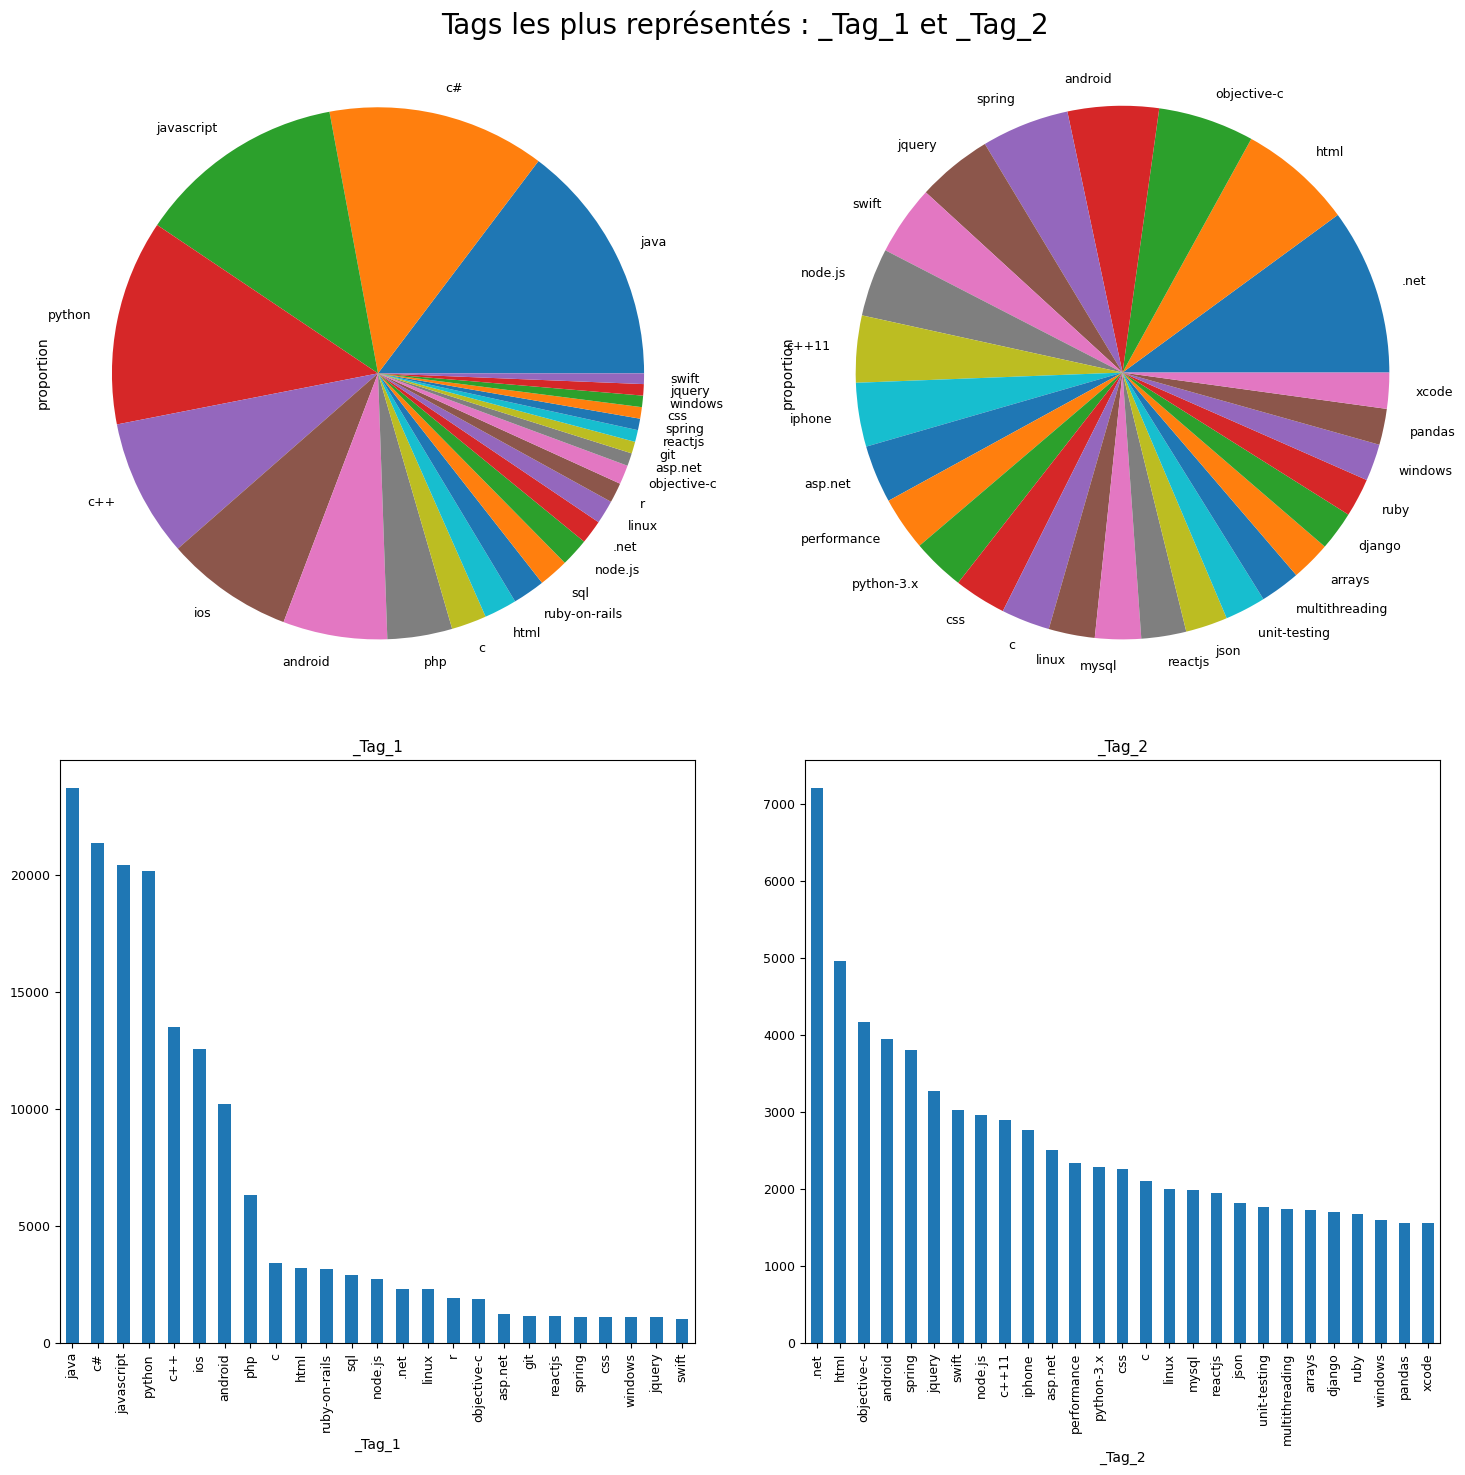

In [38]:
###########################################################
# Visualisation des tags les plus représentés             #
#    - fréquence >= 1000 pour _Tag_1                      #
#    - fréquence >= 1500 pour _Tag_2                      #
###########################################################
df_1_new = df.where(df['_Tag_1'].isin(intervalle_tag_1))
df_2_new = df.where(df['_Tag_2'].isin(intervalle_tag_2))


plt.figure(figsize = (15, 15))
    
# >>>>>>> Pie chart
plt.subplot(2, 2, 1)   # lignes, colonnes
df_1_new['_Tag_1'].value_counts(normalize = True).plot(kind = 'pie', fontsize = 9)
plt.axis('equal')      # Cette ligne assure que le pie chart est un cercle plutôt qu'une ellipse

plt.subplot(2, 2, 2)   # lignes, colonnes
df_2_new['_Tag_2'].value_counts(normalize = True).plot(kind = 'pie', fontsize = 9)
plt.axis('equal')      # Cette ligne assure que le pie chart est un cercle plutôt qu'une ellipse


# >>>>>>> Diagramme en tuyaux d'orgues
plt.subplot(2, 2, 3)   # lignes, colonnes
df_1_new['_Tag_1'].value_counts().plot(kind = 'bar', fontsize = 9)
plt.title('\n\n\n_Tag_1', fontsize = 11)

plt.subplot(2, 2, 4)   # lignes, colonnes
df_2_new['_Tag_2'].value_counts().plot(kind = 'bar', fontsize = 9)
plt.title('\n\n\n_Tag_2', fontsize = 11)

    
plt.suptitle('Tags les plus représentés : _Tag_1 et _Tag_2\n', fontsize = 20)
plt.tight_layout() # pour éviter chevauchement titre et ligne suivante

# 7.1.2. ETUDE DE LA FREQUENCE DE TOUS LES TAGS (VARIABLE CATEGORIELLE)

In [39]:
###############################################################
# => travail par sous-ensemble :                              #
# Calcul fréquence des tags pour un sous-ensemble             #
###############################################################
def calcul_frequence_tag_sous_ensemble(plage_min_in, plage_max_in):
    
    count_tag_1 = []
    count_tag_2 = []

    tag = new_liste_tags[plage_min_in:plage_max_in]    
    
    # Recherche fréquence pour chaque tag. Si absente, on met 0.
    for t in tag:
        if (t in count_Tag_1):
            count_tag_1.append(count_Tag_1[t])
        else:
            count_tag_1.append(0)
        
        if (t in count_Tag_2):
            count_tag_2.append(count_Tag_2[t])
        else:
            count_tag_2.append(0)
        
    print('[plage_min_in : plage_max_in] = [', plage_min_in, ':', plage_max_in, ']')        
    print(len(tag), 'valeurs tag\t\t:', tag)
    print(len(count_tag_1), 'valeurs count_tag_1\t:', count_tag_1)
    print(len(count_tag_2), 'valeurs count_tag_2\t:', count_tag_2)
    
    return tag, count_tag_1, count_tag_2

In [40]:
###############################################################
# Affichage fréquence des tags pour un sous-ensemble          #
###############################################################
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.bar.html
def affichage_frequence_tag_sous_ensemble(plage_min_in, plage_max_in):
    
    tag, count_tag_1, count_tag_2 = calcul_frequence_tag_sous_ensemble(plage_min_in = plage_min_in, 
                                                                       plage_max_in = plage_max_in)

    # Intervalle [plage_min_in : plage_max_in]
    df = pd.DataFrame({' _Tag_1': count_tag_1,
                       ' _Tag_2': count_tag_2}, index = tag)
    ax = df.plot.bar(rot = 90, stacked = True, figsize = (20, 6), fontsize = 14)
    ax.set_title('Fréquence des tags ' + str(plage_min_in) + ' --> ' + str(plage_max_in), fontsize = 20)
    ax.set_xlabel('Tags ' + str(plage_min_in) + ' --> ' + str(plage_max_in), fontsize = 14)
    ax.set_ylabel('Fréquence', fontsize = 14)

[plage_min_in : plage_max_in] = [ 0 : 25 ]
25 valeurs tag		: ['java', 'c#', 'javascript', 'python', 'c++', 'android', 'ios', '.net', 'html', 'php', 'jquery', 'objective-c', 'c', 'node.js', 'iphone', 'css', 'linux', 'asp.net', 'swift', 'spring', 'sql', 'xcode', 'performance', 'ruby-on-rails', 'json']
25 valeurs count_tag_1	: [23731, 21348, 20444, 20164, 13515, 10227, 12553, 2337, 3206, 6356, 1117, 1878, 3442, 2769, 858, 1127, 2309, 1260, 1040, 1127, 2927, 371, 915, 3164, 636]
25 valeurs count_tag_2	: [0, 280, 618, 531, 875, 3957, 1048, 7217, 4968, 1130, 3278, 4172, 2114, 2967, 2773, 2266, 2005, 2511, 3033, 3811, 1041, 1560, 2341, 523, 1823]


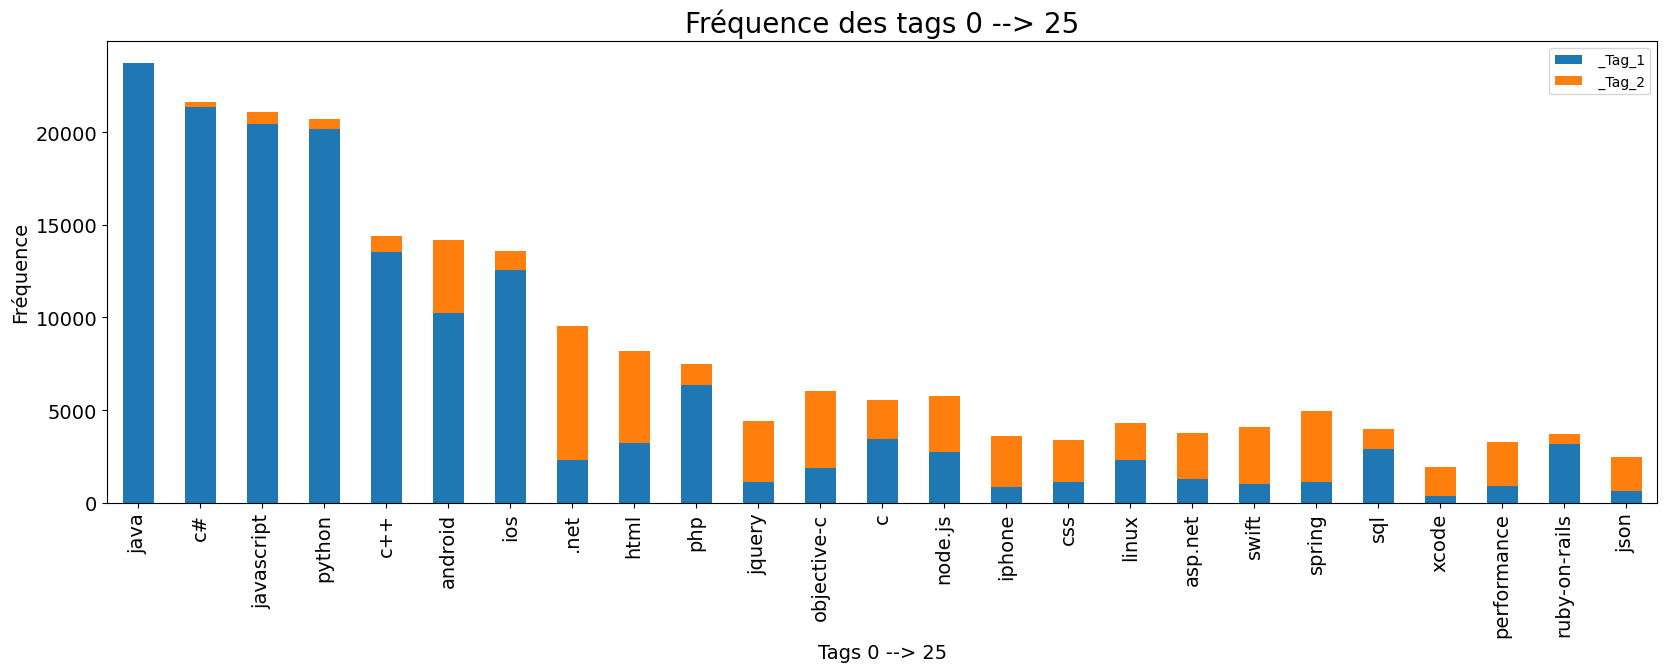

In [65]:
# Intervalle [0 : 25]
affichage_frequence_tag_sous_ensemble(plage_min_in = 0,
                                      plage_max_in = 25)

[plage_min_in : plage_max_in] = [ 26 : 50 ]
24 valeurs tag		: ['windows', 'mysql', 'asp.net-mvc', 'c++11', 'arrays', 'python-3.x', 'multithreading', 'unit-testing', 'django', 'sql-server', 'macos', 'ruby', 'wpf', 'database', 'string', 'algorithm', 'typescript', 'visual-studio', 'angular', 'r', 'spring-boot', 'pandas', 'numpy', 'amazon-web-services']
24 valeurs count_tag_1	: [1120, 736, 640, 76, 338, 446, 266, 547, 622, 635, 780, 628, 574, 443, 288, 900, 899, 450, 676, 1956, 268, 75, 51, 942]
24 valeurs count_tag_2	: [1605, 1997, 1353, 2907, 1727, 2296, 1743, 1772, 1704, 1479, 1371, 1676, 1207, 1026, 1112, 1035, 1127, 1013, 1187, 468, 950, 1568, 1080, 902]


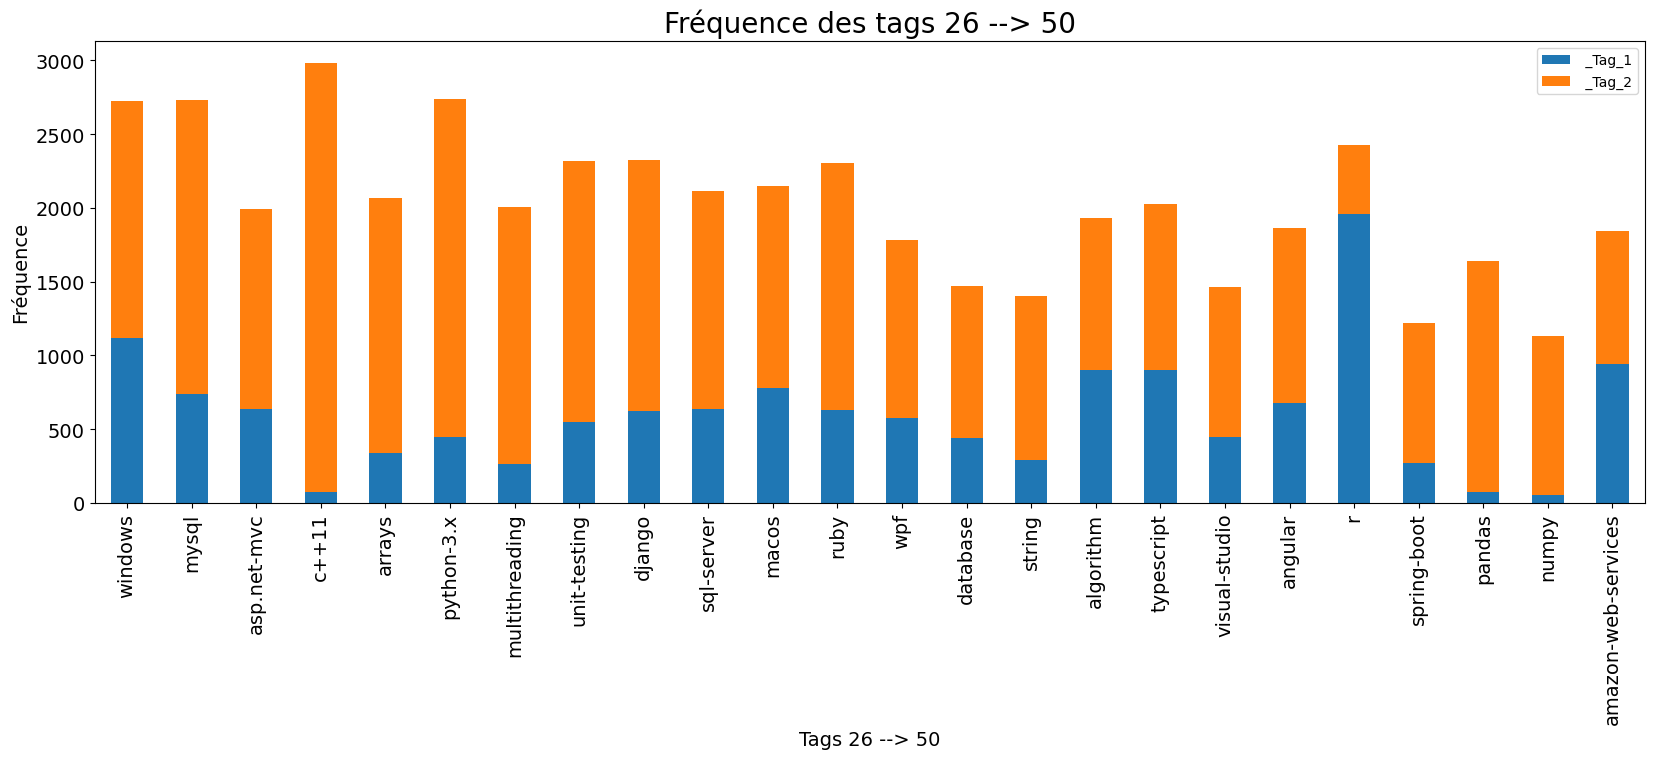

In [66]:
# Intervalle [26 : 50]
affichage_frequence_tag_sous_ensemble(plage_min_in = 26,
                                      plage_max_in = 50)

[plage_min_in : plage_max_in] = [ 51 : 75 ]
24 valeurs tag		: ['angularjs', 'ajax', 'postgresql', 'hibernate', 'rest', 'git', 'image', 'google-chrome', 'xml', 'eclipse', 'asp.net-core', 'docker', 'maven', 'laravel', 'bash', 'entity-framework', 'security', 'http', 'cocoa-touch', 'debugging', 'authentication', 'android-studio', 'testing', 'templates']
24 valeurs count_tag_1	: [346, 108, 304, 176, 381, 1161, 211, 278, 198, 276, 252, 656, 284, 205, 539, 131, 317, 305, 23, 165, 212, 92, 164, 41]
24 valeurs count_tag_2	: [944, 484, 896, 916, 773, 508, 950, 815, 917, 1149, 875, 797, 810, 953, 845, 603, 762, 650, 356, 549, 701, 823, 602, 718]


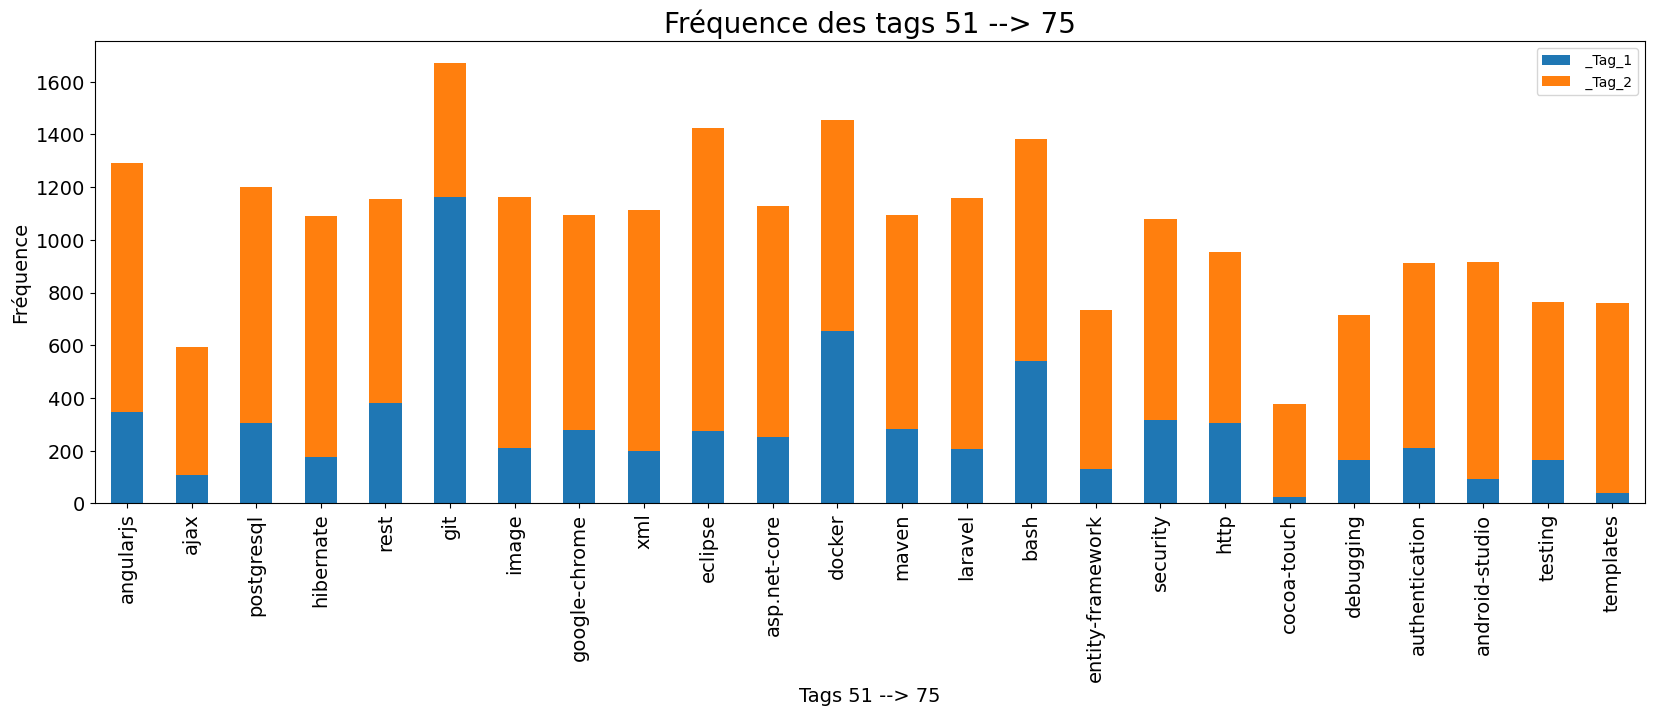

In [67]:
# Intervalle [51 : 75]
affichage_frequence_tag_sous_ensemble(plage_min_in = 51,
                                      plage_max_in = 75)

[plage_min_in : plage_max_in] = [ 76 : 99 ]
23 valeurs tag		: ['firebase', 'machine-learning', 'jpa', 'asynchronous', 'spring-mvc', 'python-2.7', 'shell', 'ssl', 'qt', 'gradle', 'list', 'dataframe', 'winforms', 'ubuntu', 'optimization', 'mongodb', 'assembly', 'api', 'selenium', 'regex', 'cocoa', 'exception', 'twitter-bootstrap']
23 valeurs count_tag_1	: [205, 455, 52, 70, 24, 84, 131, 235, 218, 80, 88, 28, 40, 142, 106, 118, 410, 107, 98, 141, 72, 60, 45]
23 valeurs count_tag_2	: [665, 877, 287, 505, 193, 582, 539, 642, 628, 446, 502, 273, 399, 483, 455, 446, 454, 434, 622, 360, 349, 425, 239]


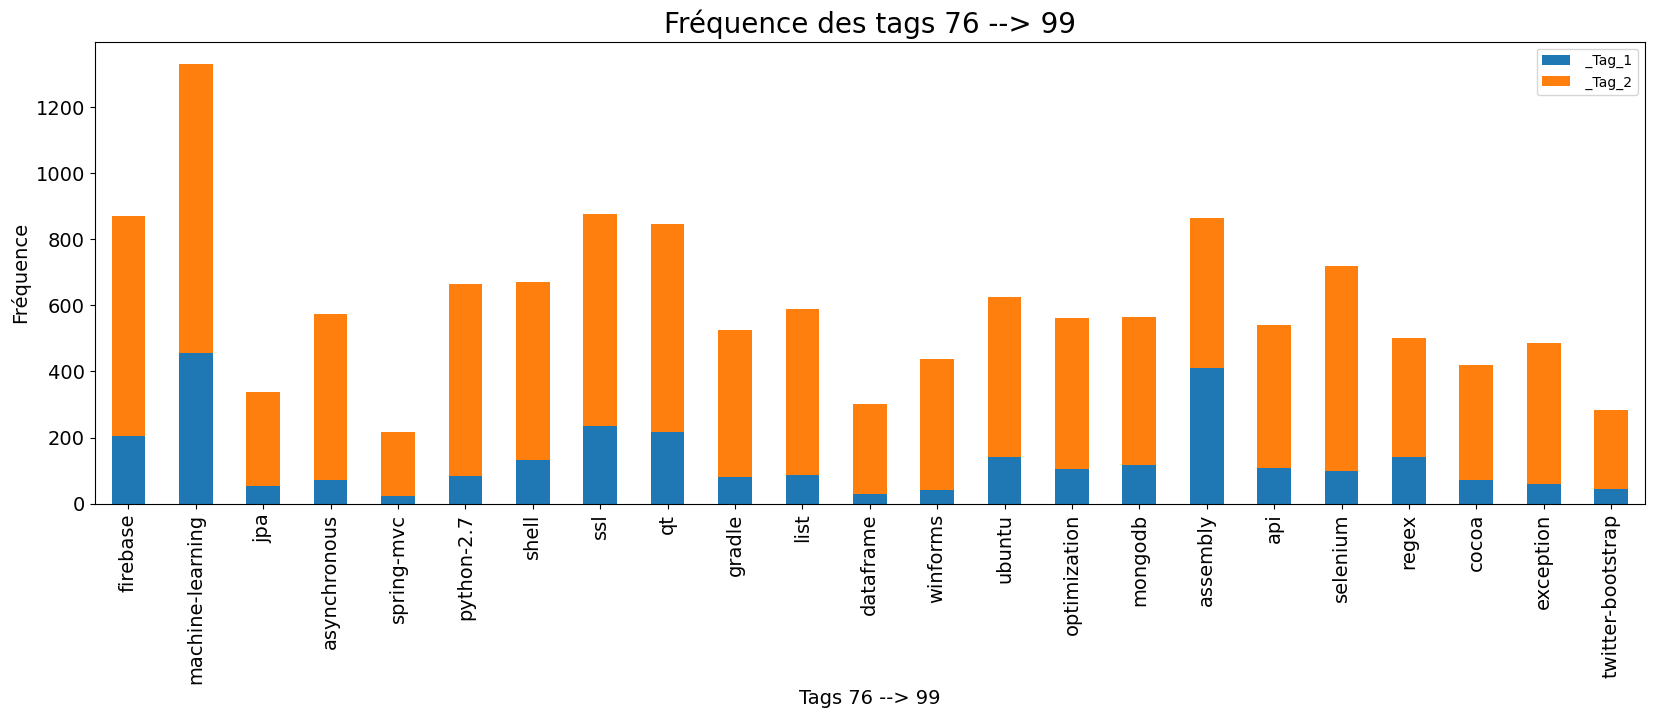

In [68]:
# Intervalle [76 : 99]
affichage_frequence_tag_sous_ensemble(plage_min_in = 76,
                                      plage_max_in = 99)

# 7.1.3. ETUDE DE LA TAILLE DES NOMS DE TAG (VARIABLE QUANTITATIVE)

In [69]:
len_Tag_1 = df['_Tag_1'].str.len() # longueur _Tag_1
len_Tag_2 = df['_Tag_2'].str.len() # longueur _Tag_2

In [70]:
# _Tag_1 : compris entre 1 et 19 caractères
len_Tag_1.describe().transpose()

count    185226.000000
mean          5.412210
std           3.190473
min           1.000000
25%           3.000000
50%           4.000000
75%           7.000000
max          19.000000
Name: _Tag_1, dtype: float64

In [71]:
# _Tag_2 : compris entre 1 et 19 caractères
len_Tag_2.describe().transpose()

count    185226.000000
mean          4.893433
std           3.878162
min           1.000000
25%           1.000000
50%           4.000000
75%           7.000000
max          19.000000
Name: _Tag_2, dtype: float64

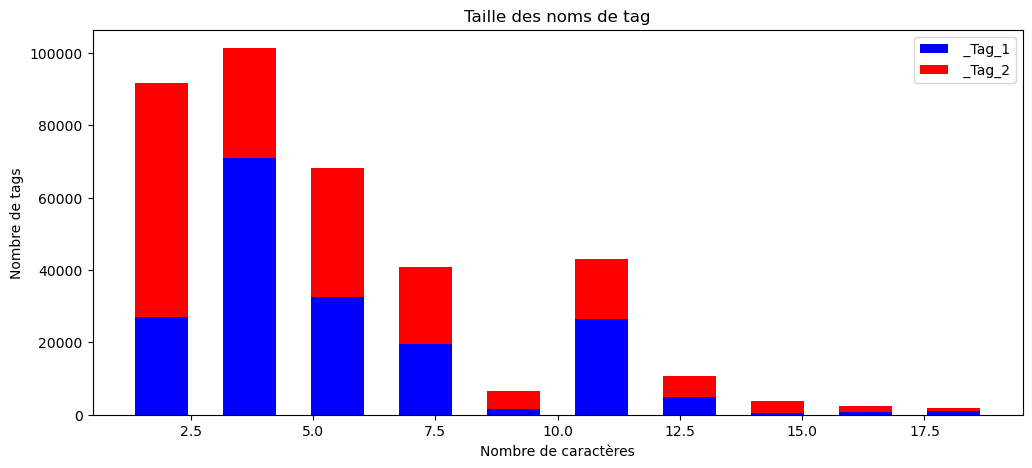

In [72]:
# http://python-simple.com/python-matplotlib/histogram.php
plt.figure(figsize = (12, 5))  # longueur, hauteur
plt.hist([len_Tag_1, len_Tag_2], color = ['blue', 'red'], label = [' _Tag_1', ' _Tag_2'], 
         rwidth = 0.6, histtype = 'barstacked')

plt.legend(loc = 'upper right')
plt.xlabel('Nombre de caractères')
plt.ylabel('Nombre de tags')
plt.title('Taille des noms de tag')
plt.show()

# 7.2. ANALYSE UNIVARIEE TEXTE

In [ ]:
# Rappel des variables :
#  --> corpus_text = ' '.join(df['_Text_clean'])
#  --> token_text = corpus_text.split()
#  --> count_text = pd.Series(token_text).value_counts()

# 7.2.1. ETUDE DE LA FREQUENCE DES MOTS (VARIABLE QUANTITATIVE)

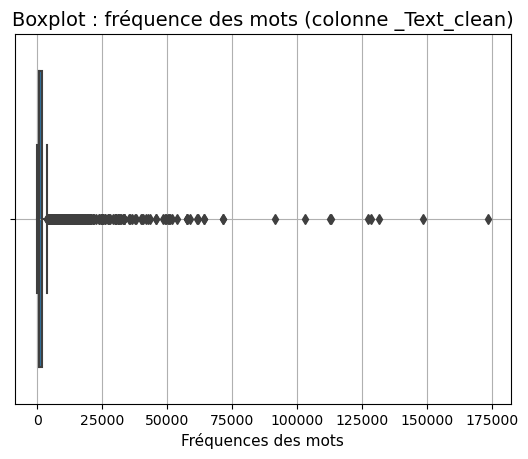

In [81]:
###########################################
# Boxplot fréquence des mots              #
###########################################
# Tout le corpus
ax1 = sns.boxplot(data = df, 
                  x    = count_text)
ax1.set_xlabel('Fréquences des mots', fontsize = 11)
plt.title('Boxplot : fréquence des mots (colonne _Text_clean)', fontsize = 14)
plt.grid(True)

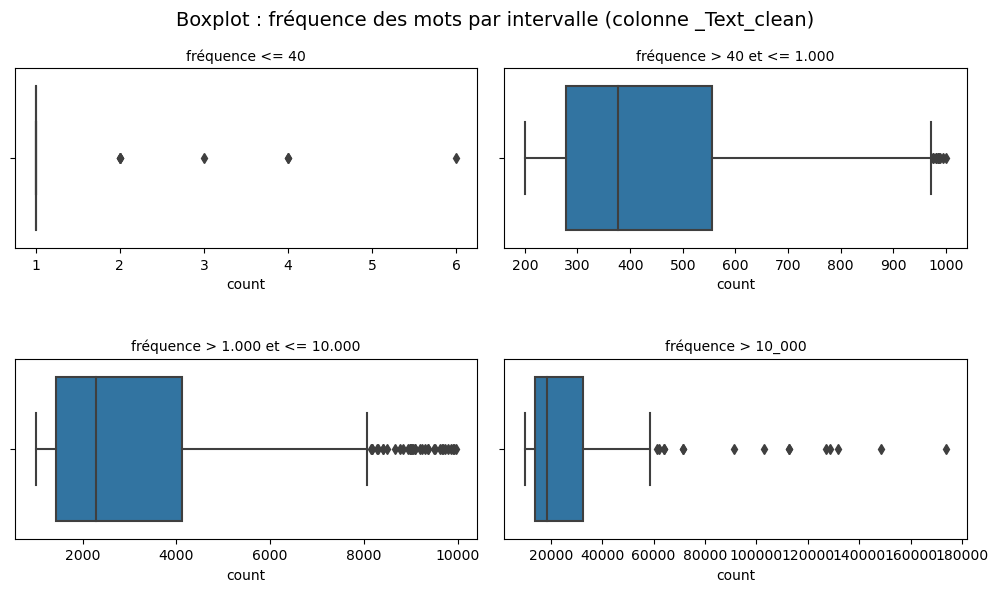

In [76]:
####################################################
# Boxplot fréquence des mots : zoom par intervalle #
####################################################
# Visualisation des données en un seul schéma
fig = plt.figure(figsize = (10, 6))  # Width, height

# Fréquence <= 40
ax = fig.add_subplot(2, 2, 1)   # lignes, colonnes
count_corpus_box = count_text[(count_text <= 40)]    
sns.boxplot(data = df,
            x    = count_corpus_box)
ax.set_title('fréquence <= 40', fontsize = 10)

# Fréquence > 40 et <= 1.000
ax = fig.add_subplot(2, 2, 2)   # lignes, colonnes
count_corpus_box = count_text[(count_text > 40) & (count_text <= 1_000)]    
sns.boxplot(data = df,
            x    = count_corpus_box)
ax.set_title('fréquence > 40 et <= 1.000', fontsize = 10)

# Fréquence > 1.000 et <= 10.000
ax = fig.add_subplot(2, 2, 3)   # lignes, colonnes
count_corpus_box = count_text[(count_text > 1_000) & (count_text <= 10_000)]    
sns.boxplot(data = df,
            x    = count_corpus_box)
ax.set_title('\n\nfréquence > 1.000 et <= 10.000', fontsize = 10)

# Fréquence > 10_000
ax = fig.add_subplot(2, 2, 4) 
count_corpus_box = count_text[(count_text > 10_000)]    
sns.boxplot(data = df,
            x    = count_corpus_box)
ax.set_title('\n\nfréquence > 10_000', fontsize = 10)

    
fig.suptitle('Boxplot : fréquence des mots par intervalle (colonne _Text_clean)', fontsize = 14)
fig.tight_layout() # pour éviter chevauchement titre et ligne suivante

# 7.2.2. ETUDE DE LA LONGUEUR DES DOCUMENTS (VARIABLE QUANTITATIVE)

In [77]:
# Longueur documents
len_Text_clean = df['_Text_clean'].str.len()

In [82]:
# on stocke ce vecteur numérique dans une colonne préfixée par _
df['_len_Text_clean'] = len_Text_clean

# output de sortie pour contrôler que l'opération s'est bien effectuée.
df.describe(include = np.number)

# la grande majorité des messages (50%) fait 147 caractères.
# Certains ont une taille très élevée (8932).

Id          Score    AnswerCount      _len_Text  \
count  1.852260e+05  185226.000000  185226.000000  185226.000000   
mean   2.754479e+07      23.895582       3.338549    1993.152198   
std    1.931196e+07     135.977743       3.416365    2329.653708   
min    4.000000e+00       6.000000       1.000000      84.000000   
25%    1.030762e+07       7.000000       1.000000     795.000000   
50%    2.517016e+07      10.000000       2.000000    1329.000000   
75%    4.254640e+07      17.000000       4.000000    2302.000000   
max    7.640311e+07   27009.000000     134.000000   48697.000000   

       _len_Text_clean  
count    185226.000000  
mean        307.436359  
std         412.812428  
min           2.000000  
25%         110.000000  
50%         192.000000  
75%         348.000000  
max       11383.000000

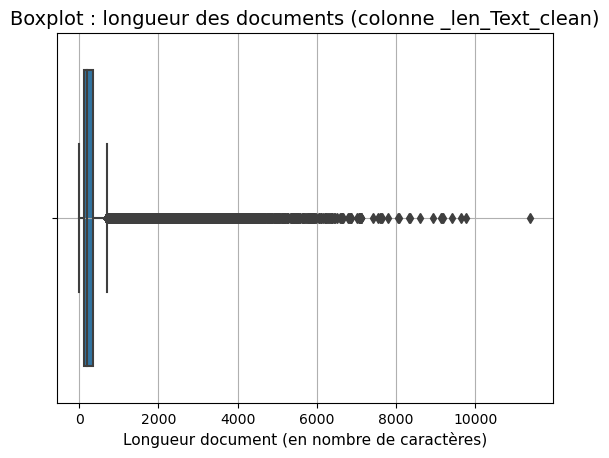

In [83]:
###########################################
# Boxplot longueur de chaque document     #
###########################################
ax1 = sns.boxplot(data = df,
                  x    = '_len_Text_clean')
ax1.set_xlabel('Longueur document (en nombre de caractères)', fontsize = 11)
plt.title('Boxplot : longueur des documents (colonne _len_Text_clean)', fontsize = 14)
plt.grid(True)

Text(0.5, 0.98, 'Displot : longueur des documents (colonne _len_Text_clean)')

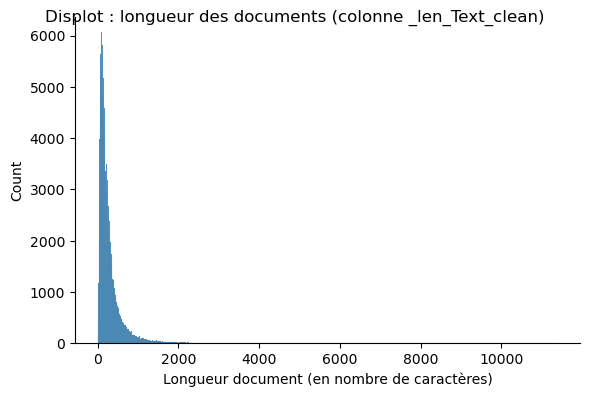

In [84]:
###########################################
# Displot longueur de chaque document     #
###########################################
# https://www.delftstack.com/fr/howto/seaborn/seaborn-font-size/
ax2 = sns.displot(data   = df, 
                  x      = '_len_Text_clean', 
                  height = 4, 
                  aspect = 1.5) # height = 4, width = 1.5 times larger than height

ax2.set_axis_labels('Longueur document (en nombre de caractères)', 'Count')
ax2.fig.suptitle('Displot : longueur des documents (colonne _len_Text_clean)')

# 7.3. FREQUENCE DISTRIBUTION (VARIABLE CATEGORIELLE)

In [85]:
# Stockage de la fréquence de distribution des sous-dataframes dans des dictionnaires
# >>>>>>>  Colonne _Stemmer_clean 
most_common_stemmer_1_gram      = {} # 1-gram
most_common_stemmer_1_gram_word = {} # 1-gram
most_common_stemmer_2_gram      = {} # 2-gram
most_common_stemmer_2_gram_word = {} # 2-gram

# >>>>>>> Colonne _Lemma_clean 
most_common_lemma_3_gram      = {} # 3-gram
most_common_lemma_3_gram_word = {} # 3-gram

In [86]:
####################################################
#   Fréquence distribution, niveau sous-dataframe  # 
####################################################
# https://askcodez.com/comptage-de-n-grammes-de-frequence-en-python-nltk.html
# https://www.askpython.com/python/examples/n-grams-python-nltk
def frequence_distribution_sous_dataframe(n_gram_in, operation_in, cle_in, colonne_in, most_common_in):
    
    most_common_word = []
    
    # Liste des index du sous-dataframe (ne commence pas forcément à 0, car filtré)
    liste_index = dict_df[cle_in].index.to_list()

    print('n_gram_in\t=', n_gram_in,
          '\noperation_in\t=', operation_in,
          '\ncle_in\t\t=', cle_in,
          '\ncolonne_in\t=', colonne_in, '\n')
    
    for index, row in dict_df[cle_in].iterrows():
        token = word_tokenize(row[colonne_in])
        
        # ngram
        if (n_gram_in == 1):
            n_grams = token
        else:
            n_grams = ngrams(token, n_gram_in)
        
        # Frequence distribution
        if (index == liste_index[0]):  # premier index du sous-dataframe
            ngram_fdist = FreqDist(n_grams)            
        elif (operation_in == '+'):
            ngram_fdist = ngram_fdist + FreqDist(n_grams)
        elif (operation_in == '&'):
            ngram_fdist = ngram_fdist & FreqDist(n_grams)            

    # most_common_in most common words
    most_common = ngram_fdist.most_common(most_common_in)
    print(most_common_in, 'most_common :', most_common, '\n')
    
    
    # Extraction liste des mots les plus communs dans une liste
    # Remarque : ind[0] = mot, ind[1] = valeur
    for ind in most_common:
        most_common_word.append(ind[0])
    print('most_common_word =', most_common_word)
    
    return most_common, most_common_word

In [87]:
#################################################
#      Affichage fréquence distribution         #
#################################################
# Couleurs  : https://matplotlib.org/stable/gallery/color/named_colors.html
# Marqueurs : https://matplotlib.org/stable/api/markers_api.html
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html
def affichage_frequence_distribution_sous_dataframe(most_common_n_gram_in, 
                                                    name_in, 
                                                    cle_1_in, 
                                                    cle_2_in, 
                                                    intersection_cles_in):
    
    most_common_1 = most_common_n_gram_in[cle_1_in]
    most_common_2 = most_common_n_gram_in[cle_2_in]
  
    count1 = 0 
    count2 = 0     
    
    fig = plt.figure(figsize = (7, 4))  # Width, height
    
    # Maj couleurs : 1 couleur / clé
    # >>>>>>> Couleur 1    
    if (cle_1_in == 'java'):
        color_1 = 'blue'
    elif (cle_1_in == 'c#'):
        color_1 = 'red'
    elif (cle_1_in == 'javascript'):
        color_1 = 'lime'
    elif (cle_1_in == 'python'):
        color_1 = 'orange'        
    elif (cle_1_in == 'c++'):
        color_1 = 'fuchsia'
        
    # >>>>>>> Couleur 2
    if (cle_2_in == 'java'):
        color_2 = 'blue'
    elif (cle_2_in == 'c#'):
        color_2 = 'red'
    elif (cle_2_in == 'javascript'):
        color_2 = 'lime'
    elif (cle_2_in == 'python'):
        color_2 = 'orange'        
    elif (cle_2_in == 'c++'):
        color_2 = 'fuchsia'        

    
    # *******************************************
    # * Liste 1                                 *
    # *******************************************    
    for ind_1 in most_common_1: # liste de tuples
        if (ind_1[0] in intersection_cles_in):
            if (count1 == 0): # Premier passage : légende marquée une fois
                if ('1-gram' in name_in): # 1-gram
                    plt.plot(ind_1[0], ind_1[1], color = color_1, marker = 'o', linestyle = 'dashed', label = cle_1_in)
                else: # n-gram != 1
                    plt.plot(' '.join(ind_1[0]), ind_1[1], color = color_1, marker = 'o', 
                             linestyle = 'dashed', label = cle_1_in)
                count1 = 1
            else:
                if ('1-gram' in name_in): # 1-gram
                    plt.plot(ind_1[0], ind_1[1], color = color_1, marker = 'o', linestyle = 'dashed')
                else: # n-gram != 1
                    plt.plot(' '.join(ind_1[0]), ind_1[1], color = color_1, marker = 'o', 
                             linestyle = 'dashed')
            
            
    # *******************************************
    # * Liste 2                                 *
    # *******************************************
    for ind_2 in most_common_2: # liste de tuples
        if (ind_2[0] in intersection_cles_in):
            if (count2 == 0):  # Premier passage : légende marquée une fois
                if ('1-gram' in name_in): # 1-gram                
                    plt.plot(ind_2[0], ind_2[1], color = color_2, marker = 'o', linestyle = 'dashed', label = cle_2_in)
                else: # n-gram != 1
                    plt.plot(' '.join(ind_2[0]), ind_2[1], color = color_2, marker = 'o', 
                             linestyle = 'dashed', label = cle_2_in)
                count2 = 1
            else:
                if ('1-gram' in name_in): # 1-gram                
                    plt.plot(ind_2[0], ind_2[1], color = color_2, marker = 'o', linestyle = 'dashed') 
                else: # n-gram != 1
                    plt.plot(' '.join(ind_2[0]), ind_2[1], color = color_2, marker = 'o', 
                             linestyle = 'dashed')
                    
    plt.legend(loc = 'upper right')
    plt.xlabel('Mots')
    plt.xticks(rotation = 90) # légende axe des x verticale
    plt.ylabel('Fréquence')
    plt.title(name_in + ' : ' + str(len(intersection_cles_in)) + ' mots les plus communs entre ' + cle_1_in + 
              ' et ' + cle_2_in + ' ')
    plt.show()

# 7.3.1. FREQUENCE DISTRIBUTION COLONNE _STEMMER_CLEAN POUR 1-GRAM

In [88]:
# Maj paramètres communs
n_gram      = 1
operation   = '+'
colonne     = '_Stemmer_clean_final'
most_common = 50

In [89]:
# java
most_common_stemmer_1_gram['java'], most_common_stemmer_1_gram_word['java'] = \
frequence_distribution_sous_dataframe(n_gram_in      = n_gram,
                                      operation_in   = operation,
                                      cle_in         = 'java', 
                                      colonne_in     = colonne, 
                                      most_common_in = most_common)

n_gram_in	= 1 
operation_in	= + 
cle_in		= java 
colonne_in	= _Stemmer_clean 

50 most_common : [('java', 120192), ('public', 40968), ('class', 37376), ('string', 32209), ('android', 31030), ('spring', 22921), ('apach', 19323), ('version', 19135), ('jar', 18334), ('return', 18286), ('privat', 17423), ('file', 16973), ('void', 16261), ('import', 16092), ('get', 16054), ('web', 15305), ('hibern', 13295), ('final', 12211), ('null', 12186), ('except', 11463), ('core', 11196), ('sun', 10773), ('server', 10736), ('system', 10666), ('list', 10555), ('intern', 10305), ('object', 10287), ('static', 9988), ('secur', 9790), ('boot', 9723), ('project', 9711), ('set', 9462), ('releas', 9201), ('build', 9096), ('configur', 8590), ('eclips', 8496), ('servic', 8227), ('add', 8175), ('time', 7811), ('execut', 7666), ('bean', 7494), ('client', 7238), ('request', 7037), ('connect', 6830), ('view', 6810), ('layout', 6661), ('key', 6464), ('invok', 6457), ('factori', 6015), ('catalina', 5955)] 

most_commo

In [71]:
# c#
most_common_stemmer_1_gram['c#'], most_common_stemmer_1_gram_word['c#'] = \
frequence_distribution_sous_dataframe(n_gram_in      = n_gram,
                                      operation_in   = operation,
                                      cle_in         = 'c#', 
                                      colonne_in     = colonne, 
                                      most_common_in = most_common)

n_gram_in	= 1 
operation_in	= + 
cle_in		= c# 
colonne_in	= _Stemmer_clean 

50 most_common : [('asp', 7395), ('entiti', 4785), ('visual', 4548), ('bind', 4505), ('await', 4432), ('studio', 4287), ('assembl', 4085), ('gener', 3828), ('control', 3674), ('bool', 3451), ('action', 3287), ('express', 3060), ('secur', 2656), ('token', 2649), ('grid', 2614), ('collect', 2456), ('authent', 2453), ('password', 2434), ('click', 2369), ('doubl', 2358), ('ident', 2281), ('div', 2241), ('throw', 2201), ('catch', 2187), ('overrid', 2172), ('sender', 2143), ('oper', 2007), ('dispos', 1942), ('cultur', 1905), ('valid', 1892), ('column', 1882), ('dictionari', 1840), ('serial', 1822), ('design', 1816), ('author', 1786), ('session', 1775), ('depend', 1774), ('summari', 1756), ('mono', 1755), ('android', 1754), ('document', 1739), ('azur', 1719), ('person', 1709), ('td', 1690), ('constructor', 1685), ('titl', 1608), ('product', 1582), ('descript', 1558), ('provid', 1556), ('repositori', 1549)] 

most_com

In [72]:
# javascript
most_common_stemmer_1_gram['javascript'], most_common_stemmer_1_gram_word['javascript'] = \
frequence_distribution_sous_dataframe(n_gram_in      = n_gram,
                                      operation_in   = operation,
                                      cle_in         = 'javascript', 
                                      colonne_in     = colonne, 
                                      most_common_in = most_common)

n_gram_in	= 1 
operation_in	= + 
cle_in		= javascript 
colonne_in	= _Stemmer_clean 

50 most_common : [('div', 25436), ('react', 11093), ('document', 7909), ('click', 6613), ('compon', 6448), ('browser', 6053), ('td', 5946), ('angular', 5846), ('chrome', 5784), ('li', 5463), ('titl', 4905), ('err', 4347), ('span', 4278), ('render', 3951), ('label', 3706), ('canva', 3645), ('prop', 3373), ('export', 3343), ('bootstrap', 3331), ('token', 3015), ('loader', 3000), ('alert', 2980), ('promis', 2902), ('nativ', 2846), ('dom', 2732), ('express', 2732), ('resolv', 2716), ('modal', 2712), ('action', 2617), ('login', 2578), ('router', 2560), ('undefin', 2508), ('babel', 2357), ('scroll', 2294), ('select', 2269), ('submit', 2253), ('rout', 2221), ('control', 2188), ('await', 2160), ('font', 2151), ('anim', 2125), ('password', 2046), ('android', 2021), ('tab', 2014), ('rel', 1975), ('push', 1944), ('navig', 1931), ('border', 1905), ('site', 1878), ('menu', 1827)] 

most_common_word = ['div', 'react

In [73]:
# python
most_common_stemmer_1_gram['python'], most_common_stemmer_1_gram_word['python'] = \
frequence_distribution_sous_dataframe(n_gram_in      = n_gram,
                                      operation_in   = operation,
                                      cle_in         = 'python', 
                                      colonne_in     = colonne, 
                                      most_common_in = most_common)

n_gram_in	= 1 
operation_in	= + 
cle_in		= python 
colonne_in	= _Stemmer_clean 

50 most_common : [('site', 9236), ('train', 6904), ('pip', 5160), ('column', 5083), ('rang', 4282), ('shape', 4190), ('plot', 4140), ('flask', 3636), ('session', 3461), ('loss', 3389), ('len', 3124), ('gener', 3009), ('recent', 2967), ('matrix', 2934), ('append', 2853), ('activ', 2658), ('nan', 2640), ('batch', 2579), ('fit', 2560), ('label', 2539), ('password', 2245), ('titl', 2198), ('selenium', 2197), ('learn', 2180), ('spark', 2138), ('lambda', 2102), ('rais', 2076), ('sum', 2061), ('group', 2060), ('manag', 2001), ('token', 1998), ('axi', 1919), ('driver', 1911), ('div', 1904), ('ax', 1904), ('iter', 1872), ('split', 1849), ('except', 1841), ('float', 1760), ('log', 1699), ('calcul', 1646), ('apach', 1623), ('valid', 1605), ('comput', 1604), ('celeri', 1593), ('predict', 1572), ('temp', 1467), ('anaconda', 1463), ('login', 1459), ('binari', 1454)] 

most_common_word = ['site', 'train', 'pip', 'column'

In [74]:
# c++
most_common_stemmer_1_gram['c++'], most_common_stemmer_1_gram_word['c++'] = \
frequence_distribution_sous_dataframe(n_gram_in      = n_gram,
                                      operation_in   = operation,
                                      cle_in         = 'c++', 
                                      colonne_in     = colonne, 
                                      most_common_in = most_common)

n_gram_in	= 1 
operation_in	= + 
cle_in		= c++ 
colonne_in	= _Stemmer_clean 

50 most_common : [('boost', 9017), ('char', 7990), ('vector', 7763), ('oper', 5588), ('doubl', 4860), ('clang', 4285), ('float', 4105), ('pointer', 3607), ('unsign', 3399), ('bool', 3148), ('constructor', 2862), ('member', 2699), ('visual', 2672), ('declar', 2557), ('alloc', 2506), ('cast', 2477), ('virtual', 2428), ('studio', 2204), ('uniqu', 2094), ('undefin', 2054), ('gener', 2033), ('begin', 1984), ('lock', 1962), ('gnu', 1961), ('atom', 1772), ('express', 1766), ('deriv', 1716), ('releas', 1698), ('push', 1647), ('lambda', 1534), ('assert', 1520), ('consid', 1445), ('link', 1428), ('forward', 1333), ('pair', 1333), ('matrix', 1322), ('free', 1313), ('android', 1284), ('integ', 1237), ('definit', 1216), ('special', 1215), ('rang', 1170), ('assign', 1159), ('mat', 1149), ('optim', 1134), ('execut', 1119), ('convers', 1110), ('algorithm', 1099), ('constant', 1093), ('bug', 1083)] 

most_common_word = ['boos

In [75]:
###################################################
#    Intersection entre les 5 sous-dataframes     #
###################################################
# https://www.cours-gratuit.com/tutoriel-python/tutoriel-python-trouver-lintersection-de-deux-listes
set_java_stemmer_1_gram        = set(most_common_stemmer_1_gram_word['java'])
set_c_sharp_stemmer_1_gram     = set(most_common_stemmer_1_gram_word['c#']) 
set_javascript_stemmer_1_gram  = set(most_common_stemmer_1_gram_word['javascript']) 
set_python_stemmer_1_gram      = set(most_common_stemmer_1_gram_word['python']) 
set_c_plus_plus_stemmer_1_gram = set(most_common_stemmer_1_gram_word['c++']) 

intersection_java_c_sharp_stemmer_1_gram     = list(set_java_stemmer_1_gram & set_c_sharp_stemmer_1_gram)
intersection_java_javascript_stemmer_1_gram  = list(set_java_stemmer_1_gram & set_javascript_stemmer_1_gram)
intersection_java_python_stemmer_1_gram      = list(set_java_stemmer_1_gram & set_python_stemmer_1_gram)
intersection_java_c_plus_plus_stemmer_1_gram = list(set_java_stemmer_1_gram & set_c_plus_plus_stemmer_1_gram)
intersection_all_stemmer_1_gram              = list(set_java_stemmer_1_gram & set_c_sharp_stemmer_1_gram & \
                                                    set_javascript_stemmer_1_gram & set_python_stemmer_1_gram & \
                                                    set_c_plus_plus_stemmer_1_gram)

print('intersection_java_c_sharp_stemmer_1_gram\t=', intersection_java_c_sharp_stemmer_1_gram)
print('intersection_java_javascript_stemmer_1_gram\t=', intersection_java_javascript_stemmer_1_gram)
print('intersection_java_python_stemmer_1_gram\t\t=', intersection_java_python_stemmer_1_gram)
print('intersection_java_c_plus_plus_stemmer_1_gram\t=', intersection_java_c_plus_plus_stemmer_1_gram)
print('intersection_all_stemmer_1_gram\t\t\t=', intersection_all_stemmer_1_gram)

intersection_java_c_sharp_stemmer_1_gram	= ['authent', 'doubl', 'session', 'secur', 'collect', 'android', 'column', 'control', 'gener', 'entiti', 'catch', 'action', 'depend', 'repositori', 'overrid', 'password']
intersection_java_javascript_stemmer_1_gram	= ['android', 'control', 'nativ', 'compon', 'action', 'password']
intersection_java_python_stemmer_1_gram		= ['log', 'session', 'apach', 'column', 'gener', 'driver', 'activ', 'manag', 'password']
intersection_java_c_plus_plus_stemmer_1_gram	= ['android', 'gener', 'doubl', 'integ', 'releas']
intersection_all_stemmer_1_gram			= []


In [ ]:
####################################################
#       Affichage fréquence distribution           #
####################################################

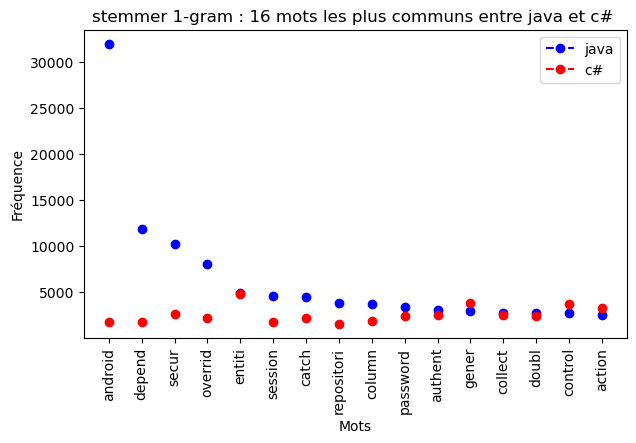

In [76]:
# Intersection mots java / c#
affichage_frequence_distribution_sous_dataframe(most_common_n_gram_in = most_common_stemmer_1_gram,
                                                name_in               = 'stemmer 1-gram',
                                                cle_1_in              = 'java', 
                                                cle_2_in              = 'c#',
                                                intersection_cles_in  = intersection_java_c_sharp_stemmer_1_gram)

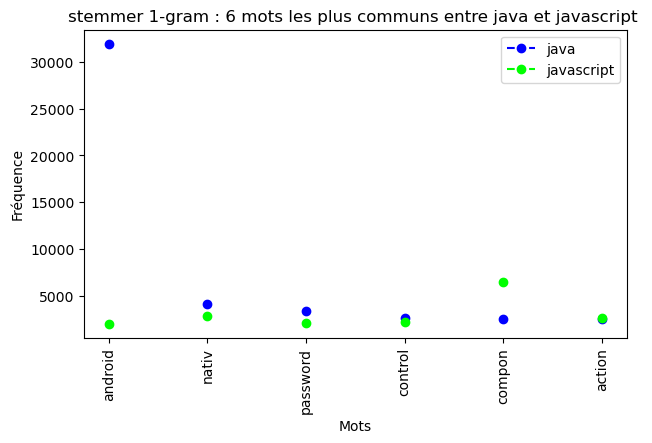

In [77]:
# Intersection mots java / javascript
affichage_frequence_distribution_sous_dataframe(most_common_n_gram_in = most_common_stemmer_1_gram,
                                                name_in               = 'stemmer 1-gram',
                                                cle_1_in              = 'java', 
                                                cle_2_in              = 'javascript',
                                                intersection_cles_in  = intersection_java_javascript_stemmer_1_gram)

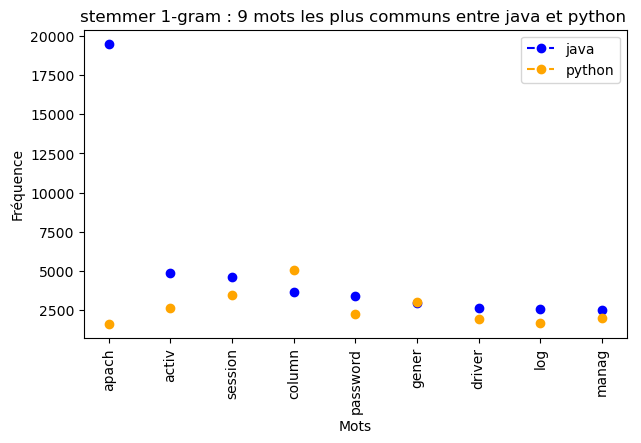

In [78]:
# Intersection mots java / python
affichage_frequence_distribution_sous_dataframe(most_common_n_gram_in = most_common_stemmer_1_gram,
                                                name_in               = 'stemmer 1-gram',
                                                cle_1_in              = 'java', 
                                                cle_2_in              = 'python',
                                                intersection_cles_in  = intersection_java_python_stemmer_1_gram)

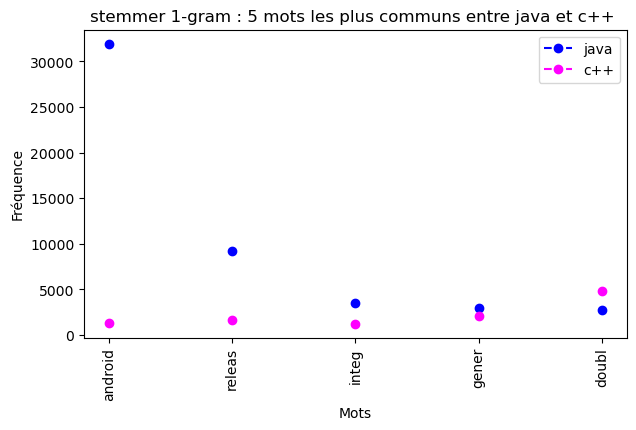

In [79]:
# Intersection mots java / c++
affichage_frequence_distribution_sous_dataframe(most_common_n_gram_in = most_common_stemmer_1_gram,
                                                name_in               = 'stemmer 1-gram',
                                                cle_1_in              = 'java', 
                                                cle_2_in              = 'c++',
                                                intersection_cles_in  = intersection_java_c_plus_plus_stemmer_1_gram)

# 7.3.2. FREQUENCE DISTRIBUTION COLONNE _STEMMER_CLEAN POUR 2-GRAM

In [80]:
# Maj paramètres communs
n_gram      = 2
operation   = '+'
colonne     = '_Stemmer_clean_final'
most_common = 50

In [81]:
# java
most_common_stemmer_2_gram['java'], most_common_stemmer_2_gram_word['java'] = \
frequence_distribution_sous_dataframe(n_gram_in      = n_gram,
                                      operation_in   = operation,
                                      cle_in         = 'java', 
                                      colonne_in     = colonne, 
                                      most_common_in = most_common)

n_gram_in	= 2 
operation_in	= + 
cle_in		= java 
colonne_in	= _Stemmer_clean 

50 most_common : [(('android', 'android'), 13954), (('spring', 'boot'), 5771), (('apach', 'catalina'), 5379), (('depend', 'depend'), 4898), (('releas', 'jar'), 3405), (('hibern', 'hibern'), 3401), (('jar', 'releas'), 3286), (('reflect', 'invok'), 2962), (('jar', 'jar'), 2880), (('sun', 'reflect'), 2776), (('boot', 'spring'), 2601), (('spring', 'releas'), 2588), (('catalina', 'apach'), 2336), (('factori', 'factori'), 2289), (('apach', 'apach'), 2256), (('final', 'final'), 2104), (('spring', 'spring'), 1803), (('secur', 'secur'), 1797), (('spring', 'secur'), 1688), (('bean', 'bean'), 1655), (('schema', 'schema'), 1544), (('sun', 'sun'), 1515), (('boot', 'starter'), 1483), (('invok', 'apach'), 1401), (('apach', 'tomcat'), 1362), (('final', 'jar'), 1298), (('eclips', 'eclips'), 1279), (('jar', 'final'), 1248), (('session', 'session'), 1182), (('android', 'wrap'), 1169), (('wrap', 'android'), 1133), (('invok', 's

In [82]:
# c#
most_common_stemmer_2_gram['c#'], most_common_stemmer_2_gram_word['c#'] = \
frequence_distribution_sous_dataframe(n_gram_in      = n_gram,
                                      operation_in   = operation,
                                      cle_in         = 'c#', 
                                      colonne_in     = colonne, 
                                      most_common_in = most_common) # 35 min

n_gram_in	= 2 
operation_in	= + 
cle_in		= c# 
colonne_in	= _Stemmer_clean 

50 most_common : [(('visual', 'studio'), 4114), (('cultur', 'neutral'), 1327), (('bind', 'bind'), 1155), (('td', 'td'), 1003), (('asp', 'asp'), 998), (('entiti', 'entiti'), 959), (('div', 'div'), 957), (('grid', 'grid'), 871), (('await', 'await'), 840), (('doubl', 'doubl'), 813), (('assembl', 'assembl'), 737), (('catch', 'ex'), 637), (('express', 'express'), 626), (('mono', 'mono'), 589), (('android', 'android'), 581), (('person', 'person'), 578), (('control', 'action'), 562), (('action', 'action'), 554), (('bool', 'bool'), 517), (('dictionari', 'dictionari'), 508), (('click', 'sender'), 493), (('control', 'control'), 490), (('summari', 'summari'), 486), (('builder', 'builder'), 479), (('password', 'password'), 453), (('token', 'token'), 428), (('reader', 'reader'), 416), (('depend', 'inject'), 406), (('ex', 'ex'), 403), (('document', 'document'), 396), (('dispos', 'dispos'), 391), (('session', 'session'), 379

In [83]:
# javascript
most_common_stemmer_2_gram['javascript'], most_common_stemmer_2_gram_word['javascript'] = \
frequence_distribution_sous_dataframe(n_gram_in      = n_gram,
                                      operation_in   = operation,
                                      cle_in         = 'javascript', 
                                      colonne_in     = colonne, 
                                      most_common_in = most_common) # 35 min

n_gram_in	= 2 
operation_in	= + 
cle_in		= javascript 
colonne_in	= _Stemmer_clean 

50 most_common : [(('div', 'div'), 10257), (('td', 'td'), 4098), (('li', 'li'), 2886), (('react', 'react'), 2052), (('react', 'nativ'), 1776), (('err', 'err'), 1631), (('document', 'document'), 1272), (('angular', 'angular'), 1253), (('loader', 'loader'), 1209), (('span', 'span'), 1198), (('canva', 'canva'), 1046), (('th', 'th'), 983), (('titl', 'titl'), 938), (('document', 'readi'), 902), (('label', 'label'), 900), (('compon', 'compon'), 874), (('react', 'compon'), 839), (('div', 'col'), 762), (('token', 'token'), 715), (('express', 'express'), 695), (('bootstrap', 'bootstrap'), 667), (('prop', 'prop'), 665), (('div', 'modal'), 613), (('react', 'dom'), 590), (('react', 'router'), 583), (('border', 'solid'), 575), (('password', 'password'), 549), (('alert', 'alert'), 534), (('promis', 'resolv'), 530), (('span', 'div'), 523), (('compon', 'react'), 499), (('babel', 'babel'), 496), (('click', 'click'), 49

In [84]:
# python
most_common_stemmer_2_gram['python'], most_common_stemmer_2_gram_word['python'] = \
frequence_distribution_sous_dataframe(n_gram_in      = n_gram,
                                      operation_in   = operation,
                                      cle_in         = 'python', 
                                      colonne_in     = colonne, 
                                      most_common_in = most_common) # 35 min

n_gram_in	= 2 
operation_in	= + 
cle_in		= python 
colonne_in	= _Stemmer_clean 

50 most_common : [(('train', 'train'), 1698), (('nan', 'nan'), 1614), (('pip', 'pip'), 1010), (('iri', 'iri'), 937), (('flask', 'flask'), 923), (('loss', 'loss'), 913), (('site', 'site'), 892), (('shape', 'shape'), 809), (('div', 'div'), 780), (('session', 'session'), 765), (('apach', 'spark'), 742), (('column', 'column'), 697), (('token', 'token'), 684), (('td', 'td'), 576), (('batch', 'batch'), 552), (('password', 'password'), 545), (('rang', 'rang'), 544), (('rang', 'len'), 522), (('plot', 'plot'), 521), (('dens', 'activ'), 516), (('scala', 'apach'), 480), (('win', 'win'), 452), (('len', 'len'), 451), (('ax', 'ax'), 440), (('label', 'label'), 439), (('column', 'integ'), 434), (('celeri', 'celeri'), 405), (('selenium', 'selenium'), 403), (('epoch', 'loss'), 403), (('anaconda', 'site'), 390), (('log', 'log'), 379), (('recent', 'site'), 378), (('gnu', 'gnu'), 372), (('fit', 'train'), 372), (('append', 'app

In [85]:
# c++
most_common_stemmer_2_gram['c++'], most_common_stemmer_2_gram_word['c++'] = \
frequence_distribution_sous_dataframe(n_gram_in      = n_gram,
                                      operation_in   = operation,
                                      cle_in         = 'c++', 
                                      colonne_in     = colonne, 
                                      most_common_in = most_common) # 15 min

n_gram_in	= 2 
operation_in	= + 
cle_in		= c++ 
colonne_in	= _Stemmer_clean 

50 most_common : [(('boost', 'boost'), 2501), (('char', 'char'), 2341), (('visual', 'studio'), 2081), (('vector', 'vector'), 1722), (('doubl', 'doubl'), 1435), (('float', 'float'), 1225), (('unsign', 'char'), 776), (('oper', 'oper'), 713), (('boost', 'detail'), 593), (('clang', 'clang'), 559), (('unsign', 'unsign'), 532), (('gnu', 'gnu'), 516), (('virtual', 'virtual'), 485), (('deriv', 'deriv'), 458), (('pointer', 'pointer'), 453), (('reinterpret', 'cast'), 446), (('rax', 'rax'), 431), (('bool', 'bool'), 423), (('constructor', 'constructor'), 415), (('push', 'push'), 411), (('uniqu', 'uniqu'), 391), (('char', 'unsign'), 383), (('busi', 'busi'), 378), (('temp', 'temp'), 375), (('mat', 'mat'), 361), (('android', 'android'), 358), (('char', 'alloc'), 352), (('vector', 'doubl'), 348), (('alloc', 'char'), 343), (('sum', 'sum'), 341), (('bool', 'oper'), 329), (('alloc', 'alloc'), 314), (('lock', 'lock'), 307), (('u

In [ ]:
################################################################################
#   Vérification valeurs nan : valeur manquante (NaN) ou éléments du texte ?   #
################################################################################

In [86]:
# Valeurs manquantes (NaN) ?
nb_na = df.isna().sum()
nb_na[nb_na > 0]

Series([], dtype: int64)

In [87]:
# Eléments du texte ?
count = 0
for index, row in df.iterrows():
    if ((count == 0) & 
        (' nan ' in row['_Lemma_clean_final'])):
        print('index =', index, ':',
              '\n* _Text =', row['_Text'],
              '\n* _Lemma_clean_final =', row['_Lemma_clean_final'])
        break

index = 7469 : 
* _Text = Is it a good idea to use IEEE754 floating point NaN for values which are not set? <p>Is it a good idea to use IEEE754 floating point NaN (not-a-number) for values which are undefined for non-mathematical reasons?</p>

<p>In our case they are not yet set because the values have not been received from some other device. The context is an embedded system using IEC1131 REAL32 values. <strong>Edit:</strong> The programming language is C, so we would most likely use NAN and isnanf(x), which are from C99. Though we may need some extra contortions to get these into our OS compatibility layer.</p>

<p>The default in programming languages seems to be to initialize floating point variables with positive zero, whose internal representation is all zeros. That is not usable for us, because 0 is in the range of valid values.</p>

<p>It seems like a clean solution to use NaN, but maybe it is more hassle than it is worth and we should pick some other value?</p>
 
* _Lemma_clea

In [88]:
###################################################
#    Intersection entre les 5 sous-dataframes     #
###################################################
# https://www.cours-gratuit.com/tutoriel-python/tutoriel-python-trouver-lintersection-de-deux-listes
set_java_stemmer_2_gram        = set(most_common_stemmer_2_gram_word['java'])
set_c_sharp_stemmer_2_gram     = set(most_common_stemmer_2_gram_word['c#']) 
set_javascript_stemmer_2_gram  = set(most_common_stemmer_2_gram_word['javascript']) 
set_python_stemmer_2_gram      = set(most_common_stemmer_2_gram_word['python']) 
set_c_plus_plus_stemmer_2_gram = set(most_common_stemmer_2_gram_word['c++']) 

intersection_java_c_sharp_stemmer_2_gram     = list(set_java_stemmer_2_gram & set_c_sharp_stemmer_2_gram)
intersection_java_javascript_stemmer_2_gram  = list(set_java_stemmer_2_gram & set_javascript_stemmer_2_gram)
intersection_java_python_stemmer_2_gram      = list(set_java_stemmer_2_gram & set_python_stemmer_2_gram)
intersection_java_c_plus_plus_stemmer_2_gram = list(set_java_stemmer_2_gram & set_c_plus_plus_stemmer_2_gram)
intersection_all_stemmer_2_gram              = list(set_java_stemmer_2_gram & set_c_sharp_stemmer_2_gram & \
                                                    set_javascript_stemmer_2_gram & set_python_stemmer_2_gram & \
                                                    set_c_plus_plus_stemmer_2_gram)

print('intersection_java_c_sharp_stemmer_2_gram\t=', intersection_java_c_sharp_stemmer_2_gram)
print('intersection_java_javascript_stemmer_2_gram\t=', intersection_java_javascript_stemmer_2_gram)
print('intersection_java_python_stemmer_2_gram\t\t=', intersection_java_python_stemmer_2_gram)
print('intersection_java_c_plus_plus_stemmer_2_gram\t=', intersection_java_c_plus_plus_stemmer_2_gram)
print('intersection_all_stemmer_2_gram\t\t\t=', intersection_all_stemmer_2_gram)

intersection_java_c_sharp_stemmer_2_gram	= [('secur', 'secur'), ('session', 'session'), ('android', 'android')]
intersection_java_javascript_stemmer_2_gram	= []
intersection_java_python_stemmer_2_gram		= [('session', 'session')]
intersection_java_c_plus_plus_stemmer_2_gram	= [('android', 'android')]
intersection_all_stemmer_2_gram			= []


In [ ]:
####################################################
#       Affichage fréquence distribution           #
####################################################
# On affiche les distributions qui ont des intersections.

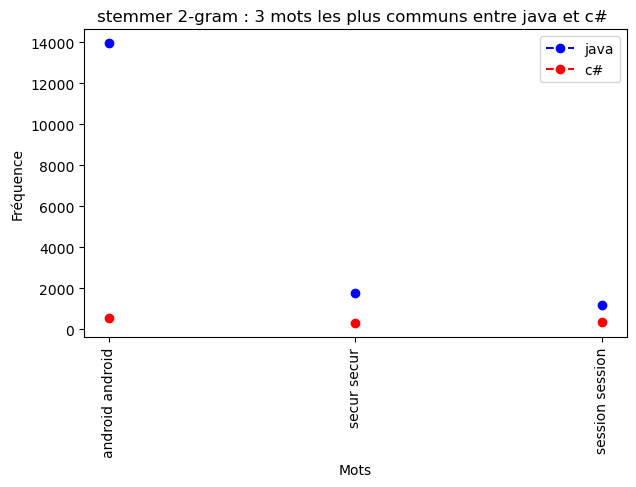

In [89]:
# Intersection mots java / c#
affichage_frequence_distribution_sous_dataframe(most_common_n_gram_in = most_common_stemmer_2_gram,
                                                name_in               = 'stemmer 2-gram',
                                                cle_1_in              = 'java', 
                                                cle_2_in              = 'c#',
                                                intersection_cles_in  = intersection_java_c_sharp_stemmer_2_gram)

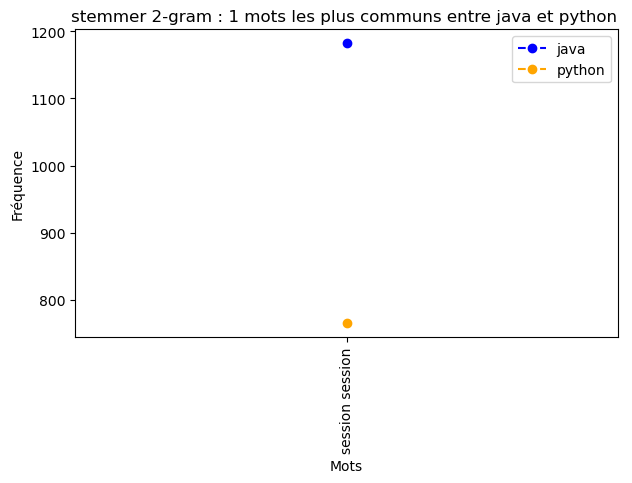

In [90]:
# Intersection mots java / python
affichage_frequence_distribution_sous_dataframe(most_common_n_gram_in = most_common_stemmer_2_gram,
                                                name_in               = 'stemmer 2-gram',
                                                cle_1_in              = 'java', 
                                                cle_2_in              = 'python',
                                                intersection_cles_in  = intersection_java_python_stemmer_2_gram)

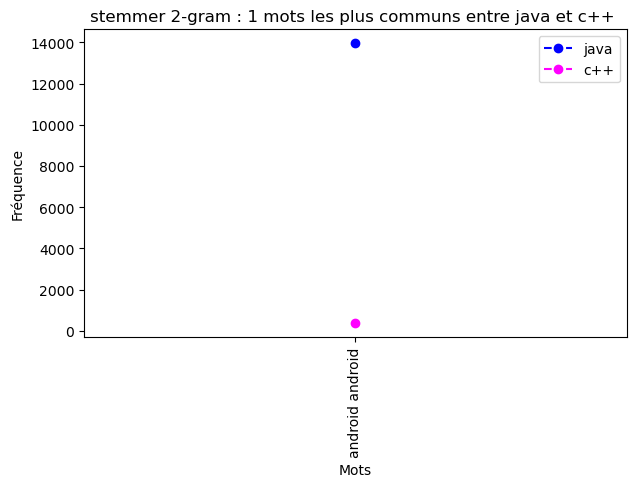

In [91]:
# Intersection mots java / c++
affichage_frequence_distribution_sous_dataframe(most_common_n_gram_in = most_common_stemmer_2_gram,
                                                name_in               = 'stemmer 2-gram',
                                                cle_1_in              = 'java', 
                                                cle_2_in              = 'c++',
                                                intersection_cles_in  = intersection_java_c_plus_plus_stemmer_2_gram)

# 7.3.3. FREQUENCE DISTRIBUTION COLONNE _LEMMA_CLEAN POUR 3-GRAM

In [93]:
# Maj paramètres communs
n_gram      = 3
operation   = '+'
colonne     = '_Lemma_clean_final'
most_common = 40

In [94]:
# java
most_common_lemma_3_gram['java'], most_common_lemma_3_gram_word['java'] = \
frequence_distribution_sous_dataframe(n_gram_in      = n_gram,
                                      operation_in   = operation,
                                      cle_in         = 'java', 
                                      colonne_in     = colonne, 
                                      most_common_in = most_common)

n_gram_in	= 3 
operation_in	= + 
cle_in		= java 
colonne_in	= _Lemma_clean 

40 most_common : [(('android', 'android', 'android'), 8096), (('release', 'jar', 'release'), 2800), (('boot', 'spring', 'boot'), 2291), (('apache', 'catalina', 'apache'), 2223), (('catalina', 'apache', 'catalina'), 2160), (('spring', 'release', 'jar'), 2053), (('dependency', 'dependency', 'dependency'), 1863), (('factory', 'factory', 'factory'), 1642), (('sun', 'reflect', 'invoke'), 1580), (('spring', 'boot', 'starter'), 1476), (('hibernate', 'hibernate', 'hibernate'), 1465), (('apache', 'apache', 'apache'), 1407), (('jar', 'jar', 'jar'), 1293), (('invoke', 'apache', 'catalina'), 1131), (('android', 'wrap', 'android'), 1129), (('apache', 'catalina', 'invoke'), 1094), (('final', 'jar', 'final'), 1038), (('catalina', 'invoke', 'apache'), 902), (('sun', 'sun', 'sun'), 899), (('security', 'security', 'security'), 857), (('sun', 'reflect', 'native'), 855), (('reflect', 'invoke', 'reflect'), 853), (('invoke', 'refle

In [95]:
# c#
most_common_lemma_3_gram['c#'], most_common_lemma_3_gram_word['c#'] = \
frequence_distribution_sous_dataframe(n_gram_in      = n_gram,
                                      operation_in   = operation,
                                      cle_in         = 'c#', 
                                      colonne_in     = colonne, 
                                      most_common_in = most_common)

n_gram_in	= 3 
operation_in	= + 
cle_in		= c# 
colonne_in	= _Lemma_clean 

40 most_common : [(('td', 'td', 'td'), 514), (('double', 'double', 'double'), 408), (('binding', 'binding', 'binding'), 396), (('grid', 'grid', 'grid'), 391), (('div', 'div', 'div'), 389), (('entity', 'entity', 'entity'), 366), (('culture', 'neutral', 'culture'), 345), (('neutral', 'culture', 'neutral'), 338), (('mono', 'mono', 'mono'), 328), (('studio', 'visual', 'studio'), 320), (('visual', 'studio', 'visual'), 318), (('assembly', 'culture', 'neutral'), 317), (('asp', 'asp', 'asp'), 284), (('catch', 'ex', 'ex'), 282), (('android', 'android', 'android'), 277), (('await', 'await', 'await'), 266), (('assembly', 'assembly', 'assembly'), 262), (('person', 'person', 'person'), 256), (('expression', 'expression', 'expression'), 222), (('action', 'action', 'action'), 203), (('ref', 'ref', 'ref'), 200), (('dictionary', 'dictionary', 'dictionary'), 192), (('builder', 'builder', 'builder'), 192), (('td', 'td', 'align'), 

In [ ]:
# javascript
most_common_lemma_3_gram['javascript'], most_common_lemma_3_gram_word['javascript'] = \
frequence_distribution_sous_dataframe(n_gram_in      = n_gram,
                                      operation_in   = operation,
                                      cle_in         = 'javascript', 
                                      colonne_in     = colonne, 
                                      most_common_in = most_common)

In [ ]:
# python
most_common_lemma_3_gram['python'], most_common_lemma_3_gram_word['python'] = \
frequence_distribution_sous_dataframe(n_gram_in      = n_gram,
                                      operation_in   = operation,
                                      cle_in         = 'python', 
                                      colonne_in     = colonne, 
                                      most_common_in = most_common) 

In [ ]:
# c++
most_common_lemma_3_gram['c++'], most_common_lemma_3_gram_word['c++'] = \
frequence_distribution_sous_dataframe(n_gram_in      = n_gram,
                                      operation_in   = operation,
                                      cle_in         = 'c++', 
                                      colonne_in     = colonne, 
                                      most_common_in = most_common)

In [ ]:
###################################################
#    Intersection entre les 5 sous-dataframes     #
###################################################
# https://www.cours-gratuit.com/tutoriel-python/tutoriel-python-trouver-lintersection-de-deux-listes
set_java_lemma_3_gram        = set(most_common_lemma_3_gram_word['java'])
set_c_sharp_lemma_3_gram     = set(most_common_lemma_3_gram_word['c#']) 
set_javascript_lemma_3_gram  = set(most_common_lemma_3_gram_word['javascript']) 
set_python_lemma_3_gram      = set(most_common_lemma_3_gram_word['python']) 
set_c_plus_plus_lemma_3_gram = set(most_common_lemma_3_gram_word['c++']) 

intersection_java_c_sharp_lemma_3_gram     = list(set_java_lemma_3_gram & set_c_sharp_lemma_3_gram)
intersection_java_javascript_lemma_3_gram  = list(set_java_lemma_3_gram & set_javascript_lemma_3_gram)
intersection_java_python_lemma_3_gram      = list(set_java_lemma_3_gram & set_python_lemma_3_gram)
intersection_java_c_plus_plus_lemma_3_gram = list(set_java_lemma_3_gram & set_c_plus_plus_lemma_3_gram)
intersection_all_lemma_3_gram              = list(set_java_lemma_3_gram & set_c_sharp_lemma_3_gram & \
                                                    set_javascript_lemma_3_gram & set_python_lemma_3_gram & \
                                                    set_c_plus_plus_lemma_3_gram)

print('intersection_java_c_sharp_lemma_3_gram\t\t=', intersection_java_c_sharp_lemma_3_gram)
print('intersection_java_javascript_lemma_3_gram\t=', intersection_java_javascript_lemma_3_gram)
print('intersection_java_python_lemma_3_gram\t\t=', intersection_java_python_lemma_3_gram)
print('intersection_java_c_plus_plus_lemma_3_gram\t=', intersection_java_c_plus_plus_lemma_3_gram)
print('intersection_all_lemma_3_gram\t\t\t=', intersection_all_lemma_3_gram)

In [ ]:
####################################################
#       Affichage fréquence distribution           #
####################################################
# On affiche les distributions qui ont des intersections.

In [ ]:
# Intersection mots java / c#
affichage_frequence_distribution_sous_dataframe(most_common_n_gram_in = most_common_lemma_3_gram,
                                                name_in               = 'lemma 3-gram',
                                                cle_1_in              = 'java', 
                                                cle_2_in              = 'c#',
                                                intersection_cles_in  = intersection_java_c_sharp_lemma_3_gram)

In [ ]:
# Intersection mots java / c++
affichage_frequence_distribution_sous_dataframe(most_common_n_gram_in = most_common_lemma_3_gram,
                                                name_in               = 'lemma 3-gram',
                                                cle_1_in              = 'java', 
                                                cle_2_in              = 'c++',
                                                intersection_cles_in  = intersection_java_c_plus_plus_lemma_3_gram)

# 7.4. WORD CLOUD (VARIABLE CATEGORIELLE)

In [ ]:
##############################################################################  
# WordCloud : visualisation des tokens les plus présents d'une colonne       #
##############################################################################

In [496]:
#########################################################  
# WordCloud pour le dataframe, d'une colonne            #
######################################################### 
def word_cloud(count_in, colonne_in, cle_in = ''):
    
    # Affichage des 20 mots les plus fréquents du corpus
    if (cle_in != ''):
        print('20 mots les plus fréquents colonne', colonne_in, ', sous-dataframe', cle_in, ':')
    else:
        print('20 mots les plus fréquents colonne', colonne_in, ':')
    print(count_in.head(20), '\n')
    
    
    # https://ichi.pro/fr/creer-des-nuages-de-mots-personnalises-en-python-145227399773811
    wc = WordCloud(background_color = 'beige',
                   max_words        = 40,      # affichage d'au moins 40 mots
                   width            = 4000, 
                   height           = 3000)
    wc.generate_from_frequencies(count_in)
    plt.imshow(wc)
    plt.axis("off")
    if (cle_in != ''):
        plt.title('Word Cloud colonne ' + colonne_in + ', sous-dataframe ' + cle_in)
    else:
        plt.title('Word Cloud colonne ' + colonne_in)
    plt.show()

In [497]:
#########################################################  
# WordCloud pour les sous-dataframes, d'une colonne     #
######################################################### 
def word_cloud_sous_dataframe(cle_in, colonne_in):
   
    #####################################
    # Corpus au format texte            #
    #####################################
    # On reconstitue le corpus en joignant l'ensemble des lignes / documents entre eux.
    corpus_text = ' '.join(dict_df[cle_in][colonne_in])

    
    #####################################
    # Corpus au format token            #
    #####################################
    token_text = corpus_text.split()
    
    
    #############################################################
    # Nombre de fois où les tokens sont présents dans le corpus #
    #############################################################  
    count_text = pd.Series(token_text).value_counts()
        
        
    #####################################
    # Wordcloud                         #
    #####################################
    word_cloud(count_in   = count_text, 
               colonne_in = colonne_in,
               cle_in     = cle_in)

20 mots les plus fréquents colonne _Text_clean :
android       131083
div            49062
apache         31271
spring         31204
jar            26507
react          21921
override       21491
release        21133
column         21098
title          20915
password       20845
site           20773
action         20103
security       20101
final          20062
token          19847
session        19583
dependency     19257
controller     19159
component      18392
dtype: int64 



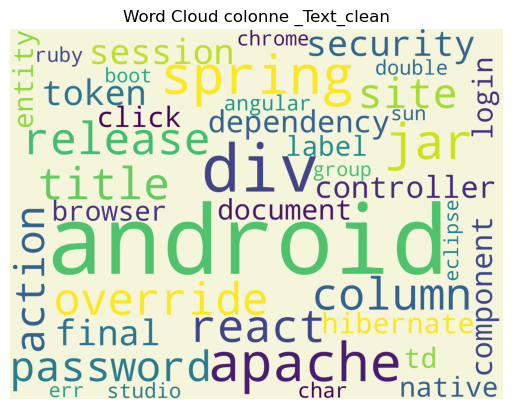

In [498]:
#########################################################
#        WordCloud dataframe, colonne _Text_clean       #
#########################################################
word_cloud(count_in   = count_text, 
           colonne_in = '_Text_clean')

20 mots les plus fréquents colonne _Stemmer_clean :
android     131083
div          49062
apach        31271
spring       31204
jar          26523
activ        24978
final        24827
depend       24374
secur        23492
react        21921
session      21626
overrid      21491
releas       21138
column       21101
titl         21019
password     20845
site         20773
action       20163
gener        20017
token        19847
dtype: int64 



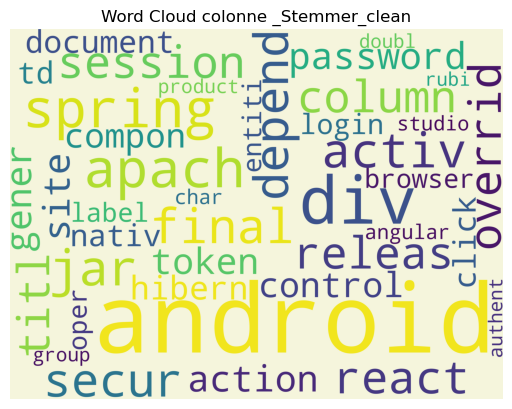

In [499]:
#########################################################
#       WordCloud dataframe, colonne _Stemmer_clean     #
#########################################################
word_cloud(count_in   = count_stemmer, 
           colonne_in = '_Stemmer_clean_final')

20 mots les plus fréquents colonne _Lemma_clean :
android       131083
div            49062
apache         31271
spring         31204
jar            26507
react          21921
session        21626
override       21491
release        21133
column         21098
title          20915
password       20845
site           20773
action         20103
security       20101
final          20062
token          19847
dependency     19257
controller     19159
component      18392
dtype: int64 



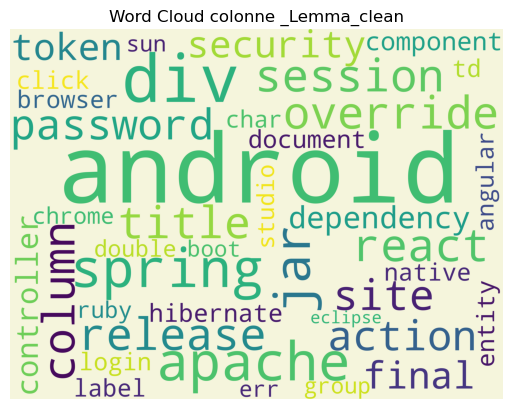

In [500]:
#########################################################
#        WordCloud dataframe, colonne _Lemma_clean      #
#########################################################
word_cloud(count_in   = count_lemma, 
           colonne_in = '_Lemma_clean_final')

20 mots les plus fréquents colonne _Stemmer_clean , sous-dataframe java :
android     31938
spring      22938
apach       19505
jar         18630
hibern      13306
final       12470
depend      11780
sun         10829
secur       10248
boot         9745
releas       9227
eclips       8505
overrid      8066
bean         7495
invok        6484
factori      6052
catalina     5956
annot        5525
reflect      5491
tomcat       5446
dtype: int64 



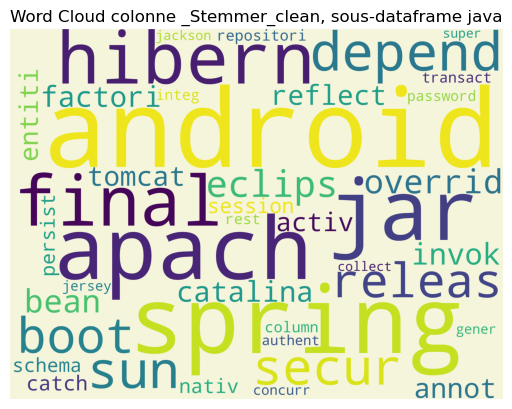

In [501]:
###########################################################
#  WordCloud sous-dataframe java, colonne _Stemmer_clean  #
###########################################################
word_cloud_sous_dataframe(cle_in     = 'java', 
                          colonne_in = '_Stemmer_clean_final')

20 mots les plus fréquents colonne _Stemmer_clean , sous-dataframe c# :
asp         7395
entiti      4785
visual      4548
bind        4505
await       4432
studio      4287
assembl     4085
gener       3828
control     3674
bool        3451
action      3287
express     3060
secur       2656
token       2649
grid        2614
collect     2456
authent     2453
password    2434
click       2369
doubl       2358
dtype: int64 



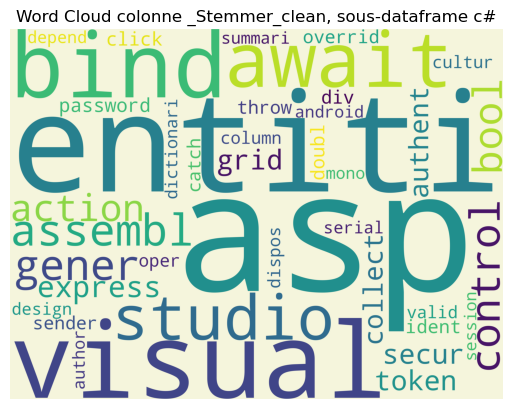

In [502]:
#########################################################
#  WordCloud sous-dataframe c#, colonne _Stemmer_clean  #
#########################################################
word_cloud_sous_dataframe(cle_in     = 'c#', 
                          colonne_in = '_Stemmer_clean_final')

20 mots les plus fréquents colonne _Stemmer_clean , sous-dataframe javascript :
div          25436
react        11093
document      7909
click         6613
compon        6448
browser       6053
td            5946
angular       5846
chrome        5784
li            5463
titl          4905
err           4347
span          4278
render        3951
label         3706
canva         3645
prop          3373
export        3343
bootstrap     3331
token         3015
dtype: int64 



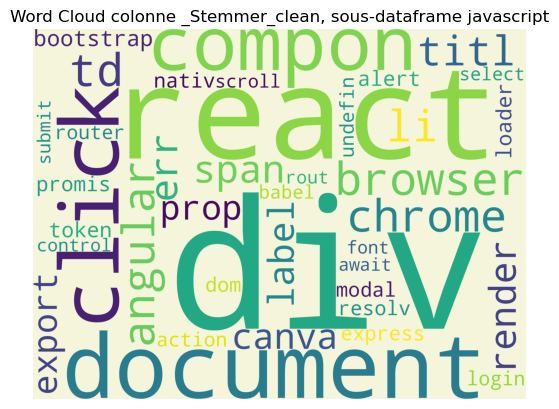

In [503]:
#################################################################
#  WordCloud sous-dataframe javascript, colonne _Stemmer_clean  #
#################################################################
word_cloud_sous_dataframe(cle_in      = 'javascript',
                          colonne_in = '_Stemmer_clean_final')

20 mots les plus fréquents colonne _Stemmer_clean , sous-dataframe python :
site       9236
train      6904
pip        5160
column     5083
rang       4282
shape      4190
plot       4140
flask      3636
session    3461
loss       3389
len        3124
gener      3009
recent     2967
matrix     2934
append     2853
activ      2658
nan        2640
batch      2579
fit        2560
label      2539
dtype: int64 



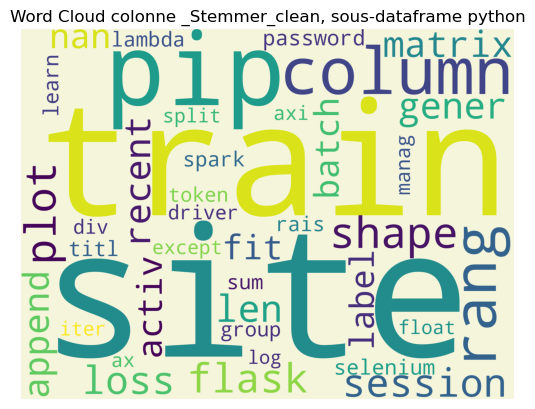

In [504]:
#############################################################
#  WordCloud sous-dataframe python, colonne _Stemmer_clean  #
#############################################################
word_cloud_sous_dataframe(cle_in      = 'python',
                          colonne_in = '_Stemmer_clean_final')

20 mots les plus fréquents colonne _Stemmer_clean , sous-dataframe c++ :
boost          9017
char           7990
vector         7763
oper           5588
doubl          4860
clang          4285
float          4105
pointer        3607
unsign         3399
bool           3148
constructor    2862
member         2699
visual         2672
declar         2557
alloc          2506
cast           2477
virtual        2428
studio         2204
uniqu          2094
undefin        2054
dtype: int64 



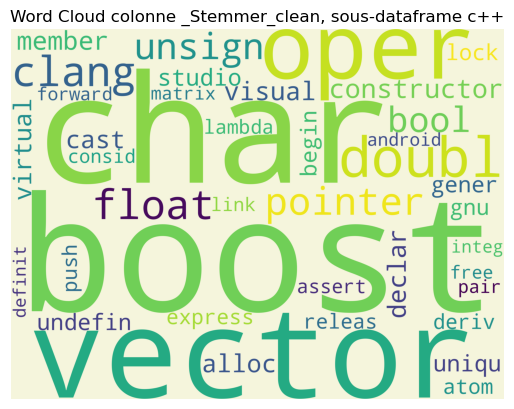

In [505]:
###########################################################
#  WordCloud sous-dataframe c++, colonne _Stemmer_clean   #
###########################################################
word_cloud_sous_dataframe(cle_in      = 'c++',
                          colonne_in = '_Stemmer_clean_final')

# 7.5. ANALYSE UNIVARIEE VARIABLES NUMERIQUES

In [92]:
# Sélection des colonnes numériques
df_numerique = df.select_dtypes(include = np.number)
var_numerique = df_numerique.columns
print('var_numerique =', var_numerique)

var_numerique = Index(['Id', 'Score', 'AnswerCount', '_len_Text', 'len_Text_clean',
       '_unique_words_Text_clean', '_unique_words_Lemma_clean',
       '_unique_words_Stemmer_clean'],
      dtype='object')


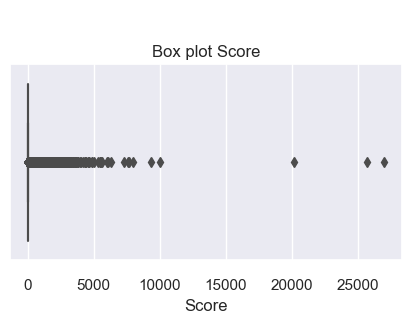

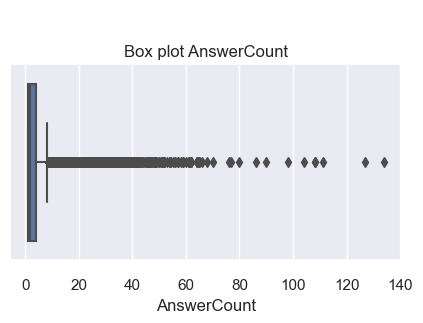

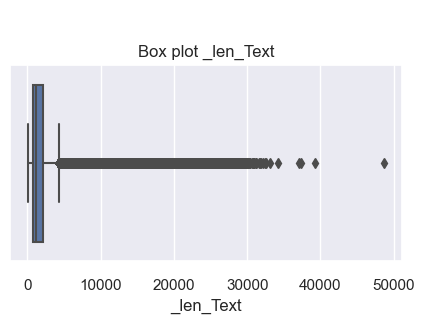

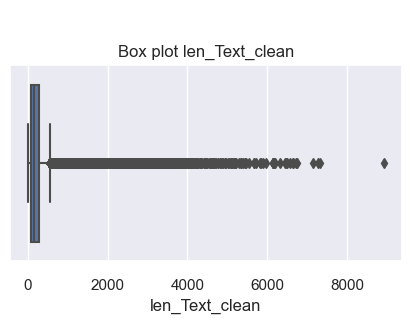

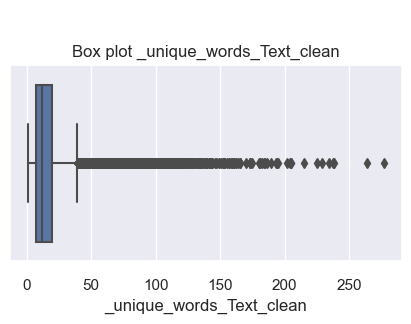

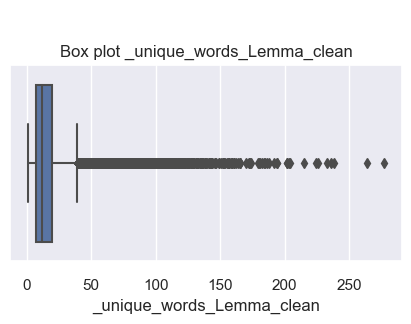

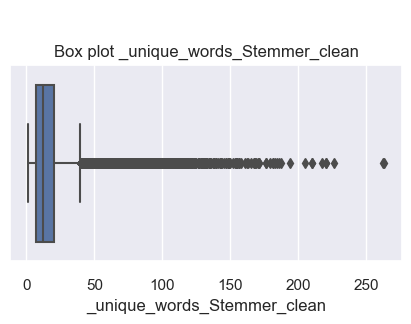

In [106]:
for col in var_numerique:
    if (col != 'Id'):
        # define figure size
        sns.set(rc = {"figure.figsize":(4, 2)}) #width=6, height=5
        plt.title('\n\nBox plot ' + col)    
        sns.boxplot(data = df, x = col)

        plt.show()    

# 8. ANALYSE BIVARIEE

# 8.1. ETUDE DE LA TAILLE DES DOCUMENTS PAR RPPORT AUX TAGS (VARIABLE QUANTITATIVE ET VARIABLE CATEGORIELLE)

In [341]:
#####################################################################
#   Box plot pour 1 variable catégorielle et 1 variable numérique   #
#####################################################################
# https://seaborn.pydata.org/generated/seaborn.boxplot.html
def box_plot(colonne_x_numerique_in, colonne_y_categorielle_in):
    
    order_categorical_level = df.groupby(colonne_y_categorielle_in)[colonne_x_numerique_in].median().sort_values().index

    plt.figure(figsize = (6, 9))
    sns.set(font_scale = 0.6)
    
    sns.boxplot(x          = colonne_x_numerique_in, 
                y          = colonne_y_categorielle_in, 
                showfliers = False, # on supprime outliers
                orient     = 'h',
                order      = order_categorical_level, 
                data       = df)
    
    plt.title('Box plot ' + colonne_x_numerique_in + ' % ' + colonne_y_categorielle_in, fontsize = 12)
    plt.show()
    
    print('\n\n')

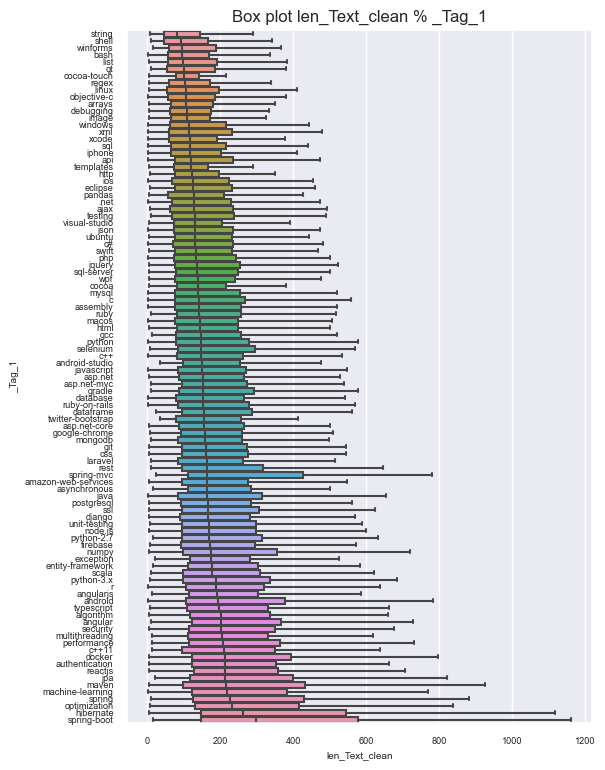

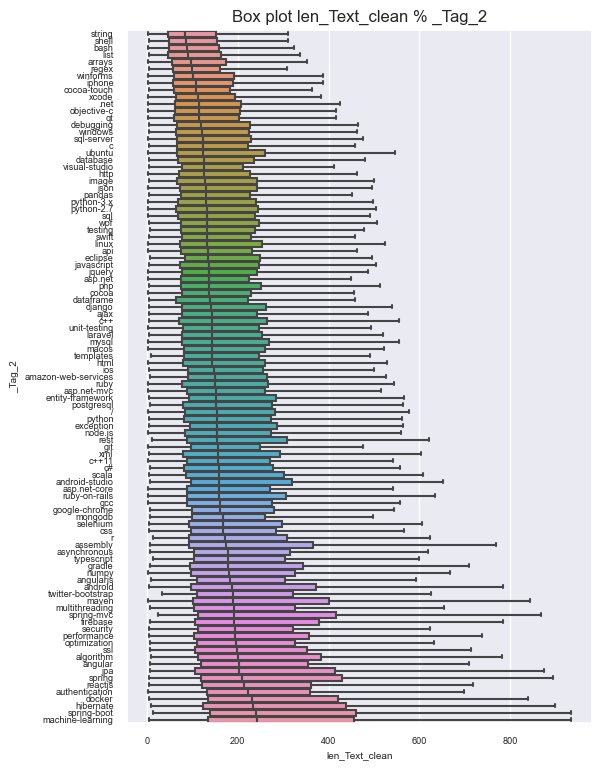

In [342]:
########################################################
# Box plot avec colonne_x_numerique = _len_Text_clean  #
########################################################
box_plot(colonne_x_numerique_in    = '_len_Text_clean',
         colonne_y_categorielle_in = '_Tag_1')

box_plot(colonne_x_numerique_in    = '_len_Text_clean',
         colonne_y_categorielle_in = '_Tag_2')

# 9. ANALYSE MULTIVARIEE

# 9.1. ANALYSE DE 3 VARIABLES NUMERIQUES

In [176]:
#######################################################################
#    Calcul du nombre de mots uniques pour les colonnes _xxx_clean    #
#######################################################################
# https://www.delftstack.com/fr/howto/python/python-count-unique-values-in-list/
# Nombre de mots uniques dans les colonnes _xxx_clean.
# on stocke ce vecteur numérique dans une colonne préfixée par _
count = 0

for index, row in df.iterrows():
    
    df.loc[index, '_unique_words_Text_clean']    = len(np.unique(df.loc[index, '_Text_clean'].split()))
    df.loc[index, '_unique_words_Lemma_clean']   = len(np.unique(df.loc[index, '_Lemma_clean_final'].split()))
    df.loc[index, '_unique_words_Stemmer_clean'] = len(np.unique(df.loc[index, '_Stemmer_clean_final'].split()))
    
    if (count < 10):
        print('index =', index, ':', '\n',
              '\t- _Text_clean\t\t\t=', df.loc[index, '_Text_clean'], '\n', 
              '\t- _len_Text_clean\t\t=', df.loc[index, '_len_Text_clean'], '\n', 
              '\t- _unique_words_Text_clean\t=', df.loc[index, '_unique_words_Text_clean'], '\n',  
              '\t- _Lemma_clean_final\t\t\t=', df.loc[index, '_Lemma_clean_final'], '\n',               
              '\t- _unique_words_Lemma_clean_final\t=', df.loc[index, '_unique_words_Lemma_clean_final'], '\n',
              '\t- _Stemmer_clean_final\t\t=', df.loc[index, '_Stemmer_clean_final'], '\n',                       
              '\t- _unique_words_Stemmer_clean_final\t=', df.loc[index, '_unique_words_Stemmer_clean_final'], '\n')
    count = count + 1

index = 0 : 
 	- _Text_clean			= registry programmer friendly registry 
 	- _len_Text_clean		= 37 
 	- _unique_words_Text_clean	= 3 
 	- _Lemma_clean			= registry programmer friendly registry 
 	- _unique_words_Lemma_clean	= 3 
 	- _Stemmer_clean		= registri programm friendli registri 
 	- _unique_words_Stemmer_clean	= 3 

index = 1 : 
 	- _Text_clean			= setter appropriate torn situation throw appropriate understood whatever prefer 
 	- _len_Text_clean		= 78 
 	- _unique_words_Text_clean	= 8 
 	- _Lemma_clean			= setter appropriate torn situation throw appropriate understood whatever prefer 
 	- _unique_words_Lemma_clean	= 8 
 	- _Stemmer_clean		= setter appropri torn situat throw appropri understood whatev prefer 
 	- _unique_words_Stemmer_clean	= 8 

index = 2 : 
 	- _Text_clean			= sparse manipulation enormous matrices specifically pyramidal summation copula calculation short track relatively usually rare sea matrix multidimensional sparse assume undefined preset physically possibl

In [177]:
# summary statistics sur les colonnes de type numérique
# (transpose met les attributs en ligne pour + de lisibilité)
df.describe(include = np.number).transpose()

count          mean           std   min  \
Id                           207636.0  2.666463e+07  1.914842e+07   4.0   
Score                        207636.0  2.594568e+01  1.436341e+02   6.0   
AnswerCount                  207636.0  3.417187e+00  3.514504e+00   1.0   
_len_Text                    207636.0  1.850990e+03  2.244154e+03  62.0   
len_Text_clean               207636.0  2.306255e+02  3.019940e+02   2.0   
_unique_words_Text_clean     207636.0  1.597148e+01  1.347944e+01   1.0   
_unique_words_Lemma_clean    207636.0  1.594747e+01  1.345005e+01   1.0   
_unique_words_Stemmer_clean  207636.0  1.564026e+01  1.308255e+01   1.0   

                                   25%         50%          75%         max  
Id                           9576688.5  23831765.0  41461253.25  76403109.0  
Score                              7.0        10.0        18.00     27009.0  
AnswerCount                        1.0         2.0         4.00       134.0  
_len_Text                        705.0      1210.0      2139.00     48697.0  
len_Text_clean                    80.0       147.0       270.00      8932.0  
_unique_words_Text_clean           7.0        12.0        20.00       277.0  
_unique_words_Lemma_clean          7.0        12.0        20.00       277.0  
_unique_words_Stemmer_clean        7.0        12.0        20.00       263.0

In [178]:
df.columns

Index(['CreationDate', 'Id', 'Score', 'AnswerCount', '_Text', '_Tag_1',
       '_Tag_2', '_Text_sans_html', '_Text_tokens', '_Text_clean',
       '_Stemmer_clean', '_Lemma_clean', '_len_Text', 'len_Text_clean',
       '_unique_words_Text_clean', '_unique_words_Lemma_clean',
       '_unique_words_Stemmer_clean'],
      dtype='object')

In [179]:
# Réduction du dataframe pour avoir une ficgure + lisible
print('df shape\t=', df.shape)

df_reduit = df[(df['AnswerCount'] <= 20) &
               (df['Score'] <= 200)]
print('df_reduit shape\t=', df_reduit.shape)

df shape	= (207636, 17)
df_reduit shape	= (204154, 17)


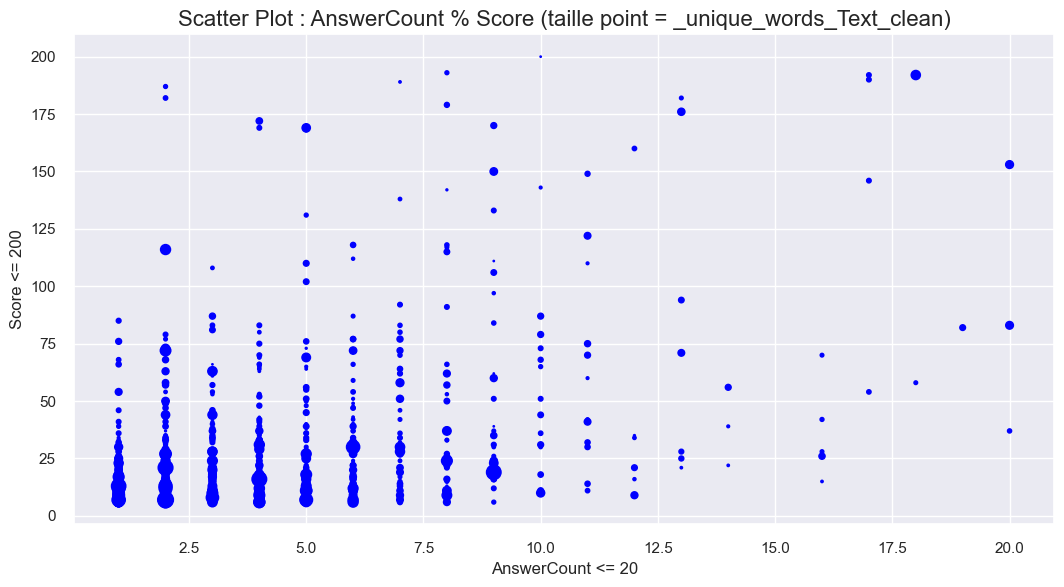

In [180]:
############################################################
# Scatter plot pour 3 variables numériques :               #
#    --> x = AnswerCount                                   #
#    --> y = Score                                         #
#    --> taille des points = _unique_words_Text_clean      #
############################################################
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html
# https://www.geeksforgeeks.org/how-to-increase-the-size-of-scatter-points-in-matplotlib/  
# https://stackoverflow.com/questions/30336138/how-to-plot-a-multivariate-function-in-python

# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html
# Bp de points => pour + de lisibilité, on travaille sur un sous-ensemble (2000 points)
data_subset = df_reduit.sample(n = 2000, replace = True, random_state = 1)    
    
plt.figure(figsize = (10, 5)) # 6 is width, 5 is height

x = data_subset['AnswerCount']
y = data_subset['Score'] 
points_size = data_subset['_unique_words_Text_clean'] 

plt.scatter(x, y, s = points_size, c = 'blue')

plt.title('Scatter Plot : AnswerCount % Score (taille point = _unique_words_Text_clean)', fontsize = 16)
plt.xlabel('AnswerCount <= 20', fontsize = 12)
plt.ylabel('Score <= 200', fontsize = 12)
  
plt.show()

# 9.2. MATRICE DE CORRELATION

In [319]:
# matrice de corrélation
corr = df.corr()
corr

Id     Score  AnswerCount  _len_Text
Id           1.000000 -0.070496    -0.183627   0.162946
Score       -0.070496  1.000000     0.391455  -0.031462
AnswerCount -0.183627  0.391455     1.000000  -0.067758
_len_Text    0.162946 -0.031462    -0.067758   1.000000

In [182]:
#####################################################################
# matrice de corrélation : représentation graphique de la diagonale #
#####################################################################
# Valeurs minimale = -1, maximale = 1. 
# fmt = arrondi 2 chiffres après la virgule.
def affichage_matrice_correlation():
    
    corr = df.corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True

    fig, ax = plt.subplots(1, 1, figsize = (7,5))
    ax = sns.heatmap(corr, mask = mask, vmin = -1, vmax = 1, cmap = 'coolwarm', annot = True, fmt = '.2f', square = True)

    # il y a :
    #    --> 72% de corrélation entre ViewCount et Score
    #    --> 50% de corrélation entre ViewCount et AnswerCount
    # ==> on supprime la colonne ViewCount.

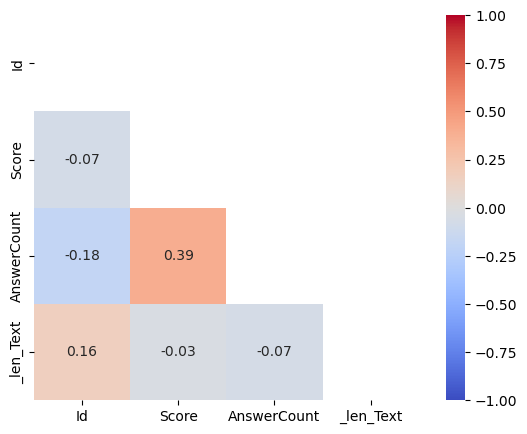

In [321]:
affichage_matrice_correlation()

In [ ]:
# Suppression colonne ViewCount
df.drop(['ViewCount'], axis = 1, inplace = True)

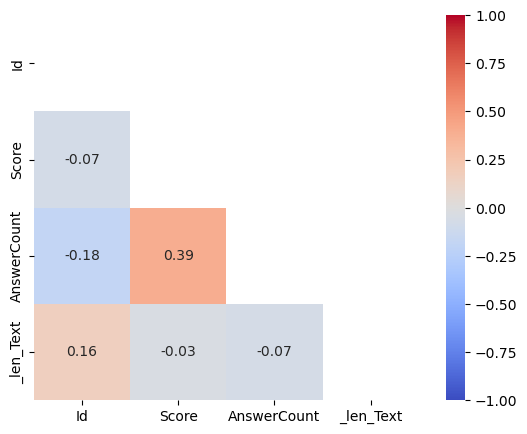

In [322]:
# Maj affichage matrice de corrélation
affichage_matrice_correlation()

In [38]:
df.columns

Index(['CreationDate', 'Id', 'Score', 'AnswerCount', '_Text', '_Tag_1',
       '_Tag_2', '_Text_sans_html', '_Text_tokens', '_Text_clean',
       '_Stemmer_clean', '_Lemma_clean', '_len_Text', 'len_Text_clean',
       '_unique_words_Text_clean', '_unique_words_Lemma_clean',
       '_unique_words_Stemmer_clean'],
      dtype='object')

# 10. SAUVEGARDE DANS FICHIERS

In [ ]:
# Réinitialisation de l’index du dataFrame :
#   --> Avant sauvegarde dans fichier.
# https://www.delftstack.com/fr/howto/python-pandas/pandas-reset-index-python/
df.reset_index(inplace = True, drop = True)

In [ ]:
# Suppression :
#  ---> des colonnes n'impactent pas le texte : 
#          > colonne date ('CreationDate').
#          > colonnes numériques ('Id', 'Score', 'AnswerCount'). 
#  ---> des colonnes intermédiaires créées pour le calcul des colonnes nettoyées (xxx_clean).
df.drop(['CreationDate', 'Id', 'Score', 'AnswerCount',
         '_Text', '_Text_tokens',
         '_len_Text', '_len_Text_clean',
         '_Tokens_text_clean', '_Tokens_stemmer_clean', '_Tokens_lemma_clean',
         '_Text_clean', '_Stemmer_clean', '_Lemma_clean'],
        axis = 1, inplace = True)

In [ ]:
df.columns

In [81]:
###########################################################
#             Données nettoyées réduites                  #
###########################################################
df_light = df.copy()

In [82]:
# On enlève uniquement la colonne '_Text_sans_html'
df_light.drop(['_Text_sans_html'], axis = 1, inplace = True)

In [540]:
df_light.columns

Index(['Id', 'Score', 'AnswerCount', '_Tag_1', '_Tag_2', '_Text_clean',
       '_Stemmer_clean', '_Lemma_clean', '_Tokens_text_clean',
       '_Tokens_stemmer_clean', '_Tokens_lemma_clean'],
      dtype='object')

In [83]:
###########################################################
#   ENREGISTREMENT DONNEES NETTOYEES DANS DES FICHIERS    #
###########################################################
# Données nettoyées
df.to_csv(C_DATASET_CLEANED + 'QueryResults_2008_to_2023_clean.csv', 
          sep = '\t', header = True, index = False)

# Données nettoyées réduites
df_light.to_csv(C_DATASET_CLEANED + 'QueryResults_2008_to_2023_clean_light.csv', 
                sep = '\t', header = True, index = False)